## Geely Auto - Assignment to study factors that influence Car Prices

* __Problem Statement__
  - A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts. 

  - They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. The company wants to know:

  - Which variables are significant in predicting the price of a car
How well those variables describe the price of a car Based on various market surveys, the consulting firm has gathered a large dataset of different types of cars across the Americal market. 

* __Business Goal__ 

  - You are required to model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market. 

## Approach of my analysis to the problem

__High Level Approach__
As there are different approaches in Multiple Linear Regression to select the features, I would create 3 models with RFE and manual based feature selection and different scaling methods. 
* The basis for 3 models is as follows:
  1. __Multiple Linear Regression Model I:__ Selection of 10 Features using RFE and iterate manually to drop the features based on high significance level (p-values) and high VIF, Scaling Technique used - Standardization method
  2. __Multiple Linear Regression Model II:__  Start with all the features and selection of 10 Features using Backward elimination. Iterate manually to drop the features based on high significance level (p-values) and high VIF, Scaling Technique used - Normalization (MinMax Scaler) method.
  3. __Multiple Linear Regression Model III:__  Selection of 25 Features using RFE and perform backward elemenation to select best 10 to 8 features. Iterate manually to drop the features based on high significance level (p-values) and high VIF, Scaling Technique used - Standardization method.
  
__Based on the inferences from each of the model, I would try to select the best model based on the significance level and other factors__


## Steps invoved in this notebook

1. Import Python Libraries for data analysis and ML 
2. Local user defined functions
3. Sourcing the Data
4. Inspect and Clean the Data
5. Visualising and Exploring the data
6. Preparing the data for modelling(train-test split, rescaling etc)
7. Hypothesis Test and Model evaluation for MLR
8. Multiple Linear Regression Model I using RFE
   * Modelling, Training, Selection of Features and Iteration, Residual Analysis on both test and train, Evaluate the model with Test set and summary
9. Multiple Linear Regression Model II using Backward Elimination 
   * Modelling, Training, Selection of Features and Iteration, Residual Analysis on both test and train, Evaluate the model with Test set and summary
10. Multiple Linear Regression Model III using RFE and Backward Elimination
   * Modelling, Training, Selection of Features and Iteration, Residual Analysis on both test and train, Evaluate the model with Test set and summary
11. Final Summary

## Import Python Functions

In [1]:
# Python libraries for Data processing and analysis
import time as time
strt = time.time()
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.options.mode.use_inf_as_na = True
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import glob
from matplotlib.pyplot import figure
import warnings
import math
import itertools
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
from math import sqrt
import re

# ML Libraries
import statsmodels
import statsmodels.api as sm
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler,OrdinalEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

## Local User Defined Functions

### Local functions for data overview and data cleaning

In [2]:
# Local classes and Local flags

# Local Classes
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
# Debug flag for investigative purpose
DEBUG = 0

# Default random_state
rndm_stat = 42

In [3]:
# local functions

# Function to read a file & Store it in Pandas
# read_file takes either csv or excel file as input and reuturns a pandas DF and
# also prints head, tail, description, info and shape of the DF
def read_file(l_fname,l_path,head=0):
    i = l_fname.split(".")
    f_path = l_path+'/'+l_fname
    print(f_path,i[0],i[1])
    if (i[1] == "xlsx"):
        l_df = pd.read_excel(f_path,header=head,encoding = "ISO-8859-1",infer_datetime_format=True)
    elif (i[1] == "csv"):
        l_df = pd.read_csv(f_path,header=head,encoding = "ISO-8859-1",infer_datetime_format=True)
    ov_df(l_df)
    return(l_df)

# Function to get the Overview of DataFrame
# take df as input and prints head, tail, description, info and shape of the DF
def ov_df(l_df):
    print(color.BOLD+color.PURPLE + 'Inspect and Explore the Dataset' + color.END)
    print("\n#####################  DataFrame Head  ######################")
    print(l_df.head(3))
    print("\n#####################  DataFrame Tail  ######################")
    print(l_df.tail(3))
    print("\n#####################  DataFrame Info  ######################")
    print(l_df.info())
    print("\n####################  DataFrame Columns  ####################")
    print(list(l_df.columns))
    print("\n####################  DataFrame Shape  ####################")
    print("No of Rows",l_df.shape[0])
    print("No of Columns",l_df.shape[1])

# Function per_col_null takes a df as input and prints summary of Null Values across Columns
def per_col_null(l_df):
    print("\n############  Missing Values of Columns in %  ############")
    col_null = round((l_df.isnull().sum().sort_values(ascending=False)/len(l_df))*100,4)
    print(col_null[col_null > 0])  

# Function to change the cast the column into different type
def col_cast(l_df,n_dtyp,*args):
    for l_c_name in args:
        l_df = l_df.astype({l_c_name:n_dtyp})
        print(l_df[l_c_name].describe())
    return(l_df)

### Functions to plot

In [25]:
# Function to plot 2 or more box plots
# m_box_plt takes a df, dimensions of subplot (no of rows and columns) and variable list of columns
# to plot multiple boxplots
def m_box_plt(l_df,n_r,n_c,*args):
    j=1
    fig_h = n_r * 5
    plt.figure(1,figsize=(13,fig_h))
    # set palette 
    #palette = itertools.cycle(sns.color_palette())
    sns.set(style="whitegrid",font_scale=1,palette='Set3')
    for i in args:
        plt.subplot(n_r,n_c,j)
        sns.boxplot(l_df[i],orient="v")
        #sns.swarmplot(l_df[i],color=".25",orient="v")
        plt.title('Central Tendency of {}'.format(i),fontsize=12)
        j+=1
    plt.show()
    
# Function to plot 2 or more Linear Regression plots
# reg_plt takes a df, dimensions of subplot (no of rows and columns), dependent variable and variable list of columns
# to plot multiple reg plots
def reg_plt(l_df,n_r,n_c,l_dep,*args):
    j=1
    plt.figure(1,figsize=(13,13))
    sns.set(style="whitegrid",font_scale=1,palette='Set1')
    for i in args:
        plt.subplot(n_r,n_c,j)
        ax = sns.regplot(x=i,y=l_dep,data=l_df,x_jitter=.1)
        plt.title('Linear Regression Plot of {} and {}'.format(i,l_dep),fontsize=12)
        plt.legend(loc=1)
        j+=1
    plt.show()

#  Function to plot 2 or more box plots
# comp_box_plt takes a df, dimensions of subplot (no of rows and columns), dependent variable and variable list of columns
# to plot multiple comparitive box plots
def comp_box_plt(l_df,n_r,n_c,l_dep,*args):
    j=1
    rot = 0
    if n_c == 1 and n_r == 1:
        rot = 90
    fig_h = n_r * 5
    plt.figure(1,figsize=(20,fig_h))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    sns.set(style="whitegrid",font_scale=1,palette='Set2')

    for i in args:
        plt.subplot(n_r,n_c,j)
        sns.boxplot(x=i,y=l_dep,orient="v",data=l_df)
        ax = sns.stripplot(x=i,y=l_dep, data=l_df, color="red", jitter=0.2, size=3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=rot)
        plt.title('{} spread across {}'.format(l_dep,i),fontsize=12)
        j+=1
    plt.show()  
    
#  Function to plot 2 or more box plots
# dist_plt takes a df, dimensions of subplot (no of rows and columns), variable list of columns
# to plot multiple comparitive distribution plots
def dist_plt(l_df,n_r,n_c,*args):
    j=1
    colrs = ["dummy","skyblue","red","olive","gold","teal","green","blue"]
    k = 1
    fig_h = n_r * 5
    plt.figure(1,figsize=(13,fig_h))
    sns.set(style="whitegrid",font_scale=0.8)
    for i in args:
        plt.subplot(n_r,n_c,j)
        ax = sns.distplot(l_df[i],bins=20,color=colrs[k])
        plt.title('Distribution of {}'.format(i),fontsize=8)
        j+=1
        plt.subplot(n_r,n_c,j)
        ax = sns.boxplot(l_df[i],orient="h",color=colrs[k])
        plt.title('Central Tendency of {}'.format(i),fontsize=8)
        j+=1
        k+=1
    plt.show()

# Function to plot 2 or more Seaborn count plots. 
# This function takes dataframe and variable no of arguments which are columns and do subplots based on the no of rows 
# and columns given
def cnt_plt(l_df,n_r,n_c,*args):
    j=1
    fig_h = n_r * 7
    plt.figure(1,figsize=(14,fig_h))
    sns.set(font_scale=1,palette='bright')
    rot = 25
    if n_c == 1:
        rot = 90
    for i in args:
        plt.subplot(n_r,n_c,j)
        ax = sns.countplot(l_df[i])
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=rot)
        total = len(l_df[i])
        plt.title('Univariate Analysis of variable {}'.format(i),fontsize=12)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + 0.3
            y = p.get_y() + p.get_height()
            ax.annotate(percentage, (x, y))
        j+=1
    plt.show()

## Sourcing the Data

### Read the CarPrice_Assignment.csv

In [5]:
# Set the path and file name
folder=r"C:\My Folders\OneDrive\Surface\Sadguru\Lakshmi\Study\IIIB_PGDS\ML1\Linear_Regression_Assign"
file="CarPrice_Assignment.csv"

# Read file using local functions. read_file takes either csv or excel file as input and reuturns a pandas DF and
# also prints head, tail, description, info and shape of the DF
c_df = read_file(file,folder)

C:\My Folders\OneDrive\Surface\Sadguru\Lakshmi\Study\IIIB_PGDS\ML1\Linear_Regression_Assign/CarPrice_Assignment.csv CarPrice_Assignment csv
Inspect and Explore the Dataset

#####################  DataFrame Head  ######################
   car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   

       carbody drivewheel enginelocation  wheelbase  carlength  carwidth  \
0  convertible        rwd          front       88.6      168.8      64.1   
1  convertible        rwd          front       88.6      168.8      64.1   
2    hatchback        rwd          front       94.5      171.2      65.5   

   carheight  curbweight enginetype cylindernumber  enginesize fuelsystem  \
0       48.8        2548       dohc           four        

### Inspect the Column Data Types of c_df

In [6]:
# Analyze Categorical, Numerical and Date variables of Application Data
print("Categorical and Numerical Variables")
display(c_df.dtypes.value_counts())
print("Numerical Integer Variables")
display(c_df.select_dtypes(include='int64').dtypes)
print("Categorical Variables")
display(c_df.select_dtypes(include=object).dtypes)
print("Numerical Float Variables")
display(c_df.select_dtypes(include='float64').dtypes)

Categorical and Numerical Variables


object     10
int64       8
float64     8
dtype: int64

Numerical Integer Variables


car_ID        int64
symboling     int64
curbweight    int64
enginesize    int64
horsepower    int64
peakrpm       int64
citympg       int64
highwaympg    int64
dtype: object

Categorical Variables


CarName           object
fueltype          object
aspiration        object
doornumber        object
carbody           object
drivewheel        object
enginelocation    object
enginetype        object
cylindernumber    object
fuelsystem        object
dtype: object

Numerical Float Variables


wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
boreratio           float64
stroke              float64
compressionratio    float64
price               float64
dtype: object

## Cleaning the Data

### Inspect the Null Values in c_df

In [7]:
# Null values in the Application DF. 
# per_col_null is local function which returns the % of null columns which are non zero
per_col_null(c_df)


############  Missing Values of Columns in %  ############
Series([], dtype: float64)


* __Observation:__
  1. __There are no missing values in the DF__
  2. __As there are no missing values, no imputation is necessary__ 

### Analyze Numerical Columns of the c_df

In [8]:
# Summary Statistics of DF
c_df.describe()

car_ID   symboling   wheelbase   carlength    carwidth   carheight  \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   
mean   103.000000    0.834146   98.756585  174.049268   65.907805   53.724878   
std     59.322565    1.245307    6.021776   12.337289    2.145204    2.443522   
min      1.000000   -2.000000   86.600000  141.100000   60.300000   47.800000   
25%     52.000000    0.000000   94.500000  166.300000   64.100000   52.000000   
50%    103.000000    1.000000   97.000000  173.200000   65.500000   54.100000   
75%    154.000000    2.000000  102.400000  183.100000   66.900000   55.500000   
max    205.000000    3.000000  120.900000  208.100000   72.300000   59.800000   

        curbweight  enginesize   boreratio      stroke  compressionratio  \
count   205.000000  205.000000  205.000000  205.000000        205.000000   
mean   2555.565854  126.907317    3.329756    3.255415         10.142537   
std     520.680204   41.642693    0.270844    0.313597          3.972040   
min    1488.000000   61.000000    2.540000    2.070000          7.000000   
25%    2145.000000   97.000000    3.150000    3.110000          8.600000   
50%    2414.000000  120.000000    3.310000    3.290000          9.000000   
75%    2935.000000  141.000000    3.580000    3.410000          9.400000   
max    4066.000000  326.000000    3.940000    4.170000         23.000000   

       horsepower      peakrpm     citympg  highwaympg         price  
count  205.000000   205.000000  205.000000  205.000000    205.000000  
mean   104.117073  5125.121951   25.219512   30.751220  13276.710571  
std     39.544167   476.985643    6.542142    6.886443   7988.852332  
min     48.000000  4150.000000   13.000000   16.000000   5118.000000  
25%     70.000000  4800.000000   19.000000   25.000000   7788.000000  
50%     95.000000  5200.000000   24.000000   30.000000  10295.000000  
75%    116.000000  5500.000000   30.000000   34.000000  16503.000000  
max    288.000000  6600.000000   49.000000   54.000000  45400.000000

In [9]:
# Create a list of numerical and categorical variables for future analysis
c_num_li = list(c_df.select_dtypes(include=np.number).columns)
c_cat_li = list(c_df.select_dtypes(exclude=np.number).columns)
print(c_num_li,c_cat_li)

['car_ID', 'symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price'] ['CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']


In [10]:
# Inspect the Numerical variables
c_df[c_num_li].head()

car_ID  symboling  wheelbase  carlength  carwidth  carheight  curbweight  \
0       1          3       88.6      168.8      64.1       48.8        2548   
1       2          3       88.6      168.8      64.1       48.8        2548   
2       3          1       94.5      171.2      65.5       52.4        2823   
3       4          2       99.8      176.6      66.2       54.3        2337   
4       5          2       99.4      176.6      66.4       54.3        2824   

   enginesize  boreratio  stroke  compressionratio  horsepower  peakrpm  \
0         130       3.47    2.68               9.0         111     5000   
1         130       3.47    2.68               9.0         111     5000   
2         152       2.68    3.47               9.0         154     5000   
3         109       3.19    3.40              10.0         102     5500   
4         136       3.19    3.40               8.0         115     5500   

   citympg  highwaympg    price  
0       21          27  13495.0  
1       21          27  16500.0  
2       19          26  16500.0  
3       24          30  13950.0  
4       18          22  17450.0

* It has been observed that symboling is numerical variable but it is ordered categorical in nature and hence it needs to be converted to categorical

In [11]:
# Convert symboling into categorical using local user defined function
c_df = col_cast(c_df,"category","symboling")

count     205
unique      6
top         0
freq       67
Name: symboling, dtype: int64


In [12]:
# Update a list of numerical and categorical variables for future analysis
c_num_li = list(c_df.select_dtypes(include=np.number).columns)
c_cat_li = list(c_df.select_dtypes(exclude=np.number).columns)
print(c_num_li,c_cat_li)

['car_ID', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price'] ['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']


#### Outlier detection in Numerical Variables

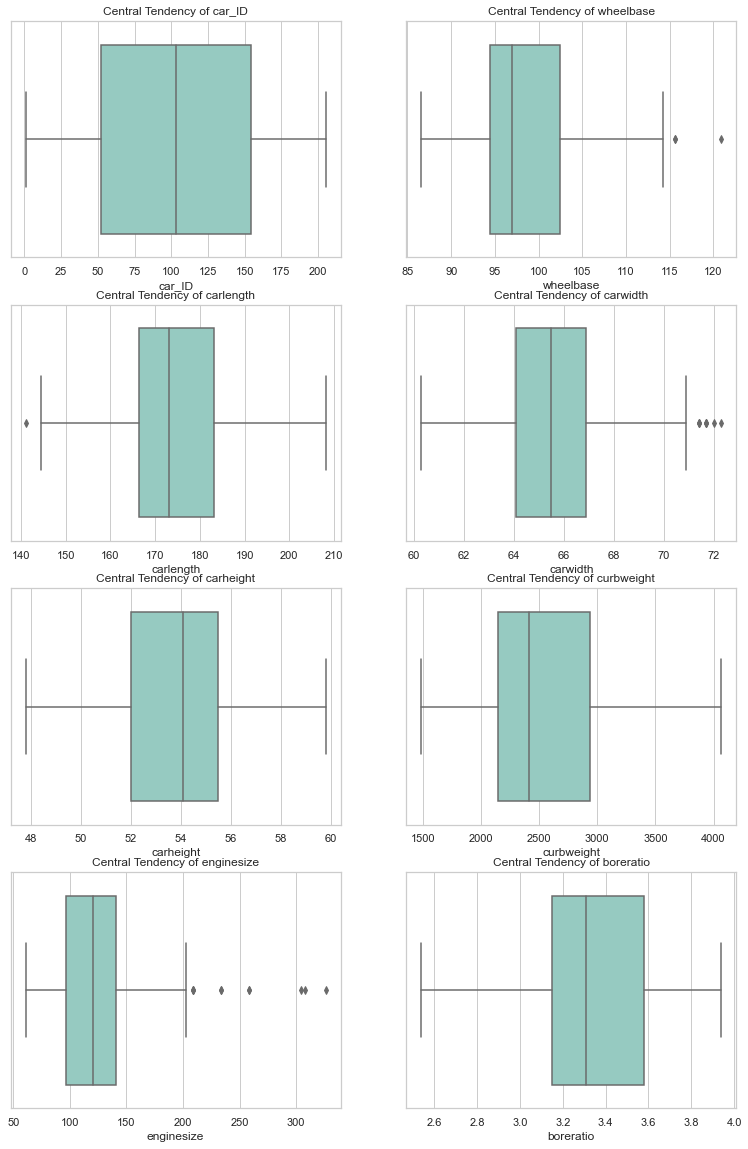

In [26]:
# m_box_plt is local function which takes a df, rows, columns of subplot and name of columns as an argument and 
# plots box plots
# Part-1
m_box_plt(c_df,4,2,*list(c_num_li[0:8]))

* __Observation:__
  1. __Car width and enginesize has data over 95th percentile and car length has data below 5th percentile__
  2. __The width and enginesize of the car can be extreme in sports cars or luxirious cars and hence I dont consider them as outliers__
  3. __As our customer Geely Auto would like to have the price prediction of the car based on competitors and as we exactly do not know how Geely would like to introduce premium range of cars or low range of cars, I would keep the data as it is to get the best predictable model__

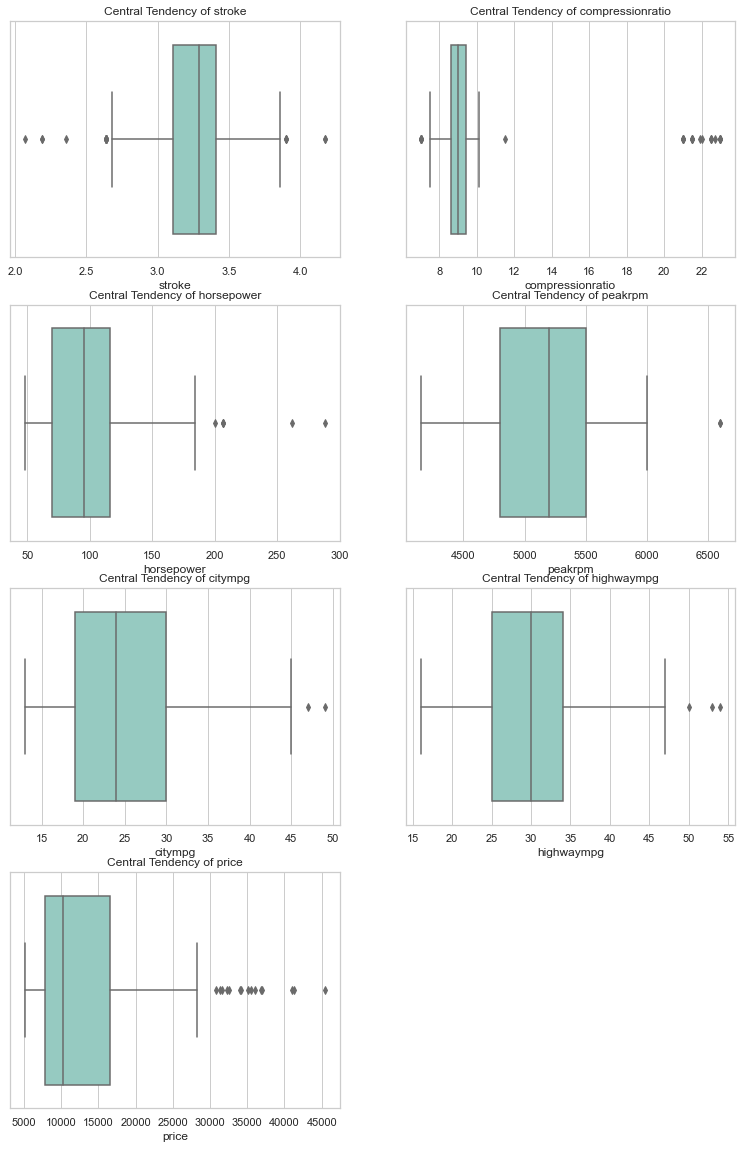

In [27]:
# Part-2
m_box_plt(c_df,4,2,*list(c_num_li[8:]))

* __Observation:__
  1. __Features 'stroke','compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price' have data spreading above 95th percentile and stroke and compressionratio have data below 5th percentile.__
  2. __The data here is one of the charactersistic of the car and can be extreme in sports cars or luxirious cars or very low in economical cars.Hence I dont consider them as outliers__
  3. __As our customer Geely Auto would like to have the price prediction of the car based on competitors and as we exactly do not know how Geely would like to introduce premium range of cars or low range of cars, I would keep the data as it is to get the best predictable model__

#### Data Preparation

In [28]:
# Inspect the categorical variables in c_df
c_df[c_cat_li].head()

symboling                   CarName fueltype aspiration doornumber  \
0         3        alfa-romero giulia      gas        std        two   
1         3       alfa-romero stelvio      gas        std        two   
2         1  alfa-romero Quadrifoglio      gas        std        two   
3         2               audi 100 ls      gas        std       four   
4         2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation enginetype cylindernumber fuelsystem  
0  convertible        rwd          front       dohc           four       mpfi  
1  convertible        rwd          front       dohc           four       mpfi  
2    hatchback        rwd          front       ohcv            six       mpfi  
3        sedan        fwd          front        ohc           four       mpfi  
4        sedan        4wd          front        ohc           five       mpfi

* In the given data, CarName has 2 components. Make of the car and model of the car. This makes it unique variable and we need
to split the data into 2 components. Make of the Car and Model of the car separately.

In [29]:
# Derive brand of the car and name of the car
c_df[["company","model"]]= c_df["CarName"].apply(lambda x: pd.Series(x.split(" ",1)))

In [30]:
# Inspect the company and model of the car
display(c_df.company.unique())
display(c_df.model.unique())

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

array(['giulia', 'stelvio', 'Quadrifoglio', '100 ls', '100ls', 'fox',
       '5000', '4000', '5000s (diesel)', '320i', 'x1', 'x3', 'z4', 'x4',
       'x5', 'impala', 'monte carlo', 'vega 2300', 'rampage',
       'challenger se', 'd200', 'monaco (sw)', 'colt hardtop',
       'colt (sw)', 'coronet custom', 'dart custom',
       'coronet custom (sw)', 'civic', 'civic cvcc', 'accord cvcc',
       'accord lx', 'civic 1500 gl', 'accord', 'civic 1300', 'prelude',
       'civic (auto)', 'MU-X', 'D-Max ', 'D-Max V-Cross', 'xj', 'xf',
       'xk', 'rx3', 'glc deluxe', 'rx2 coupe', 'rx-4', '626', 'glc',
       'rx-7 gs', 'glc 4', 'glc custom l', 'glc custom',
       'electra 225 custom', 'century luxus (sw)', 'century', 'skyhawk',
       'opel isuzu deluxe', 'skylark', 'century special',
       'regal sport coupe (turbo)', 'cougar', 'mirage', 'lancer',
       'outlander', 'g4', 'mirage g4', 'montero', 'pajero', 'versa',
       'gt-r', 'rogue', 'latio', 'titan', 'leaf', 'juke', 'note',
       'cli

In [31]:
# Remove spaces in the model name and replace it with _
c_df["model"] = c_df.model.apply(lambda x: re.sub(r"\W+","_",str(x)))
c_df["model"] = c_df.model.apply(lambda x: x.rstrip('_'))

In [32]:
# Inspect the DF 
display(c_df.model.unique())
c_df.head()

array(['giulia', 'stelvio', 'Quadrifoglio', '100_ls', '100ls', 'fox',
       '5000', '4000', '5000s_diesel', '320i', 'x1', 'x3', 'z4', 'x4',
       'x5', 'impala', 'monte_carlo', 'vega_2300', 'rampage',
       'challenger_se', 'd200', 'monaco_sw', 'colt_hardtop', 'colt_sw',
       'coronet_custom', 'dart_custom', 'coronet_custom_sw', 'civic',
       'civic_cvcc', 'accord_cvcc', 'accord_lx', 'civic_1500_gl',
       'accord', 'civic_1300', 'prelude', 'civic_auto', 'MU_X', 'D_Max',
       'D_Max_V_Cross', 'xj', 'xf', 'xk', 'rx3', 'glc_deluxe',
       'rx2_coupe', 'rx_4', '626', 'glc', 'rx_7_gs', 'glc_4',
       'glc_custom_l', 'glc_custom', 'electra_225_custom',
       'century_luxus_sw', 'century', 'skyhawk', 'opel_isuzu_deluxe',
       'skylark', 'century_special', 'regal_sport_coupe_turbo', 'cougar',
       'mirage', 'lancer', 'outlander', 'g4', 'mirage_g4', 'montero',
       'pajero', 'versa', 'gt_r', 'rogue', 'latio', 'titan', 'leaf',
       'juke', 'note', 'clipper', 'nv200', 'dayz'

car_ID symboling                   CarName fueltype aspiration doornumber  \
0       1         3        alfa-romero giulia      gas        std        two   
1       2         3       alfa-romero stelvio      gas        std        two   
2       3         1  alfa-romero Quadrifoglio      gas        std        two   
3       4         2               audi 100 ls      gas        std       four   
4       5         2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  carlength  carwidth  \
0  convertible        rwd          front       88.6      168.8      64.1   
1  convertible        rwd          front       88.6      168.8      64.1   
2    hatchback        rwd          front       94.5      171.2      65.5   
3        sedan        fwd          front       99.8      176.6      66.2   
4        sedan        4wd          front       99.4      176.6      66.4   

   carheight  curbweight enginetype cylindernumber  enginesize fuelsystem  \
0       48.8        2548       dohc           four         130       mpfi   
1       48.8        2548       dohc           four         130       mpfi   
2       52.4        2823       ohcv            six         152       mpfi   
3       54.3        2337        ohc           four         109       mpfi   
4       54.3        2824        ohc           five         136       mpfi   

   boreratio  stroke  compressionratio  horsepower  peakrpm  citympg  \
0       3.47    2.68               9.0         111     5000       21   
1       3.47    2.68               9.0         111     5000       21   
2       2.68    3.47               9.0         154     5000       19   
3       3.19    3.40              10.0         102     5500       24   
4       3.19    3.40               8.0         115     5500       18   

   highwaympg    price      company         model  
0          27  13495.0  alfa-romero        giulia  
1          27  16500.0  alfa-romero       stelvio  
2          26  16500.0  alfa-romero  Quadrifoglio  
3          30  13950.0         audi        100_ls  
4          22  17450.0         audi         100ls

* As we have derived features from CarName as company and model, we can drop the CarName from the data frame.
* In addition, car_ID and model are unique identifiers and they can be dropped aswell from the data frame. It might not add
any benefit for prediction of the price.

In [33]:
# drop the columns CarName, car_ID and model
c_df = c_df.drop(["model","car_ID","CarName"],axis=1)
display(c_df)

symboling fueltype aspiration doornumber      carbody drivewheel  \
0           3      gas        std        two  convertible        rwd   
1           3      gas        std        two  convertible        rwd   
2           1      gas        std        two    hatchback        rwd   
3           2      gas        std       four        sedan        fwd   
4           2      gas        std       four        sedan        4wd   
..        ...      ...        ...        ...          ...        ...   
200        -1      gas        std       four        sedan        rwd   
201        -1      gas      turbo       four        sedan        rwd   
202        -1      gas        std       four        sedan        rwd   
203        -1   diesel      turbo       four        sedan        rwd   
204        -1      gas      turbo       four        sedan        rwd   

    enginelocation  wheelbase  carlength  carwidth  carheight  curbweight  \
0            front       88.6      168.8      64.1       48.8        2548   
1            front       88.6      168.8      64.1       48.8        2548   
2            front       94.5      171.2      65.5       52.4        2823   
3            front       99.8      176.6      66.2       54.3        2337   
4            front       99.4      176.6      66.4       54.3        2824   
..             ...        ...        ...       ...        ...         ...   
200          front      109.1      188.8      68.9       55.5        2952   
201          front      109.1      188.8      68.8       55.5        3049   
202          front      109.1      188.8      68.9       55.5        3012   
203          front      109.1      188.8      68.9       55.5        3217   
204          front      109.1      188.8      68.9       55.5        3062   

    enginetype cylindernumber  enginesize fuelsystem  boreratio  stroke  \
0         dohc           four         130       mpfi       3.47    2.68   
1         dohc           four         130       mpfi       3.47    2.68   
2         ohcv            six         152       mpfi       2.68    3.47   
3          ohc           four         109       mpfi       3.19    3.40   
4          ohc           five         136       mpfi       3.19    3.40   
..         ...            ...         ...        ...        ...     ...   
200        ohc           four         141       mpfi       3.78    3.15   
201        ohc           four         141       mpfi       3.78    3.15   
202       ohcv            six         173       mpfi       3.58    2.87   
203        ohc            six         145        idi       3.01    3.40   
204        ohc           four         141       mpfi       3.78    3.15   

     compressionratio  horsepower  peakrpm  citympg  highwaympg    price  \
0                 9.0         111     5000       21          27  13495.0   
1                 9.0         111     5000       21          27  16500.0   
2                 9.0         154     5000       19          26  16500.0   
3                10.0         102     5500       24          30  13950.0   
4                 8.0         115     5500       18          22  17450.0   
..                ...         ...      ...      ...         ...      ...   
200               9.5         114     5400       23          28  16845.0   
201               8.7         160     5300       19          25  19045.0   
202               8.8         134     5500       18          23  21485.0   
203              23.0         106     4800       26          27  22470.0   
204               9.5         114     5400       19          25  22625.0   

         company  
0    alfa-romero  
1    alfa-romero  
2    alfa-romero  
3           audi  
4           audi  
..           ...  
200        volvo  
201        volvo  
202        volvo  
203        volvo  
204        volvo  

[205 rows x 25 columns]

In [34]:
# Update the list of numerical and categorical variables for future analysis
c_num_li = list(c_df.select_dtypes(include=np.number).columns)
c_cat_li = list(c_df.select_dtypes(exclude=np.number).columns)
print(c_num_li,c_cat_li)

['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price'] ['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'company']


## Univariate analysis

### Univariate Analysis of Categorical Variables

In [35]:
# Inspect list of categorical variables
print(c_cat_li) 

['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'company']


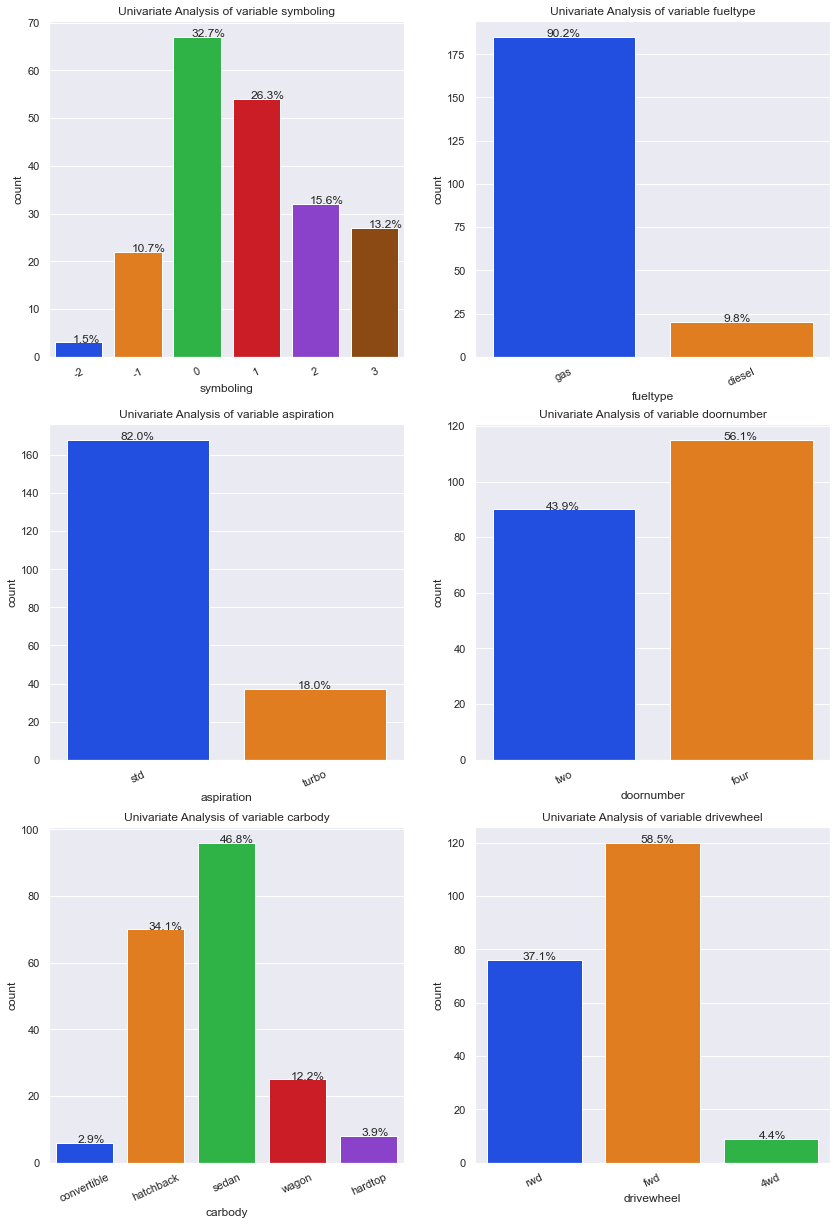

In [36]:
# cnt_plt is local function which takes a df, rows, columns of subplot and name of columns as an argument and 
# plots frequency  plots
# Part-1
cnt_plt(c_df,3,2,*c_cat_li[0:6])

__Inferences__
1. Symboling _ Insurance risk rating. 55% of the cars are risky, only 12% of the cars and only close to 33% of the cars are either.
2. 90% of the cars offerred by companies are Gas cars.
3. 82% of the cars offerred by companies are Aspiration with Std and remaining are with Turbo
4. 57% of the cars offerred by companies are with four doors and two remaining
5. Close to 47% of the sedan cars offerred by companies and 34% of the cars are hatchback
6. 59% of the cars offerred by companies are with front wheel drive, 37% rear wheel drive and the remaining is four wheel drive.

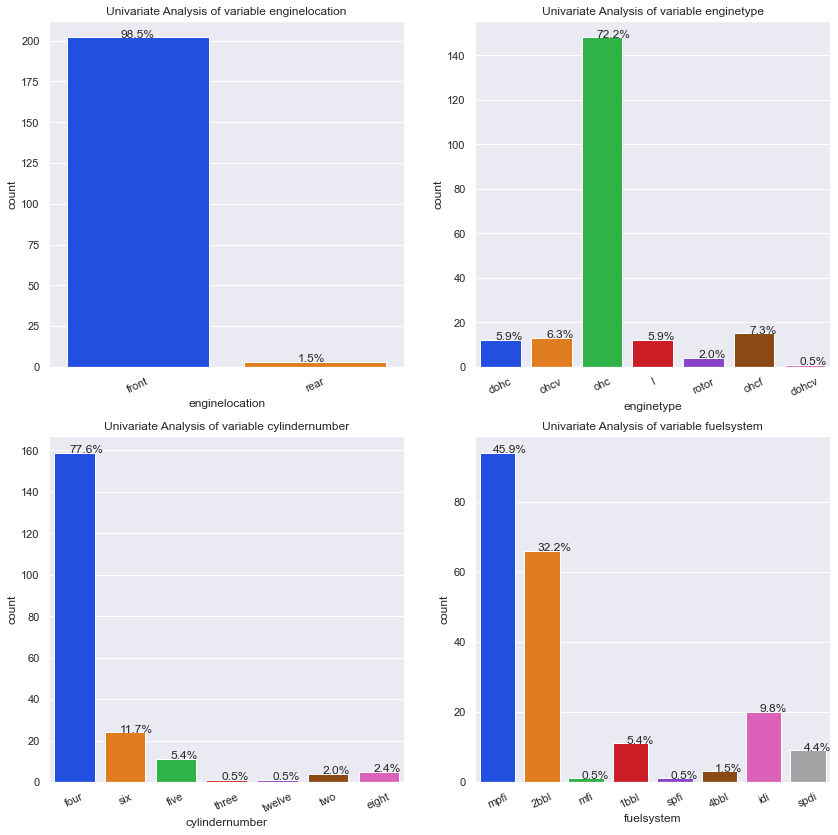

In [37]:
# Part 2
cnt_plt(c_df,2,2,*c_cat_li[6:10])

__Inferences__
1. 98.5% of the cars offerred by companies are having engine location in the front. The 1.5% of the cars offerred by companies are haing engine location in the back.
2. 72% of the cars offerred by companies are with engine type ohc.
3. 77.6% of the cars offerred by companies are with cylinder number with four (as they are most economical).
4. 46% of the cars offerred by companies are with fuel system with mpfi and 32% are with fuel system with 32.2%.

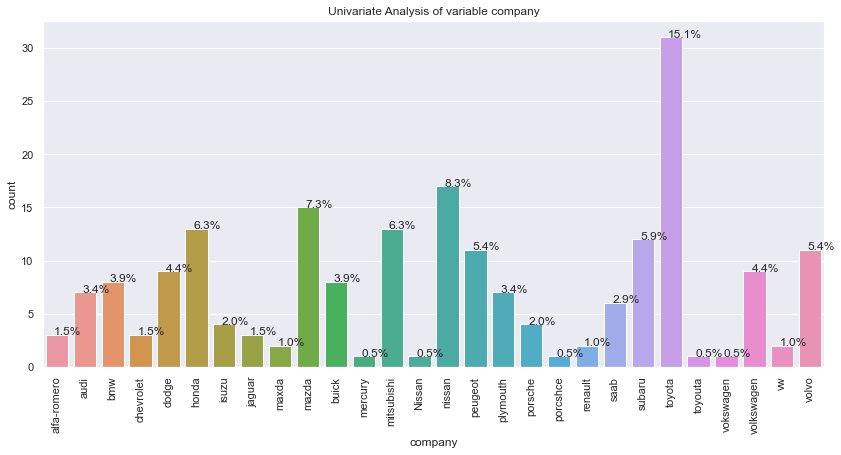

In [38]:
# Part 3
cnt_plt(c_df,2,1,c_cat_li[10])

__Observations__
   1. It has been observed that there are some typo in the company names and this should be renamed
   2. maxda should be renamed to mazda
   3. porcshce or prosche should be renamed to porsche
   4. vokswagen and vw should be renamed to volkswagen
   5. toyouta should be renamed to toyota

In [39]:
# local function to replace the name of the company due to typo 
def re_comp(x):
    if x == "maxda":
        return "mazda"
    elif x == "porcshce" or x == "prosche":
        return "porsche"
    elif x == "vokswagen" or x == "vw":
        return "volkswagen"
    elif x == "toyouta":
        return "toyota"
    else:
        return x

# replace the name of the company due to typo 
c_df["company"] = c_df.company.apply(re_comp)

# Change the company name to style title
c_df["company"] = c_df.company.apply(lambda x: x.title())

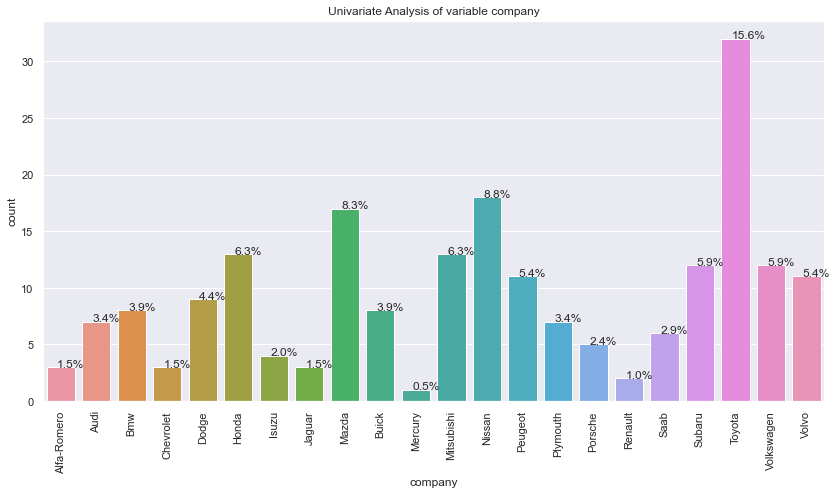

In [40]:
# Inspect the car company using frequency plots
cnt_plt(c_df,1,1,c_cat_li[10])

__Inferences__
1. Toyota has 15.6% of the cars in the current data set.
2. Nissan, Mazda, Honda and Mitsubishi have close to 6 to 8% of the cars in the current data set. 
3. Remaining is distributed with Mercury offerring only 1 in the data set.

### Univariate analysis of numerical variables

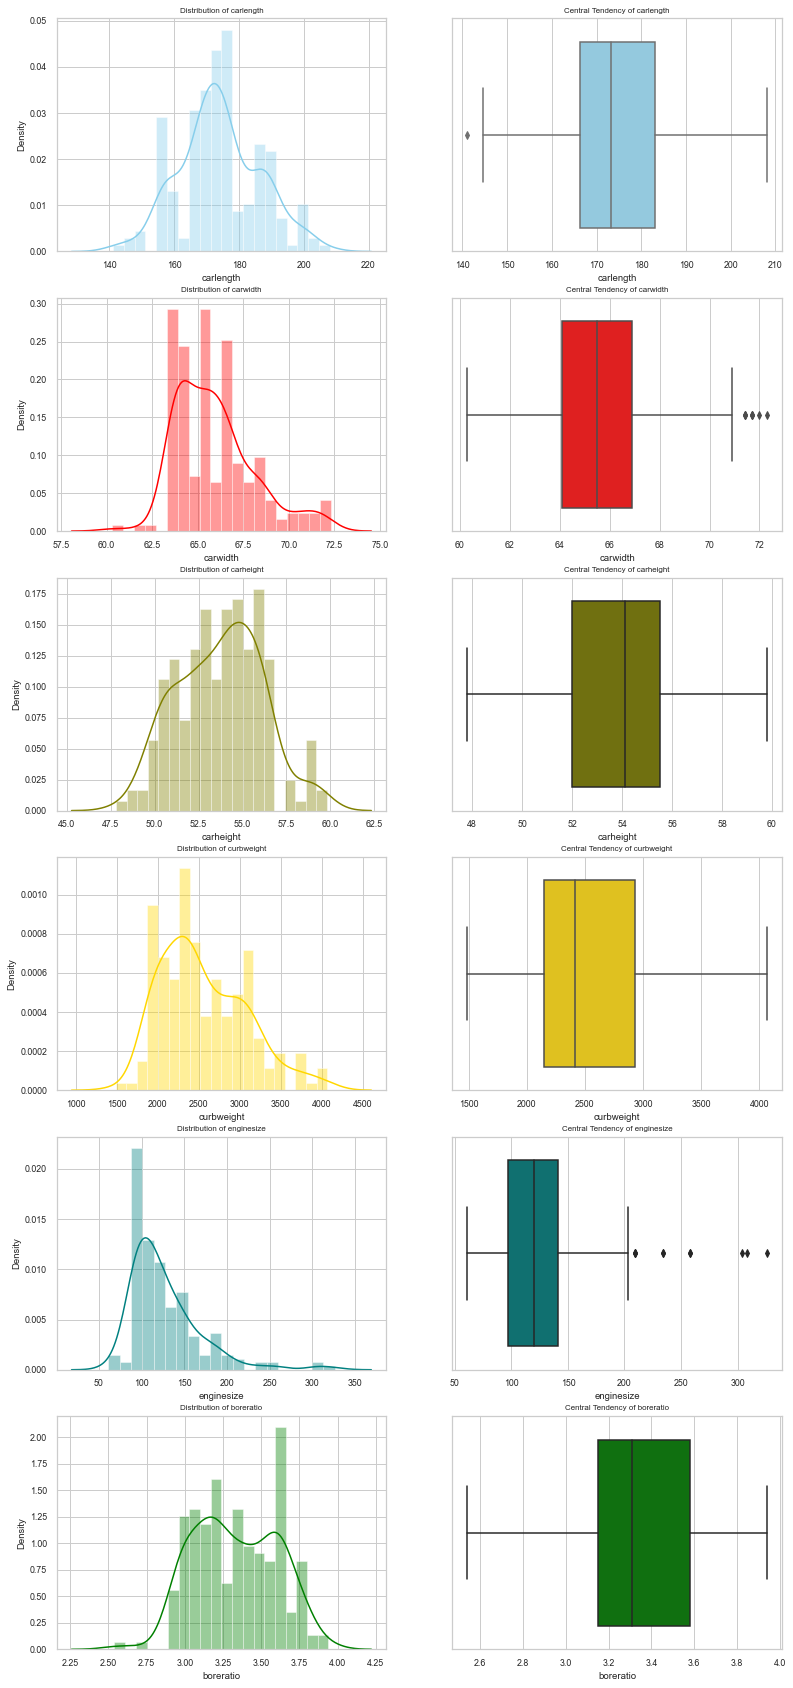

In [42]:
# dist_plt is local function which takes a df, rows, columns of subplot and name of columns as an argument and 
# plots distribution plots
# Part-1
dist_plt(c_df,6,2,*c_num_li[1:7])

__Inferences__
1. Car length is distributed normally with peak at the center
2. Car width and enginesize are right skewed
3. car length and boreratio are left skewed

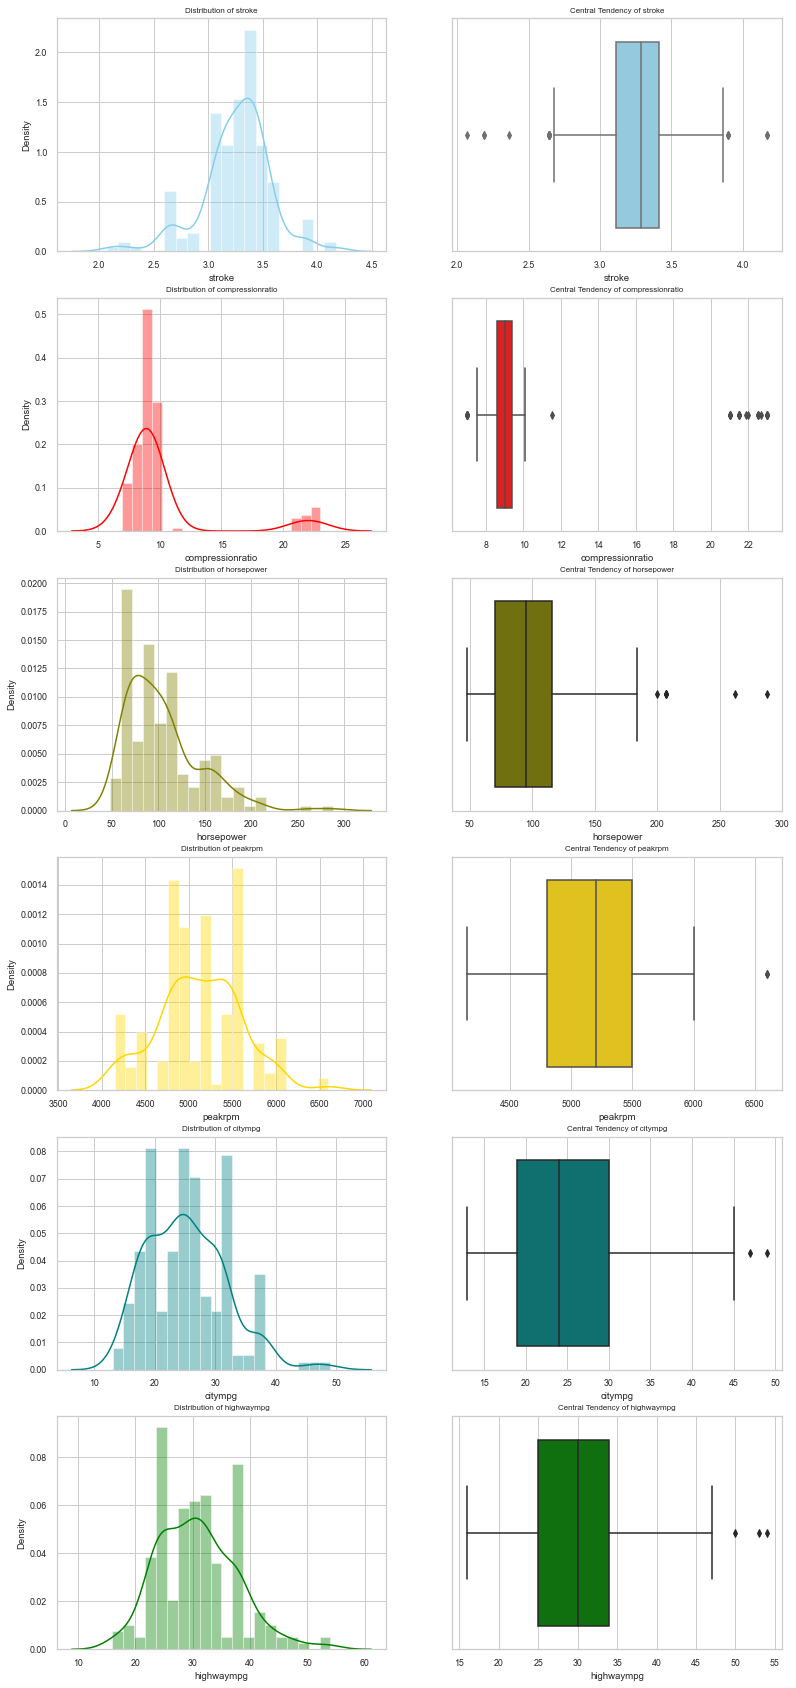

In [43]:
# Part-2
dist_plt(c_df,6,2,*list(c_num_li[7:13]))

__Inferences__
1. highwaympg,peakrpm and citympg is distributed normally
2. compressionratio and horsepower are normally distributed and right skewed
3. car length and boreratio are left skewed

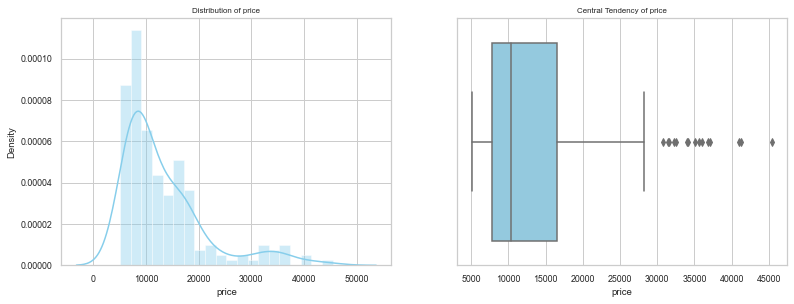

In [44]:
# Part-2
dist_plt(c_df,2,2,*list(c_num_li[13:]))

__Inferences__
1. Target variable "Price", is right skewed and the most of the cars price is starting from 5000 till 18000. Probably this is because of them are targeting the economical and availability of the market for these range of cars.

### Correlation of the numerical variables

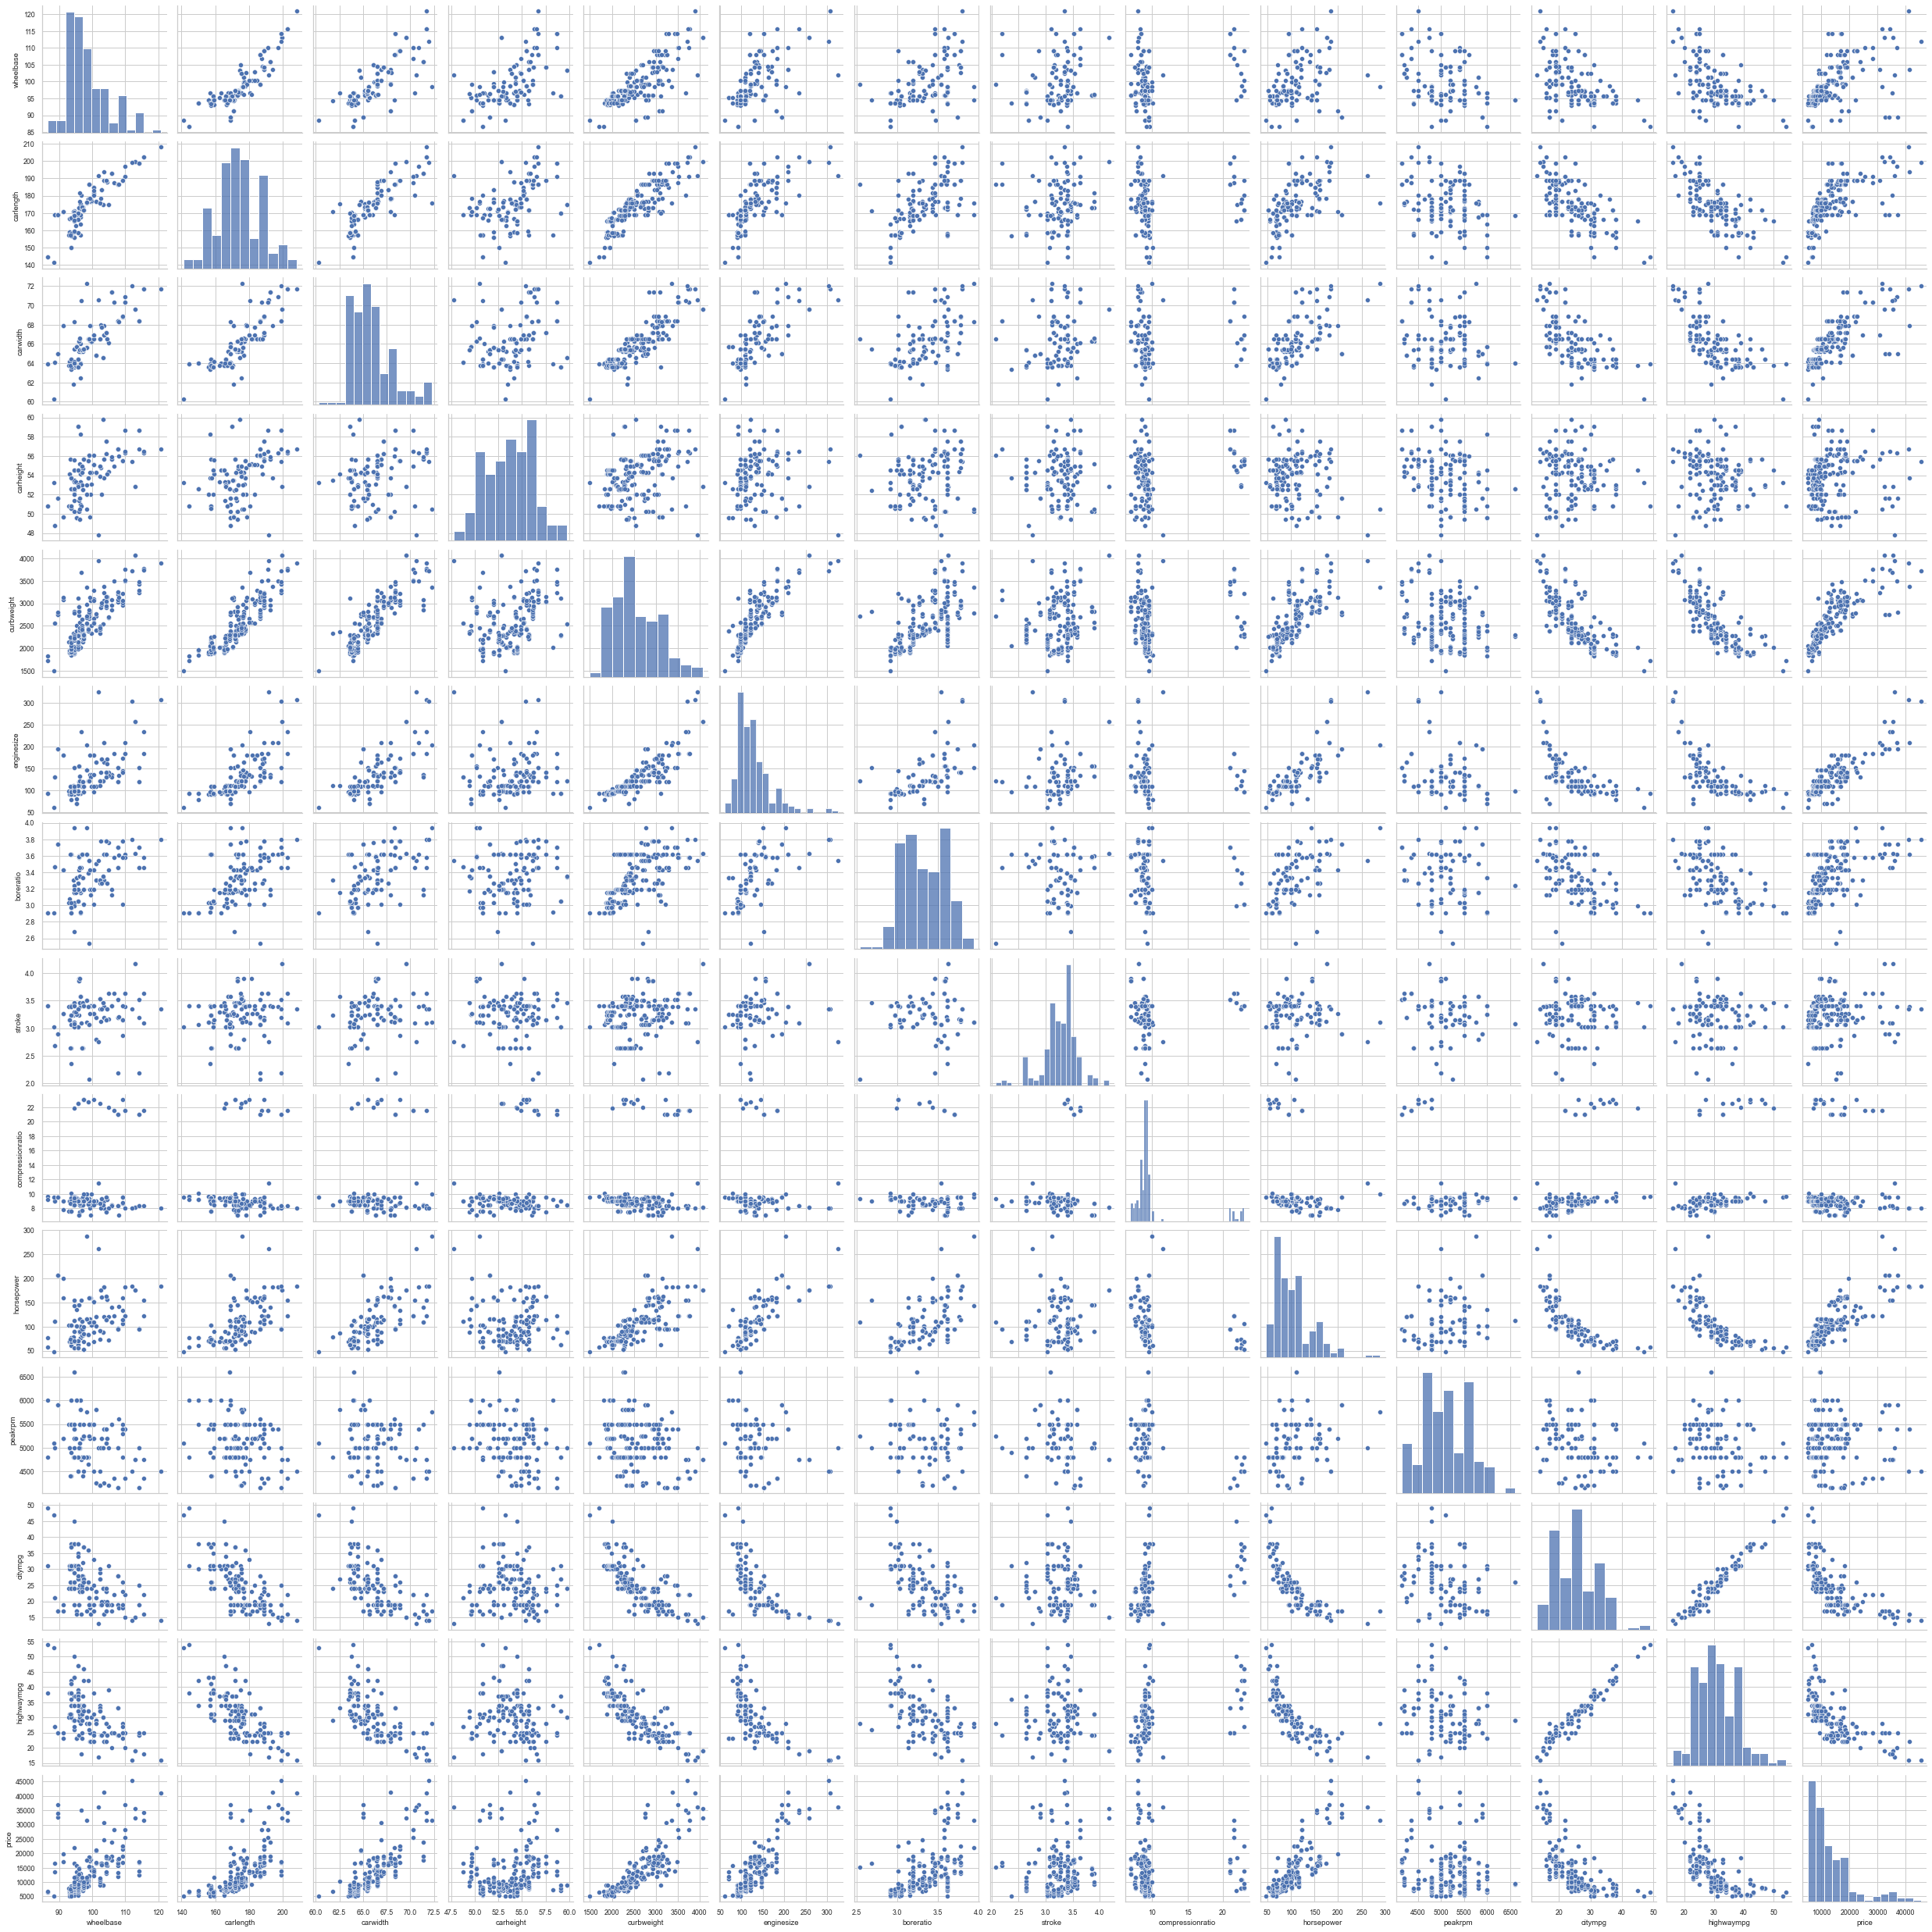

In [45]:
sns.pairplot(c_df)
plt.show()

__Inferences__
1. Target variable "Price", has very strong +ve correlations with carlength, carwidth, curbweight, enginesize, horsepower. 
2. Target variable "Price", has very strong -ve correlations with citympg and higwaympg.
3. Target variable "Price" do not have dependency wrt compressionratio, stroke and peakrpm

### Correlation of the categorical variables with respect to Target variable "Price"

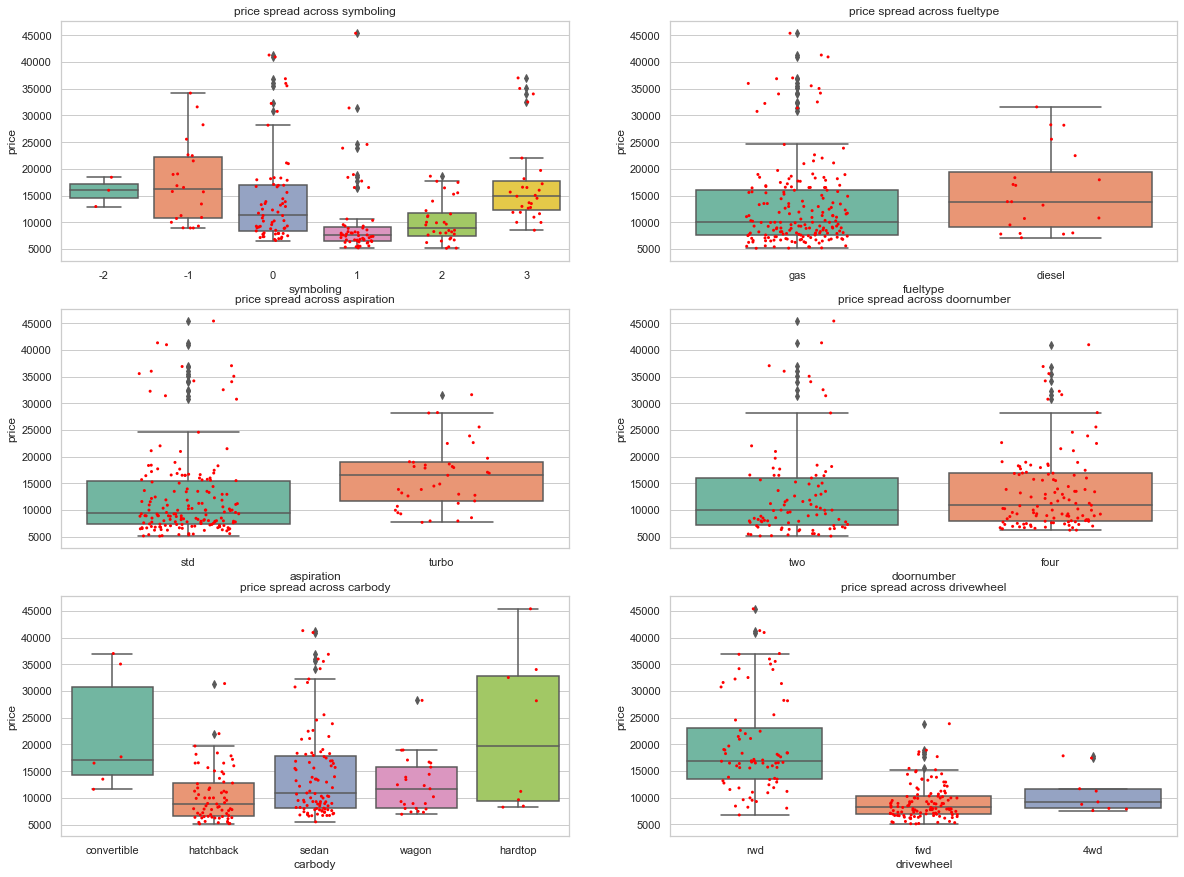

In [32]:
# comp_box_plt is local function which takes a df,target column, rows, columns of subplot and name of columns as an argument and 
# plots box plots
# correlation of price with other categorical variables
# Part-I
comp_box_plt(c_df,3,2,"price",*c_cat_li[0:6])

__Inferences__
1. Symboling Insurance risk rating. The median price of the risky cars is very low compared to non risky cars. The reason is obvious due to security features in the cars with insurance rating of non risky. __It is clear that adding securiy features increases the price__.
2. The median of gas cars is comparitvely low wrt diesel. Most of the  offerrings by car companies is is with gas, we cant conclude that diesel or gas might add to price of the car.
3. Cars with Aspiration - Turbo starts with the price median of the Aspiration std. So it is one of the clear indication that cars with aspiration turbo increases the price. Cars with aspiration std has varied price spread from 5000 till 45000 with mean being at 8000. 
4. Cars with Doornumber two and four have very close price median and spread. __So we can conclude that they dont influence much on the price__
5. Cars with convertible and hardtop have higher price median compared to hatchback, sedan and wagon. Hatchback has lowest price median and sedan and wagon have average price median.
6. It is very interesting to note that rear wheen drive has much higher price median compared to forward dn 4 wheen drives. So Rear wheel drive pushes the price of the car to higher range and forward and four wheel drive reduces the price of the car.

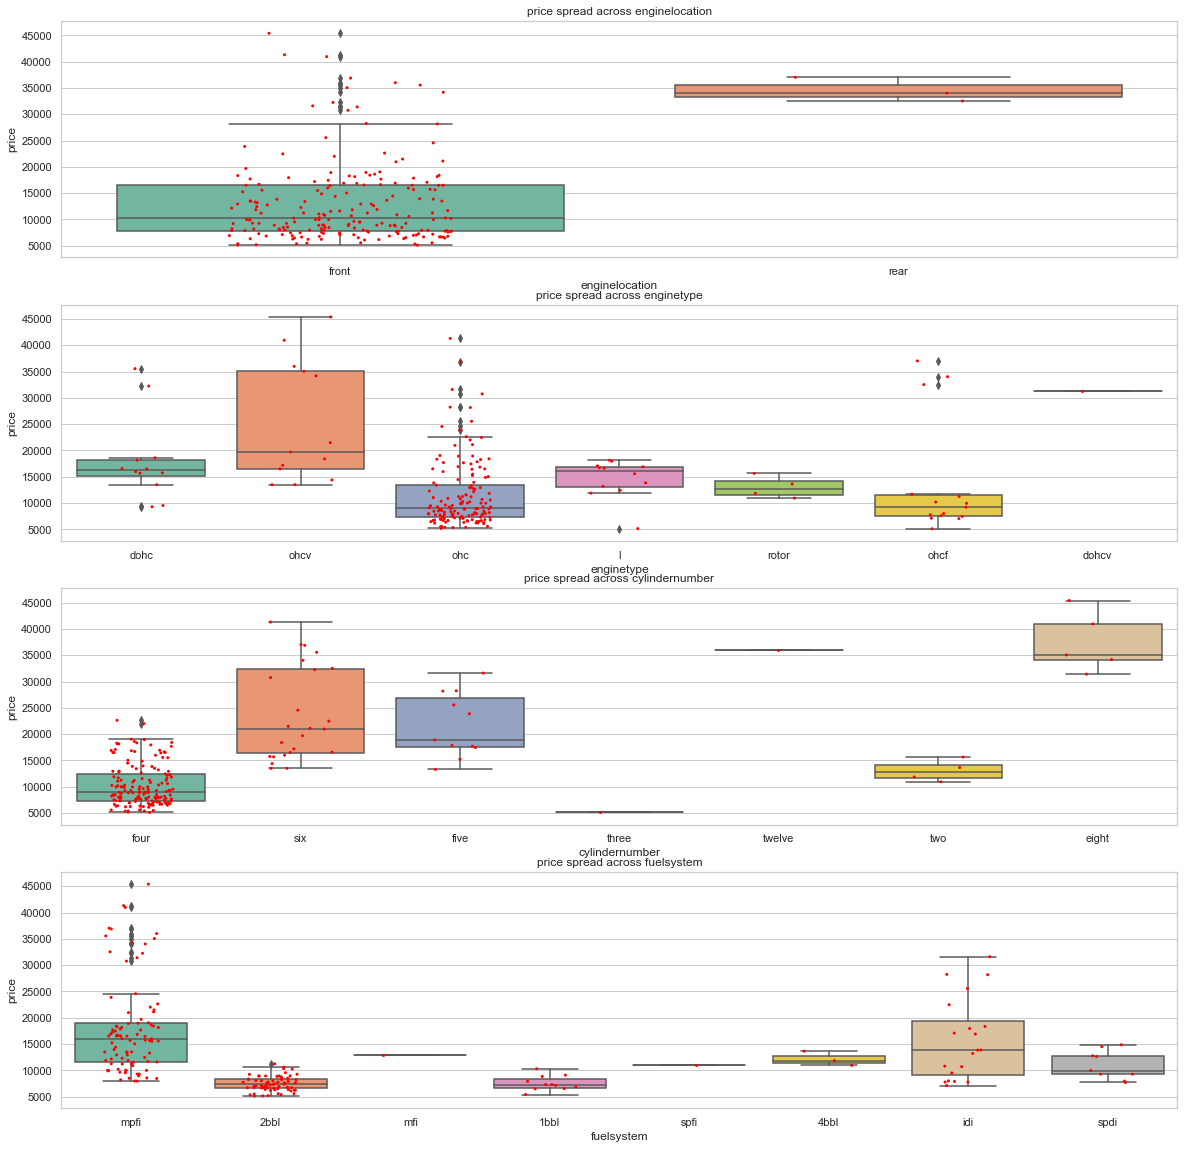

In [33]:
# Part-II
comp_box_plt(c_df,4,1,"price",*c_cat_li[6:10])

__Inferences__
1. Cars having rear engine has very high price range while front engine cars price ranges from 5000 to 45000. __This is clear indication that rear engine cars are much costlier than front engine cars__
2. Median of cars having engine type OHCV, is higher compared to all the others. Cars having engine type OHC and OHFC have median very less compared to others.
3. Cars having higher cylinder numbers cost higher and lower cylinder numbers costs less. However there is a exception from two and three cylinders. ___There is a clear linear correlation between price and cars having four cylinders till Twelve cylinders. The median price increases linearly across cars having four, give, six, eight and twelve.___
4. There is no much difference in median price among cars having different fuel system. So this clearly would not influence the price.

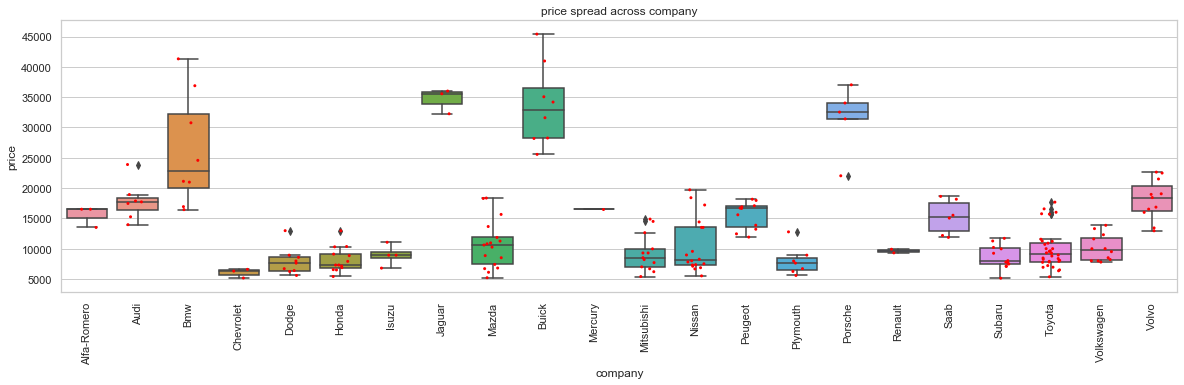

In [34]:
# Part-III
comp_box_plt(c_df,1,1,"price",c_cat_li[10])

__Inferences__
Based on the median of the price, I segment the cars into following categories
   *  __High Premium Cars__ Jaguar, Buick and Porsche fall under this category
   *  __Premium Cars__ BMW falls under this category. BMW offers cars price range starting from 17000 till 42000.
   *  __Mid Range Cars__ Audi, Alfa-Romero, Mercury,Pegeot, Saab and Volvo offers Mid range cars
   *  __Low Economical Cars__ Chevrolet, Dodge, Honda, Isuzu, Mazda, Mitsubishi, Nissan, Plymouth, Renault, Subaru, Toyota and Volkswagen offers low economical range of cars. The low segment is crowded and probably due to the high number of sales.

## Preparing the data for modelling(train-test split, rescaling etc)

### Encoding of Categorical variables

In [35]:
# Inspect the categorical variables
c_df[c_cat_li].head()

symboling fueltype aspiration doornumber      carbody drivewheel  \
0         3      gas        std        two  convertible        rwd   
1         3      gas        std        two  convertible        rwd   
2         1      gas        std        two    hatchback        rwd   
3         2      gas        std       four        sedan        fwd   
4         2      gas        std       four        sedan        4wd   

  enginelocation enginetype cylindernumber fuelsystem      company  
0          front       dohc           four       mpfi  Alfa-Romero  
1          front       dohc           four       mpfi  Alfa-Romero  
2          front       ohcv            six       mpfi  Alfa-Romero  
3          front        ohc           four       mpfi         Audi  
4          front        ohc           five       mpfi         Audi

In [36]:
# Inspect no of lables in each of the categorical column
display({col.title():len(c_df[col].unique()) for col in c_df[c_cat_li].columns}) 

{'Symboling': 6,
 'Fueltype': 2,
 'Aspiration': 2,
 'Doornumber': 2,
 'Carbody': 5,
 'Drivewheel': 3,
 'Enginelocation': 2,
 'Enginetype': 7,
 'Cylindernumber': 7,
 'Fuelsystem': 8,
 'Company': 22}

In [37]:
# Inspect no of lables in each of the categorical column
display({col.title():list(c_df[col].value_counts().index) for col in c_df[c_cat_li].columns}) 

{'Symboling': [0, 1, 2, 3, -1, -2],
 'Fueltype': ['gas', 'diesel'],
 'Aspiration': ['std', 'turbo'],
 'Doornumber': ['four', 'two'],
 'Carbody': ['sedan', 'hatchback', 'wagon', 'hardtop', 'convertible'],
 'Drivewheel': ['fwd', 'rwd', '4wd'],
 'Enginelocation': ['front', 'rear'],
 'Enginetype': ['ohc', 'ohcf', 'ohcv', 'dohc', 'l', 'rotor', 'dohcv'],
 'Cylindernumber': ['four', 'six', 'five', 'eight', 'two', 'twelve', 'three'],
 'Fuelsystem': ['mpfi', '2bbl', 'idi', '1bbl', 'spdi', '4bbl', 'mfi', 'spfi'],
 'Company': ['Toyota',
  'Nissan',
  'Mazda',
  'Mitsubishi',
  'Honda',
  'Volkswagen',
  'Subaru',
  'Volvo',
  'Peugeot',
  'Dodge',
  'Bmw',
  'Buick',
  'Audi',
  'Plymouth',
  'Saab',
  'Porsche',
  'Isuzu',
  'Chevrolet',
  'Alfa-Romero',
  'Jaguar',
  'Renault',
  'Mercury']}

__Segragation__
   -  __Ordinal Categorical Variables__ - symboling and cylindernumber are ordinals and I plan to use sklearn.preprocessing.OrdinalEncoder for Encoding.
   -  __Binary Categorical Variables__ - doornumber, fueltype, aspiration and enginelocation have only 2 unique values and I will use Binary Encoding.
   -  __OneHot Encoding__ - For remaining categorical variables, 'carbody', 'drivewheel', 'enginetype', 'fuelsystem', 'company' , I plan to use sklearn.preprocessing.OneHotEncoder for encdoing.

#### Encoding of Ordinals - Ordinal Encoding

In [38]:
# Encoding of Ordinals
c_df["doornumber"] = c_df["doornumber"].map({'two':0,'four':1})
c_df["cylindernumber"] = c_df["cylindernumber"].map({'four':2, 'six':4, 'two':0, 'five':3, 'eight':5, 'three':1, 'twelve':6})
c_df["symboling"] = c_df["symboling"].map({ 1:3,  3:5, -1:1,  0:2,  2:4, -2:0})

#### Encoding of Nominals - Binary Encoding

In [39]:
# Encoding of Nominals - Binary encoding
c_df["fueltype"] = c_df["fueltype"].map({'gas':0,'diesel':1})
c_df["aspiration"] = c_df["aspiration"].map({'std':0,'turbo':1})
c_df["enginelocation"] = c_df["enginelocation"].map({'front':0,'rear':1})

#### Encoding of Ordinals - OneHot Encoding

In [40]:
# Encoding of Nominals - OneHot Encoding
oht_li = [x for x in list(c_cat_li) if x not in ["doornumber","cylindernumber","fueltype","aspiration","enginelocation","symboling"]]

c_df = pd.concat([c_df,pd.get_dummies(c_df[oht_li],prefix=oht_li, drop_first=True)],axis=1)

In [41]:
# list of one hot encoded variables
display(oht_li)

#drop the variables
c_df.drop(oht_li,axis=1,inplace=True)

#Inspect the df
c_df.head()

['carbody', 'drivewheel', 'enginetype', 'fuelsystem', 'company']

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
0         5         0           0           0               0       88.6   
1         5         0           0           0               0       88.6   
2         3         0           0           0               0       94.5   
3         4         0           0           1               0       99.8   
4         4         0           0           1               0       99.4   

   carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
0      168.8      64.1       48.8        2548               2         130   
1      168.8      64.1       48.8        2548               2         130   
2      171.2      65.5       52.4        2823               4         152   
3      176.6      66.2       54.3        2337               2         109   
4      176.6      66.4       54.3        2824               3         136   

   boreratio  stroke  compressionratio  horsepower  peakrpm  citympg  \
0       3.47    2.68               9.0         111     5000       21   
1       3.47    2.68               9.0         111     5000       21   
2       2.68    3.47               9.0         154     5000       19   
3       3.19    3.40              10.0         102     5500       24   
4       3.19    3.40               8.0         115     5500       18   

   highwaympg    price  carbody_hardtop  carbody_hatchback  carbody_sedan  \
0          27  13495.0                0                  0              0   
1          27  16500.0                0                  0              0   
2          26  16500.0                0                  1              0   
3          30  13950.0                0                  0              1   
4          22  17450.0                0                  0              1   

   carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
0              0               0               1                 0   
1              0               0               1                 0   
2              0               0               1                 0   
3              0               1               0                 0   
4              0               0               0                 0   

   enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
0             0               0                0                0   
1             0               0                0                0   
2             0               0                0                1   
3             0               1                0                0   
4             0               1                0                0   

   enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
0                 0                0                0               0   
1                 0                0                0               0   
2                 0                0                0               0   
3                 0                0                0               0   
4                 0                0                0               0   

   fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
0               0                1                0                0   
1               0                1                0                0   
2               0                1                0                0   
3               0                1                0                0   
4               0                1                0                0   

   company_Audi  company_Bmw  company_Buick  company_Chevrolet  company_Dodge  \
0             0            0              0                  0              0   
1             0            0              0                  0              0   
2             0            0              0                  0              0   
3             1            0              0                  0              0   
4             1            0              0                  0           

### Splitting the data into train and test

In [42]:
df_train,df_test = train_test_split(c_df,train_size=0.70,random_state=100)
print(df_train.shape)
print(df_test.shape)

(143, 60)
(62, 60)


### Rescaling of the variables

__Rescaling the Features__

As we know, scaling doesn't impact your model. Here we can see that except , ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price', 'symboling', 'cylindernumber'] all the columns have small integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. As you know, there are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

__Approach__

My approach is to have 3 different models and see how the results vary and choose the best model. So I decide to use Standardization with 2 models and MinMaxScaler for other model.

1. LR M1 - Will have scaling using Standardisation
2. LR M2 - Will have scaling using MinMaxScaler
3. LR M3 - Will have scaling using Standardisation

In [43]:
# 3 Models are created and hence 3 copies of df_train and test to perform the analysis
m1_train = df_train.copy()
m2_train = df_train.copy()
m3_train = df_train.copy()

m1_test = df_test.copy()
m2_test = df_test.copy()
m3_test = df_test.copy()

In [44]:
# List of features that need to be scaled
# add 2 other columns to c_num_li
scl_li = list(c_num_li)+["symboling","cylindernumber"]
print(scl_li)

['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price', 'symboling', 'cylindernumber']


#### Scaling of LR M2 using MinMaxScaler

In [45]:
# This can be achieved using sklearn MinMaxScaler
# 1. Initiate an object
m2_scaler = MinMaxScaler()

# 2. Fit and transform on data
m2_train[scl_li] = m2_scaler.fit_transform(m2_train[scl_li])
display(m2_train.head())

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
122        0.6         0           0           1               0   0.244828   
125        1.0         0           0           0               0   0.272414   
166        0.6         0           0           0               0   0.272414   
1          1.0         0           0           0               0   0.068966   
199        0.2         0           1           1               0   0.610345   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
122   0.426016  0.291667   0.265487    0.272692        0.333333    0.139623   
125   0.452033  0.666667   0.212389    0.500388        0.333333    0.339623   
166   0.448780  0.308333   0.424779    0.314973        0.333333    0.139623   
1     0.450407  0.316667   0.088496    0.411171        0.333333    0.260377   
199   0.775610  0.575000   0.858407    0.647401        0.333333    0.260377   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
122   0.230159  0.525253           0.15000    0.083333  0.551020  0.500000   
125   1.000000  0.464646           0.15625    0.395833  0.551020  0.166667   
166   0.444444  0.449495           0.15000    0.266667  1.000000  0.361111   
1     0.626984  0.247475           0.12500    0.262500  0.346939  0.222222   
199   0.746032  0.484848           0.03125    0.475000  0.387755  0.111111   

     highwaympg     price  carbody_hardtop  carbody_hatchback  carbody_sedan  \
122    0.567568  0.068818                0                  0              1   
125    0.270270  0.466890                0                  1              0   
166    0.324324  0.122110                0                  1              0   
1      0.270270  0.314446                0                  0              0   
199    0.135135  0.382131                0                  0              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
122              0               1               0                 0   
125              0               0               1                 0   
166              0               0               1                 0   
1                0               0               1                 0   
199              1               0               1                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
122             0               1                0                0   
125             0               1                0                0   
166             0               0                0                0   
1               0               0                0                0   
199             0               1                0                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
122                 0                1                0               0   
125                 0                0                0               0   
166                 0                0                0               0   
1                   0                0                0               0   
199                 0                0                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
122               0                0                0                0   
125               0                1                0                0   
166               0                1                0                0   
1                 0                1                0                0   
199               0                1                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
122             0            0              0                  0   
125             0            0              0                  0   
166             0            0              0                  0   
1               0            0              0                  0   
199      

#### Scaling of LR Model 1 and Model 3 using Standardization

In [46]:
# This can be achieved using sklearn MinMaxScaler
# 1. Initiate an object
m13_scaler = StandardScaler()

# 2. Fit and transform on data
m1_train[scl_li] = m13_scaler.fit_transform(m1_train[scl_li])
m3_train[scl_li] = m13_scaler.fit_transform(m3_train[scl_li])

display(m1_train.head(),m3_train.head())

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
122   0.170159         0           0           1               0  -0.811836   
125   1.848278         0           0           0               0  -0.677177   
166   0.170159         0           0           0               0  -0.677177   
1     1.848278         0           0           0               0  -1.670284   
199  -1.507960         0           1           1               0   0.972390   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
122  -0.487238 -0.924500  -1.134628   -0.642128       -0.378724   -0.660242   
125  -0.359789  1.114978  -1.382026    0.439415       -0.378724    0.637806   
166  -0.375720 -0.833856  -0.392434   -0.441296       -0.378724   -0.660242   
1    -0.367754 -0.788535  -1.959288    0.015642       -0.378724    0.123485   
199   1.225364  0.616439   1.627983    1.137720       -0.378724    0.123485   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
122  -1.297329 -0.064443         -0.172569   -0.872898  0.771349  0.839773   
125   2.432256 -0.449757         -0.146125    1.021826  0.771349 -0.957048   
166  -0.259197 -0.546085         -0.172569    0.238673  3.064983  0.091098   
1     0.625138 -1.830463         -0.278345    0.213410 -0.271212 -0.657578   
199   1.201877 -0.321319         -0.675002    1.501822 -0.062699 -1.256518   

     highwaympg     price  carbody_hardtop  carbody_hatchback  carbody_sedan  \
122    1.025419 -0.700201                0                  0              1   
125   -0.557490  1.151929                0                  1              0   
166   -0.269688 -0.452248                0                  1              0   
1     -0.557490  0.442646                0                  0              0   
199   -1.276993  0.757569                0                  0              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
122              0               1               0                 0   
125              0               0               1                 0   
166              0               0               1                 0   
1                0               0               1                 0   
199              1               0               1                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
122             0               1                0                0   
125             0               1                0                0   
166             0               0                0                0   
1               0               0                0                0   
199             0               1                0                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
122                 0                1                0               0   
125                 0                0                0               0   
166                 0                0                0               0   
1                   0                0                0               0   
199                 0                0                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
122               0                0                0                0   
125               0                1                0                0   
166               0                1                0                0   
1                 0                1                0                0   
199               0                1                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
122             0            0              0                  0   
125             0            0              0                  0   
166             0            0              0                  0   
1               0            0              0                  0   
199      

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
122   0.170159         0           0           1               0  -0.811836   
125   1.848278         0           0           0               0  -0.677177   
166   0.170159         0           0           0               0  -0.677177   
1     1.848278         0           0           0               0  -1.670284   
199  -1.507960         0           1           1               0   0.972390   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
122  -0.487238 -0.924500  -1.134628   -0.642128       -0.378724   -0.660242   
125  -0.359789  1.114978  -1.382026    0.439415       -0.378724    0.637806   
166  -0.375720 -0.833856  -0.392434   -0.441296       -0.378724   -0.660242   
1    -0.367754 -0.788535  -1.959288    0.015642       -0.378724    0.123485   
199   1.225364  0.616439   1.627983    1.137720       -0.378724    0.123485   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
122  -1.297329 -0.064443         -0.172569   -0.872898  0.771349  0.839773   
125   2.432256 -0.449757         -0.146125    1.021826  0.771349 -0.957048   
166  -0.259197 -0.546085         -0.172569    0.238673  3.064983  0.091098   
1     0.625138 -1.830463         -0.278345    0.213410 -0.271212 -0.657578   
199   1.201877 -0.321319         -0.675002    1.501822 -0.062699 -1.256518   

     highwaympg     price  carbody_hardtop  carbody_hatchback  carbody_sedan  \
122    1.025419 -0.700201                0                  0              1   
125   -0.557490  1.151929                0                  1              0   
166   -0.269688 -0.452248                0                  1              0   
1     -0.557490  0.442646                0                  0              0   
199   -1.276993  0.757569                0                  0              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
122              0               1               0                 0   
125              0               0               1                 0   
166              0               0               1                 0   
1                0               0               1                 0   
199              1               0               1                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
122             0               1                0                0   
125             0               1                0                0   
166             0               0                0                0   
1               0               0                0                0   
199             0               1                0                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
122                 0                1                0               0   
125                 0                0                0               0   
166                 0                0                0               0   
1                   0                0                0               0   
199                 0                0                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
122               0                0                0                0   
125               0                1                0                0   
166               0                1                0                0   
1                 0                1                0                0   
199               0                1                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
122             0            0              0                  0   
125             0            0              0                  0   
166             0            0              0                  0   
1               0            0              0                  0   
199      

### Correlations of the variables after encoding

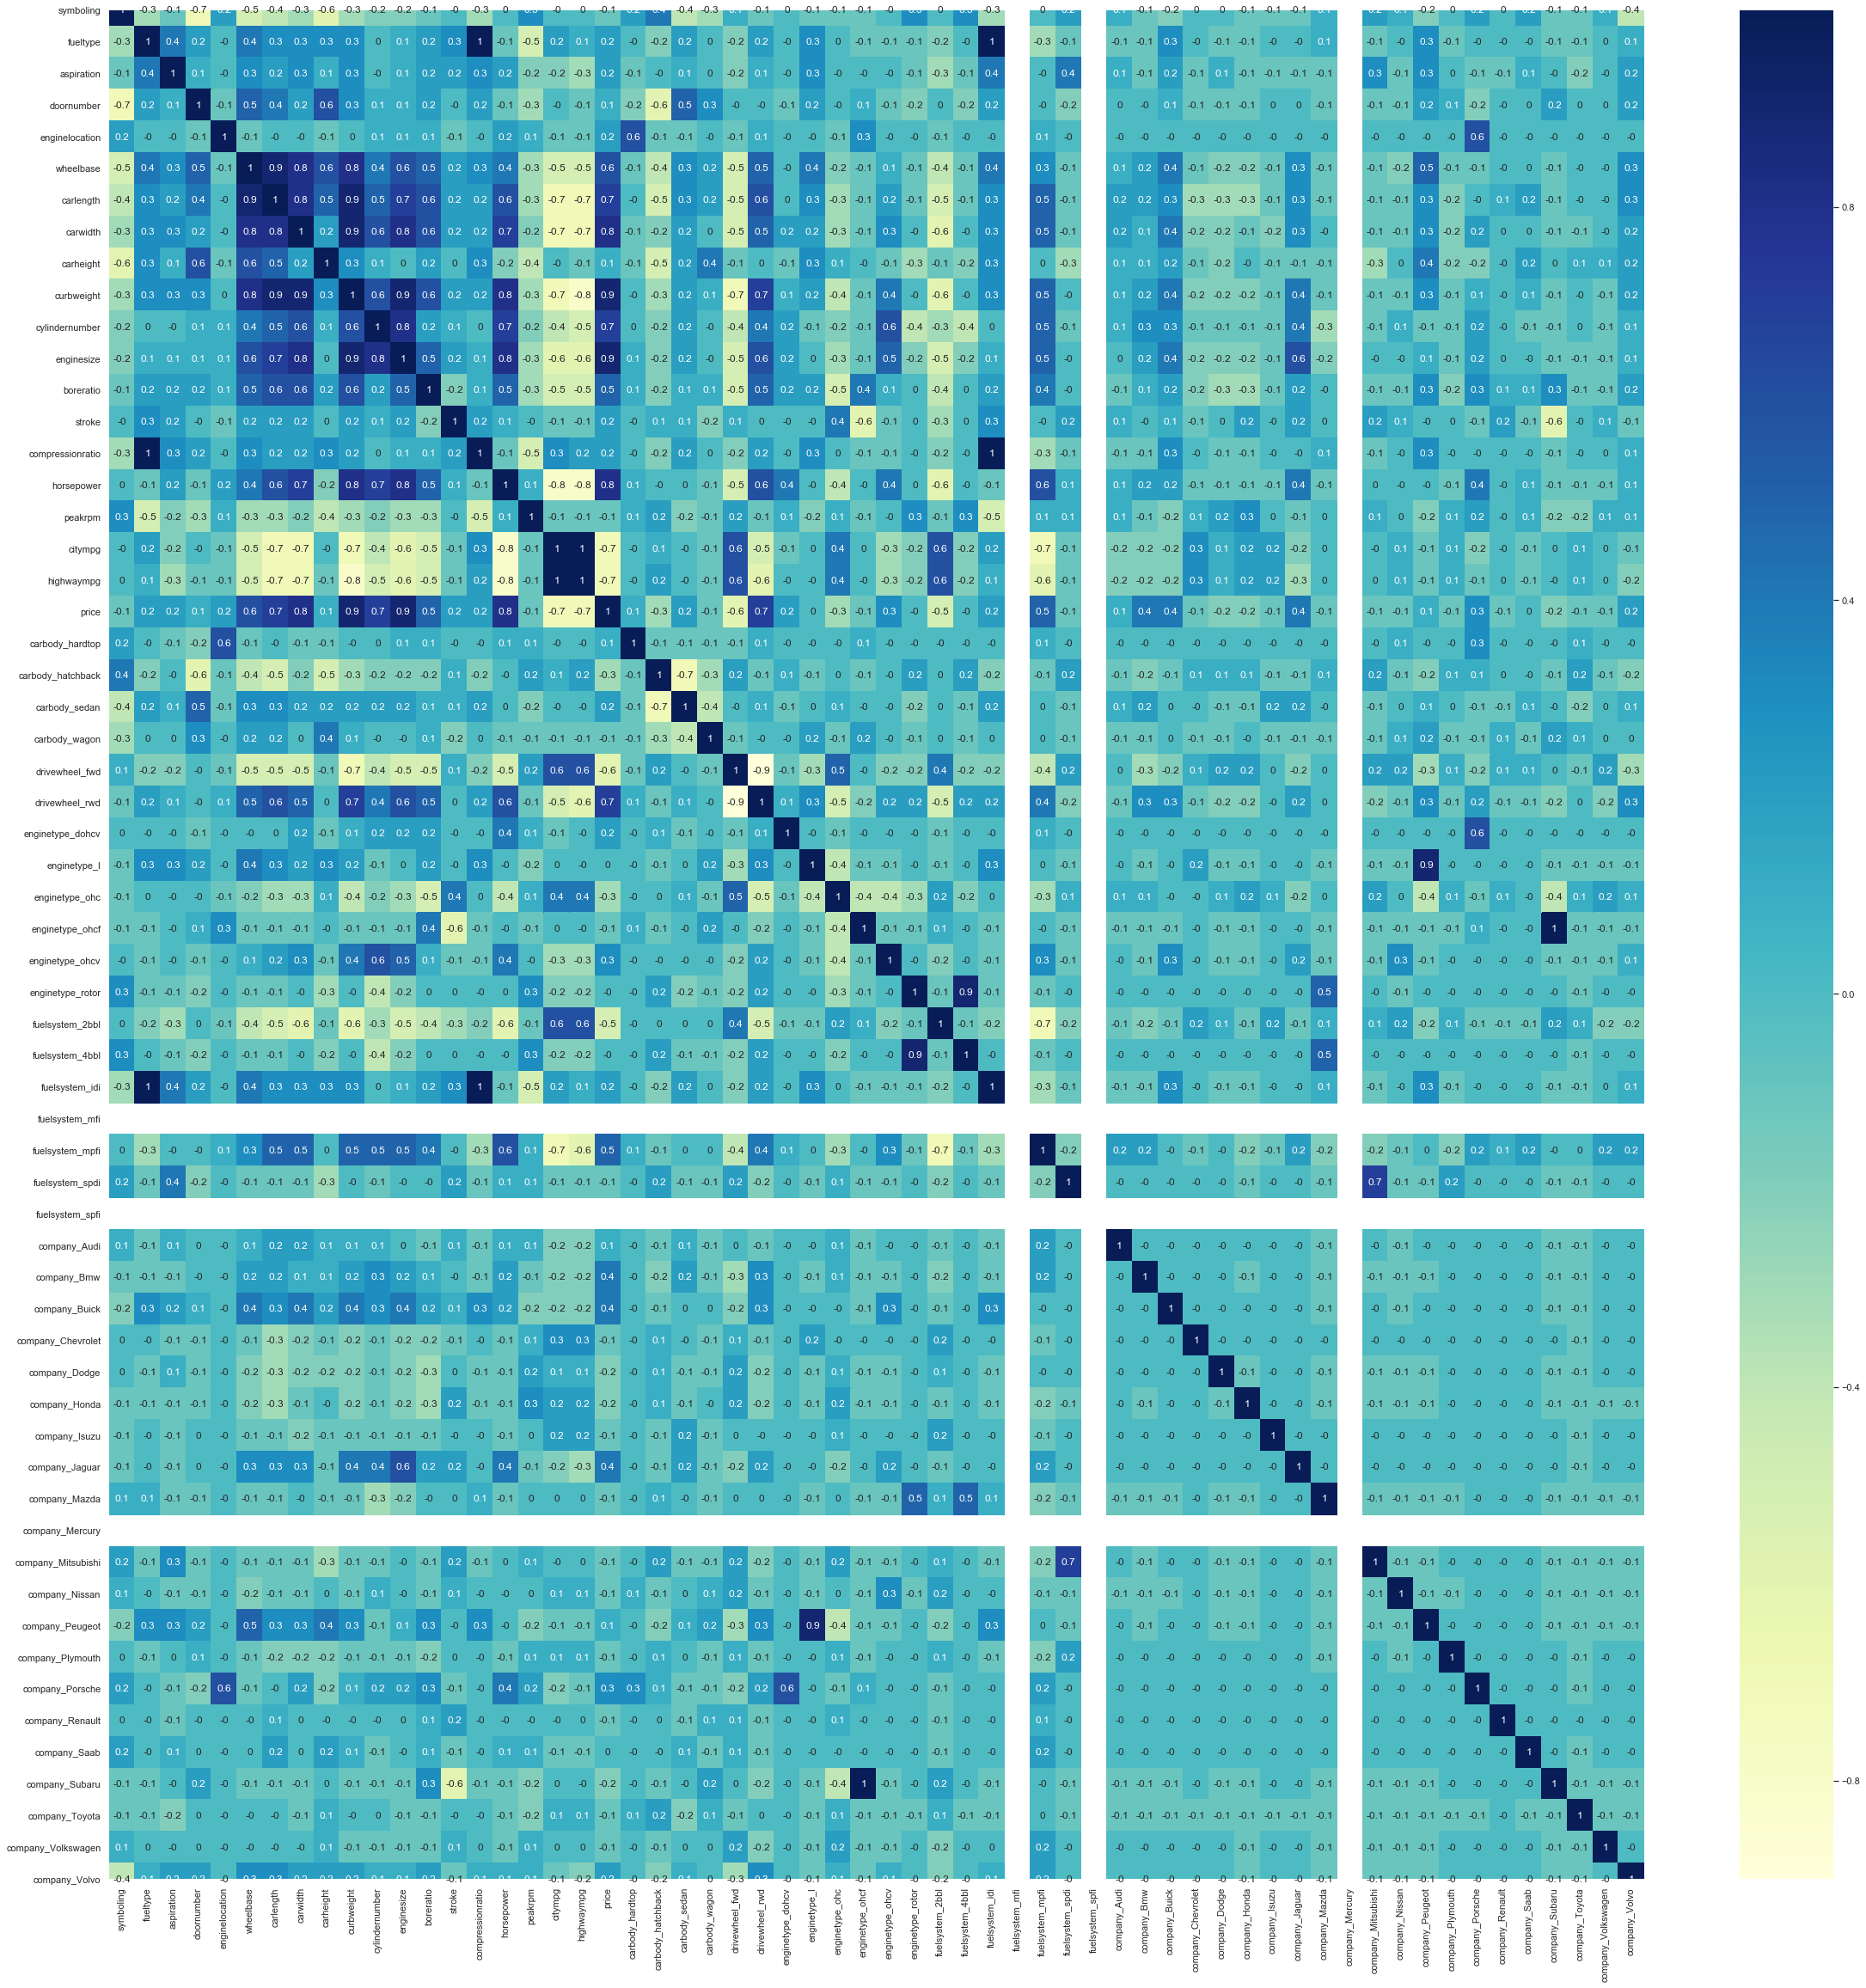

In [47]:
# heatmap
plt.figure(figsize=(40,40))
sns.heatmap(round(m1_train.corr(),1),annot=True,cmap="YlGnBu")
plt.show()
corr = m1_train.corr()

In [48]:
print("Features that are positively correlated with Price")
pv_corr = round(corr[round(corr["price"],2) > 0].price,2)
display(pv_corr)

Features that are positively correlated with Price


fueltype            0.19
aspiration          0.21
doornumber          0.08
enginelocation      0.23
wheelbase           0.62
carlength           0.71
carwidth            0.80
carheight           0.10
curbweight          0.86
cylindernumber      0.70
enginesize          0.87
boreratio           0.53
stroke              0.15
compressionratio    0.16
horsepower          0.81
price               1.00
carbody_hardtop     0.09
carbody_sedan       0.21
drivewheel_rwd      0.68
enginetype_dohcv    0.20
enginetype_l        0.04
enginetype_ohcv     0.34
fuelsystem_idi      0.19
fuelsystem_mpfi     0.52
company_Audi        0.13
company_Bmw         0.37
company_Buick       0.44
company_Jaguar      0.41
company_Peugeot     0.08
company_Porsche     0.30
company_Saab        0.04
company_Volvo       0.16
Name: price, dtype: float64

In [49]:
print("Features that are negatively correlated with Price")
nv_corr = round(corr[round(corr["price"],2) < 0].price,2)
display(nv_corr)

Features that are negatively correlated with Price


symboling            -0.13
peakrpm              -0.13
citympg              -0.67
highwaympg           -0.69
carbody_hatchback    -0.25
carbody_wagon        -0.05
drivewheel_fwd       -0.64
enginetype_ohc       -0.30
enginetype_ohcf      -0.09
fuelsystem_2bbl      -0.54
fuelsystem_4bbl      -0.02
fuelsystem_spdi      -0.07
company_Chevrolet    -0.13
company_Dodge        -0.17
company_Honda        -0.17
company_Isuzu        -0.09
company_Mazda        -0.11
company_Mitsubishi   -0.13
company_Nissan       -0.13
company_Plymouth     -0.13
company_Renault      -0.05
company_Subaru       -0.16
company_Toyota       -0.15
company_Volkswagen   -0.06
Name: price, dtype: float64

In [50]:
print("Features that are not correlated with Price")
no_corr = round(corr[round(corr["price"],2) == 0].price,2)
display(no_corr)

Features that are not correlated with Price


enginetype_rotor   -0.0
Name: price, dtype: float64

## Hypothesis Test  & Model Evaluation Criteria

### Hypothesis Test

__F-Test for significance of Regression Model__ (F-test Statistic)

Null Hypothesis: H0: ß1 = ß2 = ß3 .. ßn = 0  (ß(i) is not Significant)

Alternate Hypothesis: H1: ß(i) is not equal to 0 for atleast one of the features in the model (ß(i) is Significant)

__Confidence level and Significance levels for regression coefficents (Individual regression coefficent ß-pred)__

As there was no certain confidence level is given, I take the default confidence level of 95% and Significance level of 5%. 


__T-test for the significance of a predictor or single regression coefficent__
As significance level is 5%, we set the our condition that 

1) We fail to reject the null hypothesis that "ß-pred is insignificant" if p-value is greater than 0.05.
2) We reject the null hypothesis and say "B-pred is significant" if p-value is less than 0.05.

During our feature selection, the above condition is used to decide if the features are significant or not.


### Model Evaluation Criteria

Following criteria should be fulfilled for the best model and each model is evaluated based on the following conditions.
1. Probability of F-Test for Regression Model must be close to 0
2. p-value of T-test for all predictors in the final model must be below 0.005
3. There should not be any kind of collinearity among predictors. VIF of predictors should be less than 5.
4. Residuals (Actual Test data and Predicted Test data) should be normally distributed with mean zero.
5. Residuals (Actual Test data and Predicted Test data) are independent of each other.
6. Residuals (Actual Test data and Predicted Test data)  have constant variance.
7. Model should not be overfit.
8. Adjusted R-Square should be little less but comapritively closer to R-Square.
9. R-Square should be comparitvely high suggesting a good fit.
10. R-Square of Test and Train should be closer to each other suggesting that model has worked well with unseen data.
11. Check the RMSE of each model and compare it among the 3 models.

## LR Model 1 using RFE

__ML Linear Regression Steps__
* 1) Create a model using RFE with 10 Features and drop some of them based its p-value and VIF
* 1) Train the model using Training Data
* 2) Evaluate the model (training set and test set)

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

#### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [51]:
# As the VIF calculation is very important, following function would help in calculating the VIF several times
def vif_calc(l_df):
    vif = pd.DataFrame()
    vif['Features'] = l_df.columns
    vif['VIF'] = [variance_inflation_factor(l_df.values, i) for i in range(l_df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False).reset_index(drop=True)
    display(vif)

In [52]:
# Target variable is removed from predictor variables
my1_train = m1_train.pop("price")
MX1_train = m1_train

display(my1_train.head())
display(MX1_train.head())

122   -0.700201
125    1.151929
166   -0.452248
1      0.442646
199    0.757569
Name: price, dtype: float64

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
122   0.170159         0           0           1               0  -0.811836   
125   1.848278         0           0           0               0  -0.677177   
166   0.170159         0           0           0               0  -0.677177   
1     1.848278         0           0           0               0  -1.670284   
199  -1.507960         0           1           1               0   0.972390   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
122  -0.487238 -0.924500  -1.134628   -0.642128       -0.378724   -0.660242   
125  -0.359789  1.114978  -1.382026    0.439415       -0.378724    0.637806   
166  -0.375720 -0.833856  -0.392434   -0.441296       -0.378724   -0.660242   
1    -0.367754 -0.788535  -1.959288    0.015642       -0.378724    0.123485   
199   1.225364  0.616439   1.627983    1.137720       -0.378724    0.123485   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
122  -1.297329 -0.064443         -0.172569   -0.872898  0.771349  0.839773   
125   2.432256 -0.449757         -0.146125    1.021826  0.771349 -0.957048   
166  -0.259197 -0.546085         -0.172569    0.238673  3.064983  0.091098   
1     0.625138 -1.830463         -0.278345    0.213410 -0.271212 -0.657578   
199   1.201877 -0.321319         -0.675002    1.501822 -0.062699 -1.256518   

     highwaympg  carbody_hardtop  carbody_hatchback  carbody_sedan  \
122    1.025419                0                  0              1   
125   -0.557490                0                  1              0   
166   -0.269688                0                  1              0   
1     -0.557490                0                  0              0   
199   -1.276993                0                  0              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
122              0               1               0                 0   
125              0               0               1                 0   
166              0               0               1                 0   
1                0               0               1                 0   
199              1               0               1                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
122             0               1                0                0   
125             0               1                0                0   
166             0               0                0                0   
1               0               0                0                0   
199             0               1                0                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
122                 0                1                0               0   
125                 0                0                0               0   
166                 0                0                0               0   
1                   0                0                0               0   
199                 0                0                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
122               0                0                0                0   
125               0                1                0                0   
166               0                1                0                0   
1                 0                1                0                0   
199               0                1                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
122             0            0              0                  0   
125             0            0              0                  0   
166             0            0              0                  0   
1               0            0              0                  0   
199             0            0              0                  0   



In [53]:
# Running RFE with the output number of the variable equal to 10
lm_rfe = LinearRegression()
lm_rfe.fit(MX1_train, my1_train)

rfe = RFE(lm_rfe, 10)             # running RFE
rfe = rfe.fit(MX1_train, my1_train)

In [54]:
# display the features created using RFE 
print(list(zip(MX1_train.columns,rfe.support_,rfe.ranking_)))

[('symboling', False, 50), ('fueltype', False, 14), ('aspiration', False, 28), ('doornumber', False, 41), ('enginelocation', True, 1), ('wheelbase', False, 22), ('carlength', False, 21), ('carwidth', False, 11), ('carheight', False, 20), ('curbweight', True, 1), ('cylindernumber', False, 8), ('enginesize', False, 5), ('boreratio', False, 9), ('stroke', False, 36), ('compressionratio', False, 16), ('horsepower', False, 25), ('peakrpm', False, 30), ('citympg', False, 45), ('highwaympg', False, 33), ('carbody_hardtop', True, 1), ('carbody_hatchback', False, 2), ('carbody_sedan', False, 3), ('carbody_wagon', True, 1), ('drivewheel_fwd', False, 46), ('drivewheel_rwd', False, 31), ('enginetype_dohcv', True, 1), ('enginetype_l', True, 1), ('enginetype_ohc', False, 34), ('enginetype_ohcf', False, 7), ('enginetype_ohcv', False, 35), ('enginetype_rotor', False, 27), ('fuelsystem_2bbl', False, 24), ('fuelsystem_4bbl', False, 26), ('fuelsystem_idi', False, 15), ('fuelsystem_mfi', False, 47), ('fue

In [55]:
# create a list of 10 columns created using RFE
rfe_cols = MX1_train.columns[rfe.support_]
display(rfe_cols)

Index(['enginelocation', 'curbweight', 'carbody_hardtop', 'carbody_wagon',
       'enginetype_dohcv', 'enginetype_l', 'company_Bmw', 'company_Buick',
       'company_Peugeot', 'company_Porsche'],
      dtype='object')

In [56]:
# columns not contributing to variance of predictor
dr_rfe_cols = MX1_train.columns[~rfe.support_]
display(dr_rfe_cols)

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'cylindernumber', 'enginesize',
       'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm',
       'citympg', 'highwaympg', 'carbody_hatchback', 'carbody_sedan',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi', 'company_Audi',
       'company_Chevrolet', 'company_Dodge', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mercury',
       'company_Mitsubishi', 'company_Nissan', 'company_Plymouth',
       'company_Renault', 'company_Saab', 'company_Subaru', 'company_Toyota',
       'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [57]:
# Create a new df with only columns selected by RFE
MX1_train_ref = MX1_train[rfe_cols]

# Inspect the DF
display(MX1_train_ref.head())

enginelocation  curbweight  carbody_hardtop  carbody_wagon  \
122               0   -0.642128                0              0   
125               0    0.439415                0              0   
166               0   -0.441296                0              0   
1                 0    0.015642                0              0   
199               0    1.137720                0              1   

     enginetype_dohcv  enginetype_l  company_Bmw  company_Buick  \
122                 0             0            0              0   
125                 0             0            0              0   
166                 0             0            0              0   
1                   0             0            0              0   
199                 0             0            0              0   

     company_Peugeot  company_Porsche  
122                0                0  
125                0                1  
166                0                0  
1                  0                0  
199                0                0

In [58]:
# LR Modeling using Statsmodel
MX1_train_sm = sm.add_constant(MX1_train_ref)
m1_lr_sm = sm.OLS(my1_train,MX1_train_sm)
m1_lr_sm_model = m1_lr_sm.fit()
display(m1_lr_sm_model.summary())
vif_calc(MX1_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     129.5
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           3.65e-63
Time:                        02:00:43   Log-Likelihood:                -32.702
No. Observations:                 143   AIC:                             87.40
Df Residuals:                     132   BIC:                             120.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0257      0.032     -0.805      0.422      -0.089       0.037
enginelocation       1.6838      0.501      3.358      0.001       0.692       2.676
curbweight           0.8191      0.033     24.606      0.000       0.753       0.885
carbody_hardtop     -0.1068      0.226     -0.473      0.637      -0.554       0.340
carbody_wagon       -0.3538      0.080     -4.410      0.000      -0.513      -0.195
enginetype_dohcv     0.3187      0.449      0.709      0.479      -0.570       1.207
enginetype_l         0.5964      0.323      1.847      0.067      -0.042       1.235
company_Bmw          1.1552      0.137      8.414      0.000       0.884       1.427
company_Buick        0.6545      0.164      3.992      0.000       0.330       0.979
company_Peugeot     -1.1631      0.353     -3.298      0.001      -1.861      -0.466
company_Porsche      0.8177      0.319      2.564      0.011       0.187       1.449
==============================================================================
Omnibus:                       11.405   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               22.704
Skew:                           0.286   Prob(JB):                     1.17e-05
Kurtosis:                       4.867   Cond. No.                         24.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0   company_Peugeot  9.90
1      enginetype_l  9.35
2   company_Porsche  3.01
3    enginelocation  2.50
4  enginetype_dohcv  2.01
5   carbody_hardtop  1.50
6        curbweight  1.47
7     company_Buick  1.24
8     carbody_wagon  1.08
9       company_Bmw  1.04

#### Drop the columns based on below thumb rules

* Significance levels and VIF are 2 important things that will make us in deciding to drop our features
  - Precedence 1 __High P-Value(above 0.05) and High VIF(above 5%)__ - They can be dropped 
  - Precedence 2 __High P-Value(above 0.05)__  - As insignificant, they are dropped first
  - Precedence 3 __High P-Value(above 0.05) and low VIF(below 5%)__ - They can be dropped first
  - Precedence 4 __Low P-Value(below 0.05) and High VIF(above 5%)__ - They can be dropped
  - __Low P-Value(below 0.05) and Low VIF(below 5%)__ - They can be retained

##### Drop company_Peugeot as p-value is  high

In [59]:
MX1_train_ref = MX1_train_ref.drop("company_Peugeot",axis=1)
MX1_train_ref.columns

Index(['enginelocation', 'curbweight', 'carbody_hardtop', 'carbody_wagon',
       'enginetype_dohcv', 'enginetype_l', 'company_Bmw', 'company_Buick',
       'company_Porsche'],
      dtype='object')

In [60]:
# LR Modeling using Statsmodel
MX1_train_sm = sm.add_constant(MX1_train_ref)
m1_lr_sm = sm.OLS(my1_train,MX1_train_sm)
m1_lr_sm_model = m1_lr_sm.fit()
display(m1_lr_sm_model.summary())
vif_calc(MX1_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     132.8
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           5.54e-62
Time:                        02:00:43   Log-Likelihood:                -38.364
No. Observations:                 143   AIC:                             96.73
Df Residuals:                     133   BIC:                             126.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0309      0.033     -0.935      0.352      -0.096       0.034
enginelocation       1.6889      0.520      3.249      0.001       0.661       2.717
curbweight           0.7868      0.033     23.857      0.000       0.722       0.852
carbody_hardtop     -0.1133      0.234     -0.484      0.630      -0.577       0.350
carbody_wagon       -0.3673      0.083     -4.422      0.000      -0.532      -0.203
enginetype_dohcv     0.3536      0.465      0.760      0.449      -0.567       1.274
enginetype_l        -0.3981      0.120     -3.319      0.001      -0.635      -0.161
company_Bmw          1.1858      0.142      8.352      0.000       0.905       1.467
company_Buick        0.7308      0.168      4.344      0.000       0.398       1.064
company_Porsche      0.8371      0.330      2.533      0.012       0.183       1.491
==============================================================================
Omnibus:                       17.210   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.681
Skew:                           0.574   Prob(JB):                     3.59e-07
Kurtosis:                       4.914   Cond. No.                         24.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0   company_Porsche  3.01
1    enginelocation  2.50
2  enginetype_dohcv  2.01
3   carbody_hardtop  1.50
4        curbweight  1.35
5     company_Buick  1.22
6      enginetype_l  1.12
7     carbody_wagon  1.07
8       company_Bmw  1.04

##### Drop enginetype_dohcv as p-value and VIF is  high

In [61]:
MX1_train_ref = MX1_train_ref.drop("enginetype_dohcv",axis=1)
MX1_train_ref.columns

Index(['enginelocation', 'curbweight', 'carbody_hardtop', 'carbody_wagon',
       'enginetype_l', 'company_Bmw', 'company_Buick', 'company_Porsche'],
      dtype='object')

In [62]:
# LR Modeling using Statsmodel
MX1_train_sm = sm.add_constant(MX1_train_ref)
m1_lr_sm = sm.OLS(my1_train,MX1_train_sm)
m1_lr_sm_model = m1_lr_sm.fit()
display(m1_lr_sm_model.summary())
vif_calc(MX1_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     149.8
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           5.82e-63
Time:                        02:00:43   Log-Likelihood:                -38.674
No. Observations:                 143   AIC:                             95.35
Df Residuals:                     134   BIC:                             122.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0304      0.033     -0.922      0.358      -0.096       0.035
enginelocation      1.5130      0.465      3.256      0.001       0.594       2.432
curbweight          0.7888      0.033     24.024      0.000       0.724       0.854
carbody_hardtop    -0.1131      0.234     -0.483      0.630      -0.576       0.349
carbody_wagon      -0.3679      0.083     -4.437      0.000      -0.532      -0.204
enginetype_l       -0.4002      0.120     -3.342      0.001      -0.637      -0.163
company_Bmw         1.1838      0.142      8.353      0.000       0.903       1.464
company_Buick       0.7263      0.168      4.327      0.000       0.394       1.058
company_Porsche     1.0115      0.237      4.262      0.000       0.542       1.481
==============================================================================
Omnibus:                       16.680   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.292
Skew:                           0.563   Prob(JB):                     7.18e-07
Kurtosis:                       4.866   Cond. No.                         18.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0   enginelocation  2.00
1  company_Porsche  1.53
2  carbody_hardtop  1.50
3       curbweight  1.34
4    company_Buick  1.22
5     enginetype_l  1.12
6    carbody_wagon  1.07
7      company_Bmw  1.04

##### Drop carbody_hardtop as p-value is  high

In [63]:
MX1_train_ref = MX1_train_ref.drop("carbody_hardtop",axis=1)
MX1_train_ref.columns

Index(['enginelocation', 'curbweight', 'carbody_wagon', 'enginetype_l',
       'company_Bmw', 'company_Buick', 'company_Porsche'],
      dtype='object')

In [64]:
# LR Modeling using Statsmodel
MX1_train_sm = sm.add_constant(MX1_train_ref)
m1_lr_sm = sm.OLS(my1_train,MX1_train_sm)
m1_lr_sm_model = m1_lr_sm.fit()
display(m1_lr_sm_model.summary())
vif_calc(MX1_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     172.2
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           4.80e-64
Time:                        02:00:43   Log-Likelihood:                -38.798
No. Observations:                 143   AIC:                             93.60
Df Residuals:                     135   BIC:                             117.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0325      0.033     -0.995      0.322      -0.097       0.032
enginelocation      1.4001      0.401      3.496      0.001       0.608       2.192
curbweight          0.7890      0.033     24.102      0.000       0.724       0.854
carbody_wagon      -0.3662      0.083     -4.433      0.000      -0.530      -0.203
enginetype_l       -0.3989      0.119     -3.342      0.001      -0.635      -0.163
company_Bmw         1.1856      0.141      8.393      0.000       0.906       1.465
company_Buick       0.7275      0.167      4.347      0.000       0.397       1.059
company_Porsche     1.0133      0.237      4.282      0.000       0.545       1.481
==============================================================================
Omnibus:                       16.558   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.118
Skew:                           0.558   Prob(JB):                     7.84e-07
Kurtosis:                       4.864   Cond. No.                         16.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0  company_Porsche  1.53
1   enginelocation  1.50
2       curbweight  1.34
3    company_Buick  1.22
4     enginetype_l  1.12
5    carbody_wagon  1.07
6      company_Bmw  1.04

### Residual Analysis and validating the assumptions on Train Set

#### Error terms are normally distributed with mean zero

In [65]:
my1_train_pred = m1_lr_sm_model.predict(MX1_train_sm)

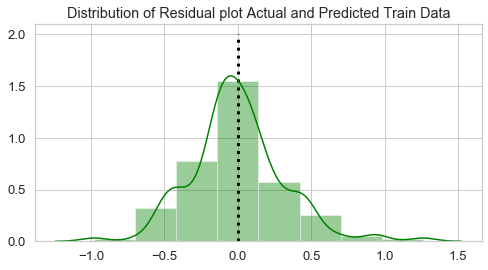

In [66]:
# Calculate the Residuals and check if they are normally distributed or not
res_m1 = my1_train - my1_train_pred
plt.figure(1,figsize=(8,4))
sns.set(style="whitegrid",font_scale=1.2)
sns.distplot(round(res_m1,2),bins=8,color="green")
plt.vlines(round(res_m1,2).mean(),ymin=0,ymax=2,linewidth=3.0,color="black",linestyles='dotted')
plt.title('Distribution of Residual plot Actual and Predicted Train Data')
plt.show()

In [67]:
# Mean of Residuals
round(res_m1,2).mean()

-2.3291392125003285e-18

* The mean of residuals is observed to be very close 0

#### Error terms are independent of each other:

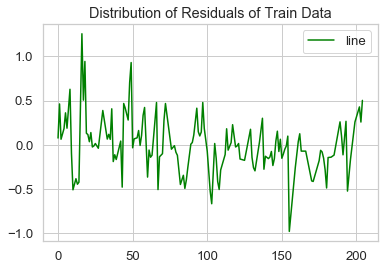

In [68]:
# check if the Residuals are normally distributed or not
plt.figure(1,figsize=(6,4))
sns.set(style="whitegrid",font_scale=1.2)
ax = sns.lineplot(data=res_m1, color="green", label="line")
plt.title('Distribution of Residuals of Train Data')
plt.show()

* There is no specific visible pattern

#### Error terms have constant variance (homoscedasticity):

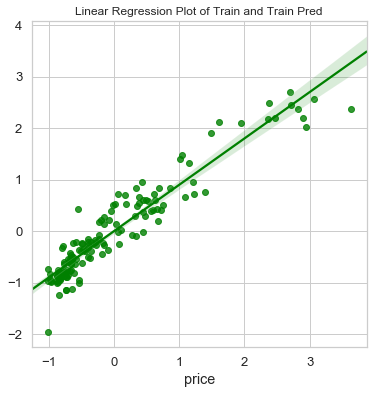

In [69]:
plt.figure(2,figsize=(6,6))
sns.set(style="whitegrid",font_scale=1.2)
ax1 = sns.regplot(x=my1_train,y=my1_train_pred,color='green')
plt.title('Linear Regression Plot of Train and Train Pred',fontsize=12)
plt.show()

* Error terms have constant variance but in the end couple of points are out of the variance

### __Observations on Training Set__
1. Probability of F-Test for Regression Model on training set is close to 0
2. p-value of T-test for all predictors in the final model are below 0.005
3. VIF of all the predictors is less than 5.
4. Residuals (Actual Train data and Predicted Train data) should be normally distributed with mean zero.
   - Here it is close to 0
5. Residuals (Actual Train data and Predicted Train data) are independent of each other.
6. Residuals (Actual Train data and Predicted Train data)  have constant variance.
7. Adjusted R-Square and R-Square are close to each other and Adjusted R-Square is below R-Square.
___Hence the basic checks are good on training data, this model can be used on test set for further evaluations___

### Prediction and Evaluation on the Test Set

* Make predictions on the test set (y_test_pred)
* evaluate the model, r-squared on the test set

### Preprocessing of Test Set Data based on Train Set

In [70]:
display(m1_test.head())

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
160         2         0           0           1               0       95.7   
186         4         0           0           1               0       97.3   
59          3         0           0           0               0       98.8   
165         3         0           0           0               0       94.5   
140         4         0           0           0               0       93.3   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
160      166.3      64.4       53.0        2094               2          98   
186      171.7      65.5       55.7        2275               2         109   
59       177.8      66.5       53.7        2385               2         122   
165      168.7      64.0       52.6        2265               2          98   
140      157.3      63.8       55.7        2240               2         108   

     boreratio  stroke  compressionratio  horsepower  peakrpm  citympg  \
160       3.19    3.03               9.0          70     4800       38   
186       3.19    3.40               9.0          85     5250       27   
59        3.39    3.39               8.6          84     4800       26   
165       3.24    3.08               9.4         112     6600       26   
140       3.62    2.64               8.7          73     4400       26   

     highwaympg   price  carbody_hardtop  carbody_hatchback  carbody_sedan  \
160          47  7738.0                0                  0              1   
186          34  8495.0                0                  0              1   
59           32  8845.0                0                  1              0   
165          29  9298.0                0                  0              1   
140          31  7603.0                0                  1              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
160              0               1               0                 0   
186              0               1               0                 0   
59               0               1               0                 0   
165              0               0               1                 0   
140              0               0               0                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
160             0               1                0                0   
186             0               1                0                0   
59              0               1                0                0   
165             0               0                0                0   
140             0               0                1                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
160                 0                1                0               0   
186                 0                0                0               0   
59                  0                1                0               0   
165                 0                0                0               0   
140                 0                1                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
160               0                0                0                0   
186               0                1                0                0   
59                0                0                0                0   
165               0                1                0                0   
140               0                0                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
160             0            0              0                  0   
186             0            0              0                  0   
59              0            0              0                  0   
165             0            0              0                  0   
140             0            0              0     

### Scaling of DF Test

In [71]:
# Preprocessing of Test Set based on Training set
# 1 transform on data
m1_test[scl_li] = m13_scaler.transform(m1_test[scl_li])
display(m1_test.head())

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
160  -0.668901         0           0           1               0  -0.475189   
186   1.009219         0           0           1               0  -0.205872   
59    0.170159         0           0           0               0   0.046613   
165   0.170159         0           0           0               0  -0.677177   
140   1.009219         0           0           0               0  -0.879165   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
160  -0.566894 -0.652569  -0.227502   -0.820850       -0.378724   -0.660242   
186  -0.136752 -0.154030   0.885789   -0.487359       -0.378724   -0.390836   
59    0.349149  0.299187   0.061129   -0.284685       -0.378724   -0.072447   
165  -0.375720 -0.833856  -0.392434   -0.505784       -0.378724   -0.660242   
140  -1.283797 -0.924500   0.885789   -0.551846       -0.378724   -0.415328   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
160  -0.451443 -0.706633         -0.278345   -0.822372 -0.688236  1.887918   
186  -0.451443  0.481417         -0.278345   -0.443427  0.250069  0.240833   
59    0.317543  0.449308         -0.384120   -0.468690 -0.688236  0.091098   
165  -0.259197 -0.546085         -0.172569    0.238673  3.064983  0.091098   
140   1.201877 -1.958901         -0.357676   -0.746583 -1.522285  0.091098   

     highwaympg     price  carbody_hardtop  carbody_hatchback  carbody_sedan  \
160    2.320526 -0.683619                0                  0              1   
186    0.449816 -0.586315                0                  0              1   
59     0.162014 -0.541326                0                  1              0   
165   -0.269688 -0.483097                0                  0              1   
140    0.018113 -0.700972                0                  1              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
160              0               1               0                 0   
186              0               1               0                 0   
59               0               1               0                 0   
165              0               0               1                 0   
140              0               0               0                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
160             0               1                0                0   
186             0               1                0                0   
59              0               1                0                0   
165             0               0                0                0   
140             0               0                1                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
160                 0                1                0               0   
186                 0                0                0               0   
59                  0                1                0               0   
165                 0                0                0               0   
140                 0                1                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
160               0                0                0                0   
186               0                1                0                0   
59                0                0                0                0   
165               0                1                0                0   
140               0                0                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
160             0            0              0                  0   
186             0            0              0                  0   
59              0            0              0                  0   
165             0            0              0                  0   
140      

In [72]:
# Create y_test and X_train
my1_test = m1_test.pop("price")
MX1_test = m1_test
display(my1_test.head())
display(MX1_test.head())

160   -0.683619
186   -0.586315
59    -0.541326
165   -0.483097
140   -0.700972
Name: price, dtype: float64

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
160  -0.668901         0           0           1               0  -0.475189   
186   1.009219         0           0           1               0  -0.205872   
59    0.170159         0           0           0               0   0.046613   
165   0.170159         0           0           0               0  -0.677177   
140   1.009219         0           0           0               0  -0.879165   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
160  -0.566894 -0.652569  -0.227502   -0.820850       -0.378724   -0.660242   
186  -0.136752 -0.154030   0.885789   -0.487359       -0.378724   -0.390836   
59    0.349149  0.299187   0.061129   -0.284685       -0.378724   -0.072447   
165  -0.375720 -0.833856  -0.392434   -0.505784       -0.378724   -0.660242   
140  -1.283797 -0.924500   0.885789   -0.551846       -0.378724   -0.415328   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
160  -0.451443 -0.706633         -0.278345   -0.822372 -0.688236  1.887918   
186  -0.451443  0.481417         -0.278345   -0.443427  0.250069  0.240833   
59    0.317543  0.449308         -0.384120   -0.468690 -0.688236  0.091098   
165  -0.259197 -0.546085         -0.172569    0.238673  3.064983  0.091098   
140   1.201877 -1.958901         -0.357676   -0.746583 -1.522285  0.091098   

     highwaympg  carbody_hardtop  carbody_hatchback  carbody_sedan  \
160    2.320526                0                  0              1   
186    0.449816                0                  0              1   
59     0.162014                0                  1              0   
165   -0.269688                0                  0              1   
140    0.018113                0                  1              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
160              0               1               0                 0   
186              0               1               0                 0   
59               0               1               0                 0   
165              0               0               1                 0   
140              0               0               0                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
160             0               1                0                0   
186             0               1                0                0   
59              0               1                0                0   
165             0               0                0                0   
140             0               0                1                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
160                 0                1                0               0   
186                 0                0                0               0   
59                  0                1                0               0   
165                 0                0                0               0   
140                 0                1                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
160               0                0                0                0   
186               0                1                0                0   
59                0                0                0                0   
165               0                1                0                0   
140               0                0                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
160             0            0              0                  0   
186             0            0              0                  0   
59              0            0              0                  0   
165             0            0              0                  0   
140             0            0              0                  0   



In [73]:
# drop the columns from test set
MX1_test = MX1_test[MX1_train_ref.columns]

In [74]:
# check to compare test and train columns
display(MX1_test.columns)
display(MX1_train_ref.columns)

Index(['enginelocation', 'curbweight', 'carbody_wagon', 'enginetype_l',
       'company_Bmw', 'company_Buick', 'company_Porsche'],
      dtype='object')

Index(['enginelocation', 'curbweight', 'carbody_wagon', 'enginetype_l',
       'company_Bmw', 'company_Buick', 'company_Porsche'],
      dtype='object')

In [75]:
# add cons for X_test set
MX1_test_sm = sm.add_constant(MX1_test)

# predict y_test_pred based on our model
my1_test_pred = m1_lr_sm_model.predict(MX1_test_sm)

In [76]:
# calculate the RSquared and RMSE for test data and Predicted data
m1_rsqr_test = r2_score(y_true=my1_test,y_pred=my1_test_pred)
m1_rmse = sqrt(mean_squared_error(my1_test, my1_test_pred))
print("RSquare of the test set is ",m1_rsqr_test)
print("RMSE of the model is ",m1_rmse)

RSquare of the test set is  0.8868395950666472
RMSE of the model is  0.36184628925705975


### Residual Analysis and validating the assumptions on Test Set

#### Error terms are normally distributed with mean zero

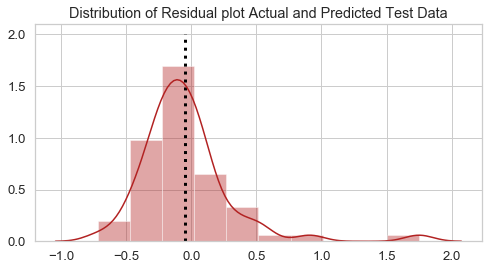

In [77]:
# Calculate the Residuals and check if they are normally distributed or not
res_test_m1 = my1_test - my1_test_pred
plt.figure(1,figsize=(8,4))
sns.set(style="whitegrid",font_scale=1.2)
sns.distplot(round(res_test_m1,2),bins=10,color="firebrick")
plt.vlines(round(res_test_m1,2).mean(),ymin=0,ymax=2,linewidth=3.0,color="black",linestyles='dotted')
plt.title('Distribution of Residual plot Actual and Predicted Test Data')
plt.show()

In [78]:
# Mean of Residuals
round(res_test_m1,2).mean()

-0.04758064516129033

* The mean of residuals is observed to be very close 0

#### Error terms are independent of each other:

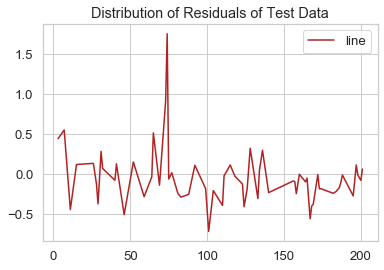

In [79]:
plt.figure(1,figsize=(6,4))
sns.set(style="whitegrid",font_scale=1.2)
ax = sns.lineplot(data=res_test_m1, color="firebrick", label="line")
plt.title('Distribution of Residuals of Test Data')
plt.show()

* There is no specific visible pattern

#### Error terms have constant variance (homoscedasticity):

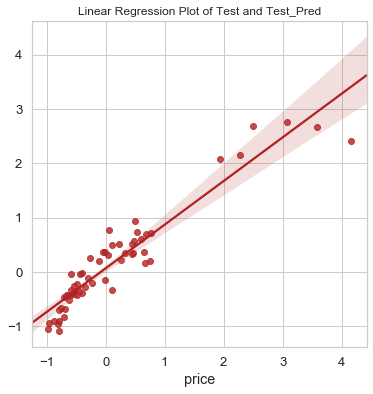

In [80]:
plt.figure(2,figsize=(6,6))
sns.set(style="whitegrid",font_scale=1.2)
ax1 = sns.regplot(x=my1_test,y=my1_test_pred,color="firebrick")
plt.title('Linear Regression Plot of Test and Test_Pred',fontsize=12)
plt.show()

* Error terms have constant variance but in the end couple of points are out of the variance

#### Distribution of Actual Test Data and Predicted Test Data

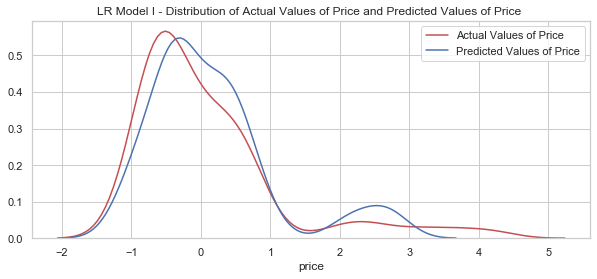

In [81]:
# Plot the distribution of Actual values of Price and Predicted values of Price
plt.figure(1,figsize=(10,4))
sns.set(style="whitegrid",font_scale=1)
ax1 = sns.distplot(my1_test, hist=False, color="r", label="Actual Values of Price")
sns.distplot(my1_test_pred, hist=False, color="b", label="Predicted Values of Price" , ax=ax1)
plt.title('LR Model I - Distribution of Actual Values of Price and Predicted Values of Price ',fontsize=12)
plt.show()

### __Summary and Observations of LR-M I__

In [82]:
# Summary of LR Model I
print('Linear Regression Model-I - VIF Values using RFE Train Set     :')
print(vif_calc(MX1_train_ref))
print('Linear Regression Model-I - p-values using RFE Train Set     :')
print(round(m1_lr_sm_model.pvalues,3))
print('Linear Regression Model-I - Adj-R-Squared using RFE Train Set: ', m1_lr_sm_model.rsquared_adj)
print('Linear Regression Model-I - R-Squared using RFE Train Set    : ', m1_lr_sm_model.rsquared)
print('Linear Regression Model-I - R-Squared using RFE Test Set     :  ', m1_rsqr_test)


Linear Regression Model-I - VIF Values using RFE Train Set     :


Features   VIF
0  company_Porsche  1.53
1   enginelocation  1.50
2       curbweight  1.34
3    company_Buick  1.22
4     enginetype_l  1.12
5    carbody_wagon  1.07
6      company_Bmw  1.04

None
Linear Regression Model-I - p-values using RFE Train Set     :
const              0.322
enginelocation     0.001
curbweight         0.000
carbody_wagon      0.000
enginetype_l       0.001
company_Bmw        0.000
company_Buick      0.000
company_Porsche    0.000
dtype: float64
Linear Regression Model-I - Adj-R-Squared using RFE Train Set:  0.8940396997562086
Linear Regression Model-I - R-Squared using RFE Train Set    :  0.899263094838649
Linear Regression Model-I - R-Squared using RFE Test Set     :   0.8868395950666472


__Observations of LR Model:__
1. Probability of F-Test for Regression Model is close to 0.
2. p-value of T-test for all predictors in the final model is below 0.002.
3. There should not be any kind of collinearity among predictors. VIF of predictors is be less than 2.
4. Residuals (Actual Test data and Predicted Test data) should be normally distributed with mean zero both across Train and Test Data.
   * Mean of Residuals on Training data is -0.0002 and Test Data is -0.0475
5. Residuals (Actual Test data and Predicted Test data) are independent of each other.
6. Residuals (Actual Test data and Predicted Test data)  have constant variance.
7. Adjusted R-Square should be little less but comapritively closer to R-Square. 
   * (0.894 < 0.899)
8. R-Square should be comparitvely high suggesting a good fit. 
   * (0.886)
9. R-Square of Test and Train should be closer to each other suggesting that model has worked well with unseen data. 
   * R-Squared using RFE Train Set    :  0.899263094838649
   * R-Squared using RFE Test Set     :   0.8868395950666472
10. RMSE is of LR Model I is 0.361

Conclusions on the model:
* __This model explains 89% variance of predictor Price by the dependent variables both on Training data  and 88% on Test Data__

##  LR M2 Manual Backward Elimination of Features

* Steps for Manual Backward Selection
1. Fit a model with all features (variables)
2. Consider the feature with the following thumb rule.
  - Precedence 1 __High P-Value(above 0.05) and High VIF(above 5%)__ - They can be dropped 
  - Precedence 2 __High P-Value(above 0.05)__  - As insignificant, they are dropped first
  - Precedence 3 __High P-Value(above 0.05) and low VIF(below 5%)__ - They can be dropped first
  - Precedence 4 __Low P-Value(below 0.05) and High VIF(above 5%)__ - They can be dropped
  - __Low P-Value(below 0.05) and Low VIF(below 5%)__ - They can be retained
3. Eliminate this feature (variable) which has been selected based on the above thumb rule from Precedence 1 till 4.
4. Fit a model with the new set of features, and iterate till the VIF of features is below 5 and p-values of features is below 0.05

### LR with all the variables

In [83]:
# Target variable is removed from predictor variables
my2_train = m2_train.pop("price")
MX2_train = m2_train

display(my2_train.head())
display(MX2_train.head())

122    0.068818
125    0.466890
166    0.122110
1      0.314446
199    0.382131
Name: price, dtype: float64

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
122        0.6         0           0           1               0   0.244828   
125        1.0         0           0           0               0   0.272414   
166        0.6         0           0           0               0   0.272414   
1          1.0         0           0           0               0   0.068966   
199        0.2         0           1           1               0   0.610345   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
122   0.426016  0.291667   0.265487    0.272692        0.333333    0.139623   
125   0.452033  0.666667   0.212389    0.500388        0.333333    0.339623   
166   0.448780  0.308333   0.424779    0.314973        0.333333    0.139623   
1     0.450407  0.316667   0.088496    0.411171        0.333333    0.260377   
199   0.775610  0.575000   0.858407    0.647401        0.333333    0.260377   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
122   0.230159  0.525253           0.15000    0.083333  0.551020  0.500000   
125   1.000000  0.464646           0.15625    0.395833  0.551020  0.166667   
166   0.444444  0.449495           0.15000    0.266667  1.000000  0.361111   
1     0.626984  0.247475           0.12500    0.262500  0.346939  0.222222   
199   0.746032  0.484848           0.03125    0.475000  0.387755  0.111111   

     highwaympg  carbody_hardtop  carbody_hatchback  carbody_sedan  \
122    0.567568                0                  0              1   
125    0.270270                0                  1              0   
166    0.324324                0                  1              0   
1      0.270270                0                  0              0   
199    0.135135                0                  0              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
122              0               1               0                 0   
125              0               0               1                 0   
166              0               0               1                 0   
1                0               0               1                 0   
199              1               0               1                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
122             0               1                0                0   
125             0               1                0                0   
166             0               0                0                0   
1               0               0                0                0   
199             0               1                0                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
122                 0                1                0               0   
125                 0                0                0               0   
166                 0                0                0               0   
1                   0                0                0               0   
199                 0                0                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
122               0                0                0                0   
125               0                1                0                0   
166               0                1                0                0   
1                 0                1                0                0   
199               0                1                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
122             0            0              0                  0   
125             0            0              0                  0   
166             0            0              0                  0   
1               0            0              0                  0   
199             0            0              0                  0   



In [84]:
# TOP DOWN approach
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
print(m2_lr_sm_model.params)
print(m2_lr_sm_model.summary())

const                 3.812878e-01
symboling            -4.657982e-03
fueltype              2.168169e-01
aspiration            8.348668e-02
doornumber            1.459118e-02
enginelocation        1.995320e-01
wheelbase             2.436242e-01
carlength            -1.586352e-01
carwidth              2.606477e-01
carheight            -1.887776e-01
curbweight            3.823953e-01
cylindernumber       -9.871120e-01
enginesize            2.060101e+00
boreratio            -6.571029e-01
stroke               -1.343308e-01
compressionratio     -5.750339e-01
horsepower           -3.561753e-01
peakrpm               1.993017e-01
citympg              -3.670583e-02
highwaympg            1.436742e-01
carbody_hardtop      -1.020657e-01
carbody_hatchback    -1.155214e-01
carbody_sedan        -9.821474e-02
carbody_wagon        -8.032842e-02
drivewheel_fwd        2.005305e-04
drivewheel_rwd        3.449993e-02
enginetype_dohcv      3.399340e-01
enginetype_l          6.489687e-02
enginetype_ohc      

In [85]:
vif_calc(MX2_train)

Features     VIF
0           enginesize  694.21
1       cylindernumber  496.03
2     compressionratio  266.75
3            boreratio  266.48
4           highwaympg  240.77
5              citympg  234.18
6            carlength  209.64
7           curbweight  204.41
8             carwidth  171.87
9           horsepower  170.99
10           wheelbase  126.85
11     fuelsystem_mpfi   96.58
12              stroke   91.39
13       carbody_sedan   67.66
14     fuelsystem_2bbl   63.96
15           carheight   54.18
16      enginetype_ohc   44.48
17   carbody_hatchback   43.39
18     company_Peugeot   37.08
19           symboling   33.86
20             peakrpm   31.40
21      drivewheel_rwd   29.10
22       company_Honda   26.14
23      drivewheel_fwd   24.95
24        enginetype_l   24.54
25      company_Toyota   22.76
26       carbody_wagon   21.91
27      company_Nissan   19.61
28       company_Mazda   17.51
29  company_Mitsubishi   14.67
30    enginetype_rotor   14.01
31         company_Bmw   13.06
32       company_Volvo   12.63
33        company_Audi   10.94
34     fuelsystem_spdi   10.93
35     company_Porsche   10.87
36       company_Buick   10.46
37          aspiration   10.39
38      company_Jaguar    9.90
39       company_Dodge    9.59
40  company_Volkswagen    9.38
41          doornumber    9.07
42     fuelsystem_4bbl    8.77
43   company_Chevrolet    6.46
44    company_Plymouth    6.36
45        company_Saab    6.27
46    enginetype_dohcv    6.24
47     enginetype_ohcv    6.05
48       company_Isuzu    5.57
49     carbody_hardtop    4.57
50     company_Renault    4.29
51            fueltype     NaN
52      enginelocation     NaN
53     enginetype_ohcf     NaN
54      fuelsystem_idi     NaN
55      fuelsystem_mfi     NaN
56     fuelsystem_spfi     NaN
57     company_Mercury     NaN
58      company_Subaru     NaN

#### Drop the columns based on above thumb rules

##### Drop symboling as p-value and VIF is  high

In [86]:
MX2_train = MX2_train.drop("symboling",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_ohcv', 'enginetype_rotor',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mfi', 'fuelsystem_mpfi', 'fuelsystem_spdi',
       'fuelsystem_spfi', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Dodge', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mercury',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Plymouth', 'company_Porsche', 'company_Renault',
       'co

In [87]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     63.39
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           9.40e-53
Time:                        02:00:46   Log-Likelihood:                 278.43
No. Observations:                 143   AIC:                            -448.9
Df Residuals:                      89   BIC:                            -288.9
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3769      0.147      2.571      0.012       0.086       0.668
fueltype               0.2159      0.090      2.403      0.018       0.037       0.394
aspiration             0.0833      0.028      2.953      0.004       0.027       0.139
doornumber             0.0152      0.014      1.066      0.289      -0.013       0.043
enginelocation         0.2002      0.063      3.191      0.002       0.076       0.325
wheelbase              0.2464      0.087      2.825      0.006       0.073       0.420
carlength             -0.1575      0.095     -1.662      0.100      -0.346       0.031
carwidth               0.2586      0.097      2.661      0.009       0.066       0.452
carheight             -0.1885      0.051     -3.676      0.000      -0.290      -0.087
curbweight             0.3819      0.115      3.333      0.001       0.154       0.610
cylindernumber        -0.9854      0.269     -3.659      0.000      -1.521      -0.450
enginesize             2.0548      0.386      5.325      0.000       1.288       2.822
boreratio             -0.6560      0.146     -4.504      0.000      -0.945      -0.367
stroke                -0.1339      0.066     -2.035      0.045      -0.265      -0.003
compressionratio      -0.5729      0.198     -2.894      0.005      -0.966      -0.180
horsepower            -0.3516      0.167     -2.100      0.039      -0.684      -0.019
peakrpm                0.1990      0.049      4.069      0.000       0.102       0.296
citympg               -0.0366      0.151     -0.243      0.808      -0.336       0.263
highwaympg             0.1439      0.135      1.063      0.291      -0.125       0.413
carbody_hardtop       -0.1022      0.054     -1.877      0.064      -0.210       0.006
carbody_hatchback     -0.1150      0.041     -2.803      0.006      -0.196      -0.033
carbody_sedan         -0.0974      0.043     -2.240      0.028      -0.184      -0.011
carbody_wagon         -0.0796      0.047     -1.690      0.095      -0.173       0.014
drivewheel_fwd     -5.475e-05      0.024     -0.002      0.998      -0.047       0.047
drivewheel_rwd         0.0335      0.033      1.026      0.308      -0.031       0.098
enginetype_dohcv       0.3404      0.115      2.948      0.004       0.111       0.570
enginetype_l           0.0652      0.079      0.822      0.413      -0.092       0.223
enginetype_ohc        -0.0284      0.037     -0.759      0.450      -0.103       0.046
enginetype_ohcf        0.1744      0.039      4.499      0.000       0.097       0.251
enginetype_ohcv       -0.0268      0.036     -0.739      0.462      -0.099       0.045
enginetype_rotor       0.0310      0.102      0.304      0.762      -0.171       0.233
fuelsystem_2bbl        0.0320      0.054      0.589      0.557      -0.076       0.140
fuelsystem_4bbl       -0.0564      0.0

Features     VIF
0           enginesize  694.18
1       cylindernumber  484.33
2     compressionratio  265.95
3            boreratio  262.66
4           highwaympg  240.74
5              citympg  233.05
6            carlength  208.96
7           curbweight  203.72
8             carwidth  169.42
9           horsepower  164.67
10           wheelbase  119.60
11     fuelsystem_mpfi   92.54
12              stroke   91.34
13       carbody_sedan   65.72
14     fuelsystem_2bbl   60.74
15           carheight   54.13
16      enginetype_ohc   44.35
17   carbody_hatchback   42.76
18     company_Peugeot   36.93
19             peakrpm   30.80
20      drivewheel_rwd   27.13
21       company_Honda   25.84
22      drivewheel_fwd   24.70
23        enginetype_l   24.40
24      company_Toyota   22.76
25       carbody_wagon   21.43
26      company_Nissan   19.58
27       company_Mazda   17.50
28  company_Mitsubishi   14.44
29    enginetype_rotor   13.15
30         company_Bmw   13.05
31       company_Volvo   12.21
32     company_Porsche   10.83
33        company_Audi   10.73
34       company_Buick   10.36
35     fuelsystem_spdi   10.34
36          aspiration   10.29
37      company_Jaguar    9.90
38       company_Dodge    9.58
39  company_Volkswagen    9.14
40     fuelsystem_4bbl    8.70
41          doornumber    8.40
42   company_Chevrolet    6.45
43    company_Plymouth    6.34
44    enginetype_dohcv    6.17
45     enginetype_ohcv    5.97
46        company_Saab    5.79
47       company_Isuzu    5.56
48     carbody_hardtop    4.57
49     company_Renault    4.29
50            fueltype     NaN
51      enginelocation     NaN
52     enginetype_ohcf     NaN
53      fuelsystem_idi     NaN
54      fuelsystem_mfi     NaN
55     fuelsystem_spfi     NaN
56     company_Mercury     NaN
57      company_Subaru     NaN

##### Drop highwaympg as p-value and VIF is high

In [88]:
MX2_train = MX2_train.drop("highwaympg",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Dodge',
       'company_Honda', 'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mercury', 'company_Mitsubishi', 'company_Nissan',
       'company_Peugeot', 'company_Plymouth', 'company_Porsche',
       'company_Renault', 'company_Saab', 'company

In [89]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     64.49
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.02e-53
Time:                        02:00:47   Log-Likelihood:                 277.53
No. Observations:                 143   AIC:                            -449.1
Df Residuals:                      90   BIC:                            -292.0
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3770      0.147      2.570      0.012       0.086       0.669
fueltype               0.2227      0.090      2.483      0.015       0.045       0.401
aspiration             0.0772      0.028      2.793      0.006       0.022       0.132
doornumber             0.0170      0.014      1.200      0.233      -0.011       0.045
enginelocation         0.2099      0.062      3.379      0.001       0.086       0.333
wheelbase              0.2430      0.087      2.786      0.007       0.070       0.416
carlength             -0.1658      0.095     -1.755      0.083      -0.354       0.022
carwidth               0.2576      0.097      2.649      0.010       0.064       0.451
carheight             -0.1943      0.051     -3.807      0.000      -0.296      -0.093
curbweight             0.3857      0.115      3.366      0.001       0.158       0.613
cylindernumber        -0.9565      0.268     -3.567      0.001      -1.489      -0.424
enginesize             1.9841      0.380      5.216      0.000       1.228       2.740
boreratio             -0.6294      0.144     -4.383      0.000      -0.915      -0.344
stroke                -0.1332      0.066     -2.023      0.046      -0.264      -0.002
compressionratio      -0.5838      0.198     -2.951      0.004      -0.977      -0.191
horsepower            -0.3308      0.166     -1.988      0.050      -0.661      -0.000
peakrpm                0.1946      0.049      3.990      0.000       0.098       0.291
citympg                0.0977      0.082      1.195      0.235      -0.065       0.260
carbody_hardtop       -0.0949      0.054     -1.757      0.082      -0.202       0.012
carbody_hatchback     -0.1087      0.041     -2.677      0.009      -0.189      -0.028
carbody_sedan         -0.0896      0.043     -2.088      0.040      -0.175      -0.004
carbody_wagon         -0.0732      0.047     -1.564      0.121      -0.166       0.020
drivewheel_fwd         0.0043      0.023      0.183      0.855      -0.042       0.051
drivewheel_rwd         0.0362      0.033      1.111      0.270      -0.029       0.101
enginetype_dohcv       0.3459      0.115      2.997      0.004       0.117       0.575
enginetype_l           0.0767      0.079      0.976      0.332      -0.079       0.233
enginetype_ohc        -0.0229      0.037     -0.616      0.539      -0.097       0.051
enginetype_ohcf        0.1701      0.039      4.409      0.000       0.093       0.247
enginetype_ohcv       -0.0224      0.036     -0.621      0.536      -0.094       0.049
enginetype_rotor       0.0365      0.102      0.359      0.720      -0.166       0.239
fuelsystem_2bbl        0.0322      0.054      0.592      0.555      -0.076       0.140
fuelsystem_4bbl       -0.0594      0.077     -0.767      0.445      -0.213       0.094
fuelsystem_idi         0.2227      0.0

Features     VIF
0           enginesize  667.02
1       cylindernumber  474.35
2     compressionratio  265.22
3            boreratio  248.97
4            carlength  207.52
5           curbweight  203.51
6             carwidth  169.40
7           horsepower  162.41
8            wheelbase  119.44
9      fuelsystem_mpfi   92.54
10              stroke   91.33
11       carbody_sedan   63.79
12     fuelsystem_2bbl   60.74
13           carheight   53.46
14             citympg   50.49
15      enginetype_ohc   42.95
16   carbody_hatchback   41.88
17     company_Peugeot   35.70
18             peakrpm   30.55
19      drivewheel_rwd   26.96
20       company_Honda   25.42
21      drivewheel_fwd   23.96
22        enginetype_l   23.85
23      company_Toyota   21.89
24       carbody_wagon   21.06
25      company_Nissan   19.00
26       company_Mazda   16.93
27  company_Mitsubishi   14.15
28    enginetype_rotor   13.10
29         company_Bmw   12.81
30       company_Volvo   11.60
31     company_Porsche   10.68
32        company_Audi   10.50
33     fuelsystem_spdi   10.34
34       company_Buick   10.01
35      company_Jaguar    9.90
36          aspiration    9.85
37       company_Dodge    9.42
38  company_Volkswagen    8.93
39     fuelsystem_4bbl    8.69
40          doornumber    8.28
41    company_Plymouth    6.28
42   company_Chevrolet    6.22
43    enginetype_dohcv    6.15
44     enginetype_ohcv    5.89
45        company_Saab    5.72
46       company_Isuzu    5.26
47     carbody_hardtop    4.50
48     company_Renault    4.29
49            fueltype     NaN
50      enginelocation     NaN
51     enginetype_ohcf     NaN
52      fuelsystem_idi     NaN
53      fuelsystem_mfi     NaN
54     fuelsystem_spfi     NaN
55     company_Mercury     NaN
56      company_Subaru     NaN

##### Drop fuelsystem_spfi  as p-value is very high

In [90]:
MX2_train = MX2_train.drop("fuelsystem_spfi",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Dodge', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda', 'company_Mercury',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Plymouth', 'company_Porsche', 'company_Renault',
       'company_Saab', 'company_Subaru', 'company_

In [91]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     64.49
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.02e-53
Time:                        02:00:47   Log-Likelihood:                 277.53
No. Observations:                 143   AIC:                            -449.1
Df Residuals:                      90   BIC:                            -292.0
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3770      0.147      2.570      0.012       0.086       0.669
fueltype               0.2227      0.090      2.483      0.015       0.045       0.401
aspiration             0.0772      0.028      2.793      0.006       0.022       0.132
doornumber             0.0170      0.014      1.200      0.233      -0.011       0.045
enginelocation         0.2099      0.062      3.379      0.001       0.086       0.333
wheelbase              0.2430      0.087      2.786      0.007       0.070       0.416
carlength             -0.1658      0.095     -1.755      0.083      -0.354       0.022
carwidth               0.2576      0.097      2.649      0.010       0.064       0.451
carheight             -0.1943      0.051     -3.807      0.000      -0.296      -0.093
curbweight             0.3857      0.115      3.366      0.001       0.158       0.613
cylindernumber        -0.9565      0.268     -3.567      0.001      -1.489      -0.424
enginesize             1.9841      0.380      5.216      0.000       1.228       2.740
boreratio             -0.6294      0.144     -4.383      0.000      -0.915      -0.344
stroke                -0.1332      0.066     -2.023      0.046      -0.264      -0.002
compressionratio      -0.5838      0.198     -2.951      0.004      -0.977      -0.191
horsepower            -0.3308      0.166     -1.988      0.050      -0.661      -0.000
peakrpm                0.1946      0.049      3.990      0.000       0.098       0.291
citympg                0.0977      0.082      1.195      0.235      -0.065       0.260
carbody_hardtop       -0.0949      0.054     -1.757      0.082      -0.202       0.012
carbody_hatchback     -0.1087      0.041     -2.677      0.009      -0.189      -0.028
carbody_sedan         -0.0896      0.043     -2.088      0.040      -0.175      -0.004
carbody_wagon         -0.0732      0.047     -1.564      0.121      -0.166       0.020
drivewheel_fwd         0.0043      0.023      0.183      0.855      -0.042       0.051
drivewheel_rwd         0.0362      0.033      1.111      0.270      -0.029       0.101
enginetype_dohcv       0.3459      0.115      2.997      0.004       0.117       0.575
enginetype_l           0.0767      0.079      0.976      0.332      -0.079       0.233
enginetype_ohc        -0.0229      0.037     -0.616      0.539      -0.097       0.051
enginetype_ohcf        0.1701      0.039      4.409      0.000       0.093       0.247
enginetype_ohcv       -0.0224      0.036     -0.621      0.536      -0.094       0.049
enginetype_rotor       0.0365      0.102      0.359      0.720      -0.166       0.239
fuelsystem_2bbl        0.0322      0.054      0.592      0.555      -0.076       0.140
fuelsystem_4bbl       -0.0594      0.077     -0.767      0.445      -0.213       0.094
fuelsystem_idi         0.2227      0.0

Features     VIF
0           enginesize  667.02
1       cylindernumber  474.35
2     compressionratio  265.22
3            boreratio  248.97
4            carlength  207.52
5           curbweight  203.51
6             carwidth  169.40
7           horsepower  162.41
8            wheelbase  119.44
9      fuelsystem_mpfi   92.54
10              stroke   91.33
11       carbody_sedan   63.79
12     fuelsystem_2bbl   60.74
13           carheight   53.46
14             citympg   50.49
15      enginetype_ohc   42.95
16   carbody_hatchback   41.88
17     company_Peugeot   35.70
18             peakrpm   30.55
19      drivewheel_rwd   26.96
20       company_Honda   25.42
21      drivewheel_fwd   23.96
22        enginetype_l   23.85
23      company_Toyota   21.89
24       carbody_wagon   21.06
25      company_Nissan   19.00
26       company_Mazda   16.93
27  company_Mitsubishi   14.15
28    enginetype_rotor   13.10
29         company_Bmw   12.81
30       company_Volvo   11.60
31     company_Porsche   10.68
32        company_Audi   10.50
33     fuelsystem_spdi   10.34
34       company_Buick   10.01
35      company_Jaguar    9.90
36          aspiration    9.85
37       company_Dodge    9.42
38  company_Volkswagen    8.93
39     fuelsystem_4bbl    8.69
40          doornumber    8.28
41    company_Plymouth    6.28
42   company_Chevrolet    6.22
43    enginetype_dohcv    6.15
44     enginetype_ohcv    5.89
45        company_Saab    5.72
46       company_Isuzu    5.26
47     carbody_hardtop    4.50
48     company_Renault    4.29
49            fueltype     NaN
50      enginelocation     NaN
51     enginetype_ohcf     NaN
52      fuelsystem_idi     NaN
53      fuelsystem_mfi     NaN
54     company_Mercury     NaN
55      company_Subaru     NaN

##### Drop company_Dodge as p-value is very high

In [92]:
MX2_train = MX2_train.drop("company_Dodge",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mercury',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Plymouth', 'company_Porsche', 'company_Renault',
       'company_Saab', 'company_Subaru', 'company_Toyota',
       '

In [93]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     63.86
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.42e-53
Time:                        02:00:48   Log-Likelihood:                 274.72
No. Observations:                 143   AIC:                            -445.4
Df Residuals:                      91   BIC:                            -291.4
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4647      0.141      3.290      0.001       0.184       0.745
fueltype               0.2209      0.091      2.429      0.017       0.040       0.401
aspiration             0.0665      0.027      2.424      0.017       0.012       0.121
doornumber             0.0170      0.014      1.189      0.237      -0.011       0.046
enginelocation         0.1700      0.059      2.868      0.005       0.052       0.288
wheelbase              0.1990      0.085      2.334      0.022       0.030       0.368
carlength             -0.1253      0.093     -1.342      0.183      -0.311       0.060
carwidth               0.2705      0.098      2.749      0.007       0.075       0.466
carheight             -0.1719      0.050     -3.414      0.001      -0.272      -0.072
curbweight             0.3692      0.116      3.186      0.002       0.139       0.599
cylindernumber        -1.1975      0.239     -5.002      0.000      -1.673      -0.722
enginesize             2.1761      0.372      5.852      0.000       1.437       2.915
boreratio             -0.7521      0.130     -5.786      0.000      -1.010      -0.494
stroke                -0.1648      0.065     -2.550      0.012      -0.293      -0.036
compressionratio      -0.5670      0.200     -2.829      0.006      -0.965      -0.169
horsepower            -0.3078      0.168     -1.829      0.071      -0.642       0.026
peakrpm                0.1548      0.045      3.467      0.001       0.066       0.243
citympg                0.0538      0.080      0.677      0.500      -0.104       0.212
carbody_hardtop       -0.1065      0.054     -1.956      0.054      -0.215       0.002
carbody_hatchback     -0.1229      0.040     -3.036      0.003      -0.203      -0.042
carbody_sedan         -0.1078      0.042     -2.544      0.013      -0.192      -0.024
carbody_wagon         -0.0957      0.046     -2.087      0.040      -0.187      -0.005
drivewheel_fwd         0.0067      0.024      0.283      0.778      -0.040       0.054
drivewheel_rwd         0.0491      0.032      1.519      0.132      -0.015       0.113
enginetype_dohcv       0.3842      0.115      3.334      0.001       0.155       0.613
enginetype_l           0.0188      0.073      0.256      0.799      -0.127       0.165
enginetype_ohc        -0.0550      0.033     -1.641      0.104      -0.121       0.012
enginetype_ohcf        0.1926      0.037      5.175      0.000       0.119       0.267
enginetype_ohcv       -0.0288      0.036     -0.791      0.431      -0.101       0.044
enginetype_rotor      -0.0514      0.092     -0.560      0.577      -0.234       0.131
fuelsystem_2bbl        0.0298      0.055      0.541      0.590      -0.080       0.139
fuelsystem_4bbl       -0.0490      0.078     -0.626      0.533      -0.205       0.107
fuelsystem_idi         0.2209      0.0

Features     VIF
0           enginesize  655.16
1       cylindernumber  407.74
2     compressionratio  263.16
3            boreratio  220.15
4           curbweight  203.15
5            carlength  190.41
6             carwidth  169.34
7           horsepower  161.02
8            wheelbase  109.09
9      fuelsystem_mpfi   89.96
10              stroke   88.58
11     fuelsystem_2bbl   59.46
12       carbody_sedan   58.46
13             citympg   49.64
14           carheight   46.31
15   carbody_hatchback   39.84
16      enginetype_ohc   37.69
17             peakrpm   26.65
18     company_Peugeot   25.97
19      drivewheel_rwd   24.90
20      drivewheel_fwd   23.79
21        enginetype_l   21.74
22       carbody_wagon   18.80
23       company_Honda   12.37
24    enginetype_rotor   11.50
25     fuelsystem_spdi   10.00
26          aspiration    9.64
27     fuelsystem_4bbl    8.44
28          doornumber    8.27
29      company_Jaguar    8.07
30      company_Toyota    7.89
31     company_Porsche    7.47
32         company_Bmw    7.12
33       company_Mazda    6.67
34       company_Buick    6.53
35       company_Volvo    6.16
36    enginetype_dohcv    6.12
37     enginetype_ohcv    5.88
38      company_Nissan    5.73
39        company_Audi    4.70
40     carbody_hardtop    4.38
41        company_Saab    4.00
42  company_Mitsubishi    3.83
43  company_Volkswagen    3.39
44   company_Chevrolet    2.46
45     company_Renault    2.29
46       company_Isuzu    1.97
47    company_Plymouth    1.82
48            fueltype     NaN
49      enginelocation     NaN
50     enginetype_ohcf     NaN
51      fuelsystem_idi     NaN
52      fuelsystem_mfi     NaN
53     company_Mercury     NaN
54      company_Subaru     NaN

##### Drop company_Plymouth	 as p-value  is very high

In [94]:
MX2_train = MX2_train.drop("company_Plymouth",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mercury',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Subaru',
       'company_Toyota', 'company_Volkswagen', 'compa

In [95]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     65.54
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.15e-54
Time:                        02:00:48   Log-Likelihood:                 274.39
No. Observations:                 143   AIC:                            -446.8
Df Residuals:                      92   BIC:                            -295.7
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4696      0.141      3.340      0.001       0.190       0.749
fueltype               0.2238      0.091      2.471      0.015       0.044       0.404
aspiration             0.0664      0.027      2.427      0.017       0.012       0.121
doornumber             0.0156      0.014      1.106      0.272      -0.012       0.044
enginelocation         0.1691      0.059      2.863      0.005       0.052       0.286
wheelbase              0.1989      0.085      2.340      0.021       0.030       0.368
carlength             -0.1295      0.093     -1.395      0.166      -0.314       0.055
carwidth               0.2758      0.098      2.822      0.006       0.082       0.470
carheight             -0.1687      0.050     -3.376      0.001      -0.268      -0.069
curbweight             0.3641      0.115      3.159      0.002       0.135       0.593
cylindernumber        -1.2025      0.239     -5.040      0.000      -1.676      -0.729
enginesize             2.1768      0.371      5.872      0.000       1.440       2.913
boreratio             -0.7534      0.130     -5.814      0.000      -1.011      -0.496
stroke                -0.1672      0.064     -2.599      0.011      -0.295      -0.039
compressionratio      -0.5722      0.200     -2.866      0.005      -0.969      -0.176
horsepower            -0.3052      0.168     -1.820      0.072      -0.638       0.028
peakrpm                0.1506      0.044      3.419      0.001       0.063       0.238
citympg                0.0487      0.079      0.617      0.538      -0.108       0.205
carbody_hardtop       -0.1075      0.054     -1.980      0.051      -0.215       0.000
carbody_hatchback     -0.1238      0.040     -3.069      0.003      -0.204      -0.044
carbody_sedan         -0.1084      0.042     -2.566      0.012      -0.192      -0.025
carbody_wagon         -0.0959      0.046     -2.097      0.039      -0.187      -0.005
drivewheel_fwd         0.0069      0.024      0.291      0.771      -0.040       0.054
drivewheel_rwd         0.0494      0.032      1.534      0.129      -0.015       0.113
enginetype_dohcv       0.3833      0.115      3.337      0.001       0.155       0.611
enginetype_l           0.0157      0.073      0.215      0.830      -0.129       0.161
enginetype_ohc        -0.0567      0.033     -1.702      0.092      -0.123       0.009
enginetype_ohcf        0.1937      0.037      5.223      0.000       0.120       0.267
enginetype_ohcv       -0.0300      0.036     -0.826      0.411      -0.102       0.042
enginetype_rotor      -0.0554      0.091     -0.607      0.546      -0.237       0.126
fuelsystem_2bbl        0.0290      0.055      0.527      0.599      -0.080       0.138
fuelsystem_4bbl       -0.0479      0.078     -0.614      0.541      -0.203       0.107
fuelsystem_idi         0.2238      0.0

Features     VIF
0           enginesize  654.80
1       cylindernumber  407.73
2     compressionratio  262.88
3            boreratio  220.03
4           curbweight  202.37
5            carlength  189.77
6             carwidth  168.37
7           horsepower  160.90
8            wheelbase  109.08
9      fuelsystem_mpfi   89.72
10              stroke   88.40
11     fuelsystem_2bbl   59.46
12       carbody_sedan   58.39
13             citympg   49.30
14           carheight   45.49
15   carbody_hatchback   39.77
16      enginetype_ohc   37.56
17             peakrpm   26.18
18     company_Peugeot   25.80
19      drivewheel_rwd   24.88
20      drivewheel_fwd   23.78
21        enginetype_l   21.69
22       carbody_wagon   18.79
23       company_Honda   11.91
24    enginetype_rotor   11.47
25     fuelsystem_spdi    9.83
26          aspiration    9.64
27     fuelsystem_4bbl    8.43
28          doornumber    8.09
29      company_Jaguar    7.91
30     company_Porsche    7.44
31      company_Toyota    7.42
32         company_Bmw    7.03
33       company_Buick    6.47
34       company_Mazda    6.31
35    enginetype_dohcv    6.11
36       company_Volvo    6.05
37     enginetype_ohcv    5.87
38      company_Nissan    5.27
39        company_Audi    4.61
40     carbody_hardtop    4.37
41        company_Saab    3.97
42  company_Volkswagen    3.28
43  company_Mitsubishi    2.95
44   company_Chevrolet    2.28
45     company_Renault    2.24
46       company_Isuzu    1.81
47            fueltype     NaN
48      enginelocation     NaN
49     enginetype_ohcf     NaN
50      fuelsystem_idi     NaN
51      fuelsystem_mfi     NaN
52     company_Mercury     NaN
53      company_Subaru     NaN

##### Drop enginetype_ohcv as p-value is very high

In [96]:
MX2_train = MX2_train.drop("enginetype_ohcv",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Honda', 'company_Isuzu', 'company_Jaguar',
       'company_Mazda', 'company_Mercury', 'company_Mitsubishi',
       'company_Nissan', 'company_Peugeot', 'company_Porsche',
       'company_Renault', 'company_Saab', 'company_Subaru', 'company_Toyota',
       'company_Volkswagen', 'company_Volvo'],
      d

In [97]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     67.09
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           3.65e-55
Time:                        02:00:48   Log-Likelihood:                 273.86
No. Observations:                 143   AIC:                            -447.7
Df Residuals:                      93   BIC:                            -299.6
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4497      0.138      3.252      0.002       0.175       0.724
fueltype               0.2119      0.089      2.375      0.020       0.035       0.389
aspiration             0.0681      0.027      2.501      0.014       0.014       0.122
doornumber             0.0147      0.014      1.049      0.297      -0.013       0.043
enginelocation         0.1754      0.058      2.999      0.003       0.059       0.292
wheelbase              0.2193      0.081      2.700      0.008       0.058       0.381
carlength             -0.1133      0.091     -1.251      0.214      -0.293       0.067
carwidth               0.2547      0.094      2.704      0.008       0.068       0.442
carheight             -0.1727      0.050     -3.480      0.001      -0.271      -0.074
curbweight             0.3616      0.115      3.144      0.002       0.133       0.590
cylindernumber        -1.1865      0.237     -4.998      0.000      -1.658      -0.715
enginesize             2.0955      0.357      5.873      0.000       1.387       2.804
boreratio             -0.7344      0.127     -5.769      0.000      -0.987      -0.482
stroke                -0.1449      0.058     -2.487      0.015      -0.261      -0.029
compressionratio      -0.5492      0.197     -2.783      0.007      -0.941      -0.157
horsepower            -0.2756      0.164     -1.685      0.095      -0.600       0.049
peakrpm                0.1538      0.044      3.510      0.001       0.067       0.241
citympg                0.0630      0.077      0.820      0.414      -0.090       0.216
carbody_hardtop       -0.1245      0.050     -2.482      0.015      -0.224      -0.025
carbody_hatchback     -0.1392      0.036     -3.903      0.000      -0.210      -0.068
carbody_sedan         -0.1232      0.038     -3.228      0.002      -0.199      -0.047
carbody_wagon         -0.1106      0.042     -2.634      0.010      -0.194      -0.027
drivewheel_fwd         0.0061      0.024      0.259      0.796      -0.041       0.053
drivewheel_rwd         0.0518      0.032      1.616      0.109      -0.012       0.115
enginetype_dohcv       0.3865      0.115      3.373      0.001       0.159       0.614
enginetype_l           0.0248      0.072      0.344      0.732      -0.118       0.168
enginetype_ohc        -0.0464      0.031     -1.505      0.136      -0.108       0.015
enginetype_ohcf        0.2029      0.035      5.751      0.000       0.133       0.273
enginetype_rotor      -0.0535      0.091     -0.587      0.559      -0.234       0.128
fuelsystem_2bbl        0.0266      0.055      0.485      0.629      -0.082       0.135
fuelsystem_4bbl       -0.0531      0.078     -0.684      0.496      -0.207       0.101
fuelsystem_idi         0.2119      0.089      2.375      0.020       0.035       0.389
fuelsystem_mfi      1.108e-15   3.85e-

Features     VIF
0           enginesize  624.82
1       cylindernumber  406.86
2     compressionratio  259.20
3            boreratio  218.14
4           curbweight  201.99
5            carlength  183.61
6             carwidth  158.53
7           horsepower  154.18
8            wheelbase   97.80
9      fuelsystem_mpfi   84.90
10              stroke   74.49
11     fuelsystem_2bbl   58.02
12       carbody_sedan   48.98
13             citympg   48.15
14           carheight   43.83
15      enginetype_ohc   33.26
16   carbody_hatchback   31.72
17             peakrpm   26.13
18     company_Peugeot   25.80
19      drivewheel_rwd   24.82
20      drivewheel_fwd   23.69
21        enginetype_l   21.47
22       carbody_wagon   16.31
23       company_Honda   11.63
24    enginetype_rotor   11.38
25          aspiration    9.62
26     fuelsystem_spdi    9.51
27     fuelsystem_4bbl    8.25
28          doornumber    8.03
29      company_Jaguar    7.35
30     company_Porsche    7.28
31      company_Toyota    7.11
32         company_Bmw    6.72
33       company_Buick    6.45
34       company_Mazda    6.27
35    enginetype_dohcv    6.06
36       company_Volvo    6.02
37      company_Nissan    5.16
38        company_Audi    4.42
39        company_Saab    3.92
40     carbody_hardtop    3.81
41  company_Volkswagen    3.26
42  company_Mitsubishi    2.95
43   company_Chevrolet    2.27
44     company_Renault    2.23
45       company_Isuzu    1.79
46            fueltype     NaN
47      enginelocation     NaN
48     enginetype_ohcf     NaN
49      fuelsystem_idi     NaN
50      fuelsystem_mfi     NaN
51     company_Mercury     NaN
52      company_Subaru     NaN

##### Drop horsepower as p-value and VFI is very high

In [98]:
MX2_train = MX2_train.drop("fuelsystem_mpfi",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_spdi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda', 'company_Mercury',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Subaru',
       'company_Toyota', 'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [99]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     69.20
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           4.42e-56
Time:                        02:00:48   Log-Likelihood:                 273.83
No. Observations:                 143   AIC:                            -449.7
Df Residuals:                      94   BIC:                            -304.5
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4362      0.118      3.705      0.000       0.202       0.670
fueltype               0.2161      0.086      2.514      0.014       0.045       0.387
aspiration             0.0696      0.026      2.680      0.009       0.018       0.121
doornumber             0.0155      0.013      1.160      0.249      -0.011       0.042
enginelocation         0.1747      0.058      3.009      0.003       0.059       0.290
wheelbase              0.2178      0.080      2.708      0.008       0.058       0.378
carlength             -0.1118      0.090     -1.245      0.216      -0.290       0.066
carwidth               0.2528      0.093      2.714      0.008       0.068       0.438
carheight             -0.1700      0.047     -3.593      0.001      -0.264      -0.076
curbweight             0.3601      0.114      3.154      0.002       0.133       0.587
cylindernumber        -1.1872      0.236     -5.028      0.000      -1.656      -0.718
enginesize             2.1089      0.348      6.063      0.000       1.418       2.800
boreratio             -0.7360      0.126     -5.824      0.000      -0.987      -0.485
stroke                -0.1460      0.058     -2.532      0.013      -0.260      -0.032
compressionratio      -0.5481      0.196     -2.793      0.006      -0.938      -0.158
horsepower            -0.2838      0.157     -1.810      0.073      -0.595       0.028
peakrpm                0.1561      0.042      3.723      0.000       0.073       0.239
citympg                0.0655      0.075      0.869      0.387      -0.084       0.215
carbody_hardtop       -0.1245      0.050     -2.496      0.014      -0.224      -0.025
carbody_hatchback     -0.1388      0.035     -3.919      0.000      -0.209      -0.068
carbody_sedan         -0.1239      0.038     -3.276      0.001      -0.199      -0.049
carbody_wagon         -0.1114      0.042     -2.678      0.009      -0.194      -0.029
drivewheel_fwd         0.0062      0.023      0.267      0.790      -0.040       0.053
drivewheel_rwd         0.0529      0.031      1.691      0.094      -0.009       0.115
enginetype_dohcv       0.3907      0.112      3.491      0.001       0.168       0.613
enginetype_l           0.0244      0.072      0.340      0.734      -0.118       0.167
enginetype_ohc        -0.0458      0.031     -1.501      0.137      -0.106       0.015
enginetype_ohcf        0.2033      0.035      5.797      0.000       0.134       0.273
enginetype_rotor      -0.0509      0.090     -0.568      0.572      -0.229       0.127
fuelsystem_2bbl        0.0364      0.016      2.252      0.027       0.004       0.069
fuelsystem_4bbl       -0.0426      0.054     -0.792      0.431      -0.149       0.064
fuelsystem_idi         0.2161      0.086      2.514      0.014       0.045       0.387
fuelsystem_mfi      -1.84e-16   1.85e-

Features     VIF
0           enginesize  440.50
1       cylindernumber  273.59
2     compressionratio  258.84
3           curbweight  198.06
4            carlength  183.57
5             carwidth  157.91
6            boreratio  150.22
7           horsepower  136.65
8            wheelbase   97.79
9               stroke   70.19
10       carbody_sedan   48.98
11             citympg   47.25
12           carheight   43.62
13   carbody_hatchback   31.31
14      enginetype_ohc   31.16
15             peakrpm   25.33
16     company_Peugeot   24.87
17      drivewheel_rwd   24.65
18      drivewheel_fwd   23.67
19        enginetype_l   20.21
20       carbody_wagon   16.30
21    enginetype_rotor   10.87
22          aspiration    9.06
23          doornumber    7.35
24      company_Jaguar    6.94
25      company_Toyota    6.85
26     company_Porsche    6.80
27     fuelsystem_2bbl    6.77
28       company_Buick    6.44
29         company_Bmw    6.19
30       company_Mazda    5.95
31       company_Volvo    5.68
32    enginetype_dohcv    4.91
33      company_Nissan    4.61
34     fuelsystem_4bbl    4.47
35        company_Audi    4.21
36     carbody_hardtop    3.79
37        company_Saab    3.67
38  company_Volkswagen    3.24
39     fuelsystem_spdi    3.20
40       company_Honda    3.18
41  company_Mitsubishi    2.82
42     company_Renault    2.21
43   company_Chevrolet    2.20
44       company_Isuzu    1.71
45            fueltype     NaN
46      enginelocation     NaN
47     enginetype_ohcf     NaN
48      fuelsystem_idi     NaN
49      fuelsystem_mfi     NaN
50     company_Mercury     NaN
51      company_Subaru     NaN

##### Drop fuelsystem_spdi	as  p-value  is high 

In [100]:
MX2_train = MX2_train.drop("fuelsystem_spdi",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mercury',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Subaru',
       'company_Toyota', 'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [101]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     71.21
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           5.95e-57
Time:                        02:00:49   Log-Likelihood:                 273.62
No. Observations:                 143   AIC:                            -451.2
Df Residuals:                      95   BIC:                            -309.0
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4309      0.117      3.688      0.000       0.199       0.663
fueltype               0.2125      0.085      2.489      0.015       0.043       0.382
aspiration             0.0654      0.025      2.656      0.009       0.017       0.114
doornumber             0.0159      0.013      1.194      0.235      -0.011       0.042
enginelocation         0.1761      0.058      3.049      0.003       0.061       0.291
wheelbase              0.2203      0.080      2.753      0.007       0.061       0.379
carlength             -0.1195      0.088     -1.354      0.179      -0.295       0.056
carwidth               0.2587      0.092      2.808      0.006       0.076       0.442
carheight             -0.1689      0.047     -3.587      0.001      -0.262      -0.075
curbweight             0.3640      0.114      3.207      0.002       0.139       0.589
cylindernumber        -1.1804      0.235     -5.026      0.000      -1.647      -0.714
enginesize             2.0832      0.343      6.072      0.000       1.402       2.764
boreratio             -0.7294      0.125     -5.823      0.000      -0.978      -0.481
stroke                -0.1451      0.057     -2.528      0.013      -0.259      -0.031
compressionratio      -0.5367      0.194     -2.762      0.007      -0.922      -0.151
horsepower            -0.2705      0.154     -1.755      0.082      -0.577       0.036
peakrpm                0.1533      0.041      3.700      0.000       0.071       0.236
citympg                0.0696      0.075      0.932      0.354      -0.079       0.218
carbody_hardtop       -0.1247      0.050     -2.508      0.014      -0.223      -0.026
carbody_hatchback     -0.1395      0.035     -3.953      0.000      -0.209      -0.069
carbody_sedan         -0.1239      0.038     -3.289      0.001      -0.199      -0.049
carbody_wagon         -0.1117      0.041     -2.696      0.008      -0.194      -0.029
drivewheel_fwd         0.0049      0.023      0.213      0.832      -0.041       0.051
drivewheel_rwd         0.0530      0.031      1.702      0.092      -0.009       0.115
enginetype_dohcv       0.3809      0.110      3.465      0.001       0.163       0.599
enginetype_l           0.0233      0.071      0.326      0.745      -0.118       0.165
enginetype_ohc        -0.0469      0.030     -1.547      0.125      -0.107       0.013
enginetype_ohcf        0.2023      0.035      5.799      0.000       0.133       0.272
enginetype_rotor      -0.0523      0.089     -0.585      0.560      -0.230       0.125
fuelsystem_2bbl        0.0390      0.015      2.533      0.013       0.008       0.069
fuelsystem_4bbl       -0.0416      0.054     -0.777      0.439      -0.148       0.065
fuelsystem_idi         0.2125      0.085      2.489      0.015       0.043       0.382
fuelsystem_mfi     -6.231e-17   1.88e-

Features     VIF
0           enginesize  434.98
1       cylindernumber  273.47
2     compressionratio  256.18
3           curbweight  197.53
4            carlength  177.49
5             carwidth  155.37
6            boreratio  149.81
7           horsepower  133.69
8            wheelbase   97.25
9               stroke   70.19
10       carbody_sedan   48.97
11             citympg   47.02
12           carheight   43.61
13   carbody_hatchback   31.29
14      enginetype_ohc   30.48
15             peakrpm   24.86
16     company_Peugeot   24.84
17      drivewheel_rwd   24.65
18      drivewheel_fwd   23.34
19        enginetype_l   20.11
20       carbody_wagon   16.30
21    enginetype_rotor   10.77
22          aspiration    8.20
23          doornumber    7.33
24      company_Jaguar    6.94
25      company_Toyota    6.84
26     company_Porsche    6.78
27       company_Buick    6.43
28     fuelsystem_2bbl    6.16
29         company_Bmw    6.16
30       company_Mazda    5.94
31       company_Volvo    5.68
32    enginetype_dohcv    4.81
33      company_Nissan    4.61
34     fuelsystem_4bbl    4.46
35        company_Audi    4.12
36     carbody_hardtop    3.79
37        company_Saab    3.65
38  company_Volkswagen    3.17
39       company_Honda    3.12
40  company_Mitsubishi    2.26
41   company_Chevrolet    2.19
42     company_Renault    2.17
43       company_Isuzu    1.70
44            fueltype     NaN
45      enginelocation     NaN
46     enginetype_ohcf     NaN
47      fuelsystem_idi     NaN
48      fuelsystem_mfi     NaN
49     company_Mercury     NaN
50      company_Subaru     NaN

##### Drop doornumber	as  p-value  is high 

In [102]:
MX2_train = MX2_train.drop("doornumber",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'cylindernumber', 'enginesize',
       'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm',
       'citympg', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_rotor',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mfi', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Honda', 'company_Isuzu', 'company_Jaguar',
       'company_Mazda', 'company_Mercury', 'company_Mitsubishi',
       'company_Nissan', 'company_Peugeot', 'company_Porsche',
       'company_Renault', 'company_Saab', 'company_Subaru', 'company_Toyota',
       'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [103]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     72.40
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.39e-57
Time:                        02:00:49   Log-Likelihood:                 272.56
No. Observations:                 143   AIC:                            -451.1
Df Residuals:                      96   BIC:                            -311.9
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4192      0.117      3.593      0.001       0.188       0.651
fueltype               0.2114      0.086      2.471      0.015       0.042       0.381
aspiration             0.0626      0.025      2.546      0.012       0.014       0.111
enginelocation         0.1845      0.057      3.210      0.002       0.070       0.299
wheelbase              0.2188      0.080      2.729      0.008       0.060       0.378
carlength             -0.1140      0.088     -1.290      0.200      -0.289       0.061
carwidth               0.2713      0.092      2.957      0.004       0.089       0.453
carheight             -0.1646      0.047     -3.498      0.001      -0.258      -0.071
curbweight             0.3774      0.113      3.334      0.001       0.153       0.602
cylindernumber        -1.1393      0.233     -4.893      0.000      -1.601      -0.677
enginesize             2.0071      0.338      5.941      0.000       1.337       2.678
boreratio             -0.7064      0.124     -5.694      0.000      -0.953      -0.460
stroke                -0.1379      0.057     -2.411      0.018      -0.252      -0.024
compressionratio      -0.5329      0.195     -2.737      0.007      -0.919      -0.146
horsepower            -0.2734      0.154     -1.769      0.080      -0.580       0.033
peakrpm                0.1461      0.041      3.556      0.001       0.065       0.228
citympg                0.0678      0.075      0.906      0.367      -0.081       0.216
carbody_hardtop       -0.1239      0.050     -2.488      0.015      -0.223      -0.025
carbody_hatchback     -0.1386      0.035     -3.922      0.000      -0.209      -0.068
carbody_sedan         -0.1144      0.037     -3.101      0.003      -0.188      -0.041
carbody_wagon         -0.1016      0.041     -2.500      0.014      -0.182      -0.021
drivewheel_fwd         0.0049      0.023      0.209      0.835      -0.041       0.051
drivewheel_rwd         0.0460      0.031      1.501      0.137      -0.015       0.107
enginetype_dohcv       0.3684      0.110      3.359      0.001       0.151       0.586
enginetype_l           0.0249      0.072      0.348      0.729      -0.117       0.167
enginetype_ohc        -0.0483      0.030     -1.590      0.115      -0.109       0.012
enginetype_ohcf        0.2003      0.035      5.736      0.000       0.131       0.270
enginetype_rotor      -0.0453      0.089     -0.508      0.613      -0.223       0.132
fuelsystem_2bbl        0.0379      0.015      2.466      0.015       0.007       0.069
fuelsystem_4bbl       -0.0442      0.054     -0.824      0.412      -0.151       0.062
fuelsystem_idi         0.2114      0.086      2.471      0.015       0.042       0.381
fuelsystem_mfi      5.006e-16   2.01e-16      2.496      0.014    1.02e-16    8.99e-16
company_Audi           0.1619      0.0

Features     VIF
0           enginesize  422.12
1       cylindernumber  268.69
2     compressionratio  256.17
3           curbweight  196.02
4            carlength  177.25
5             carwidth  153.11
6            boreratio  146.96
7           horsepower  133.54
8            wheelbase   97.25
9               stroke   69.68
10             citympg   46.77
11       carbody_sedan   46.43
12           carheight   43.51
13   carbody_hatchback   31.26
14      enginetype_ohc   30.12
15     company_Peugeot   24.70
16             peakrpm   24.21
17      drivewheel_rwd   23.62
18      drivewheel_fwd   23.34
19        enginetype_l   20.11
20       carbody_wagon   15.47
21    enginetype_rotor   10.76
22          aspiration    8.12
23      company_Jaguar    6.94
24      company_Toyota    6.76
25     company_Porsche    6.75
26       company_Buick    6.38
27     fuelsystem_2bbl    6.14
28         company_Bmw    6.07
29       company_Mazda    5.78
30       company_Volvo    5.66
31    enginetype_dohcv    4.79
32     fuelsystem_4bbl    4.46
33      company_Nissan    4.28
34        company_Audi    3.87
35     carbody_hardtop    3.79
36        company_Saab    3.52
37       company_Honda    3.05
38  company_Volkswagen    2.99
39  company_Mitsubishi    2.21
40   company_Chevrolet    2.19
41     company_Renault    2.09
42       company_Isuzu    1.70
43            fueltype     NaN
44      enginelocation     NaN
45     enginetype_ohcf     NaN
46      fuelsystem_idi     NaN
47      fuelsystem_mfi     NaN
48     company_Mercury     NaN
49      company_Subaru     NaN

##### Drop company_Mercury	as  p-value  is high 

In [104]:
MX2_train = MX2_train.drop("company_Mercury",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'cylindernumber', 'enginesize',
       'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm',
       'citympg', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_rotor',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mfi', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Honda', 'company_Isuzu', 'company_Jaguar',
       'company_Mazda', 'company_Mitsubishi', 'company_Nissan',
       'company_Peugeot', 'company_Porsche', 'company_Renault', 'company_Saab',
       'company_Subaru', 'company_Toyota', 'company_Volkswagen',
       'company_Volvo'],
      dtype='object')

In [105]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     72.40
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.39e-57
Time:                        02:00:49   Log-Likelihood:                 272.56
No. Observations:                 143   AIC:                            -451.1
Df Residuals:                      96   BIC:                            -311.9
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4192      0.117      3.593      0.001       0.188       0.651
fueltype               0.2114      0.086      2.471      0.015       0.042       0.381
aspiration             0.0626      0.025      2.546      0.012       0.014       0.111
enginelocation         0.1845      0.057      3.210      0.002       0.070       0.299
wheelbase              0.2188      0.080      2.729      0.008       0.060       0.378
carlength             -0.1140      0.088     -1.290      0.200      -0.289       0.061
carwidth               0.2713      0.092      2.957      0.004       0.089       0.453
carheight             -0.1646      0.047     -3.498      0.001      -0.258      -0.071
curbweight             0.3774      0.113      3.334      0.001       0.153       0.602
cylindernumber        -1.1393      0.233     -4.893      0.000      -1.601      -0.677
enginesize             2.0071      0.338      5.941      0.000       1.337       2.678
boreratio             -0.7064      0.124     -5.694      0.000      -0.953      -0.460
stroke                -0.1379      0.057     -2.411      0.018      -0.252      -0.024
compressionratio      -0.5329      0.195     -2.737      0.007      -0.919      -0.146
horsepower            -0.2734      0.154     -1.769      0.080      -0.580       0.033
peakrpm                0.1461      0.041      3.556      0.001       0.065       0.228
citympg                0.0678      0.075      0.906      0.367      -0.081       0.216
carbody_hardtop       -0.1239      0.050     -2.488      0.015      -0.223      -0.025
carbody_hatchback     -0.1386      0.035     -3.922      0.000      -0.209      -0.068
carbody_sedan         -0.1144      0.037     -3.101      0.003      -0.188      -0.041
carbody_wagon         -0.1016      0.041     -2.500      0.014      -0.182      -0.021
drivewheel_fwd         0.0049      0.023      0.209      0.835      -0.041       0.051
drivewheel_rwd         0.0460      0.031      1.501      0.137      -0.015       0.107
enginetype_dohcv       0.3684      0.110      3.359      0.001       0.151       0.586
enginetype_l           0.0249      0.072      0.348      0.729      -0.117       0.167
enginetype_ohc        -0.0483      0.030     -1.590      0.115      -0.109       0.012
enginetype_ohcf        0.2003      0.035      5.736      0.000       0.131       0.270
enginetype_rotor      -0.0453      0.089     -0.508      0.613      -0.223       0.132
fuelsystem_2bbl        0.0379      0.015      2.466      0.015       0.007       0.069
fuelsystem_4bbl       -0.0442      0.054     -0.824      0.412      -0.151       0.062
fuelsystem_idi         0.2114      0.086      2.471      0.015       0.042       0.381
fuelsystem_mfi       4.28e-16   1.27e-16      3.372      0.001    1.76e-16     6.8e-16
company_Audi           0.1619      0.0

Features     VIF
0           enginesize  422.12
1       cylindernumber  268.69
2     compressionratio  256.17
3           curbweight  196.02
4            carlength  177.25
5             carwidth  153.11
6            boreratio  146.96
7           horsepower  133.54
8            wheelbase   97.25
9               stroke   69.68
10             citympg   46.77
11       carbody_sedan   46.43
12           carheight   43.51
13   carbody_hatchback   31.26
14      enginetype_ohc   30.12
15     company_Peugeot   24.70
16             peakrpm   24.21
17      drivewheel_rwd   23.62
18      drivewheel_fwd   23.34
19        enginetype_l   20.11
20       carbody_wagon   15.47
21    enginetype_rotor   10.76
22          aspiration    8.12
23      company_Jaguar    6.94
24      company_Toyota    6.76
25     company_Porsche    6.75
26       company_Buick    6.38
27     fuelsystem_2bbl    6.14
28         company_Bmw    6.07
29       company_Mazda    5.78
30       company_Volvo    5.66
31    enginetype_dohcv    4.79
32     fuelsystem_4bbl    4.46
33      company_Nissan    4.28
34        company_Audi    3.87
35     carbody_hardtop    3.79
36        company_Saab    3.52
37       company_Honda    3.05
38  company_Volkswagen    2.99
39  company_Mitsubishi    2.21
40   company_Chevrolet    2.19
41     company_Renault    2.09
42       company_Isuzu    1.70
43            fueltype     NaN
44      enginelocation     NaN
45     enginetype_ohcf     NaN
46      fuelsystem_idi     NaN
47      fuelsystem_mfi     NaN
48      company_Subaru     NaN

##### Drop drivewheel_rwd	as  p-value  is high 

In [106]:
MX2_train = MX2_train.drop("drivewheel_rwd",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'cylindernumber', 'enginesize',
       'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm',
       'citympg', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_rotor',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mfi', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Honda', 'company_Isuzu', 'company_Jaguar',
       'company_Mazda', 'company_Mitsubishi', 'company_Nissan',
       'company_Peugeot', 'company_Porsche', 'company_Renault', 'company_Saab',
       'company_Subaru', 'company_Toyota', 'company_Volkswagen',
       'company_Volvo'],
      dtype='object')

In [107]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     73.02
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           4.85e-58
Time:                        02:00:50   Log-Likelihood:                 270.90
No. Observations:                 143   AIC:                            -449.8
Df Residuals:                      97   BIC:                            -313.5
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4511      0.115      3.906      0.000       0.222       0.680
fueltype               0.1917      0.085      2.253      0.026       0.023       0.361
aspiration             0.0567      0.024      2.322      0.022       0.008       0.105
enginelocation         0.1819      0.058      3.146      0.002       0.067       0.297
wheelbase              0.2295      0.080      2.856      0.005       0.070       0.389
carlength             -0.1022      0.089     -1.154      0.251      -0.278       0.074
carwidth               0.2641      0.092      2.865      0.005       0.081       0.447
carheight             -0.1796      0.046     -3.881      0.000      -0.271      -0.088
curbweight             0.3484      0.112      3.104      0.003       0.126       0.571
cylindernumber        -1.1252      0.234     -4.805      0.000      -1.590      -0.660
enginesize             1.9500      0.338      5.772      0.000       1.279       2.621
boreratio             -0.6863      0.124     -5.529      0.000      -0.933      -0.440
stroke                -0.1225      0.057     -2.162      0.033      -0.235      -0.010
compressionratio      -0.4738      0.192     -2.469      0.015      -0.855      -0.093
horsepower            -0.2245      0.152     -1.477      0.143      -0.526       0.077
peakrpm                0.1390      0.041      3.385      0.001       0.058       0.221
citympg                0.0578      0.075      0.771      0.442      -0.091       0.207
carbody_hardtop       -0.1236      0.050     -2.467      0.015      -0.223      -0.024
carbody_hatchback     -0.1424      0.035     -4.012      0.000      -0.213      -0.072
carbody_sedan         -0.1191      0.037     -3.219      0.002      -0.193      -0.046
carbody_wagon         -0.1064      0.041     -2.608      0.011      -0.187      -0.025
drivewheel_fwd        -0.0192      0.017     -1.141      0.257      -0.053       0.014
enginetype_dohcv       0.3390      0.109      3.122      0.002       0.123       0.555
enginetype_l           0.0209      0.072      0.291      0.772      -0.122       0.164
enginetype_ohc        -0.0573      0.030     -1.913      0.059      -0.117       0.002
enginetype_ohcf        0.1884      0.034      5.504      0.000       0.120       0.256
enginetype_rotor      -0.0549      0.090     -0.612      0.542      -0.233       0.123
fuelsystem_2bbl        0.0359      0.015      2.325      0.022       0.005       0.067
fuelsystem_4bbl       -0.0405      0.054     -0.751      0.454      -0.148       0.067
fuelsystem_idi         0.1917      0.085      2.253      0.026       0.023       0.361
fuelsystem_mfi     -6.669e-16   2.54e-16     -2.628      0.010   -1.17e-15   -1.63e-16
company_Audi           0.1521      0.041      3.707      0.000       0.071       0.234
company_Bmw            0.4833      0.0

Features     VIF
0           enginesize  385.31
1       cylindernumber  243.41
2     compressionratio  242.88
3           curbweight  191.73
4            carlength  174.35
5             carwidth  152.40
6            boreratio  126.54
7           horsepower  124.61
8            wheelbase   96.92
9               stroke   65.51
10             citympg   46.77
11       carbody_sedan   45.73
12           carheight   42.39
13   carbody_hatchback   30.98
14      enginetype_ohc   29.74
15     company_Peugeot   24.43
16             peakrpm   24.03
17        enginetype_l   20.08
18       carbody_wagon   15.23
19      drivewheel_fwd   12.36
20    enginetype_rotor   10.74
21          aspiration    7.93
22     company_Porsche    6.75
23      company_Jaguar    6.73
24      company_Toyota    6.73
25     fuelsystem_2bbl    6.09
26         company_Bmw    5.97
27       company_Buick    5.90
28       company_Mazda    5.76
29       company_Volvo    5.58
30     fuelsystem_4bbl    4.45
31    enginetype_dohcv    4.34
32      company_Nissan    4.12
33     carbody_hardtop    3.79
34        company_Audi    3.64
35        company_Saab    3.30
36       company_Honda    3.04
37  company_Volkswagen    2.94
38  company_Mitsubishi    2.19
39   company_Chevrolet    2.17
40     company_Renault    2.03
41       company_Isuzu    1.70
42            fueltype     NaN
43      enginelocation     NaN
44     enginetype_ohcf     NaN
45      fuelsystem_idi     NaN
46      fuelsystem_mfi     NaN
47      company_Subaru     NaN

##### Drop enginetype_dohcv	as  p-value  is high 

In [108]:
MX2_train = MX2_train.drop("enginetype_dohcv",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'cylindernumber', 'enginesize',
       'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm',
       'citympg', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Subaru',
       'company_Toyota', 'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [109]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     68.36
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           5.68e-57
Time:                        02:00:50   Log-Likelihood:                 264.05
No. Observations:                 143   AIC:                            -438.1
Df Residuals:                      98   BIC:                            -304.8
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2596      0.102      2.542      0.013       0.057       0.462
fueltype               0.2128      0.089      2.405      0.018       0.037       0.388
aspiration             0.0281      0.024      1.189      0.237      -0.019       0.075
enginelocation         0.1403      0.059      2.389      0.019       0.024       0.257
wheelbase              0.2305      0.084      2.748      0.007       0.064       0.397
carlength             -0.1095      0.092     -1.185      0.239      -0.293       0.074
carwidth               0.2772      0.096      2.884      0.005       0.086       0.468
carheight             -0.1367      0.046     -2.965      0.004      -0.228      -0.045
curbweight             0.3328      0.117      2.843      0.005       0.100       0.565
cylindernumber        -0.6782      0.193     -3.508      0.001      -1.062      -0.295
enginesize             1.2123      0.252      4.811      0.000       0.712       1.712
boreratio             -0.4512      0.103     -4.382      0.000      -0.656      -0.247
stroke                -0.0983      0.059     -1.678      0.097      -0.214       0.018
compressionratio      -0.4931      0.200     -2.463      0.016      -0.890      -0.096
horsepower             0.0837      0.121      0.694      0.490      -0.156       0.323
peakrpm                0.1022      0.041      2.489      0.014       0.021       0.184
citympg                0.1223      0.075      1.626      0.107      -0.027       0.272
carbody_hardtop       -0.1373      0.052     -2.634      0.010      -0.241      -0.034
carbody_hatchback     -0.1636      0.036     -4.501      0.000      -0.236      -0.091
carbody_sedan         -0.1417      0.038     -3.740      0.000      -0.217      -0.067
carbody_wagon         -0.1338      0.042     -3.218      0.002      -0.216      -0.051
drivewheel_fwd        -0.0166      0.018     -0.942      0.348      -0.051       0.018
enginetype_l           0.0712      0.073      0.974      0.333      -0.074       0.216
enginetype_ohc        -0.0258      0.029     -0.877      0.382      -0.084       0.033
enginetype_ohcf        0.1341      0.031      4.359      0.000       0.073       0.195
enginetype_rotor       0.0226      0.090      0.251      0.802      -0.156       0.201
fuelsystem_2bbl        0.0410      0.016      2.561      0.012       0.009       0.073
fuelsystem_4bbl       -0.0272      0.056     -0.485      0.629      -0.139       0.084
fuelsystem_idi         0.2128      0.089      2.405      0.018       0.037       0.388
fuelsystem_mfi     -6.406e-16   2.35e-16     -2.721      0.008   -1.11e-15   -1.73e-16
company_Audi           0.1095      0.040      2.712      0.008       0.029       0.190
company_Bmw            0.4068      0.051      8.044      0.000       0.306       0.507
company_Buick          0.1468      0.0

Features     VIF
0           enginesize  269.65
1     compressionratio  238.34
2       cylindernumber  211.14
3           curbweight  188.60
4            carlength  169.51
5             carwidth  150.48
6            boreratio  109.99
7            wheelbase   95.70
8           horsepower   75.69
9               stroke   65.38
10             citympg   46.76
11       carbody_sedan   45.23
12           carheight   41.48
13   carbody_hatchback   30.38
14      enginetype_ohc   29.69
15     company_Peugeot   24.31
16        enginetype_l   20.07
17             peakrpm   19.56
18       carbody_wagon   15.07
19      drivewheel_fwd   12.32
20    enginetype_rotor   10.71
21     company_Porsche    6.62
22          aspiration    6.27
23      company_Toyota    6.23
24      company_Jaguar    6.11
25     fuelsystem_2bbl    5.95
26       company_Buick    5.88
27         company_Bmw    5.72
28       company_Volvo    5.47
29       company_Mazda    5.45
30     fuelsystem_4bbl    4.38
31      company_Nissan    3.88
32     carbody_hardtop    3.79
33        company_Audi    3.55
34        company_Saab    3.11
35       company_Honda    3.03
36  company_Volkswagen    2.90
37  company_Mitsubishi    2.19
38   company_Chevrolet    2.13
39     company_Renault    2.01
40       company_Isuzu    1.66
41            fueltype     NaN
42      enginelocation     NaN
43     enginetype_ohcf     NaN
44      fuelsystem_idi     NaN
45      fuelsystem_mfi     NaN
46      company_Subaru     NaN

##### Drop compressionratio	as  VIF is high 

In [110]:
MX2_train = MX2_train.drop("compressionratio",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'cylindernumber', 'enginesize',
       'boreratio', 'stroke', 'horsepower', 'peakrpm', 'citympg',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Subaru',
       'company_Toyota', 'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [111]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     66.41
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.26e-56
Time:                        02:00:50   Log-Likelihood:                 259.76
No. Observations:                 143   AIC:                            -431.5
Df Residuals:                      99   BIC:                            -301.2
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2085      0.103      2.034      0.045       0.005       0.412
fueltype              -0.0020      0.016     -0.127      0.899      -0.033       0.029
aspiration             0.0491      0.023      2.174      0.032       0.004       0.094
enginelocation         0.1489      0.060      2.477      0.015       0.030       0.268
wheelbase              0.2403      0.086      2.798      0.006       0.070       0.411
carlength             -0.1366      0.094     -1.452      0.150      -0.323       0.050
carwidth               0.2373      0.097      2.443      0.016       0.045       0.430
carheight             -0.1245      0.047     -2.649      0.009      -0.218      -0.031
curbweight             0.3784      0.118      3.193      0.002       0.143       0.614
cylindernumber        -0.7214      0.197     -3.654      0.000      -1.113      -0.330
enginesize             1.2061      0.258      4.669      0.000       0.693       1.719
boreratio             -0.4478      0.106     -4.242      0.000      -0.657      -0.238
stroke                -0.0416      0.055     -0.754      0.453      -0.151       0.068
horsepower             0.0932      0.124      0.754      0.453      -0.152       0.338
peakrpm                0.0979      0.042      2.327      0.022       0.014       0.181
citympg                0.0926      0.076      1.216      0.227      -0.059       0.244
carbody_hardtop       -0.1620      0.052     -3.089      0.003      -0.266      -0.058
carbody_hatchback     -0.1712      0.037     -4.610      0.000      -0.245      -0.097
carbody_sedan         -0.1510      0.039     -3.907      0.000      -0.228      -0.074
carbody_wagon         -0.1458      0.042     -3.444      0.001      -0.230      -0.062
drivewheel_fwd        -0.0130      0.018     -0.722      0.472      -0.049       0.023
enginetype_l           0.0641      0.075      0.855      0.394      -0.085       0.213
enginetype_ohc        -0.0275      0.030     -0.911      0.364      -0.087       0.032
enginetype_ohcf        0.1475      0.031      4.754      0.000       0.086       0.209
enginetype_rotor      -0.0270      0.090     -0.300      0.765      -0.205       0.151
fuelsystem_2bbl        0.0344      0.016      2.125      0.036       0.002       0.067
fuelsystem_4bbl       -0.0232      0.058     -0.403      0.688      -0.137       0.091
fuelsystem_idi        -0.0020      0.016     -0.127      0.899      -0.033       0.029
fuelsystem_mfi      2.989e-16    1.1e-16      2.712      0.008    8.02e-17    5.17e-16
company_Audi           0.1286      0.041      3.165      0.002       0.048       0.209
company_Bmw            0.4208      0.052      8.168      0.000       0.319       0.523
company_Buick          0.1664      0.051      3.234      0.002       0.064       0.269
company_Chevrolet      0.0169      0.0

Features     VIF
0           enginesize  266.88
1           curbweight  185.48
2       cylindernumber  184.50
3            carlength  163.82
4             carwidth  147.32
5            boreratio  106.58
6            wheelbase   94.88
7           horsepower   75.41
8               stroke   57.13
9        carbody_sedan   44.96
10             citympg   42.95
11           carheight   41.30
12   carbody_hatchback   30.20
13      enginetype_ohc   29.03
14     company_Peugeot   23.34
15        enginetype_l   19.80
16             peakrpm   19.25
17       carbody_wagon   14.95
18      drivewheel_fwd   12.22
19    enginetype_rotor    8.94
20     company_Porsche    6.62
21      company_Toyota    6.21
22      company_Jaguar    5.96
23     fuelsystem_2bbl    5.82
24       company_Buick    5.65
25          aspiration    5.61
26       company_Volvo    5.46
27         company_Bmw    5.40
28       company_Mazda    5.21
29     fuelsystem_4bbl    4.36
30      company_Nissan    3.82
31     carbody_hardtop    3.67
32        company_Audi    3.30
33        company_Saab    3.08
34       company_Honda    2.98
35  company_Volkswagen    2.90
36   company_Chevrolet    2.13
37  company_Mitsubishi    2.10
38     company_Renault    2.01
39       company_Isuzu    1.65
40            fueltype     NaN
41      enginelocation     NaN
42     enginetype_ohcf     NaN
43      fuelsystem_idi     NaN
44      fuelsystem_mfi     NaN
45      company_Subaru     NaN

##### Drop fuelsystem_idi	as  p-value is  high 

In [112]:
MX2_train = MX2_train.drop("fuelsystem_idi",axis=1)
MX2_train.columns

Index(['fueltype', 'aspiration', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'cylindernumber', 'enginesize',
       'boreratio', 'stroke', 'horsepower', 'peakrpm', 'citympg',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mitsubishi',
       'company_Nissan', 'company_Peugeot', 'company_Porsche',
       'company_Renault', 'company_Saab', 'company_Subaru', 'company_Toyota',
       'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [113]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     66.41
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.26e-56
Time:                        02:00:50   Log-Likelihood:                 259.76
No. Observations:                 143   AIC:                            -431.5
Df Residuals:                      99   BIC:                            -301.2
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2085      0.103      2.034      0.045       0.005       0.412
fueltype              -0.0040      0.031     -0.127      0.899      -0.066       0.058
aspiration             0.0491      0.023      2.174      0.032       0.004       0.094
enginelocation         0.1489      0.060      2.477      0.015       0.030       0.268
wheelbase              0.2403      0.086      2.798      0.006       0.070       0.411
carlength             -0.1366      0.094     -1.452      0.150      -0.323       0.050
carwidth               0.2373      0.097      2.443      0.016       0.045       0.430
carheight             -0.1245      0.047     -2.649      0.009      -0.218      -0.031
curbweight             0.3784      0.118      3.193      0.002       0.143       0.614
cylindernumber        -0.7214      0.197     -3.654      0.000      -1.113      -0.330
enginesize             1.2061      0.258      4.669      0.000       0.693       1.719
boreratio             -0.4478      0.106     -4.242      0.000      -0.657      -0.238
stroke                -0.0416      0.055     -0.754      0.453      -0.151       0.068
horsepower             0.0932      0.124      0.754      0.453      -0.152       0.338
peakrpm                0.0979      0.042      2.327      0.022       0.014       0.181
citympg                0.0926      0.076      1.216      0.227      -0.059       0.244
carbody_hardtop       -0.1620      0.052     -3.089      0.003      -0.266      -0.058
carbody_hatchback     -0.1712      0.037     -4.610      0.000      -0.245      -0.097
carbody_sedan         -0.1510      0.039     -3.907      0.000      -0.228      -0.074
carbody_wagon         -0.1458      0.042     -3.444      0.001      -0.230      -0.062
drivewheel_fwd        -0.0130      0.018     -0.722      0.472      -0.049       0.023
enginetype_l           0.0641      0.075      0.855      0.394      -0.085       0.213
enginetype_ohc        -0.0275      0.030     -0.911      0.364      -0.087       0.032
enginetype_ohcf        0.1475      0.031      4.754      0.000       0.086       0.209
enginetype_rotor      -0.0270      0.090     -0.300      0.765      -0.205       0.151
fuelsystem_2bbl        0.0344      0.016      2.125      0.036       0.002       0.067
fuelsystem_4bbl       -0.0232      0.058     -0.403      0.688      -0.137       0.091
fuelsystem_mfi      2.583e-16   8.59e-17      3.006      0.003    8.78e-17    4.29e-16
company_Audi           0.1286      0.041      3.165      0.002       0.048       0.209
company_Bmw            0.4208      0.052      8.168      0.000       0.319       0.523
company_Buick          0.1664      0.051      3.234      0.002       0.064       0.269
company_Chevrolet      0.0169      0.041      0.411      0.682      -0.065       0.098
company_Honda          0.0193      0.0

Features     VIF
0           enginesize  266.88
1           curbweight  185.48
2       cylindernumber  184.50
3            carlength  163.82
4             carwidth  147.32
5            boreratio  106.58
6            wheelbase   94.88
7           horsepower   75.41
8               stroke   57.13
9        carbody_sedan   44.96
10             citympg   42.95
11           carheight   41.30
12   carbody_hatchback   30.20
13      enginetype_ohc   29.03
14     company_Peugeot   23.34
15        enginetype_l   19.80
16             peakrpm   19.25
17       carbody_wagon   14.95
18      drivewheel_fwd   12.22
19    enginetype_rotor    8.94
20     company_Porsche    6.62
21      company_Toyota    6.21
22      company_Jaguar    5.96
23     fuelsystem_2bbl    5.82
24       company_Buick    5.65
25          aspiration    5.61
26       company_Volvo    5.46
27         company_Bmw    5.40
28       company_Mazda    5.21
29            fueltype    5.17
30     fuelsystem_4bbl    4.36
31      company_Nissan    3.82
32     carbody_hardtop    3.67
33        company_Audi    3.30
34        company_Saab    3.08
35       company_Honda    2.98
36  company_Volkswagen    2.90
37   company_Chevrolet    2.13
38  company_Mitsubishi    2.10
39     company_Renault    2.01
40       company_Isuzu    1.65
41      enginelocation     NaN
42     enginetype_ohcf     NaN
43      fuelsystem_mfi     NaN
44      company_Subaru     NaN

##### Drop fueltype	as  p-value is high

In [114]:
MX2_train = MX2_train.drop("fueltype",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'horsepower', 'peakrpm', 'citympg', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_rotor',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Subaru',
       'company_Toyota', 'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [115]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     68.66
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.52e-57
Time:                        02:00:50   Log-Likelihood:                 259.75
No. Observations:                 143   AIC:                            -433.5
Df Residuals:                     100   BIC:                            -306.1
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2122      0.098      2.168      0.033       0.018       0.406
aspiration             0.0477      0.020      2.411      0.018       0.008       0.087
enginelocation         0.1488      0.060      2.489      0.014       0.030       0.267
wheelbase              0.2388      0.085      2.823      0.006       0.071       0.407
carlength             -0.1374      0.093     -1.472      0.144      -0.323       0.048
carwidth               0.2392      0.096      2.502      0.014       0.050       0.429
carheight             -0.1242      0.047     -2.659      0.009      -0.217      -0.032
curbweight             0.3750      0.115      3.262      0.002       0.147       0.603
cylindernumber        -0.7227      0.196     -3.684      0.000      -1.112      -0.334
enginesize             1.2014      0.255      4.721      0.000       0.696       1.706
boreratio             -0.4481      0.105     -4.266      0.000      -0.656      -0.240
stroke                -0.0421      0.055     -0.768      0.444      -0.151       0.067
horsepower             0.0980      0.117      0.837      0.405      -0.134       0.330
peakrpm                0.0978      0.042      2.337      0.021       0.015       0.181
citympg                0.0866      0.060      1.452      0.149      -0.032       0.205
carbody_hardtop       -0.1613      0.052     -3.109      0.002      -0.264      -0.058
carbody_hatchback     -0.1708      0.037     -4.638      0.000      -0.244      -0.098
carbody_sedan         -0.1507      0.038     -3.927      0.000      -0.227      -0.075
carbody_wagon         -0.1453      0.042     -3.463      0.001      -0.229      -0.062
drivewheel_fwd        -0.0126      0.018     -0.714      0.477      -0.048       0.022
enginetype_l           0.0644      0.075      0.864      0.389      -0.083       0.212
enginetype_ohc        -0.0277      0.030     -0.923      0.358      -0.087       0.032
enginetype_ohcf        0.1474      0.031      4.776      0.000       0.086       0.209
enginetype_rotor      -0.0298      0.087     -0.344      0.731      -0.202       0.142
fuelsystem_2bbl        0.0348      0.016      2.193      0.031       0.003       0.066
fuelsystem_4bbl       -0.0227      0.057     -0.397      0.692      -0.136       0.091
fuelsystem_mfi     -1.205e-18   1.35e-16     -0.009      0.993   -2.68e-16    2.66e-16
company_Audi           0.1284      0.040      3.178      0.002       0.048       0.209
company_Bmw            0.4216      0.051      8.286      0.000       0.321       0.523
company_Buick          0.1671      0.051      3.281      0.001       0.066       0.268
company_Chevrolet      0.0178      0.040      0.444      0.658      -0.062       0.098
company_Honda          0.0195      0.027      0.710      0.479      -0.035       0.074
company_Isuzu          0.0771      0.0

Features     VIF
0           enginesize  237.51
1           curbweight  178.68
2       cylindernumber  171.97
3            carlength  163.79
4             carwidth  145.03
5            boreratio   99.46
6            wheelbase   90.36
7           horsepower   69.54
8               stroke   57.13
9        carbody_sedan   44.89
10           carheight   40.64
11   carbody_hatchback   30.01
12             citympg   28.85
13      enginetype_ohc   28.60
14     company_Peugeot   23.19
15        enginetype_l   19.36
16             peakrpm   19.04
17       carbody_wagon   14.90
18      drivewheel_fwd   11.95
19    enginetype_rotor    8.85
20      company_Toyota    6.21
21     company_Porsche    5.87
22     fuelsystem_2bbl    5.67
23       company_Buick    5.64
24       company_Volvo    5.46
25         company_Bmw    5.40
26      company_Jaguar    5.30
27       company_Mazda    5.03
28          aspiration    4.54
29     fuelsystem_4bbl    4.36
30      company_Nissan    3.76
31     carbody_hardtop    3.64
32        company_Audi    3.24
33       company_Honda    2.98
34        company_Saab    2.97
35  company_Volkswagen    2.83
36   company_Chevrolet    2.10
37  company_Mitsubishi    2.10
38     company_Renault    2.00
39       company_Isuzu    1.64
40      enginelocation     NaN
41     enginetype_ohcf     NaN
42      fuelsystem_mfi     NaN
43      company_Subaru     NaN

##### Drop enginetype_ohc	as  p-value is high

In [116]:
MX2_train = MX2_train.drop("enginetype_ohc",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'horsepower', 'peakrpm', 'citympg', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'enginetype_l', 'enginetype_ohcf', 'enginetype_rotor',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Subaru',
       'company_Toyota', 'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [117]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     70.42
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.72e-58
Time:                        02:00:51   Log-Likelihood:                 259.14
No. Observations:                 143   AIC:                            -434.3
Df Residuals:                     101   BIC:                            -309.8
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1642      0.083      1.982      0.050      -0.000       0.329
aspiration             0.0465      0.020      2.357      0.020       0.007       0.086
enginelocation         0.1559      0.059      2.630      0.010       0.038       0.273
wheelbase              0.2411      0.084      2.854      0.005       0.074       0.409
carlength             -0.1252      0.092     -1.356      0.178      -0.308       0.058
carwidth               0.2275      0.095      2.403      0.018       0.040       0.415
carheight             -0.1209      0.047     -2.599      0.011      -0.213      -0.029
curbweight             0.3782      0.115      3.293      0.001       0.150       0.606
cylindernumber        -0.6328      0.170     -3.720      0.000      -0.970      -0.295
enginesize             1.1331      0.243      4.657      0.000       0.650       1.616
boreratio             -0.4165      0.099     -4.197      0.000      -0.613      -0.220
stroke                -0.0467      0.055     -0.857      0.394      -0.155       0.061
horsepower             0.1153      0.115      0.999      0.320      -0.114       0.344
peakrpm                0.1047      0.041      2.544      0.012       0.023       0.186
citympg                0.0962      0.059      1.640      0.104      -0.020       0.213
carbody_hardtop       -0.1775      0.049     -3.640      0.000      -0.274      -0.081
carbody_hatchback     -0.1821      0.035     -5.252      0.000      -0.251      -0.113
carbody_sedan         -0.1633      0.036     -4.557      0.000      -0.234      -0.092
carbody_wagon         -0.1599      0.039     -4.119      0.000      -0.237      -0.083
drivewheel_fwd        -0.0159      0.017     -0.918      0.361      -0.050       0.018
enginetype_l           0.1025      0.062      1.653      0.101      -0.020       0.226
enginetype_ohcf        0.1567      0.029      5.375      0.000       0.099       0.215
enginetype_rotor       0.0098      0.075      0.130      0.897      -0.139       0.159
fuelsystem_2bbl        0.0321      0.016      2.061      0.042       0.001       0.063
fuelsystem_4bbl       -0.0229      0.057     -0.402      0.689      -0.136       0.090
fuelsystem_mfi     -1.454e-16   1.07e-16     -1.362      0.176   -3.57e-16    6.63e-17
company_Audi           0.1122      0.036      3.086      0.003       0.040       0.184
company_Bmw            0.3928      0.040      9.790      0.000       0.313       0.472
company_Buick          0.1549      0.049      3.151      0.002       0.057       0.252
company_Chevrolet      0.0128      0.040      0.322      0.748      -0.066       0.092
company_Honda          0.0160      0.027      0.588      0.558      -0.038       0.070
company_Isuzu          0.0712      0.035      2.044      0.044       0.002       0.140
company_Jaguar         0.0034      0.0

Features     VIF
0           enginesize  237.50
1           curbweight  178.63
2       cylindernumber  167.95
3            carlength  163.75
4             carwidth  143.16
5            boreratio   98.52
6            wheelbase   86.25
7           horsepower   65.82
8               stroke   53.17
9            carheight   40.50
10       carbody_sedan   38.85
11             citympg   28.73
12   carbody_hatchback   25.44
13     company_Peugeot   22.30
14             peakrpm   19.02
15        enginetype_l   15.43
16       carbody_wagon   12.80
17      drivewheel_fwd   11.29
18    enginetype_rotor    8.22
19      company_Toyota    6.20
20     company_Porsche    5.78
21     fuelsystem_2bbl    5.45
22       company_Buick    5.44
23      company_Jaguar    5.28
24       company_Volvo    5.18
25       company_Mazda    5.03
26          aspiration    4.44
27     fuelsystem_4bbl    4.34
28         company_Bmw    4.14
29      company_Nissan    3.70
30     carbody_hardtop    3.13
31       company_Honda    2.97
32        company_Saab    2.97
33        company_Audi    2.92
34  company_Volkswagen    2.73
35   company_Chevrolet    2.10
36  company_Mitsubishi    2.09
37     company_Renault    1.99
38       company_Isuzu    1.62
39      enginelocation     NaN
40     enginetype_ohcf     NaN
41      fuelsystem_mfi     NaN
42      company_Subaru     NaN

##### Drop horsepower	as  p-value is high and VIF is high

In [118]:
MX2_train = MX2_train.drop("horsepower",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_l',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mitsubishi',
       'company_Nissan', 'company_Peugeot', 'company_Porsche',
       'company_Renault', 'company_Saab', 'company_Subaru', 'company_Toyota',
       'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [119]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     72.16
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           5.18e-59
Time:                        02:00:51   Log-Likelihood:                 258.44
No. Observations:                 143   AIC:                            -434.9
Df Residuals:                     102   BIC:                            -313.4
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1493      0.081      1.832      0.070      -0.012       0.311
aspiration             0.0559      0.017      3.227      0.002       0.022       0.090
enginelocation         0.1550      0.059      2.616      0.010       0.038       0.273
wheelbase              0.2200      0.082      2.690      0.008       0.058       0.382
carlength             -0.1245      0.092     -1.348      0.181      -0.308       0.059
carwidth               0.2562      0.090      2.841      0.005       0.077       0.435
carheight             -0.1220      0.047     -2.622      0.010      -0.214      -0.030
curbweight             0.3719      0.115      3.243      0.002       0.144       0.599
cylindernumber        -0.5813      0.162     -3.586      0.001      -0.903      -0.260
enginesize             1.1656      0.241      4.834      0.000       0.687       1.644
boreratio             -0.3981      0.097     -4.083      0.000      -0.591      -0.205
stroke                -0.0455      0.055     -0.835      0.406      -0.154       0.063
peakrpm                0.1230      0.037      3.336      0.001       0.050       0.196
citympg                0.0728      0.054      1.354      0.179      -0.034       0.179
carbody_hardtop       -0.1730      0.049     -3.563      0.001      -0.269      -0.077
carbody_hatchback     -0.1781      0.034     -5.170      0.000      -0.246      -0.110
carbody_sedan         -0.1600      0.036     -4.484      0.000      -0.231      -0.089
carbody_wagon         -0.1544      0.038     -4.018      0.000      -0.231      -0.078
drivewheel_fwd        -0.0174      0.017     -1.013      0.313      -0.052       0.017
enginetype_l           0.1163      0.060      1.925      0.057      -0.004       0.236
enginetype_ohcf        0.1541      0.029      5.307      0.000       0.096       0.212
enginetype_rotor       0.0355      0.071      0.504      0.616      -0.104       0.176
fuelsystem_2bbl        0.0296      0.015      1.924      0.057      -0.001       0.060
fuelsystem_4bbl       -0.0377      0.055     -0.683      0.496      -0.147       0.072
fuelsystem_mfi     -2.831e-16   6.03e-17     -4.693      0.000   -4.03e-16   -1.63e-16
company_Audi           0.1040      0.035      2.936      0.004       0.034       0.174
company_Bmw            0.3904      0.040      9.748      0.000       0.311       0.470
company_Buick          0.1385      0.046      2.990      0.004       0.047       0.230
company_Chevrolet      0.0183      0.039      0.465      0.643      -0.060       0.096
company_Honda          0.0134      0.027      0.496      0.621      -0.040       0.067
company_Isuzu          0.0759      0.035      2.197      0.030       0.007       0.144
company_Jaguar         0.0041      0.065      0.064      0.949      -0.125       0.133
company_Mazda          0.0800      0.0

Features     VIF
0           enginesize  221.40
1           curbweight  177.73
2            carlength  163.48
3       cylindernumber  157.23
4             carwidth  129.49
5            boreratio   97.79
6            wheelbase   82.64
7               stroke   53.08
8            carheight   40.32
9        carbody_sedan   38.66
10   carbody_hatchback   25.27
11     company_Peugeot   21.27
12             citympg   20.92
13             peakrpm   15.76
14        enginetype_l   14.77
15       carbody_wagon   12.60
16      drivewheel_fwd   11.14
17    enginetype_rotor    7.49
18      company_Toyota    6.11
19     company_Porsche    5.58
20     fuelsystem_2bbl    5.28
21      company_Jaguar    5.27
22       company_Volvo    5.13
23       company_Mazda    5.03
24       company_Buick    4.85
25         company_Bmw    4.14
26     fuelsystem_4bbl    4.09
27      company_Nissan    3.70
28          aspiration    3.50
29     carbody_hardtop    3.12
30       company_Honda    2.95
31        company_Saab    2.91
32        company_Audi    2.80
33  company_Volkswagen    2.70
34  company_Mitsubishi    2.09
35   company_Chevrolet    2.03
36     company_Renault    1.89
37       company_Isuzu    1.58
38      enginelocation     NaN
39     enginetype_ohcf     NaN
40      fuelsystem_mfi     NaN
41      company_Subaru     NaN

##### Drop company_Renault	as  VIF  is high

In [120]:
MX2_train = MX2_train.drop("company_Renault",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_l',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mitsubishi',
       'company_Nissan', 'company_Peugeot', 'company_Porsche', 'company_Saab',
       'company_Subaru', 'company_Toyota', 'company_Volkswagen',
       'company_Volvo'],
      dtype='object')

In [121]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     74.32
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           7.77e-60
Time:                        02:00:51   Log-Likelihood:                 258.06
No. Observations:                 143   AIC:                            -436.1
Df Residuals:                     103   BIC:                            -317.6
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1353      0.079      1.711      0.090      -0.022       0.292
aspiration             0.0534      0.017      3.150      0.002       0.020       0.087
enginelocation         0.1619      0.058      2.772      0.007       0.046       0.278
wheelbase              0.1973      0.076      2.610      0.010       0.047       0.347
carlength             -0.1133      0.091     -1.247      0.215      -0.294       0.067
carwidth               0.2740      0.087      3.161      0.002       0.102       0.446
carheight             -0.1145      0.045     -2.528      0.013      -0.204      -0.025
curbweight             0.3550      0.112      3.167      0.002       0.133       0.577
cylindernumber        -0.5544      0.158     -3.518      0.001      -0.867      -0.242
enginesize             1.1276      0.235      4.798      0.000       0.661       1.594
boreratio             -0.3785      0.094     -4.044      0.000      -0.564      -0.193
stroke                -0.0317      0.051     -0.621      0.536      -0.133       0.070
peakrpm                0.1202      0.037      3.285      0.001       0.048       0.193
citympg                0.0693      0.053      1.297      0.198      -0.037       0.175
carbody_hardtop       -0.1691      0.048     -3.511      0.001      -0.265      -0.074
carbody_hatchback     -0.1736      0.034     -5.132      0.000      -0.241      -0.106
carbody_sedan         -0.1567      0.035     -4.436      0.000      -0.227      -0.087
carbody_wagon         -0.1489      0.038     -3.959      0.000      -0.224      -0.074
drivewheel_fwd        -0.0172      0.017     -1.004      0.318      -0.051       0.017
enginetype_l           0.1186      0.060      1.970      0.051      -0.001       0.238
enginetype_ohcf        0.1529      0.029      5.285      0.000       0.096       0.210
enginetype_rotor       0.0405      0.070      0.578      0.564      -0.099       0.180
fuelsystem_2bbl        0.0271      0.015      1.812      0.073      -0.003       0.057
fuelsystem_4bbl       -0.0398      0.055     -0.724      0.470      -0.149       0.069
fuelsystem_mfi     -8.169e-17   1.02e-16     -0.805      0.423   -2.83e-16     1.2e-16
company_Audi           0.0951      0.033      2.863      0.005       0.029       0.161
company_Bmw            0.3837      0.039      9.863      0.000       0.307       0.461
company_Buick          0.1355      0.046      2.942      0.004       0.044       0.227
company_Chevrolet      0.0160      0.039      0.409      0.684      -0.062       0.094
company_Honda          0.0058      0.025      0.234      0.816      -0.044       0.055
company_Isuzu          0.0736      0.034      2.146      0.034       0.006       0.142
company_Jaguar         0.0093      0.064      0.144      0.886      -0.119       0.137
company_Mazda          0.0713      0.0

Features     VIF
0           enginesize  218.74
1           curbweight  168.44
2            carlength  161.49
3       cylindernumber  155.95
4             carwidth  118.64
5            boreratio   95.24
6            wheelbase   73.64
7               stroke   48.63
8            carheight   39.13
9        carbody_sedan   38.25
10   carbody_hatchback   24.79
11     company_Peugeot   21.11
12             citympg   19.61
13             peakrpm   15.20
14        enginetype_l   14.75
15       carbody_wagon   12.20
16      drivewheel_fwd   11.14
17    enginetype_rotor    7.49
18      company_Toyota    5.53
19      company_Jaguar    5.26
20     company_Porsche    5.16
21       company_Volvo    5.02
22     fuelsystem_2bbl    4.95
23       company_Buick    4.82
24       company_Mazda    4.37
25     fuelsystem_4bbl    4.08
26         company_Bmw    3.99
27          aspiration    3.31
28      company_Nissan    3.21
29     carbody_hardtop    3.10
30        company_Saab    2.70
31       company_Honda    2.54
32        company_Audi    2.50
33  company_Volkswagen    2.28
34   company_Chevrolet    2.03
35  company_Mitsubishi    1.88
36       company_Isuzu    1.58
37      enginelocation     NaN
38     enginetype_ohcf     NaN
39      fuelsystem_mfi     NaN
40      company_Subaru     NaN

##### Drop boreratio	as  it has high p-value

In [122]:
MX2_train = MX2_train.drop("boreratio",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'stroke',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_l',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mitsubishi',
       'company_Nissan', 'company_Peugeot', 'company_Porsche', 'company_Saab',
       'company_Subaru', 'company_Toyota', 'company_Volkswagen',
       'company_Volvo'],
      dtype='object')

In [123]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     66.09
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.69e-57
Time:                        02:00:51   Log-Likelihood:                 247.52
No. Observations:                 143   AIC:                            -417.0
Df Residuals:                     104   BIC:                            -301.5
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0730      0.064     -1.135      0.259      -0.200       0.055
aspiration             0.0597      0.018      3.300      0.001       0.024       0.096
enginelocation         0.2529      0.058      4.381      0.000       0.138       0.367
wheelbase              0.1925      0.081      2.378      0.019       0.032       0.353
carlength             -0.1438      0.097     -1.482      0.141      -0.336       0.049
carwidth               0.2785      0.093      2.999      0.003       0.094       0.463
carheight             -0.0907      0.048     -1.885      0.062      -0.186       0.005
curbweight             0.3482      0.120      2.900      0.005       0.110       0.586
cylindernumber        -0.0023      0.084     -0.027      0.978      -0.170       0.165
enginesize             0.3967      0.161      2.464      0.015       0.077       0.716
stroke                -0.0239      0.055     -0.438      0.662      -0.132       0.085
peakrpm                0.1011      0.039      2.602      0.011       0.024       0.178
citympg                0.1078      0.056      1.913      0.058      -0.004       0.219
carbody_hardtop       -0.1545      0.051     -3.003      0.003      -0.256      -0.052
carbody_hatchback     -0.1584      0.036     -4.399      0.000      -0.230      -0.087
carbody_sedan         -0.1425      0.038     -3.786      0.000      -0.217      -0.068
carbody_wagon         -0.1353      0.040     -3.370      0.001      -0.215      -0.056
drivewheel_fwd        -0.0189      0.018     -1.027      0.307      -0.055       0.018
enginetype_l           0.1432      0.064      2.231      0.028       0.016       0.270
enginetype_ohcf        0.1231      0.030      4.108      0.000       0.064       0.183
enginetype_rotor       0.1459      0.070      2.093      0.039       0.008       0.284
fuelsystem_2bbl        0.0245      0.016      1.528      0.130      -0.007       0.056
fuelsystem_4bbl       -0.0687      0.058     -1.179      0.241      -0.184       0.047
fuelsystem_mfi      4.493e-17      9e-17      0.499      0.619   -1.34e-16    2.23e-16
company_Audi           0.0780      0.035      2.209      0.029       0.008       0.148
company_Bmw            0.3167      0.038      8.398      0.000       0.242       0.392
company_Buick          0.1216      0.049      2.472      0.015       0.024       0.219
company_Chevrolet     -0.0156      0.041     -0.378      0.706      -0.097       0.066
company_Honda          0.0111      0.027      0.417      0.677      -0.042       0.064
company_Isuzu          0.0378      0.036      1.065      0.289      -0.033       0.108
company_Jaguar         0.1289      0.061      2.102      0.038       0.007       0.251
company_Mazda          0.0353      0.028      1.266      0.208      -0.020       0.091
company_Mitsubishi    -0.0470      0.0

Features     VIF
0           curbweight  164.88
1            carlength  145.49
2           enginesize  120.27
3             carwidth  116.74
4            wheelbase   70.83
5       cylindernumber   65.53
6               stroke   46.66
7            carheight   39.13
8        carbody_sedan   38.13
9    carbody_hatchback   24.79
10     company_Peugeot   19.41
11             citympg   17.95
12        enginetype_l   14.68
13       carbody_wagon   12.11
14             peakrpm   11.46
15      drivewheel_fwd   10.86
16    enginetype_rotor    7.30
17       company_Buick    4.76
18     fuelsystem_2bbl    4.74
19      company_Toyota    4.68
20      company_Jaguar    4.46
21     fuelsystem_4bbl    4.04
22       company_Mazda    3.97
23       company_Volvo    3.96
24     company_Porsche    3.34
25         company_Bmw    3.31
26          aspiration    3.31
27     carbody_hardtop    3.10
28      company_Nissan    2.95
29       company_Honda    2.53
30        company_Audi    2.46
31        company_Saab    2.44
32  company_Volkswagen    2.23
33   company_Chevrolet    2.00
34  company_Mitsubishi    1.87
35       company_Isuzu    1.50
36      enginelocation     NaN
37     enginetype_ohcf     NaN
38      fuelsystem_mfi     NaN
39      company_Subaru     NaN

##### Drop company_Toyota	as  p-value is high

In [124]:
MX2_train = MX2_train.drop("company_Toyota",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'stroke',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_l',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mitsubishi',
       'company_Nissan', 'company_Peugeot', 'company_Porsche', 'company_Saab',
       'company_Subaru', 'company_Volkswagen', 'company_Volvo'],
      dtype='object')

In [125]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     68.24
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.50e-58
Time:                        02:00:52   Log-Likelihood:                 247.23
No. Observations:                 143   AIC:                            -418.5
Df Residuals:                     105   BIC:                            -305.9
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0663      0.063     -1.048      0.297      -0.192       0.059
aspiration             0.0591      0.018      3.281      0.001       0.023       0.095
enginelocation         0.2556      0.057      4.452      0.000       0.142       0.369
wheelbase              0.1996      0.080      2.494      0.014       0.041       0.358
carlength             -0.1413      0.097     -1.462      0.147      -0.333       0.050
carwidth               0.2787      0.093      3.010      0.003       0.095       0.462
carheight             -0.0772      0.043     -1.781      0.078      -0.163       0.009
curbweight             0.3444      0.120      2.879      0.005       0.107       0.582
cylindernumber        -0.0064      0.084     -0.077      0.939      -0.173       0.160
enginesize             0.4100      0.159      2.575      0.011       0.094       0.726
stroke                -0.0366      0.051     -0.717      0.475      -0.138       0.065
peakrpm                0.0950      0.038      2.525      0.013       0.020       0.170
citympg                0.1112      0.056      1.988      0.049       0.000       0.222
carbody_hardtop       -0.1487      0.051     -2.942      0.004      -0.249      -0.049
carbody_hatchback     -0.1543      0.035     -4.363      0.000      -0.224      -0.084
carbody_sedan         -0.1407      0.037     -3.757      0.000      -0.215      -0.066
carbody_wagon         -0.1350      0.040     -3.374      0.001      -0.214      -0.056
drivewheel_fwd        -0.0215      0.018     -1.199      0.233      -0.057       0.014
enginetype_l           0.1409      0.064      2.204      0.030       0.014       0.268
enginetype_ohcf        0.1177      0.029      4.100      0.000       0.061       0.175
enginetype_rotor       0.1528      0.069      2.224      0.028       0.017       0.289
fuelsystem_2bbl        0.0243      0.016      1.524      0.130      -0.007       0.056
fuelsystem_4bbl       -0.0685      0.058     -1.178      0.242      -0.184       0.047
fuelsystem_mfi     -1.158e-16    6.3e-17     -1.838      0.069   -2.41e-16    9.13e-18
company_Audi           0.0686      0.032      2.133      0.035       0.005       0.132
company_Bmw            0.3008      0.029     10.477      0.000       0.244       0.358
company_Buick          0.1036      0.041      2.549      0.012       0.023       0.184
company_Chevrolet     -0.0230      0.039     -0.583      0.561      -0.101       0.055
company_Honda          0.0055      0.025      0.220      0.827      -0.044       0.055
company_Isuzu          0.0300      0.033      0.901      0.370      -0.036       0.096
company_Jaguar         0.1156      0.058      2.004      0.048       0.001       0.230
company_Mazda          0.0238      0.022      1.104      0.272      -0.019       0.067
company_Mitsubishi    -0.0511      0.0

Features     VIF
0           curbweight  164.83
1            carlength  143.81
2           enginesize  118.33
3             carwidth  116.67
4            wheelbase   70.26
5       cylindernumber   65.47
6               stroke   41.80
7        carbody_sedan   37.88
8            carheight   30.76
9    carbody_hatchback   23.82
10     company_Peugeot   17.41
11             citympg   16.98
12        enginetype_l   14.64
13       carbody_wagon   12.11
14             peakrpm   11.06
15      drivewheel_fwd   10.47
16    enginetype_rotor    7.02
17     fuelsystem_2bbl    4.73
18     fuelsystem_4bbl    4.04
19      company_Jaguar    3.93
20          aspiration    3.31
21       company_Buick    3.28
22     company_Porsche    3.11
23     carbody_hardtop    2.98
24       company_Volvo    2.46
25       company_Mazda    2.40
26       company_Honda    2.25
27        company_Audi    2.06
28         company_Bmw    1.96
29        company_Saab    1.93
30   company_Chevrolet    1.84
31      company_Nissan    1.83
32  company_Volkswagen    1.78
33  company_Mitsubishi    1.73
34       company_Isuzu    1.33
35      enginelocation     NaN
36     enginetype_ohcf     NaN
37      fuelsystem_mfi     NaN
38      company_Subaru     NaN

##### Drop company_Volvo as    p-value  is high

In [126]:
MX2_train = MX2_train.drop("company_Volvo",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'stroke',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_l',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mitsubishi',
       'company_Nissan', 'company_Peugeot', 'company_Porsche', 'company_Saab',
       'company_Subaru', 'company_Volkswagen'],
      dtype='object')

In [127]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     70.44
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           3.80e-59
Time:                        02:00:52   Log-Likelihood:                 246.88
No. Observations:                 143   AIC:                            -419.8
Df Residuals:                     106   BIC:                            -310.1
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0652      0.063     -1.033      0.304      -0.190       0.060
aspiration             0.0627      0.017      3.622      0.000       0.028       0.097
enginelocation         0.2608      0.057      4.590      0.000       0.148       0.374
wheelbase              0.2147      0.077      2.787      0.006       0.062       0.367
carlength             -0.1440      0.096     -1.495      0.138      -0.335       0.047
carwidth               0.2877      0.092      3.143      0.002       0.106       0.469
carheight             -0.0706      0.042     -1.669      0.098      -0.154       0.013
curbweight             0.3364      0.119      2.831      0.006       0.101       0.572
cylindernumber        -0.0190      0.082     -0.232      0.817      -0.181       0.143
enginesize             0.4321      0.156      2.772      0.007       0.123       0.741
stroke                -0.0479      0.048     -0.989      0.325      -0.144       0.048
peakrpm                0.1006      0.037      2.742      0.007       0.028       0.173
citympg                0.1164      0.055      2.104      0.038       0.007       0.226
carbody_hardtop       -0.1535      0.050     -3.071      0.003      -0.253      -0.054
carbody_hatchback     -0.1578      0.035     -4.515      0.000      -0.227      -0.088
carbody_sedan         -0.1435      0.037     -3.862      0.000      -0.217      -0.070
carbody_wagon         -0.1393      0.039     -3.529      0.001      -0.218      -0.061
drivewheel_fwd        -0.0242      0.017     -1.387      0.168      -0.059       0.010
enginetype_l           0.1434      0.064      2.253      0.026       0.017       0.270
enginetype_ohcf        0.1174      0.029      4.100      0.000       0.061       0.174
enginetype_rotor       0.1528      0.069      2.229      0.028       0.017       0.289
fuelsystem_2bbl        0.0249      0.016      1.563      0.121      -0.007       0.056
fuelsystem_4bbl       -0.0682      0.058     -1.175      0.243      -0.183       0.047
fuelsystem_mfi      3.549e-16   1.04e-16      3.397      0.001    1.48e-16    5.62e-16
company_Audi           0.0621      0.031      2.016      0.046       0.001       0.123
company_Bmw            0.2932      0.027     11.018      0.000       0.240       0.346
company_Buick          0.0889      0.035      2.537      0.013       0.019       0.158
company_Chevrolet     -0.0253      0.039     -0.645      0.520      -0.103       0.052
company_Honda          0.0045      0.025      0.181      0.857      -0.045       0.054
company_Isuzu          0.0281      0.033      0.847      0.399      -0.038       0.094
company_Jaguar         0.1050      0.056      1.887      0.062      -0.005       0.215
company_Mazda          0.0208      0.021      0.985      0.327      -0.021       0.063
company_Mitsubishi    -0.0518      0.0

Features     VIF
0           curbweight  163.49
1            carlength  143.65
2             carwidth  114.61
3           enginesize  113.93
4            wheelbase   65.22
5       cylindernumber   62.58
6               stroke   37.61
7        carbody_sedan   37.47
8            carheight   29.18
9    carbody_hatchback   23.38
10             citympg   16.41
11     company_Peugeot   15.54
12        enginetype_l   14.59
13       carbody_wagon   11.84
14             peakrpm   10.27
15      drivewheel_fwd   10.00
16    enginetype_rotor    7.02
17     fuelsystem_2bbl    4.72
18     fuelsystem_4bbl    4.04
19      company_Jaguar    3.67
20          aspiration    3.05
21     company_Porsche    3.02
22     carbody_hardtop    2.93
23       company_Buick    2.45
24       company_Mazda    2.31
25       company_Honda    2.24
26        company_Audi    1.89
27        company_Saab    1.84
28   company_Chevrolet    1.82
29      company_Nissan    1.81
30  company_Mitsubishi    1.73
31  company_Volkswagen    1.72
32         company_Bmw    1.70
33       company_Isuzu    1.32
34      enginelocation     NaN
35     enginetype_ohcf     NaN
36      fuelsystem_mfi     NaN
37      company_Subaru     NaN

##### Drop company_Volkswagen	as it has high p-value

In [128]:
MX2_train = MX2_train.drop("company_Volkswagen",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'stroke',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_l',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Honda', 'company_Isuzu',
       'company_Jaguar', 'company_Mazda', 'company_Mitsubishi',
       'company_Nissan', 'company_Peugeot', 'company_Porsche', 'company_Saab',
       'company_Subaru'],
      dtype='object')

In [129]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     72.46
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           7.06e-60
Time:                        02:00:52   Log-Likelihood:                 246.24
No. Observations:                 143   AIC:                            -420.5
Df Residuals:                     107   BIC:                            -313.8
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0651      0.063     -1.031      0.305      -0.190       0.060
aspiration             0.0612      0.017      3.553      0.001       0.027       0.095
enginelocation         0.2612      0.057      4.598      0.000       0.149       0.374
wheelbase              0.1994      0.075      2.644      0.009       0.050       0.349
carlength             -0.1395      0.096     -1.449      0.150      -0.330       0.051
carwidth               0.3021      0.090      3.344      0.001       0.123       0.481
carheight             -0.0591      0.041     -1.456      0.148      -0.140       0.021
curbweight             0.3309      0.119      2.789      0.006       0.096       0.566
cylindernumber        -0.0091      0.081     -0.112      0.911      -0.170       0.152
enginesize             0.4081      0.154      2.652      0.009       0.103       0.713
stroke                -0.0412      0.048     -0.860      0.392      -0.136       0.054
peakrpm                0.1031      0.037      2.817      0.006       0.031       0.176
citympg                0.1111      0.055      2.018      0.046       0.002       0.220
carbody_hardtop       -0.1570      0.050     -3.149      0.002      -0.256      -0.058
carbody_hatchback     -0.1627      0.035     -4.709      0.000      -0.231      -0.094
carbody_sedan         -0.1476      0.037     -3.998      0.000      -0.221      -0.074
carbody_wagon         -0.1455      0.039     -3.734      0.000      -0.223      -0.068
drivewheel_fwd        -0.0206      0.017     -1.207      0.230      -0.054       0.013
enginetype_l           0.1447      0.064      2.273      0.025       0.019       0.271
enginetype_ohcf        0.1175      0.029      4.105      0.000       0.061       0.174
enginetype_rotor       0.1551      0.069      2.264      0.026       0.019       0.291
fuelsystem_2bbl        0.0201      0.015      1.329      0.187      -0.010       0.050
fuelsystem_4bbl       -0.0692      0.058     -1.193      0.236      -0.184       0.046
fuelsystem_mfi      4.498e-16   9.72e-17      4.626      0.000    2.57e-16    6.43e-16
company_Audi           0.0529      0.029      1.804      0.074      -0.005       0.111
company_Bmw            0.2917      0.027     10.983      0.000       0.239       0.344
company_Buick          0.0885      0.035      2.526      0.013       0.019       0.158
company_Chevrolet     -0.0256      0.039     -0.652      0.516      -0.103       0.052
company_Honda         -0.0037      0.024     -0.159      0.874      -0.051       0.043
company_Isuzu          0.0288      0.033      0.869      0.387      -0.037       0.095
company_Jaguar         0.1139      0.055      2.074      0.040       0.005       0.223
company_Mazda          0.0164      0.021      0.795      0.428      -0.024       0.057
company_Mitsubishi    -0.0544      0.0

Features     VIF
0           curbweight  163.12
1            carlength  143.24
2             carwidth  111.56
3           enginesize  111.10
4            wheelbase   62.24
5       cylindernumber   61.52
6        carbody_sedan   37.00
7               stroke   36.78
8            carheight   26.76
9    carbody_hatchback   22.87
10             citympg   16.17
11     company_Peugeot   15.53
12        enginetype_l   14.58
13       carbody_wagon   11.54
14             peakrpm   10.20
15      drivewheel_fwd    9.53
16    enginetype_rotor    7.01
17     fuelsystem_2bbl    4.25
18     fuelsystem_4bbl    4.04
19      company_Jaguar    3.57
20          aspiration    3.03
21     company_Porsche    3.01
22     carbody_hardtop    2.91
23       company_Buick    2.45
24       company_Mazda    2.21
25       company_Honda    1.98
26   company_Chevrolet    1.82
27      company_Nissan    1.73
28        company_Audi    1.72
29        company_Saab    1.72
30  company_Mitsubishi    1.70
31         company_Bmw    1.69
32       company_Isuzu    1.32
33      enginelocation     NaN
34     enginetype_ohcf     NaN
35      fuelsystem_mfi     NaN
36      company_Subaru     NaN

##### Drop carheight	as it has high  p-value

In [130]:
MX2_train = MX2_train.drop("carheight",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'curbweight', 'cylindernumber', 'enginesize', 'stroke', 'peakrpm',
       'citympg', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_l', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_mfi', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Honda', 'company_Isuzu', 'company_Jaguar',
       'company_Mazda', 'company_Mitsubishi', 'company_Nissan',
       'company_Peugeot', 'company_Porsche', 'company_Saab', 'company_Subaru'],
      dtype='object')

In [131]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     73.76
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.29e-60
Time:                        02:00:52   Log-Likelihood:                 244.83
No. Observations:                 143   AIC:                            -419.7
Df Residuals:                     108   BIC:                            -316.0
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0893      0.061     -1.460      0.147      -0.211       0.032
aspiration             0.0646      0.017      3.763      0.000       0.031       0.099
enginelocation         0.2459      0.056      4.382      0.000       0.135       0.357
wheelbase              0.1547      0.069      2.235      0.028       0.017       0.292
carlength             -0.1198      0.096     -1.251      0.214      -0.310       0.070
carwidth               0.3114      0.091      3.438      0.001       0.132       0.491
curbweight             0.2935      0.116      2.521      0.013       0.063       0.524
cylindernumber        -0.0036      0.082     -0.044      0.965      -0.165       0.158
enginesize             0.4535      0.151      2.994      0.003       0.153       0.754
stroke                -0.0408      0.048     -0.847      0.399      -0.136       0.055
peakrpm                0.1128      0.036      3.116      0.002       0.041       0.184
citympg                0.1118      0.055      2.020      0.046       0.002       0.221
carbody_hardtop       -0.1556      0.050     -3.106      0.002      -0.255      -0.056
carbody_hatchback     -0.1618      0.035     -4.659      0.000      -0.231      -0.093
carbody_sedan         -0.1530      0.037     -4.146      0.000      -0.226      -0.080
carbody_wagon         -0.1581      0.038     -4.141      0.000      -0.234      -0.082
drivewheel_fwd        -0.0223      0.017     -1.305      0.195      -0.056       0.012
enginetype_l           0.1347      0.064      2.117      0.037       0.009       0.261
enginetype_ohcf        0.1114      0.028      3.914      0.000       0.055       0.168
enginetype_rotor       0.1795      0.067      2.689      0.008       0.047       0.312
fuelsystem_2bbl        0.0201      0.015      1.321      0.189      -0.010       0.050
fuelsystem_4bbl       -0.0692      0.058     -1.187      0.238      -0.185       0.046
fuelsystem_mfi      2.118e-16   1.36e-16      1.560      0.122   -5.72e-17    4.81e-16
company_Audi           0.0502      0.029      1.709      0.090      -0.008       0.109
company_Bmw            0.2881      0.027     10.838      0.000       0.235       0.341
company_Buick          0.0875      0.035      2.485      0.014       0.018       0.157
company_Chevrolet     -0.0214      0.039     -0.544      0.588      -0.099       0.057
company_Honda         -0.0080      0.024     -0.339      0.735      -0.055       0.039
company_Isuzu          0.0340      0.033      1.028      0.306      -0.032       0.100
company_Jaguar         0.1276      0.054      2.347      0.021       0.020       0.235
company_Mazda          0.0100      0.020      0.495      0.622      -0.030       0.050
company_Mitsubishi    -0.0472      0.021     -2.215      0.029      -0.089      -0.005
company_Nissan         0.0017      0.0

Features     VIF
0           curbweight  149.98
1            carlength  142.97
2             carwidth  109.82
3           enginesize  106.35
4       cylindernumber   61.45
5            wheelbase   54.38
6               stroke   36.50
7        carbody_sedan   36.50
8    carbody_hatchback   22.86
9              citympg   15.47
10     company_Peugeot   15.31
11        enginetype_l   14.40
12       carbody_wagon   10.96
13             peakrpm   10.18
14      drivewheel_fwd    9.38
15    enginetype_rotor    6.76
16     fuelsystem_2bbl    4.22
17     fuelsystem_4bbl    4.04
18      company_Jaguar    3.41
19     company_Porsche    3.01
20          aspiration    3.00
21     carbody_hardtop    2.91
22       company_Buick    2.45
23       company_Mazda    2.11
24       company_Honda    1.96
25   company_Chevrolet    1.80
26      company_Nissan    1.71
27        company_Audi    1.71
28         company_Bmw    1.67
29        company_Saab    1.63
30  company_Mitsubishi    1.61
31       company_Isuzu    1.30
32      enginelocation     NaN
33     enginetype_ohcf     NaN
34      fuelsystem_mfi     NaN
35      company_Subaru     NaN

##### Drop fuelsystem_2bbl has high p-value

In [132]:
MX2_train = MX2_train.drop("fuelsystem_2bbl",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'curbweight', 'cylindernumber', 'enginesize', 'stroke', 'peakrpm',
       'citympg', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_l', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Nissan', 'company_Peugeot',
       'company_Porsche', 'company_Saab', 'company_Subaru'],
      dtype='object')

In [133]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     75.43
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           6.14e-61
Time:                        02:00:52   Log-Likelihood:                 243.69
No. Observations:                 143   AIC:                            -419.4
Df Residuals:                     109   BIC:                            -318.6
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0663      0.059     -1.126      0.263      -0.183       0.050
aspiration             0.0571      0.016      3.512      0.001       0.025       0.089
enginelocation         0.2485      0.056      4.416      0.000       0.137       0.360
wheelbase              0.1430      0.069      2.076      0.040       0.006       0.280
carlength             -0.1288      0.096     -1.344      0.182      -0.319       0.061
carwidth               0.3240      0.090      3.586      0.001       0.145       0.503
curbweight             0.2882      0.117      2.468      0.015       0.057       0.520
cylindernumber         0.0029      0.082      0.036      0.971      -0.159       0.165
enginesize             0.4068      0.148      2.752      0.007       0.114       0.700
stroke                -0.0522      0.048     -1.096      0.275      -0.146       0.042
peakrpm                0.1024      0.035      2.889      0.005       0.032       0.173
citympg                0.1036      0.055      1.878      0.063      -0.006       0.213
carbody_hardtop       -0.1435      0.049     -2.904      0.004      -0.241      -0.046
carbody_hatchback     -0.1507      0.034     -4.458      0.000      -0.218      -0.084
carbody_sedan         -0.1398      0.036     -3.922      0.000      -0.211      -0.069
carbody_wagon         -0.1456      0.037     -3.923      0.000      -0.219      -0.072
drivewheel_fwd        -0.0225      0.017     -1.314      0.192      -0.057       0.011
enginetype_l           0.1298      0.064      2.037      0.044       0.003       0.256
enginetype_ohcf        0.1116      0.029      3.908      0.000       0.055       0.168
enginetype_rotor       0.1630      0.066      2.477      0.015       0.033       0.293
fuelsystem_4bbl       -0.0710      0.058     -1.214      0.227      -0.187       0.045
fuelsystem_mfi     -4.481e-17   1.33e-16     -0.336      0.738   -3.09e-16     2.2e-16
company_Audi           0.0474      0.029      1.613      0.110      -0.011       0.106
company_Bmw            0.2870      0.027     10.765      0.000       0.234       0.340
company_Buick          0.0999      0.034      2.938      0.004       0.033       0.167
company_Chevrolet     -0.0141      0.039     -0.361      0.718      -0.092       0.063
company_Honda         -0.0148      0.023     -0.642      0.522      -0.060       0.031
company_Isuzu          0.0412      0.033      1.256      0.212      -0.024       0.106
company_Jaguar         0.1494      0.052      2.875      0.005       0.046       0.252
company_Mazda          0.0144      0.020      0.719      0.474      -0.025       0.054
company_Mitsubishi    -0.0418      0.021     -1.994      0.049      -0.083      -0.000
company_Nissan         0.0070      0.018      0.395      0.693      -0.028       0.042
company_Peugeot       -0.2352      0.0

Features     VIF
0           curbweight  149.66
1            carlength  142.78
2             carwidth  109.55
3           enginesize   99.34
4       cylindernumber   59.91
5            wheelbase   52.08
6               stroke   36.19
7        carbody_sedan   33.14
8    carbody_hatchback   20.79
9              citympg   15.31
10     company_Peugeot   15.17
11        enginetype_l   14.36
12       carbody_wagon   10.16
13             peakrpm   10.13
14      drivewheel_fwd    9.35
15    enginetype_rotor    6.63
16     fuelsystem_4bbl    4.04
17      company_Jaguar    3.16
18     company_Porsche    3.00
19     carbody_hardtop    2.75
20          aspiration    2.70
21       company_Buick    2.27
22       company_Mazda    2.04
23       company_Honda    1.83
24   company_Chevrolet    1.78
25        company_Audi    1.70
26         company_Bmw    1.67
27      company_Nissan    1.66
28        company_Saab    1.60
29  company_Mitsubishi    1.56
30       company_Isuzu    1.27
31      enginelocation     NaN
32     enginetype_ohcf     NaN
33      fuelsystem_mfi     NaN
34      company_Subaru     NaN

##### Drop company_Nissan	has  high p -value

In [134]:
MX2_train = MX2_train.drop("company_Nissan",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'curbweight', 'cylindernumber', 'enginesize', 'stroke', 'peakrpm',
       'citympg', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_l', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Saab', 'company_Subaru'],
      dtype='object')

In [135]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     78.38
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           7.41e-62
Time:                        02:00:52   Log-Likelihood:                 243.59
No. Observations:                 143   AIC:                            -421.2
Df Residuals:                     110   BIC:                            -323.4
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0707      0.058     -1.228      0.222      -0.185       0.043
aspiration             0.0577      0.016      3.582      0.001       0.026       0.090
enginelocation         0.2441      0.055      4.441      0.000       0.135       0.353
wheelbase              0.1386      0.068      2.046      0.043       0.004       0.273
carlength             -0.1231      0.094     -1.304      0.195      -0.310       0.064
carwidth               0.3188      0.089      3.580      0.001       0.142       0.495
curbweight             0.2835      0.116      2.450      0.016       0.054       0.513
cylindernumber         0.0066      0.081      0.081      0.936      -0.154       0.167
enginesize             0.4175      0.145      2.885      0.005       0.131       0.704
stroke                -0.0511      0.047     -1.079      0.283      -0.145       0.043
peakrpm                0.1041      0.035      2.969      0.004       0.035       0.174
citympg                0.1070      0.054      1.970      0.051      -0.001       0.215
carbody_hardtop       -0.1399      0.048     -2.891      0.005      -0.236      -0.044
carbody_hatchback     -0.1495      0.034     -4.457      0.000      -0.216      -0.083
carbody_sedan         -0.1380      0.035     -3.919      0.000      -0.208      -0.068
carbody_wagon         -0.1432      0.036     -3.926      0.000      -0.215      -0.071
drivewheel_fwd        -0.0217      0.017     -1.279      0.204      -0.055       0.012
enginetype_l           0.1297      0.063      2.044      0.043       0.004       0.255
enginetype_ohcf        0.1090      0.028      3.937      0.000       0.054       0.164
enginetype_rotor       0.1676      0.064      2.599      0.011       0.040       0.295
fuelsystem_4bbl       -0.0709      0.058     -1.217      0.226      -0.186       0.045
fuelsystem_mfi      9.393e-17   5.06e-17      1.855      0.066   -6.41e-18    1.94e-16
company_Audi           0.0471      0.029      1.607      0.111      -0.011       0.105
company_Bmw            0.2852      0.026     10.899      0.000       0.233       0.337
company_Buick          0.1000      0.034      2.950      0.004       0.033       0.167
company_Chevrolet     -0.0163      0.038     -0.424      0.672      -0.093       0.060
company_Honda         -0.0167      0.022     -0.741      0.460      -0.061       0.028
company_Isuzu          0.0389      0.032      1.209      0.229      -0.025       0.103
company_Jaguar         0.1459      0.051      2.861      0.005       0.045       0.247
company_Mazda          0.0130      0.020      0.660      0.510      -0.026       0.052
company_Mitsubishi    -0.0436      0.020     -2.135      0.035      -0.084      -0.003
company_Peugeot       -0.2338      0.069     -3.377      0.001      -0.371      -0.097
company_Porsche        0.1518      0.0

Features     VIF
0           curbweight  145.68
1            carlength  141.59
2             carwidth  108.12
3           enginesize   94.90
4       cylindernumber   59.74
5            wheelbase   51.40
6               stroke   36.19
7        carbody_sedan   32.78
8    carbody_hatchback   20.74
9              citympg   15.29
10     company_Peugeot   15.15
11        enginetype_l   14.36
12             peakrpm   10.12
13       carbody_wagon    9.94
14      drivewheel_fwd    9.28
15    enginetype_rotor    6.48
16     fuelsystem_4bbl    4.04
17      company_Jaguar    3.08
18     company_Porsche    3.00
19     carbody_hardtop    2.69
20          aspiration    2.68
21       company_Buick    2.27
22       company_Mazda    1.95
23       company_Honda    1.77
24   company_Chevrolet    1.75
25        company_Audi    1.70
26         company_Bmw    1.61
27        company_Saab    1.60
28  company_Mitsubishi    1.49
29       company_Isuzu    1.23
30      enginelocation     NaN
31     enginetype_ohcf     NaN
32      fuelsystem_mfi     NaN
33      company_Subaru     NaN

##### Drop carlength	as it  has high p-value

In [136]:
MX2_train = MX2_train.drop("carlength",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'wheelbase', 'carwidth', 'curbweight',
       'cylindernumber', 'enginesize', 'stroke', 'peakrpm', 'citympg',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_l', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Saab', 'company_Subaru'],
      dtype='object')

In [137]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     80.35
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.88e-62
Time:                        02:00:53   Log-Likelihood:                 242.49
No. Observations:                 143   AIC:                            -421.0
Df Residuals:                     111   BIC:                            -326.2
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0964      0.054     -1.777      0.078      -0.204       0.011
aspiration             0.0648      0.015      4.262      0.000       0.035       0.095
enginelocation         0.2259      0.053      4.236      0.000       0.120       0.332
wheelbase              0.1037      0.062      1.661      0.100      -0.020       0.227
carwidth               0.2751      0.083      3.323      0.001       0.111       0.439
curbweight             0.2429      0.112      2.173      0.032       0.021       0.464
cylindernumber         0.0412      0.077      0.538      0.591      -0.111       0.193
enginesize             0.3912      0.144      2.721      0.008       0.106       0.676
stroke                -0.0500      0.047     -1.054      0.294      -0.144       0.044
peakrpm                0.1070      0.035      3.048      0.003       0.037       0.177
citympg                0.1240      0.053      2.345      0.021       0.019       0.229
carbody_hardtop       -0.1431      0.048     -2.952      0.004      -0.239      -0.047
carbody_hatchback     -0.1512      0.034     -4.497      0.000      -0.218      -0.085
carbody_sedan         -0.1480      0.034     -4.293      0.000      -0.216      -0.080
carbody_wagon         -0.1560      0.035     -4.429      0.000      -0.226      -0.086
drivewheel_fwd        -0.0214      0.017     -1.258      0.211      -0.055       0.012
enginetype_l           0.1314      0.064      2.064      0.041       0.005       0.257
enginetype_ohcf        0.1020      0.027      3.742      0.000       0.048       0.156
enginetype_rotor       0.1832      0.064      2.881      0.005       0.057       0.309
fuelsystem_4bbl       -0.0742      0.058     -1.271      0.206      -0.190       0.041
fuelsystem_mfi      2.223e-16   8.64e-17      2.574      0.011    5.12e-17    3.94e-16
company_Audi           0.0495      0.029      1.687      0.095      -0.009       0.108
company_Bmw            0.2850      0.026     10.859      0.000       0.233       0.337
company_Buick          0.1142      0.032      3.547      0.001       0.050       0.178
company_Chevrolet     -0.0121      0.038     -0.316      0.753      -0.088       0.064
company_Honda         -0.0080      0.022     -0.372      0.710      -0.051       0.035
company_Isuzu          0.0435      0.032      1.359      0.177      -0.020       0.107
company_Jaguar         0.1649      0.049      3.362      0.001       0.068       0.262
company_Mazda          0.0128      0.020      0.649      0.517      -0.026       0.052
company_Mitsubishi    -0.0422      0.020     -2.061      0.042      -0.083      -0.002
company_Peugeot       -0.2279      0.069     -3.288      0.001      -0.365      -0.091
company_Porsche        0.1767      0.047      3.778      0.000       0.084       0.269
company_Saab           0.0641      0.0

Features     VIF
0           curbweight  120.72
1             carwidth   95.18
2           enginesize   94.10
3       cylindernumber   56.06
4            wheelbase   45.45
5               stroke   35.89
6        carbody_sedan   30.11
7    carbody_hatchback   20.41
8              citympg   15.27
9      company_Peugeot   15.11
10        enginetype_l   14.36
11             peakrpm    9.92
12      drivewheel_fwd    9.24
13       carbody_wagon    8.92
14    enginetype_rotor    6.33
15     fuelsystem_4bbl    4.03
16      company_Jaguar    2.75
17     carbody_hardtop    2.64
18     company_Porsche    2.57
19          aspiration    2.33
20       company_Buick    2.03
21       company_Mazda    1.94
22   company_Chevrolet    1.73
23        company_Audi    1.69
24         company_Bmw    1.61
25       company_Honda    1.54
26  company_Mitsubishi    1.48
27        company_Saab    1.47
28       company_Isuzu    1.21
29      enginelocation     NaN
30     enginetype_ohcf     NaN
31      fuelsystem_mfi     NaN
32      company_Subaru     NaN

##### Drop wheelbase as it	has high VIF and p-value

In [138]:
MX2_train = MX2_train.drop("wheelbase",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'carwidth', 'curbweight',
       'cylindernumber', 'enginesize', 'stroke', 'peakrpm', 'citympg',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_l', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Saab', 'company_Subaru'],
      dtype='object')

In [139]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     81.65
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           7.93e-63
Time:                        02:00:53   Log-Likelihood:                 240.73
No. Observations:                 143   AIC:                            -419.5
Df Residuals:                     112   BIC:                            -327.6
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1086      0.054     -2.005      0.047      -0.216      -0.001
aspiration             0.0571      0.015      3.911      0.000       0.028       0.086
enginelocation         0.2395      0.053      4.512      0.000       0.134       0.345
carwidth               0.3473      0.071      4.890      0.000       0.207       0.488
curbweight             0.3025      0.107      2.835      0.005       0.091       0.514
cylindernumber         0.0366      0.077      0.474      0.636      -0.116       0.189
enginesize             0.3111      0.136      2.279      0.025       0.041       0.582
stroke                -0.0461      0.048     -0.965      0.337      -0.141       0.049
peakrpm                0.0998      0.035      2.843      0.005       0.030       0.169
citympg                0.1149      0.053      2.168      0.032       0.010       0.220
carbody_hardtop       -0.1168      0.046     -2.529      0.013      -0.208      -0.025
carbody_hatchback     -0.1274      0.031     -4.156      0.000      -0.188      -0.067
carbody_sedan         -0.1205      0.030     -3.954      0.000      -0.181      -0.060
carbody_wagon         -0.1317      0.032     -4.079      0.000      -0.196      -0.068
drivewheel_fwd        -0.0222      0.017     -1.299      0.197      -0.056       0.012
enginetype_l           0.1326      0.064      2.067      0.041       0.006       0.260
enginetype_ohcf        0.1066      0.027      3.904      0.000       0.053       0.161
enginetype_rotor       0.1607      0.063      2.567      0.012       0.037       0.285
fuelsystem_4bbl       -0.0743      0.059     -1.262      0.210      -0.191       0.042
fuelsystem_mfi     -2.783e-16   1.25e-16     -2.228      0.028   -5.26e-16   -3.08e-17
company_Audi           0.0388      0.029      1.345      0.181      -0.018       0.096
company_Bmw            0.2948      0.026     11.433      0.000       0.244       0.346
company_Buick          0.1233      0.032      3.858      0.000       0.060       0.187
company_Chevrolet     -0.0072      0.039     -0.186      0.853      -0.084       0.069
company_Honda         -0.0106      0.022     -0.489      0.626      -0.054       0.032
company_Isuzu          0.0466      0.032      1.444      0.152      -0.017       0.110
company_Jaguar         0.1836      0.048      3.817      0.000       0.088       0.279
company_Mazda          0.0087      0.020      0.442      0.659      -0.030       0.048
company_Mitsubishi    -0.0464      0.020     -2.265      0.025      -0.087      -0.006
company_Peugeot       -0.2160      0.069     -3.109      0.002      -0.354      -0.078
company_Porsche        0.1451      0.043      3.370      0.001       0.060       0.230
company_Saab           0.0549      0.035      1.566      0.120      -0.015       0.124
company_Subaru        -0.1329      0.0

Features     VIF
0           curbweight  110.29
1           enginesize   84.18
2             carwidth   67.92
3       cylindernumber   55.78
4               stroke   35.88
5        carbody_sedan   23.58
6    carbody_hatchback   17.00
7      company_Peugeot   14.97
8              citympg   14.43
9         enginetype_l   14.36
10             peakrpm    9.39
11      drivewheel_fwd    9.21
12       carbody_wagon    7.49
13    enginetype_rotor    6.01
14     fuelsystem_4bbl    4.03
15      company_Jaguar    2.56
16     carbody_hardtop    2.40
17     company_Porsche    2.16
18          aspiration    2.12
19       company_Buick    1.97
20       company_Mazda    1.90
21   company_Chevrolet    1.71
22        company_Audi    1.61
23       company_Honda    1.54
24         company_Bmw    1.54
25  company_Mitsubishi    1.46
26        company_Saab    1.43
27       company_Isuzu    1.21
28      enginelocation     NaN
29     enginetype_ohcf     NaN
30      fuelsystem_mfi     NaN
31      company_Subaru     NaN

##### Drop company_Saab as it	has high VIF and high p-value

In [140]:
MX2_train = MX2_train.drop("company_Saab",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'carwidth', 'curbweight',
       'cylindernumber', 'enginesize', 'stroke', 'peakrpm', 'citympg',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_l', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_4bbl', 'fuelsystem_mfi', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Chevrolet', 'company_Honda',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Subaru'],
      dtype='object')

In [141]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     83.31
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.85e-63
Time:                        02:00:53   Log-Likelihood:                 239.19
No. Observations:                 143   AIC:                            -418.4
Df Residuals:                     113   BIC:                            -329.5
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1044      0.054     -1.918      0.058      -0.212       0.003
aspiration             0.0567      0.015      3.863      0.000       0.028       0.086
enginelocation         0.2441      0.053      4.574      0.000       0.138       0.350
carwidth               0.3385      0.071      4.750      0.000       0.197       0.480
curbweight             0.3523      0.103      3.437      0.001       0.149       0.555
cylindernumber         0.0143      0.076      0.187      0.852      -0.137       0.165
enginesize             0.2946      0.137      2.151      0.034       0.023       0.566
stroke                -0.0686      0.046     -1.496      0.138      -0.159       0.022
peakrpm                0.0998      0.035      2.826      0.006       0.030       0.170
citympg                0.1068      0.053      2.012      0.047       0.002       0.212
carbody_hardtop       -0.1110      0.046     -2.396      0.018      -0.203      -0.019
carbody_hatchback     -0.1214      0.031     -3.966      0.000      -0.182      -0.061
carbody_sedan         -0.1150      0.030     -3.775      0.000      -0.175      -0.055
carbody_wagon         -0.1320      0.032     -4.064      0.000      -0.196      -0.068
drivewheel_fwd        -0.0125      0.016     -0.780      0.437      -0.044       0.019
enginetype_l           0.1333      0.065      2.066      0.041       0.005       0.261
enginetype_ohcf        0.1048      0.027      3.815      0.000       0.050       0.159
enginetype_rotor       0.1508      0.063      2.406      0.018       0.027       0.275
fuelsystem_4bbl       -0.0724      0.059     -1.222      0.224      -0.190       0.045
fuelsystem_mfi      2.002e-16    8.3e-17      2.413      0.017    3.58e-17    3.65e-16
company_Audi           0.0334      0.029      1.161      0.248      -0.024       0.091
company_Bmw            0.2944      0.026     11.346      0.000       0.243       0.346
company_Buick          0.1198      0.032      3.734      0.000       0.056       0.183
company_Chevrolet     -0.0068      0.039     -0.176      0.861      -0.084       0.070
company_Honda         -0.0094      0.022     -0.433      0.666      -0.053       0.034
company_Isuzu          0.0469      0.032      1.446      0.151      -0.017       0.111
company_Jaguar         0.1804      0.048      3.731      0.000       0.085       0.276
company_Mazda          0.0067      0.020      0.341      0.734      -0.032       0.046
company_Mitsubishi    -0.0509      0.020     -2.499      0.014      -0.091      -0.011
company_Peugeot       -0.2254      0.070     -3.236      0.002      -0.363      -0.087
company_Porsche        0.1435      0.043      3.312      0.001       0.058       0.229
company_Subaru        -0.1393      0.031     -4.478      0.000      -0.201      -0.078
======================================

Features    VIF
0           curbweight  96.76
1           enginesize  83.62
2             carwidth  67.42
3       cylindernumber  54.01
4               stroke  32.65
5        carbody_sedan  23.20
6    carbody_hatchback  16.67
7      company_Peugeot  14.86
8         enginetype_l  14.36
9              citympg  14.32
10             peakrpm   9.37
11      drivewheel_fwd   7.86
12       carbody_wagon   7.49
13    enginetype_rotor   5.96
14     fuelsystem_4bbl   4.03
15      company_Jaguar   2.55
16     carbody_hardtop   2.38
17     company_Porsche   2.15
18          aspiration   2.12
19       company_Buick   1.96
20       company_Mazda   1.90
21   company_Chevrolet   1.71
22        company_Audi   1.59
23         company_Bmw   1.54
24       company_Honda   1.53
25  company_Mitsubishi   1.43
26       company_Isuzu   1.21
27      enginelocation    NaN
28     enginetype_ohcf    NaN
29      fuelsystem_mfi    NaN
30      company_Subaru    NaN

##### Drop cylindernumber	 as it	has high VIF and high pvalue

In [142]:
MX2_train = MX2_train.drop("cylindernumber",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'carwidth', 'curbweight', 'enginesize',
       'stroke', 'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_l',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_4bbl',
       'fuelsystem_mfi', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Honda', 'company_Isuzu', 'company_Jaguar',
       'company_Mazda', 'company_Mitsubishi', 'company_Peugeot',
       'company_Porsche', 'company_Subaru'],
      dtype='object')

In [143]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     87.02
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           3.07e-64
Time:                        02:00:53   Log-Likelihood:                 239.16
No. Observations:                 143   AIC:                            -420.3
Df Residuals:                     114   BIC:                            -334.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1021      0.053     -1.934      0.056      -0.207       0.002
aspiration             0.0566      0.015      3.875      0.000       0.028       0.086
enginelocation         0.2446      0.053      4.609      0.000       0.139       0.350
carwidth               0.3376      0.071      4.769      0.000       0.197       0.478
curbweight             0.3509      0.102      3.447      0.001       0.149       0.553
enginesize             0.3118      0.101      3.089      0.003       0.112       0.512
stroke                -0.0712      0.043     -1.639      0.104      -0.157       0.015
peakrpm                0.1007      0.035      2.889      0.005       0.032       0.170
citympg                0.1079      0.053      2.054      0.042       0.004       0.212
carbody_hardtop       -0.1108      0.046     -2.402      0.018      -0.202      -0.019
carbody_hatchback     -0.1202      0.030     -4.042      0.000      -0.179      -0.061
carbody_sedan         -0.1139      0.030     -3.828      0.000      -0.173      -0.055
carbody_wagon         -0.1306      0.032     -4.145      0.000      -0.193      -0.068
drivewheel_fwd        -0.0126      0.016     -0.787      0.433      -0.044       0.019
enginetype_l           0.1320      0.064      2.066      0.041       0.005       0.259
enginetype_ohcf        0.1045      0.027      3.827      0.000       0.050       0.159
enginetype_rotor       0.1479      0.060      2.446      0.016       0.028       0.268
fuelsystem_4bbl       -0.0718      0.059     -1.220      0.225      -0.188       0.045
fuelsystem_mfi     -1.761e-16   7.11e-17     -2.475      0.015   -3.17e-16   -3.51e-17
company_Audi           0.0348      0.028      1.253      0.213      -0.020       0.090
company_Bmw            0.2948      0.026     11.447      0.000       0.244       0.346
company_Buick          0.1197      0.032      3.747      0.000       0.056       0.183
company_Chevrolet     -0.0070      0.039     -0.180      0.858      -0.084       0.070
company_Honda         -0.0095      0.022     -0.436      0.664      -0.052       0.034
company_Isuzu          0.0467      0.032      1.446      0.151      -0.017       0.111
company_Jaguar         0.1776      0.046      3.874      0.000       0.087       0.268
company_Mazda          0.0064      0.020      0.328      0.744      -0.032       0.045
company_Mitsubishi    -0.0515      0.020     -2.564      0.012      -0.091      -0.012
company_Peugeot       -0.2254      0.069     -3.249      0.002      -0.363      -0.088
company_Porsche        0.1428      0.043      3.321      0.001       0.058       0.228
company_Subaru        -0.1401      0.031     -4.560      0.000      -0.201      -0.079
==============================================================================
Omnibus:                       56.677   Durbin

Features    VIF
0           curbweight  96.65
1             carwidth  66.69
2           enginesize  45.68
3               stroke  30.49
4        carbody_sedan  21.72
5    carbody_hatchback  15.29
6      company_Peugeot  14.85
7         enginetype_l  14.18
8              citympg  12.71
9              peakrpm   8.39
10      drivewheel_fwd   7.85
11       carbody_wagon   6.93
12    enginetype_rotor   5.64
13     fuelsystem_4bbl   4.01
14     carbody_hardtop   2.36
15      company_Jaguar   2.20
16     company_Porsche   2.14
17          aspiration   2.12
18       company_Buick   1.95
19       company_Mazda   1.89
20   company_Chevrolet   1.71
21       company_Honda   1.53
22         company_Bmw   1.52
23        company_Audi   1.49
24  company_Mitsubishi   1.40
25       company_Isuzu   1.21
26      enginelocation    NaN
27     enginetype_ohcf    NaN
28      fuelsystem_mfi    NaN
29      company_Subaru    NaN

##### Drop company_Honda as it	has high p-value

In [144]:
MX2_train = MX2_train.drop("company_Honda",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'carwidth', 'curbweight', 'enginesize',
       'stroke', 'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_l',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_4bbl',
       'fuelsystem_mfi', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Subaru'],
      dtype='object')

In [145]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     90.88
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           3.50e-65
Time:                        02:00:53   Log-Likelihood:                 239.05
No. Observations:                 143   AIC:                            -422.1
Df Residuals:                     115   BIC:                            -339.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0962      0.051     -1.892      0.061      -0.197       0.004
aspiration             0.0571      0.015      3.930      0.000       0.028       0.086
enginelocation         0.2443      0.053      4.621      0.000       0.140       0.349
carwidth               0.3366      0.070      4.774      0.000       0.197       0.476
curbweight             0.3528      0.101      3.482      0.001       0.152       0.554
enginesize             0.3102      0.101      3.086      0.003       0.111       0.509
stroke                -0.0774      0.041     -1.888      0.062      -0.159       0.004
peakrpm                0.0943      0.031      2.997      0.003       0.032       0.157
citympg                0.1036      0.051      2.015      0.046       0.002       0.206
carbody_hardtop       -0.1091      0.046     -2.382      0.019      -0.200      -0.018
carbody_hatchback     -0.1197      0.030     -4.043      0.000      -0.178      -0.061
carbody_sedan         -0.1132      0.030     -3.823      0.000      -0.172      -0.055
carbody_wagon         -0.1303      0.031     -4.150      0.000      -0.192      -0.068
drivewheel_fwd        -0.0123      0.016     -0.772      0.441      -0.044       0.019
enginetype_l           0.1320      0.064      2.074      0.040       0.006       0.258
enginetype_ohcf        0.1034      0.027      3.816      0.000       0.050       0.157
enginetype_rotor       0.1494      0.060      2.482      0.015       0.030       0.269
fuelsystem_4bbl       -0.0717      0.059     -1.222      0.224      -0.188       0.045
fuelsystem_mfi      2.096e-17   3.22e-17      0.651      0.517   -4.28e-17    8.48e-17
company_Audi           0.0358      0.028      1.298      0.197      -0.019       0.090
company_Bmw            0.2940      0.026     11.485      0.000       0.243       0.345
company_Buick          0.1186      0.032      3.738      0.000       0.056       0.182
company_Chevrolet     -0.0045      0.038     -0.119      0.906      -0.080       0.071
company_Isuzu          0.0480      0.032      1.499      0.137      -0.015       0.112
company_Jaguar         0.1778      0.046      3.892      0.000       0.087       0.268
company_Mazda          0.0070      0.020      0.356      0.722      -0.032       0.046
company_Mitsubishi    -0.0500      0.020     -2.535      0.013      -0.089      -0.011
company_Peugeot       -0.2267      0.069     -3.282      0.001      -0.363      -0.090
company_Porsche        0.1441      0.043      3.371      0.001       0.059       0.229
company_Subaru        -0.1410      0.031     -4.616      0.000      -0.201      -0.080
==============================================================================
Omnibus:                       57.774   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (J

Features    VIF
0           curbweight  93.45
1             carwidth  66.31
2           enginesize  45.67
3               stroke  28.14
4        carbody_sedan  21.34
5    carbody_hatchback  15.07
6      company_Peugeot  14.83
7         enginetype_l  14.18
8              citympg  12.70
9       drivewheel_fwd   7.75
10             peakrpm   7.37
11       carbody_wagon   6.88
12    enginetype_rotor   5.61
13     fuelsystem_4bbl   4.01
14     carbody_hardtop   2.32
15      company_Jaguar   2.18
16     company_Porsche   2.13
17          aspiration   2.11
18       company_Buick   1.93
19       company_Mazda   1.87
20   company_Chevrolet   1.69
21         company_Bmw   1.52
22        company_Audi   1.47
23  company_Mitsubishi   1.36
24       company_Isuzu   1.20
25      enginelocation    NaN
26     enginetype_ohcf    NaN
27      fuelsystem_mfi    NaN
28      company_Subaru    NaN

##### Drop fuelsystem_mfi as it	has high p-value

In [146]:
MX2_train = MX2_train.drop("fuelsystem_mfi",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'carwidth', 'curbweight', 'enginesize',
       'stroke', 'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_l',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_4bbl',
       'company_Audi', 'company_Bmw', 'company_Buick', 'company_Chevrolet',
       'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Subaru'],
      dtype='object')

In [147]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     90.88
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           3.50e-65
Time:                        02:00:53   Log-Likelihood:                 239.05
No. Observations:                 143   AIC:                            -422.1
Df Residuals:                     115   BIC:                            -339.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0962      0.051     -1.892      0.061      -0.197       0.004
aspiration             0.0571      0.015      3.930      0.000       0.028       0.086
enginelocation         0.2443      0.053      4.621      0.000       0.140       0.349
carwidth               0.3366      0.070      4.774      0.000       0.197       0.476
curbweight             0.3528      0.101      3.482      0.001       0.152       0.554
enginesize             0.3102      0.101      3.086      0.003       0.111       0.509
stroke                -0.0774      0.041     -1.888      0.062      -0.159       0.004
peakrpm                0.0943      0.031      2.997      0.003       0.032       0.157
citympg                0.1036      0.051      2.015      0.046       0.002       0.206
carbody_hardtop       -0.1091      0.046     -2.382      0.019      -0.200      -0.018
carbody_hatchback     -0.1197      0.030     -4.043      0.000      -0.178      -0.061
carbody_sedan         -0.1132      0.030     -3.823      0.000      -0.172      -0.055
carbody_wagon         -0.1303      0.031     -4.150      0.000      -0.192      -0.068
drivewheel_fwd        -0.0123      0.016     -0.772      0.441      -0.044       0.019
enginetype_l           0.1320      0.064      2.074      0.040       0.006       0.258
enginetype_ohcf        0.1034      0.027      3.816      0.000       0.050       0.157
enginetype_rotor       0.1494      0.060      2.482      0.015       0.030       0.269
fuelsystem_4bbl       -0.0717      0.059     -1.222      0.224      -0.188       0.045
company_Audi           0.0358      0.028      1.298      0.197      -0.019       0.090
company_Bmw            0.2940      0.026     11.485      0.000       0.243       0.345
company_Buick          0.1186      0.032      3.738      0.000       0.056       0.182
company_Chevrolet     -0.0045      0.038     -0.119      0.906      -0.080       0.071
company_Isuzu          0.0480      0.032      1.499      0.137      -0.015       0.112
company_Jaguar         0.1778      0.046      3.892      0.000       0.087       0.268
company_Mazda          0.0070      0.020      0.356      0.722      -0.032       0.046
company_Mitsubishi    -0.0500      0.020     -2.535      0.013      -0.089      -0.011
company_Peugeot       -0.2267      0.069     -3.282      0.001      -0.363      -0.090
company_Porsche        0.1441      0.043      3.371      0.001       0.059       0.229
company_Subaru        -0.1410      0.031     -4.616      0.000      -0.201      -0.080
==============================================================================
Omnibus:                       57.774   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              365.256
Skew:                           1.244   Prob(JB):             

Features    VIF
0           curbweight  93.45
1             carwidth  66.31
2           enginesize  45.67
3               stroke  28.14
4        carbody_sedan  21.34
5    carbody_hatchback  15.07
6      company_Peugeot  14.83
7         enginetype_l  14.18
8              citympg  12.70
9       drivewheel_fwd   7.75
10             peakrpm   7.37
11       carbody_wagon   6.88
12    enginetype_rotor   5.61
13     fuelsystem_4bbl   4.01
14     carbody_hardtop   2.32
15      company_Jaguar   2.18
16     company_Porsche   2.13
17          aspiration   2.11
18       company_Buick   1.93
19       company_Mazda   1.87
20   company_Chevrolet   1.69
21         company_Bmw   1.52
22        company_Audi   1.47
23  company_Mitsubishi   1.36
24       company_Isuzu   1.20
25      enginelocation    NaN
26     enginetype_ohcf    NaN
27      company_Subaru    NaN

##### Drop company_Isuzu as it	has  high p-value

In [148]:
MX2_train = MX2_train.drop("company_Isuzu",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'carwidth', 'curbweight', 'enginesize',
       'stroke', 'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_l',
       'enginetype_ohcf', 'enginetype_rotor', 'fuelsystem_4bbl',
       'company_Audi', 'company_Bmw', 'company_Buick', 'company_Chevrolet',
       'company_Jaguar', 'company_Mazda', 'company_Mitsubishi',
       'company_Peugeot', 'company_Porsche', 'company_Subaru'],
      dtype='object')

In [149]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     93.29
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.07e-65
Time:                        02:00:53   Log-Likelihood:                 237.66
No. Observations:                 143   AIC:                            -421.3
Df Residuals:                     116   BIC:                            -341.3
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0954      0.051     -1.868      0.064      -0.197       0.006
aspiration             0.0573      0.015      3.924      0.000       0.028       0.086
enginelocation         0.2397      0.053      4.516      0.000       0.135       0.345
carwidth               0.3160      0.070      4.546      0.000       0.178       0.454
curbweight             0.3578      0.102      3.514      0.001       0.156       0.560
enginesize             0.3230      0.101      3.208      0.002       0.124       0.522
stroke                -0.0809      0.041     -1.966      0.052      -0.162       0.001
peakrpm                0.0965      0.032      3.056      0.003       0.034       0.159
citympg                0.1134      0.051      2.211      0.029       0.012       0.215
carbody_hardtop       -0.1087      0.046     -2.361      0.020      -0.200      -0.018
carbody_hatchback     -0.1179      0.030     -3.965      0.000      -0.177      -0.059
carbody_sedan         -0.1079      0.030     -3.652      0.000      -0.166      -0.049
carbody_wagon         -0.1278      0.032     -4.055      0.000      -0.190      -0.065
drivewheel_fwd        -0.0138      0.016     -0.864      0.389      -0.045       0.018
enginetype_l           0.1280      0.064      2.001      0.048       0.001       0.255
enginetype_ohcf        0.0997      0.027      3.677      0.000       0.046       0.153
enginetype_rotor       0.1542      0.060      2.553      0.012       0.035       0.274
fuelsystem_4bbl       -0.0712      0.059     -1.208      0.230      -0.188       0.046
company_Audi           0.0391      0.028      1.416      0.159      -0.016       0.094
company_Bmw            0.2902      0.026     11.332      0.000       0.240       0.341
company_Buick          0.1213      0.032      3.806      0.000       0.058       0.184
company_Chevrolet     -0.0101      0.038     -0.264      0.792      -0.086       0.066
company_Jaguar         0.1745      0.046      3.804      0.000       0.084       0.265
company_Mazda          0.0053      0.020      0.272      0.786      -0.033       0.044
company_Mitsubishi    -0.0503      0.020     -2.540      0.012      -0.090      -0.011
company_Peugeot       -0.2222      0.069     -3.203      0.002      -0.360      -0.085
company_Porsche        0.1490      0.043      3.477      0.001       0.064       0.234
company_Subaru        -0.1399      0.031     -4.559      0.000      -0.201      -0.079
==============================================================================
Omnibus:                       54.742   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              331.661
Skew:                           1.176   Prob(JB):                     9.57e-73
Kurtosis:                      10.080   Cond. No.                     

Features    VIF
0           curbweight  93.28
1             carwidth  63.67
2           enginesize  45.33
3               stroke  28.05
4        carbody_sedan  21.00
5    carbody_hatchback  15.04
6      company_Peugeot  14.80
7         enginetype_l  14.15
8              citympg  12.31
9       drivewheel_fwd   7.71
10             peakrpm   7.34
11       carbody_wagon   6.86
12    enginetype_rotor   5.59
13     fuelsystem_4bbl   4.01
14     carbody_hardtop   2.32
15      company_Jaguar   2.18
16     company_Porsche   2.12
17          aspiration   2.11
18       company_Buick   1.93
19       company_Mazda   1.87
20   company_Chevrolet   1.67
21         company_Bmw   1.50
22        company_Audi   1.46
23  company_Mitsubishi   1.36
24      enginelocation    NaN
25     enginetype_ohcf    NaN
26      company_Subaru    NaN

##### Drop enginetype_l as it	has high  p-value

In [150]:
MX2_train = MX2_train.drop("enginetype_l",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'carwidth', 'curbweight', 'enginesize',
       'stroke', 'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_4bbl', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Subaru'],
      dtype='object')

In [151]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     94.43
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           7.67e-66
Time:                        02:00:54   Log-Likelihood:                 235.24
No. Observations:                 143   AIC:                            -418.5
Df Residuals:                     117   BIC:                            -341.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0974      0.052     -1.883      0.062      -0.200       0.005
aspiration             0.0577      0.015      3.906      0.000       0.028       0.087
enginelocation         0.2361      0.054      4.396      0.000       0.130       0.343
carwidth               0.2965      0.070      4.254      0.000       0.158       0.435
curbweight             0.3743      0.103      3.642      0.000       0.171       0.578
enginesize             0.3241      0.102      3.178      0.002       0.122       0.526
stroke                -0.0824      0.042     -1.978      0.050      -0.165    9.69e-05
peakrpm                0.0964      0.032      3.012      0.003       0.033       0.160
citympg                0.1231      0.052      2.380      0.019       0.021       0.226
carbody_hardtop       -0.1084      0.047     -2.324      0.022      -0.201      -0.016
carbody_hatchback     -0.1162      0.030     -3.860      0.000      -0.176      -0.057
carbody_sedan         -0.1078      0.030     -3.602      0.000      -0.167      -0.049
carbody_wagon         -0.1279      0.032     -4.008      0.000      -0.191      -0.065
drivewheel_fwd        -0.0135      0.016     -0.833      0.406      -0.046       0.019
enginetype_ohcf        0.0981      0.027      3.574      0.001       0.044       0.153
enginetype_rotor       0.1560      0.061      2.550      0.012       0.035       0.277
fuelsystem_4bbl       -0.0707      0.060     -1.184      0.239      -0.189       0.048
company_Audi           0.0445      0.028      1.599      0.113      -0.011       0.100
company_Bmw            0.2917      0.026     11.249      0.000       0.240       0.343
company_Buick          0.1246      0.032      3.868      0.000       0.061       0.188
company_Chevrolet      0.0280      0.034      0.836      0.405      -0.038       0.095
company_Jaguar         0.1758      0.046      3.783      0.000       0.084       0.268
company_Mazda          0.0062      0.020      0.312      0.756      -0.033       0.045
company_Mitsubishi    -0.0502      0.020     -2.503      0.014      -0.090      -0.010
company_Peugeot       -0.0927      0.025     -3.655      0.000      -0.143      -0.042
company_Porsche        0.1544      0.043      3.564      0.001       0.069       0.240
company_Subaru        -0.1380      0.031     -4.442      0.000      -0.200      -0.076
==============================================================================
Omnibus:                       52.127   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.835
Skew:                           1.147   Prob(JB):                     3.83e-62
Kurtosis:                       9.497   Cond. No.                     1.26e+16
==============================================================================

Features    VIF
0           curbweight  92.66
1             carwidth  62.45
2           enginesize  45.33
3               stroke  28.04
4        carbody_sedan  21.00
5    carbody_hatchback  15.03
6              citympg  12.16
7       drivewheel_fwd   7.71
8              peakrpm   7.34
9        carbody_wagon   6.86
10    enginetype_rotor   5.59
11     fuelsystem_4bbl   4.01
12     carbody_hardtop   2.32
13      company_Jaguar   2.17
14          aspiration   2.11
15     company_Porsche   2.11
16     company_Peugeot   1.93
17       company_Buick   1.92
18       company_Mazda   1.87
19         company_Bmw   1.50
20        company_Audi   1.45
21  company_Mitsubishi   1.36
22   company_Chevrolet   1.25
23      enginelocation    NaN
24     enginetype_ohcf    NaN
25      company_Subaru    NaN

##### Drop company_Peugeot as it	has high VIF and high p-value

In [152]:
MX2_train = MX2_train.drop("company_Peugeot",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'carwidth', 'curbweight', 'enginesize',
       'stroke', 'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_ohcf',
       'enginetype_rotor', 'fuelsystem_4bbl', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Chevrolet', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Porsche', 'company_Subaru'],
      dtype='object')

In [153]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     88.54
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           4.21e-64
Time:                        02:00:54   Log-Likelihood:                 227.51
No. Observations:                 143   AIC:                            -405.0
Df Residuals:                     118   BIC:                            -330.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0950      0.054     -1.747      0.083      -0.203       0.013
aspiration             0.0543      0.016      3.502      0.001       0.024       0.085
enginelocation         0.2007      0.056      3.615      0.000       0.091       0.311
carwidth               0.2353      0.071      3.309      0.001       0.095       0.376
curbweight             0.3051      0.106      2.873      0.005       0.095       0.515
enginesize             0.4343      0.102      4.242      0.000       0.232       0.637
stroke                -0.0626      0.043     -1.442      0.152      -0.149       0.023
peakrpm                0.1169      0.033      3.533      0.001       0.051       0.182
citympg                0.0983      0.054      1.824      0.071      -0.008       0.205
carbody_hardtop       -0.1032      0.049     -2.108      0.037      -0.200      -0.006
carbody_hatchback     -0.1122      0.032     -3.546      0.001      -0.175      -0.050
carbody_sedan         -0.1047      0.031     -3.330      0.001      -0.167      -0.042
carbody_wagon         -0.1240      0.034     -3.700      0.000      -0.190      -0.058
drivewheel_fwd        -0.0065      0.017     -0.385      0.701      -0.040       0.027
enginetype_ohcf        0.0890      0.029      3.098      0.002       0.032       0.146
enginetype_rotor       0.1636      0.064      2.545      0.012       0.036       0.291
fuelsystem_4bbl       -0.0690      0.063     -1.099      0.274      -0.193       0.055
company_Audi           0.0652      0.029      2.273      0.025       0.008       0.122
company_Bmw            0.3014      0.027     11.118      0.000       0.248       0.355
company_Buick          0.1648      0.032      5.178      0.000       0.102       0.228
company_Chevrolet      0.0260      0.035      0.737      0.463      -0.044       0.096
company_Jaguar         0.1763      0.049      3.609      0.000       0.080       0.273
company_Mazda          0.0148      0.021      0.714      0.477      -0.026       0.056
company_Mitsubishi    -0.0503      0.021     -2.386      0.019      -0.092      -0.009
company_Porsche        0.1750      0.045      3.877      0.000       0.086       0.264
company_Subaru        -0.1117      0.032     -3.516      0.001      -0.175      -0.049
==============================================================================
Omnibus:                       41.593   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.241
Skew:                           0.965   Prob(JB):                     1.78e-37
Kurtosis:                       7.968   Cond. No.                     1.26e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is corr

Features    VIF
0           curbweight  88.86
1             carwidth  58.67
2           enginesize  41.30
3               stroke  27.53
4        carbody_sedan  20.98
5    carbody_hatchback  15.00
6              citympg  11.83
7       drivewheel_fwd   7.59
8              peakrpm   6.98
9        carbody_wagon   6.85
10    enginetype_rotor   5.59
11     fuelsystem_4bbl   4.01
12     carbody_hardtop   2.31
13      company_Jaguar   2.17
14          aspiration   2.10
15     company_Porsche   2.07
16       company_Mazda   1.84
17       company_Buick   1.70
18         company_Bmw   1.48
19        company_Audi   1.39
20  company_Mitsubishi   1.36
21   company_Chevrolet   1.25
22      enginelocation    NaN
23     enginetype_ohcf    NaN
24      company_Subaru    NaN

##### Drop enginetype_ohcf as it	has high p-value and high VIF

In [154]:
MX2_train = MX2_train.drop("enginetype_ohcf",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'carwidth', 'curbweight', 'enginesize',
       'stroke', 'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_rotor',
       'fuelsystem_4bbl', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Porsche', 'company_Subaru'],
      dtype='object')

In [155]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     88.54
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           4.21e-64
Time:                        02:00:54   Log-Likelihood:                 227.51
No. Observations:                 143   AIC:                            -405.0
Df Residuals:                     118   BIC:                            -330.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0950      0.054     -1.747      0.083      -0.203       0.013
aspiration             0.0543      0.016      3.502      0.001       0.024       0.085
enginelocation         0.2897      0.083      3.511      0.001       0.126       0.453
carwidth               0.2353      0.071      3.309      0.001       0.095       0.376
curbweight             0.3051      0.106      2.873      0.005       0.095       0.515
enginesize             0.4343      0.102      4.242      0.000       0.232       0.637
stroke                -0.0626      0.043     -1.442      0.152      -0.149       0.023
peakrpm                0.1169      0.033      3.533      0.001       0.051       0.182
citympg                0.0983      0.054      1.824      0.071      -0.008       0.205
carbody_hardtop       -0.1032      0.049     -2.108      0.037      -0.200      -0.006
carbody_hatchback     -0.1122      0.032     -3.546      0.001      -0.175      -0.050
carbody_sedan         -0.1047      0.031     -3.330      0.001      -0.167      -0.042
carbody_wagon         -0.1240      0.034     -3.700      0.000      -0.190      -0.058
drivewheel_fwd        -0.0065      0.017     -0.385      0.701      -0.040       0.027
enginetype_rotor       0.1636      0.064      2.545      0.012       0.036       0.291
fuelsystem_4bbl       -0.0690      0.063     -1.099      0.274      -0.193       0.055
company_Audi           0.0652      0.029      2.273      0.025       0.008       0.122
company_Bmw            0.3014      0.027     11.118      0.000       0.248       0.355
company_Buick          0.1648      0.032      5.178      0.000       0.102       0.228
company_Chevrolet      0.0260      0.035      0.737      0.463      -0.044       0.096
company_Jaguar         0.1763      0.049      3.609      0.000       0.080       0.273
company_Mazda          0.0148      0.021      0.714      0.477      -0.026       0.056
company_Mitsubishi    -0.0503      0.021     -2.386      0.019      -0.092      -0.009
company_Porsche        0.1750      0.045      3.877      0.000       0.086       0.264
company_Subaru        -0.0227      0.024     -0.937      0.351      -0.071       0.025
==============================================================================
Omnibus:                       41.593   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.241
Skew:                           0.965   Prob(JB):                     1.78e-37
Kurtosis:                       7.968   Cond. No.                         49.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0           curbweight  88.86
1             carwidth  58.67
2           enginesize  41.30
3               stroke  27.53
4        carbody_sedan  20.98
5    carbody_hatchback  15.00
6              citympg  11.83
7       drivewheel_fwd   7.59
8              peakrpm   6.98
9        carbody_wagon   6.85
10    enginetype_rotor   5.59
11     fuelsystem_4bbl   4.01
12     carbody_hardtop   2.31
13      enginelocation   2.31
14      company_Jaguar   2.17
15          aspiration   2.10
16     company_Porsche   2.07
17      company_Subaru   1.86
18       company_Mazda   1.84
19       company_Buick   1.70
20         company_Bmw   1.48
21        company_Audi   1.39
22  company_Mitsubishi   1.36
23   company_Chevrolet   1.25

##### Drop carwidth  as it	has high p-value and high VIF

In [156]:
MX2_train = MX2_train.drop("carwidth",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'curbweight', 'enginesize', 'stroke',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_rotor',
       'fuelsystem_4bbl', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Porsche', 'company_Subaru'],
      dtype='object')

In [157]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     84.82
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           8.01e-63
Time:                        02:00:54   Log-Likelihood:                 221.16
No. Observations:                 143   AIC:                            -394.3
Df Residuals:                     119   BIC:                            -323.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1275      0.056     -2.290      0.024      -0.238      -0.017
aspiration             0.0545      0.016      3.375      0.001       0.023       0.086
enginelocation         0.2102      0.082      2.558      0.012       0.047       0.373
curbweight             0.5223      0.087      6.011      0.000       0.350       0.694
enginesize             0.4656      0.106      4.388      0.000       0.256       0.676
stroke                -0.0639      0.045     -1.414      0.160      -0.153       0.026
peakrpm                0.1355      0.034      3.989      0.000       0.068       0.203
citympg                0.1240      0.056      2.234      0.027       0.014       0.234
carbody_hardtop       -0.0892      0.051     -1.756      0.082      -0.190       0.011
carbody_hatchback     -0.0968      0.033     -2.973      0.004      -0.161      -0.032
carbody_sedan         -0.0858      0.032     -2.666      0.009      -0.150      -0.022
carbody_wagon         -0.1195      0.035     -3.427      0.001      -0.189      -0.050
drivewheel_fwd         0.0126      0.017      0.763      0.447      -0.020       0.045
enginetype_rotor       0.1694      0.067      2.533      0.013       0.037       0.302
fuelsystem_4bbl       -0.0586      0.065     -0.898      0.371      -0.188       0.071
company_Audi           0.0950      0.028      3.354      0.001       0.039       0.151
company_Bmw            0.2931      0.028     10.432      0.000       0.237       0.349
company_Buick          0.1837      0.033      5.636      0.000       0.119       0.248
company_Chevrolet      0.0130      0.036      0.356      0.722      -0.059       0.085
company_Jaguar         0.1338      0.049      2.727      0.007       0.037       0.231
company_Mazda          0.0292      0.021      1.385      0.169      -0.013       0.071
company_Mitsubishi    -0.0551      0.022     -2.516      0.013      -0.099      -0.012
company_Porsche        0.2270      0.044      5.155      0.000       0.140       0.314
company_Subaru        -0.0122      0.025     -0.488      0.626      -0.062       0.037
==============================================================================
Omnibus:                       24.243   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.376
Skew:                           0.609   Prob(JB):                     2.34e-15
Kurtosis:                       6.135   Cond. No.                         45.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0           curbweight  55.17
1           enginesize  41.06
2               stroke  27.48
3        carbody_sedan  20.58
4    carbody_hatchback  14.87
5              citympg  11.82
6              peakrpm   6.93
7       drivewheel_fwd   6.87
8        carbody_wagon   6.85
9     enginetype_rotor   5.58
10     fuelsystem_4bbl   4.00
11     carbody_hardtop   2.31
12      enginelocation   2.11
13          aspiration   2.10
14      company_Jaguar   2.07
15      company_Subaru   1.85
16     company_Porsche   1.81
17       company_Mazda   1.78
18       company_Buick   1.62
19         company_Bmw   1.47
20  company_Mitsubishi   1.35
21        company_Audi   1.26
22   company_Chevrolet   1.24

##### Drop company_Subaru as it has high p-value

In [158]:
MX2_train = MX2_train.drop("company_Subaru",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'curbweight', 'enginesize', 'stroke',
       'peakrpm', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'enginetype_rotor',
       'fuelsystem_4bbl', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [159]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     89.23
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           9.40e-64
Time:                        02:00:54   Log-Likelihood:                 221.02
No. Observations:                 143   AIC:                            -396.0
Df Residuals:                     120   BIC:                            -327.9
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1377      0.051     -2.673      0.009      -0.240      -0.036
aspiration             0.0534      0.016      3.350      0.001       0.022       0.085
enginelocation         0.2122      0.082      2.593      0.011       0.050       0.374
curbweight             0.5299      0.085      6.221      0.000       0.361       0.699
enginesize             0.4615      0.105      4.377      0.000       0.253       0.670
stroke                -0.0508      0.036     -1.400      0.164      -0.123       0.021
peakrpm                0.1407      0.032      4.379      0.000       0.077       0.204
citympg                0.1287      0.054      2.362      0.020       0.021       0.237
carbody_hardtop       -0.0920      0.050     -1.829      0.070      -0.192       0.008
carbody_hatchback     -0.0998      0.032     -3.128      0.002      -0.163      -0.037
carbody_sedan         -0.0891      0.031     -2.841      0.005      -0.151      -0.027
carbody_wagon         -0.1236      0.034     -3.664      0.000      -0.190      -0.057
drivewheel_fwd         0.0120      0.016      0.731      0.466      -0.021       0.045
enginetype_rotor       0.1670      0.066      2.511      0.013       0.035       0.299
fuelsystem_4bbl       -0.0585      0.065     -0.900      0.370      -0.187       0.070
company_Audi           0.0948      0.028      3.356      0.001       0.039       0.151
company_Bmw            0.2949      0.028     10.613      0.000       0.240       0.350
company_Buick          0.1833      0.032      5.642      0.000       0.119       0.248
company_Chevrolet      0.0143      0.036      0.394      0.694      -0.058       0.086
company_Jaguar         0.1315      0.049      2.702      0.008       0.035       0.228
company_Mazda          0.0306      0.021      1.472      0.144      -0.011       0.072
company_Mitsubishi    -0.0550      0.022     -2.519      0.013      -0.098      -0.012
company_Porsche        0.2274      0.044      5.180      0.000       0.140       0.314
==============================================================================
Omnibus:                       23.245   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.011
Skew:                           0.607   Prob(JB):                     9.31e-14
Kurtosis:                       5.932   Cond. No.                         44.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0           curbweight  55.17
1           enginesize  40.44
2               stroke  18.46
3        carbody_sedan  18.15
4    carbody_hatchback  13.21
5              citympg  11.68
6              peakrpm   6.80
7       drivewheel_fwd   6.65
8        carbody_wagon   5.94
9     enginetype_rotor   5.52
10     fuelsystem_4bbl   4.00
11     carbody_hardtop   2.20
12      enginelocation   2.11
13      company_Jaguar   2.07
14          aspiration   2.07
15     company_Porsche   1.80
16       company_Mazda   1.76
17       company_Buick   1.62
18         company_Bmw   1.45
19  company_Mitsubishi   1.35
20        company_Audi   1.26
21   company_Chevrolet   1.22

##### Drop carbody_hardtop as it has high p-value

In [160]:
MX2_train = MX2_train.drop("carbody_hardtop",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'curbweight', 'enginesize', 'stroke',
       'peakrpm', 'citympg', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_rotor',
       'fuelsystem_4bbl', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Chevrolet', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [161]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     91.55
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           4.96e-64
Time:                        02:00:54   Log-Likelihood:                 219.05
No. Observations:                 143   AIC:                            -394.1
Df Residuals:                     121   BIC:                            -328.9
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1646      0.050     -3.303      0.001      -0.263      -0.066
aspiration             0.0526      0.016      3.270      0.001       0.021       0.084
enginelocation         0.1524      0.076      2.013      0.046       0.002       0.302
curbweight             0.5327      0.086      6.195      0.000       0.362       0.703
enginesize             0.4600      0.106      4.322      0.000       0.249       0.671
stroke                -0.0616      0.036     -1.703      0.091      -0.133       0.010
peakrpm                0.1425      0.032      4.396      0.000       0.078       0.207
citympg                0.1221      0.055      2.224      0.028       0.013       0.231
carbody_hatchback     -0.0664      0.026     -2.514      0.013      -0.119      -0.014
carbody_sedan         -0.0564      0.026     -2.168      0.032      -0.108      -0.005
carbody_wagon         -0.0919      0.029     -3.145      0.002      -0.150      -0.034
drivewheel_fwd         0.0130      0.017      0.786      0.434      -0.020       0.046
enginetype_rotor       0.1632      0.067      2.433      0.016       0.030       0.296
fuelsystem_4bbl       -0.0583      0.066     -0.887      0.377      -0.188       0.072
company_Audi           0.0939      0.029      3.294      0.001       0.037       0.150
company_Bmw            0.2941      0.028     10.486      0.000       0.239       0.350
company_Buick          0.1907      0.033      5.862      0.000       0.126       0.255
company_Chevrolet      0.0160      0.037      0.437      0.663      -0.056       0.088
company_Jaguar         0.1321      0.049      2.688      0.008       0.035       0.229
company_Mazda          0.0318      0.021      1.518      0.132      -0.010       0.073
company_Mitsubishi    -0.0540      0.022     -2.450      0.016      -0.098      -0.010
company_Porsche        0.2247      0.044      5.072      0.000       0.137       0.312
==============================================================================
Omnibus:                       21.389   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.410
Skew:                           0.561   Prob(JB):                     2.52e-12
Kurtosis:                       5.776   Cond. No.                         44.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0           curbweight  54.26
1           enginesize  40.36
2               stroke  18.01
3        carbody_sedan  13.22
4              citympg  10.25
5    carbody_hatchback   9.63
6              peakrpm   6.67
7       drivewheel_fwd   6.63
8     enginetype_rotor   5.50
9        carbody_wagon   4.69
10     fuelsystem_4bbl   4.00
11          aspiration   2.07
12      company_Jaguar   2.05
13     company_Porsche   1.80
14       company_Mazda   1.76
15      enginelocation   1.74
16       company_Buick   1.57
17         company_Bmw   1.45
18  company_Mitsubishi   1.35
19        company_Audi   1.26
20   company_Chevrolet   1.21

##### Drop company_Chevrolet as it has p-value

In [162]:
MX2_train = MX2_train.drop("company_Chevrolet",axis=1)
MX2_train.columns

Index(['aspiration', 'enginelocation', 'curbweight', 'enginesize', 'stroke',
       'peakrpm', 'citympg', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'enginetype_rotor',
       'fuelsystem_4bbl', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Jaguar', 'company_Mazda', 'company_Mitsubishi',
       'company_Porsche'],
      dtype='object')

In [163]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     96.76
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           5.46e-65
Time:                        02:00:54   Log-Likelihood:                 218.94
No. Observations:                 143   AIC:                            -395.9
Df Residuals:                     122   BIC:                            -333.7
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1681      0.049     -3.428      0.001      -0.265      -0.071
aspiration             0.0528      0.016      3.300      0.001       0.021       0.085
enginelocation         0.1525      0.075      2.020      0.046       0.003       0.302
curbweight             0.5344      0.086      6.241      0.000       0.365       0.704
enginesize             0.4623      0.106      4.362      0.000       0.252       0.672
stroke                -0.0633      0.036     -1.766      0.080      -0.134       0.008
peakrpm                0.1445      0.032      4.517      0.000       0.081       0.208
citympg                0.1301      0.052      2.521      0.013       0.028       0.232
carbody_hatchback     -0.0662      0.026     -2.515      0.013      -0.118      -0.014
carbody_sedan         -0.0566      0.026     -2.183      0.031      -0.108      -0.005
carbody_wagon         -0.0921      0.029     -3.162      0.002      -0.150      -0.034
drivewheel_fwd         0.0128      0.017      0.778      0.438      -0.020       0.046
enginetype_rotor       0.1650      0.067      2.471      0.015       0.033       0.297
fuelsystem_4bbl       -0.0583      0.065     -0.891      0.375      -0.188       0.071
company_Audi           0.0949      0.028      3.350      0.001       0.039       0.151
company_Bmw            0.2948      0.028     10.560      0.000       0.240       0.350
company_Buick          0.1909      0.032      5.887      0.000       0.127       0.255
company_Jaguar         0.1327      0.049      2.712      0.008       0.036       0.230
company_Mazda          0.0314      0.021      1.502      0.136      -0.010       0.073
company_Mitsubishi    -0.0541      0.022     -2.463      0.015      -0.098      -0.011
company_Porsche        0.2245      0.044      5.084      0.000       0.137       0.312
==============================================================================
Omnibus:                       21.426   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.319
Skew:                           0.564   Prob(JB):                     2.64e-12
Kurtosis:                       5.771   Cond. No.                         44.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0           curbweight  54.20
1           enginesize  40.33
2               stroke  17.80
3        carbody_sedan  13.16
4    carbody_hatchback   9.62
5              citympg   9.23
6              peakrpm   6.64
7       drivewheel_fwd   6.60
8     enginetype_rotor   5.49
9        carbody_wagon   4.67
10     fuelsystem_4bbl   4.00
11          aspiration   2.07
12      company_Jaguar   2.04
13     company_Porsche   1.80
14       company_Mazda   1.75
15      enginelocation   1.74
16       company_Buick   1.57
17         company_Bmw   1.45
18  company_Mitsubishi   1.35
19        company_Audi   1.25

##### Drop enginelocation as it has high p-value

In [164]:
MX2_train = MX2_train.drop("enginelocation",axis=1)
MX2_train.columns

Index(['aspiration', 'curbweight', 'enginesize', 'stroke', 'peakrpm',
       'citympg', 'carbody_hatchback', 'carbody_sedan', 'carbody_wagon',
       'drivewheel_fwd', 'enginetype_rotor', 'fuelsystem_4bbl', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [165]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     99.15
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           3.94e-65
Time:                        02:00:54   Log-Likelihood:                 216.59
No. Observations:                 143   AIC:                            -393.2
Df Residuals:                     123   BIC:                            -333.9
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1534      0.049     -3.126      0.002      -0.251      -0.056
aspiration             0.0572      0.016      3.563      0.001       0.025       0.089
curbweight             0.5075      0.086      5.926      0.000       0.338       0.677
enginesize             0.4988      0.106      4.718      0.000       0.290       0.708
stroke                -0.0640      0.036     -1.763      0.080      -0.136       0.008
peakrpm                0.1474      0.032      4.556      0.000       0.083       0.211
citympg                0.1320      0.052      2.528      0.013       0.029       0.235
carbody_hatchback     -0.0838      0.025     -3.328      0.001      -0.134      -0.034
carbody_sedan         -0.0709      0.025     -2.808      0.006      -0.121      -0.021
carbody_wagon         -0.1035      0.029     -3.579      0.000      -0.161      -0.046
drivewheel_fwd         0.0121      0.017      0.726      0.469      -0.021       0.045
enginetype_rotor       0.1727      0.067      2.559      0.012       0.039       0.306
fuelsystem_4bbl       -0.0582      0.066     -0.879      0.381      -0.189       0.073
company_Audi           0.0967      0.029      3.374      0.001       0.040       0.153
company_Bmw            0.2940      0.028     10.404      0.000       0.238       0.350
company_Buick          0.1875      0.033      5.718      0.000       0.123       0.252
company_Jaguar         0.1282      0.050      2.590      0.011       0.030       0.226
company_Mazda          0.0325      0.021      1.536      0.127      -0.009       0.074
company_Mitsubishi    -0.0541      0.022     -2.432      0.016      -0.098      -0.010
company_Porsche        0.2692      0.039      6.958      0.000       0.193       0.346
==============================================================================
Omnibus:                       19.206   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.622
Skew:                           0.538   Prob(JB):                     5.56e-10
Kurtosis:                       5.449   Cond. No.                         43.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0           curbweight  53.66
1           enginesize  38.82
2               stroke  17.80
3        carbody_sedan  12.38
4              citympg   8.96
5    carbody_hatchback   8.74
6       drivewheel_fwd   6.59
7              peakrpm   6.51
8     enginetype_rotor   5.46
9        carbody_wagon   4.55
10     fuelsystem_4bbl   4.00
11          aspiration   2.04
12      company_Jaguar   2.02
13       company_Mazda   1.75
14       company_Buick   1.55
15         company_Bmw   1.45
16     company_Porsche   1.36
17  company_Mitsubishi   1.35
18        company_Audi   1.25

##### Drop curbweight as it has high p-value

In [166]:
MX2_train = MX2_train.drop("curbweight",axis=1)
MX2_train.columns

Index(['aspiration', 'enginesize', 'stroke', 'peakrpm', 'citympg',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'enginetype_rotor', 'fuelsystem_4bbl', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [167]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     80.55
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.88e-59
Time:                        02:00:54   Log-Likelihood:                 198.63
No. Observations:                 143   AIC:                            -359.3
Df Residuals:                     124   BIC:                            -303.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0231      0.050     -0.467      0.642      -0.121       0.075
aspiration             0.0913      0.017      5.392      0.000       0.058       0.125
enginesize             0.9173      0.089     10.325      0.000       0.741       1.093
stroke                -0.0186      0.040     -0.464      0.643      -0.098       0.061
peakrpm                0.1044      0.036      2.931      0.004       0.034       0.175
citympg                0.0082      0.054      0.151      0.880      -0.099       0.115
carbody_hatchback     -0.0611      0.028     -2.174      0.032      -0.117      -0.005
carbody_sedan         -0.0334      0.028     -1.211      0.228      -0.088       0.021
carbody_wagon         -0.0340      0.030     -1.138      0.257      -0.093       0.025
drivewheel_fwd        -0.0351      0.017     -2.114      0.037      -0.068      -0.002
enginetype_rotor       0.2161      0.076      2.853      0.005       0.066       0.366
fuelsystem_4bbl       -0.0623      0.075     -0.832      0.407      -0.210       0.086
company_Audi           0.1144      0.032      3.555      0.001       0.051       0.178
company_Bmw            0.2579      0.031      8.277      0.000       0.196       0.320
company_Buick          0.2101      0.037      5.714      0.000       0.137       0.283
company_Jaguar         0.0954      0.056      1.718      0.088      -0.015       0.205
company_Mazda          0.0237      0.024      0.995      0.322      -0.023       0.071
company_Mitsubishi    -0.0669      0.025     -2.677      0.008      -0.116      -0.017
company_Porsche        0.2468      0.043      5.676      0.000       0.161       0.333
==============================================================================
Omnibus:                       16.324   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.123
Skew:                           0.629   Prob(JB):                     9.53e-06
Kurtosis:                       4.517   Cond. No.                         33.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0               stroke  16.73
1           enginesize  11.65
2        carbody_sedan  10.23
3              citympg   8.80
4    carbody_hatchback   7.85
5              peakrpm   6.50
6       drivewheel_fwd   5.52
7     enginetype_rotor   5.29
8      fuelsystem_4bbl   4.00
9        carbody_wagon   2.95
10      company_Jaguar   1.84
11       company_Mazda   1.75
12          aspiration   1.74
13       company_Buick   1.55
14         company_Bmw   1.39
15  company_Mitsubishi   1.34
16     company_Porsche   1.34
17        company_Audi   1.23

##### Drop enginetype_rotor as it has high p-value

In [168]:
MX2_train = MX2_train.drop("enginetype_rotor",axis=1)
MX2_train.columns

Index(['aspiration', 'enginesize', 'stroke', 'peakrpm', 'citympg',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'fuelsystem_4bbl', 'company_Audi', 'company_Bmw', 'company_Buick',
       'company_Jaguar', 'company_Mazda', 'company_Mitsubishi',
       'company_Porsche'],
      dtype='object')

In [169]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     80.22
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.02e-58
Time:                        02:00:54   Log-Likelihood:                 194.08
No. Observations:                 143   AIC:                            -352.2
Df Residuals:                     125   BIC:                            -298.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0026      0.050      0.052      0.959      -0.097       0.102
aspiration             0.0876      0.017      5.049      0.000       0.053       0.122
enginesize             0.8453      0.088      9.651      0.000       0.672       1.019
stroke                -0.0099      0.041     -0.242      0.809      -0.091       0.071
peakrpm                0.1165      0.036      3.206      0.002       0.045       0.188
citympg               -0.0300      0.054     -0.557      0.578      -0.137       0.077
carbody_hatchback     -0.0557      0.029     -1.933      0.055      -0.113       0.001
carbody_sedan         -0.0324      0.028     -1.140      0.256      -0.089       0.024
carbody_wagon         -0.0350      0.031     -1.139      0.257      -0.096       0.026
drivewheel_fwd        -0.0455      0.017     -2.734      0.007      -0.078      -0.013
fuelsystem_4bbl        0.0941      0.052      1.796      0.075      -0.010       0.198
company_Audi           0.1074      0.033      3.256      0.001       0.042       0.173
company_Bmw            0.2593      0.032      8.095      0.000       0.196       0.323
company_Buick          0.2246      0.037      6.000      0.000       0.151       0.299
company_Jaguar         0.1198      0.056      2.122      0.036       0.008       0.231
company_Mazda          0.0451      0.023      1.943      0.054      -0.001       0.091
company_Mitsubishi    -0.0672      0.026     -2.614      0.010      -0.118      -0.016
company_Porsche        0.2440      0.045      5.460      0.000       0.156       0.332
==============================================================================
Omnibus:                       16.264   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.596
Skew:                           0.684   Prob(JB):                     3.37e-05
Kurtosis:                       4.260   Cond. No.                         32.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0               stroke  16.55
1           enginesize  11.07
2        carbody_sedan  10.13
3              citympg   8.54
4    carbody_hatchback   7.68
5              peakrpm   6.12
6       drivewheel_fwd   5.28
7        carbody_wagon   2.92
8       company_Jaguar   1.83
9      fuelsystem_4bbl   1.76
10          aspiration   1.73
11       company_Mazda   1.55
12       company_Buick   1.54
13         company_Bmw   1.39
14  company_Mitsubishi   1.34
15     company_Porsche   1.34
16        company_Audi   1.22

##### Drop citympg as it has high p-value

In [170]:
MX2_train = MX2_train.drop("citympg",axis=1)
MX2_train.columns

Index(['aspiration', 'enginesize', 'stroke', 'peakrpm', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'fuelsystem_4bbl',
       'company_Audi', 'company_Bmw', 'company_Buick', 'company_Jaguar',
       'company_Mazda', 'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [171]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     85.69
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.26e-59
Time:                        02:00:55   Log-Likelihood:                 193.91
No. Observations:                 143   AIC:                            -353.8
Df Residuals:                     126   BIC:                            -303.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0151      0.039     -0.391      0.696      -0.092       0.061
aspiration             0.0898      0.017      5.315      0.000       0.056       0.123
enginesize             0.8749      0.069     12.607      0.000       0.738       1.012
stroke                -0.0128      0.041     -0.316      0.753      -0.093       0.068
peakrpm                0.1244      0.033      3.724      0.000       0.058       0.190
carbody_hatchback     -0.0568      0.029     -1.983      0.050      -0.114      -0.000
carbody_sedan         -0.0335      0.028     -1.187      0.237      -0.089       0.022
carbody_wagon         -0.0339      0.031     -1.111      0.269      -0.094       0.027
drivewheel_fwd        -0.0476      0.016     -2.942      0.004      -0.080      -0.016
fuelsystem_4bbl        0.1025      0.050      2.048      0.043       0.003       0.202
company_Audi           0.1119      0.032      3.510      0.001       0.049       0.175
company_Bmw            0.2598      0.032      8.136      0.000       0.197       0.323
company_Buick          0.2208      0.037      6.017      0.000       0.148       0.293
company_Jaguar         0.1130      0.055      2.055      0.042       0.004       0.222
company_Mazda          0.0468      0.023      2.040      0.043       0.001       0.092
company_Mitsubishi    -0.0656      0.025     -2.575      0.011      -0.116      -0.015
company_Porsche        0.2412      0.044      5.447      0.000       0.154       0.329
==============================================================================
Omnibus:                       16.229   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.331
Skew:                           0.688   Prob(JB):                     3.85e-05
Kurtosis:                       4.231   Cond. No.                         24.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0               stroke  15.21
1           enginesize   9.97
2        carbody_sedan   7.72
3              peakrpm   6.07
4    carbody_hatchback   6.04
5       drivewheel_fwd   4.66
6        carbody_wagon   2.42
7       company_Jaguar   1.82
8      fuelsystem_4bbl   1.70
9           aspiration   1.68
10       company_Mazda   1.54
11       company_Buick   1.52
12         company_Bmw   1.38
13     company_Porsche   1.33
14  company_Mitsubishi   1.30
15        company_Audi   1.13

##### Drop stroke  as it has high p-value 

In [172]:
MX2_train = MX2_train.drop("stroke",axis=1)
MX2_train.columns

Index(['aspiration', 'enginesize', 'peakrpm', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd', 'fuelsystem_4bbl',
       'company_Audi', 'company_Bmw', 'company_Buick', 'company_Jaguar',
       'company_Mazda', 'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [173]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     92.05
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.35e-60
Time:                        02:00:55   Log-Likelihood:                 193.85
No. Observations:                 143   AIC:                            -355.7
Df Residuals:                     127   BIC:                            -308.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0187      0.037     -0.508      0.613      -0.092       0.054
aspiration             0.0888      0.017      5.362      0.000       0.056       0.122
enginesize             0.8694      0.067     12.992      0.000       0.737       1.002
peakrpm                0.1239      0.033      3.726      0.000       0.058       0.190
carbody_hatchback     -0.0579      0.028     -2.040      0.043      -0.114      -0.002
carbody_sedan         -0.0343      0.028     -1.223      0.224      -0.090       0.021
carbody_wagon         -0.0342      0.030     -1.124      0.263      -0.094       0.026
drivewheel_fwd        -0.0488      0.016     -3.110      0.002      -0.080      -0.018
fuelsystem_4bbl        0.1015      0.050      2.040      0.043       0.003       0.200
company_Audi           0.1114      0.032      3.510      0.001       0.049       0.174
company_Bmw            0.2601      0.032      8.176      0.000       0.197       0.323
company_Buick          0.2205      0.037      6.032      0.000       0.148       0.293
company_Jaguar         0.1122      0.055      2.051      0.042       0.004       0.221
company_Mazda          0.0461      0.023      2.026      0.045       0.001       0.091
company_Mitsubishi    -0.0664      0.025     -2.628      0.010      -0.116      -0.016
company_Porsche        0.2428      0.044      5.540      0.000       0.156       0.330
==============================================================================
Omnibus:                       16.258   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.218
Skew:                           0.694   Prob(JB):                     4.07e-05
Kurtosis:                       4.211   Cond. No.                         22.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0           enginesize  7.84
1        carbody_sedan  6.79
2              peakrpm  5.87
3    carbody_hatchback  5.22
4       drivewheel_fwd  4.13
5        carbody_wagon  2.22
6       company_Jaguar  1.82
7      fuelsystem_4bbl  1.68
8           aspiration  1.62
9        company_Buick  1.52
10       company_Mazda  1.52
11         company_Bmw  1.38
12     company_Porsche  1.31
13  company_Mitsubishi  1.29
14        company_Audi  1.13

##### Drop carbody_wagon  as it has high p-value and VIF

In [174]:
MX2_train = MX2_train.drop("carbody_wagon",axis=1)
MX2_train.columns

Index(['aspiration', 'enginesize', 'peakrpm', 'carbody_hatchback',
       'carbody_sedan', 'drivewheel_fwd', 'fuelsystem_4bbl', 'company_Audi',
       'company_Bmw', 'company_Buick', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [175]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     98.33
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.49e-61
Time:                        02:00:55   Log-Likelihood:                 193.14
No. Observations:                 143   AIC:                            -356.3
Df Residuals:                     128   BIC:                            -311.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0463      0.027     -1.689      0.094      -0.101       0.008
aspiration             0.0864      0.016      5.255      0.000       0.054       0.119
enginesize             0.8766      0.067     13.148      0.000       0.745       1.009
peakrpm                0.1262      0.033      3.800      0.000       0.061       0.192
carbody_hatchback     -0.0326      0.017     -1.883      0.062      -0.067       0.002
carbody_sedan         -0.0087      0.016     -0.530      0.597      -0.041       0.024
drivewheel_fwd        -0.0490      0.016     -3.123      0.002      -0.080      -0.018
fuelsystem_4bbl        0.1015      0.050      2.037      0.044       0.003       0.200
company_Audi           0.1113      0.032      3.505      0.001       0.048       0.174
company_Bmw            0.2585      0.032      8.125      0.000       0.196       0.321
company_Buick          0.2231      0.037      6.111      0.000       0.151       0.295
company_Jaguar         0.1076      0.055      1.970      0.051      -0.000       0.216
company_Mazda          0.0465      0.023      2.041      0.043       0.001       0.092
company_Mitsubishi    -0.0651      0.025     -2.579      0.011      -0.115      -0.015
company_Porsche        0.2487      0.044      5.712      0.000       0.163       0.335
==============================================================================
Omnibus:                       15.398   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.158
Skew:                           0.694   Prob(JB):                     0.000114
Kurtosis:                       4.058   Cond. No.                         22.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0           enginesize  5.94
1              peakrpm  5.24
2        carbody_sedan  3.82
3       drivewheel_fwd  3.55
4    carbody_hatchback  3.12
5       company_Jaguar  1.74
6      fuelsystem_4bbl  1.68
7           aspiration  1.54
8        company_Mazda  1.51
9        company_Buick  1.49
10         company_Bmw  1.38
11  company_Mitsubishi  1.26
12     company_Porsche  1.25
13        company_Audi  1.11

##### Drop carbody_sedan  as it has high p-value and VIF

In [176]:
MX2_train = MX2_train.drop("carbody_sedan",axis=1)
MX2_train.columns

Index(['aspiration', 'enginesize', 'peakrpm', 'carbody_hatchback',
       'drivewheel_fwd', 'fuelsystem_4bbl', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Jaguar', 'company_Mazda',
       'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [177]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     106.5
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.71e-62
Time:                        02:00:55   Log-Likelihood:                 192.99
No. Observations:                 143   AIC:                            -358.0
Df Residuals:                     129   BIC:                            -316.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0504      0.026     -1.925      0.056      -0.102       0.001
aspiration             0.0854      0.016      5.244      0.000       0.053       0.118
enginesize             0.8746      0.066     13.176      0.000       0.743       1.006
peakrpm                0.1258      0.033      3.800      0.000       0.060       0.191
carbody_hatchback     -0.0264      0.013     -2.075      0.040      -0.052      -0.001
drivewheel_fwd        -0.0505      0.015     -3.279      0.001      -0.081      -0.020
fuelsystem_4bbl        0.1017      0.050      2.047      0.043       0.003       0.200
company_Audi           0.1093      0.031      3.476      0.001       0.047       0.172
company_Bmw            0.2548      0.031      8.224      0.000       0.194       0.316
company_Buick          0.2238      0.036      6.150      0.000       0.152       0.296
company_Jaguar         0.1048      0.054      1.934      0.055      -0.002       0.212
company_Mazda          0.0446      0.022      1.987      0.049       0.000       0.089
company_Mitsubishi    -0.0654      0.025     -2.597      0.011      -0.115      -0.016
company_Porsche        0.2499      0.043      5.762      0.000       0.164       0.336
==============================================================================
Omnibus:                       15.134   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.748
Skew:                           0.687   Prob(JB):                     0.000140
Kurtosis:                       4.044   Cond. No.                         21.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0           enginesize  5.08
1              peakrpm  5.02
2       drivewheel_fwd  3.01
3    carbody_hatchback  1.80
4       company_Jaguar  1.73
5      fuelsystem_4bbl  1.67
6           aspiration  1.49
7        company_Buick  1.48
8        company_Mazda  1.45
9          company_Bmw  1.32
10  company_Mitsubishi  1.26
11     company_Porsche  1.24
12        company_Audi  1.11

##### Drop company_Jaguar  as it has high p-value 

In [178]:
MX2_train = MX2_train.drop("company_Jaguar",axis=1)
MX2_train.columns

Index(['aspiration', 'enginesize', 'peakrpm', 'carbody_hatchback',
       'drivewheel_fwd', 'fuelsystem_4bbl', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Mazda', 'company_Mitsubishi',
       'company_Porsche'],
      dtype='object')

In [179]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     112.7
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.55e-62
Time:                        02:00:55   Log-Likelihood:                 190.94
No. Observations:                 143   AIC:                            -355.9
Df Residuals:                     130   BIC:                            -317.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0695      0.025     -2.831      0.005      -0.118      -0.021
aspiration             0.0820      0.016      5.012      0.000       0.050       0.114
enginesize             0.9607      0.050     19.314      0.000       0.862       1.059
peakrpm                0.1280      0.033      3.826      0.000       0.062       0.194
carbody_hatchback     -0.0270      0.013     -2.099      0.038      -0.052      -0.002
drivewheel_fwd        -0.0463      0.015     -3.003      0.003      -0.077      -0.016
fuelsystem_4bbl        0.1164      0.050      2.346      0.021       0.018       0.215
company_Audi           0.1024      0.032      3.243      0.002       0.040       0.165
company_Bmw            0.2379      0.030      7.920      0.000       0.178       0.297
company_Buick          0.1983      0.034      5.786      0.000       0.130       0.266
company_Mazda          0.0450      0.023      1.984      0.049       0.000       0.090
company_Mitsubishi    -0.0677      0.025     -2.662      0.009      -0.118      -0.017
company_Porsche        0.2284      0.042      5.392      0.000       0.145       0.312
==============================================================================
Omnibus:                       13.425   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.786
Skew:                           0.662   Prob(JB):                     0.000616
Kurtosis:                       3.853   Cond. No.                         14.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0              peakrpm  4.78
1           enginesize  3.02
2       drivewheel_fwd  2.97
3    carbody_hatchback  1.79
4      fuelsystem_4bbl  1.65
5        company_Mazda  1.44
6           aspiration  1.42
7        company_Buick  1.32
8   company_Mitsubishi  1.26
9          company_Bmw  1.20
10     company_Porsche  1.19
11        company_Audi  1.10

##### Drop company_Mazda  as it has high p-value 

In [180]:
MX2_train = MX2_train.drop("company_Mazda",axis=1)
MX2_train.columns

Index(['aspiration', 'enginesize', 'peakrpm', 'carbody_hatchback',
       'drivewheel_fwd', 'fuelsystem_4bbl', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [181]:
# LR Modelling
MX2_train_sm = sm.add_constant(MX2_train)
m2_lr_sm = sm.OLS(my2_train,MX2_train_sm)
m2_lr_sm_model = m2_lr_sm.fit()
display(m2_lr_sm_model.summary())
vif_calc(MX2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     119.8
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           9.49e-63
Time:                        02:00:55   Log-Likelihood:                 188.81
No. Observations:                 143   AIC:                            -353.6
Df Residuals:                     131   BIC:                            -318.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0600      0.024     -2.465      0.015      -0.108      -0.012
aspiration             0.0784      0.016      4.767      0.000       0.046       0.111
enginesize             0.9523      0.050     19.003      0.000       0.853       1.051
peakrpm                0.1174      0.033      3.516      0.001       0.051       0.183
carbody_hatchback     -0.0260      0.013     -2.002      0.047      -0.052      -0.000
drivewheel_fwd        -0.0452      0.016     -2.902      0.004      -0.076      -0.014
fuelsystem_4bbl        0.1592      0.045      3.523      0.001       0.070       0.249
company_Audi           0.1017      0.032      3.186      0.002       0.039       0.165
company_Bmw            0.2351      0.030      7.749      0.000       0.175       0.295
company_Buick          0.1971      0.035      5.689      0.000       0.129       0.266
company_Mitsubishi    -0.0702      0.026     -2.734      0.007      -0.121      -0.019
company_Porsche        0.2290      0.043      5.345      0.000       0.144       0.314
==============================================================================
Omnibus:                       20.005   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.636
Skew:                           0.794   Prob(JB):                     1.64e-06
Kurtosis:                       4.395   Cond. No.                         14.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0              peakrpm  4.76
1           enginesize  3.00
2       drivewheel_fwd  2.87
3    carbody_hatchback  1.78
4           aspiration  1.41
5        company_Buick  1.32
6      fuelsystem_4bbl  1.31
7   company_Mitsubishi  1.25
8          company_Bmw  1.19
9      company_Porsche  1.19
10        company_Audi  1.10

### Residual Analysis and validating the assumptions

#### Error terms are normally distributed with mean zero

In [182]:
my2_train_pred = m2_lr_sm_model.predict(MX2_train_sm)

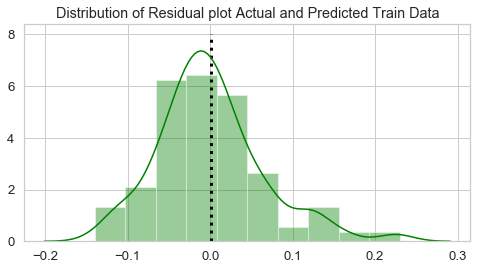

In [183]:
# Calculate the Residuals and check if they are normally distributed or not
res_m2 = my2_train - my2_train_pred
plt.figure(1,figsize=(8,4))
sns.set(style="whitegrid",font_scale=1.2)
sns.distplot(round(res_m2,2),bins=10,color="green")
plt.vlines(round(res_m2,2).mean(),ymin=0,ymax=8,linewidth=3.0,color="black",linestyles='dotted')
plt.title('Distribution of Residual plot Actual and Predicted Train Data')
plt.show()

In [184]:
# Mean of Residuals
round(res_m2,2).mean()

0.0004895104895104894

* The mean of residuals is observed to be very close 0

#### Error terms are independent of each other:

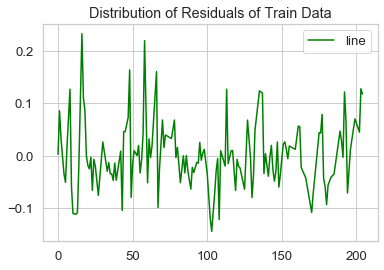

In [185]:
# check if the Residuals are normally distributed or not
plt.figure(1,figsize=(6,4))
sns.set(style="whitegrid",font_scale=1.2)
ax = sns.lineplot(data=res_m2, color="green", label="line")
plt.title('Distribution of Residuals of Train Data')
plt.show()

* There is no specific visible pattern

#### Error terms have constant variance (homoscedasticity):

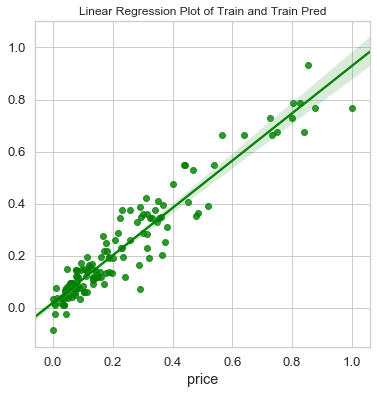

In [186]:
plt.figure(2,figsize=(6,6))
sns.set(style="whitegrid",font_scale=1.2)
ax1 = sns.regplot(x=my2_train,y=my2_train_pred,color='green')
plt.title('Linear Regression Plot of Train and Train Pred',fontsize=12)
plt.show()

* Error terms have constant variance but in the end couple of points are out of the variance

### __Observations on Training Set__
1. Probability of F-Test for Regression Model on training set is close to 0
2. p-value of T-test for all predictors in the final model are below 0.005
3. VIF of all the predictors is less than 5.
4. Residuals (Actual Train data and Predicted Train data) should be normally distributed with mean zero.
   - Here it is close to 0
5. Residuals (Actual Train data and Predicted Train data) are independent of each other.
6. Residuals (Actual Train data and Predicted Train data)  have constant variance.
7. Adjusted R-Square and R-Square are close to each other and Adjusted R-Square is below R-Square.

___Hence the basic checks are good on training data, this model can be used on test set for further evaluations___

### Prediction on the Test Set

* Make predictions on the test set (y_test_pred)
* evaluate the model, r-squared on the test set

### Preprocessing of Test Set Data based on Train Set

In [187]:
display(df_test.head())

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
160         2         0           0           1               0       95.7   
186         4         0           0           1               0       97.3   
59          3         0           0           0               0       98.8   
165         3         0           0           0               0       94.5   
140         4         0           0           0               0       93.3   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
160      166.3      64.4       53.0        2094               2          98   
186      171.7      65.5       55.7        2275               2         109   
59       177.8      66.5       53.7        2385               2         122   
165      168.7      64.0       52.6        2265               2          98   
140      157.3      63.8       55.7        2240               2         108   

     boreratio  stroke  compressionratio  horsepower  peakrpm  citympg  \
160       3.19    3.03               9.0          70     4800       38   
186       3.19    3.40               9.0          85     5250       27   
59        3.39    3.39               8.6          84     4800       26   
165       3.24    3.08               9.4         112     6600       26   
140       3.62    2.64               8.7          73     4400       26   

     highwaympg   price  carbody_hardtop  carbody_hatchback  carbody_sedan  \
160          47  7738.0                0                  0              1   
186          34  8495.0                0                  0              1   
59           32  8845.0                0                  1              0   
165          29  9298.0                0                  0              1   
140          31  7603.0                0                  1              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
160              0               1               0                 0   
186              0               1               0                 0   
59               0               1               0                 0   
165              0               0               1                 0   
140              0               0               0                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
160             0               1                0                0   
186             0               1                0                0   
59              0               1                0                0   
165             0               0                0                0   
140             0               0                1                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
160                 0                1                0               0   
186                 0                0                0               0   
59                  0                1                0               0   
165                 0                0                0               0   
140                 0                1                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
160               0                0                0                0   
186               0                1                0                0   
59                0                0                0                0   
165               0                1                0                0   
140               0                0                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
160             0            0              0                  0   
186             0            0              0                  0   
59              0            0              0                  0   
165             0            0              0                  0   
140             0            0              0     

### Scaling of DF Test

In [188]:
# Preprocessing of Test Set based on Training set
# 1 transform on data
df_test[scl_li] = m2_scaler.transform(df_test[scl_li])
df_test.head()

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
160        0.4         0           0           1               0   0.313793   
186        0.8         0           0           1               0   0.368966   
59         0.6         0           0           0               0   0.420690   
165        0.6         0           0           0               0   0.272414   
140        0.8         0           0           0               0   0.231034   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
160   0.409756  0.341667   0.460177    0.235066        0.333333    0.139623   
186   0.497561  0.433333   0.699115    0.305275        0.333333    0.181132   
59    0.596748  0.516667   0.522124    0.347944        0.333333    0.230189   
165   0.448780  0.308333   0.424779    0.301396        0.333333    0.139623   
140   0.263415  0.291667   0.699115    0.291699        0.333333    0.177358   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
160   0.404762  0.424242           0.12500    0.091667  0.265306  0.694444   
186   0.404762  0.611111           0.12500    0.154167  0.448980  0.388889   
59    0.563492  0.606061           0.10000    0.150000  0.265306  0.361111   
165   0.444444  0.449495           0.15000    0.266667  1.000000  0.361111   
140   0.746032  0.227273           0.10625    0.104167  0.102041  0.361111   

     highwaympg     price  carbody_hardtop  carbody_hatchback  carbody_sedan  \
160    0.810811  0.072382                0                  0              1   
186    0.459459  0.093295                0                  0              1   
59     0.405405  0.102964                0                  1              0   
165    0.324324  0.115479                0                  0              1   
140    0.378378  0.068652                0                  1              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
160              0               1               0                 0   
186              0               1               0                 0   
59               0               1               0                 0   
165              0               0               1                 0   
140              0               0               0                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
160             0               1                0                0   
186             0               1                0                0   
59              0               1                0                0   
165             0               0                0                0   
140             0               0                1                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
160                 0                1                0               0   
186                 0                0                0               0   
59                  0                1                0               0   
165                 0                0                0               0   
140                 0                1                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
160               0                0                0                0   
186               0                1                0                0   
59                0                0                0                0   
165               0                1                0                0   
140               0                0                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
160             0            0              0                  0   
186             0            0              0                  0   
59              0            0              0                  0   
165             0            0              0                  0   
140      

### Prediction and Evaluation of LR Model-II

In [189]:
# Create y_test and X_train
my2_test = df_test.pop("price")
MX2_test = df_test
display(my2_test.head())
display(MX2_test.head())


160    0.072382
186    0.093295
59     0.102964
165    0.115479
140    0.068652
Name: price, dtype: float64

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
160        0.4         0           0           1               0   0.313793   
186        0.8         0           0           1               0   0.368966   
59         0.6         0           0           0               0   0.420690   
165        0.6         0           0           0               0   0.272414   
140        0.8         0           0           0               0   0.231034   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
160   0.409756  0.341667   0.460177    0.235066        0.333333    0.139623   
186   0.497561  0.433333   0.699115    0.305275        0.333333    0.181132   
59    0.596748  0.516667   0.522124    0.347944        0.333333    0.230189   
165   0.448780  0.308333   0.424779    0.301396        0.333333    0.139623   
140   0.263415  0.291667   0.699115    0.291699        0.333333    0.177358   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
160   0.404762  0.424242           0.12500    0.091667  0.265306  0.694444   
186   0.404762  0.611111           0.12500    0.154167  0.448980  0.388889   
59    0.563492  0.606061           0.10000    0.150000  0.265306  0.361111   
165   0.444444  0.449495           0.15000    0.266667  1.000000  0.361111   
140   0.746032  0.227273           0.10625    0.104167  0.102041  0.361111   

     highwaympg  carbody_hardtop  carbody_hatchback  carbody_sedan  \
160    0.810811                0                  0              1   
186    0.459459                0                  0              1   
59     0.405405                0                  1              0   
165    0.324324                0                  0              1   
140    0.378378                0                  1              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
160              0               1               0                 0   
186              0               1               0                 0   
59               0               1               0                 0   
165              0               0               1                 0   
140              0               0               0                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
160             0               1                0                0   
186             0               1                0                0   
59              0               1                0                0   
165             0               0                0                0   
140             0               0                1                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
160                 0                1                0               0   
186                 0                0                0               0   
59                  0                1                0               0   
165                 0                0                0               0   
140                 0                1                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
160               0                0                0                0   
186               0                1                0                0   
59                0                0                0                0   
165               0                1                0                0   
140               0                0                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
160             0            0              0                  0   
186             0            0              0                  0   
59              0            0              0                  0   
165             0            0              0                  0   
140             0            0              0                  0   



In [190]:
# create a list of independent variables which are not contributing to LR model
l = list(set(MX2_test.columns) - set(MX2_train.columns))

In [191]:
# drop the columns from test set
MX2_test = MX2_test.drop(l,axis=1)

In [192]:
# check to compare test and train columns
display(MX2_test.columns)
display(MX2_train.columns)

Index(['aspiration', 'enginesize', 'peakrpm', 'carbody_hatchback',
       'drivewheel_fwd', 'fuelsystem_4bbl', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

Index(['aspiration', 'enginesize', 'peakrpm', 'carbody_hatchback',
       'drivewheel_fwd', 'fuelsystem_4bbl', 'company_Audi', 'company_Bmw',
       'company_Buick', 'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [193]:
# add cons for X_test set
MX2_test_sm = sm.add_constant(MX2_test)

# predict y_test_pred based on our model
my2_test_pred = m2_lr_sm_model.predict(MX2_test_sm)

In [194]:
# calculate the R2 for test data
m2_rsqr_test = r2_score(y_true=my2_test,y_pred=my2_test_pred)
m2_rmse = sqrt(mean_squared_error(my2_test, my2_test_pred))
print("Rsquare of the test set is ",m2_rsqr_test)
print("RMSE is ",m2_rmse)

Rsquare of the test set is  0.9056280122359854
RMSE is  0.071021237449261


### Residual Analysis and validating the assumptions on Train Set

#### Error terms are normally distributed with mean zero

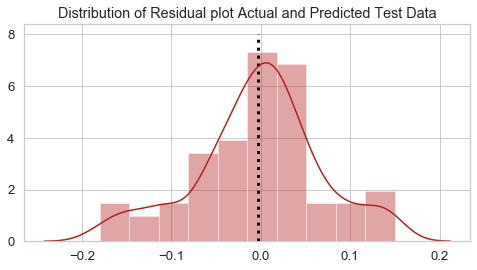

In [195]:
# Calculate the Residuals and check if they are normally distributed or not
res_test_m2 = my2_test - my2_test_pred
plt.figure(1,figsize=(8,4))
sns.set(style="whitegrid",font_scale=1.2)
sns.distplot(round(res_test_m2,2),bins=10,color="firebrick")
plt.vlines(round(res_test_m2,2).mean(),ymin=0,ymax=8,linewidth=3.0,color="black",linestyles='dotted')
plt.title('Distribution of Residual plot Actual and Predicted Test Data')
plt.show()

In [196]:
# Mean of Residuals
round(res_test_m2,2).mean()

-0.0025806451612903217

* The mean of residuals is observed to be very close 0

#### Error terms are independent of each other:

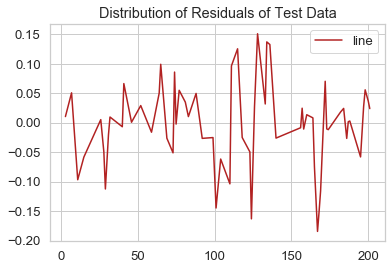

In [197]:
plt.figure(1,figsize=(6,4))
sns.set(style="whitegrid",font_scale=1.2)
ax = sns.lineplot(data=res_test_m2, color="firebrick", label="line")
plt.title('Distribution of Residuals of Test Data')
plt.show()

* There is no specific visible pattern

#### Error terms have constant variance (homoscedasticity):

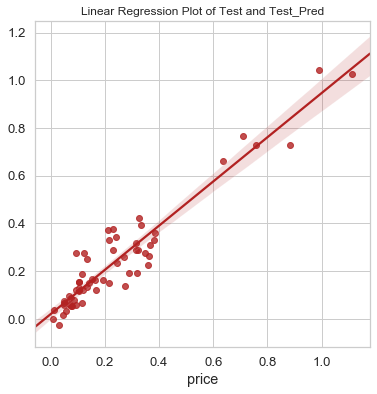

In [198]:
plt.figure(2,figsize=(6,6))
sns.set(style="whitegrid",font_scale=1.2)
ax1 = sns.regplot(x=my2_test,y=my2_test_pred,color="firebrick")
plt.title('Linear Regression Plot of Test and Test_Pred',fontsize=12)
plt.show()

* Error terms have constant variance but in the end couple of points are out of the variance

#### Distribution of Actual Test Data and Predicted Test Data

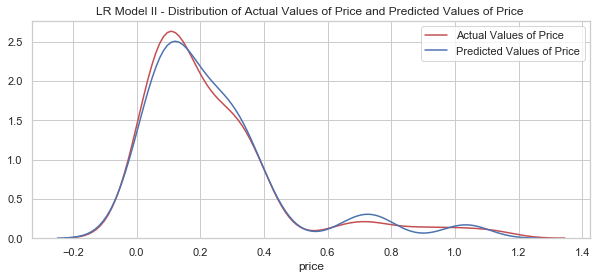

In [199]:
# Plot the Actual values of Price vs Predicted values of Price
plt.figure(1,figsize=(10,4))
sns.set(style="whitegrid",font_scale=1)
ax1 = sns.distplot(my2_test, hist=False, color="r", label="Actual Values of Price")
sns.distplot(my2_test_pred, hist=False, color="b", label="Predicted Values of Price" , ax=ax1)
plt.title('LR Model II - Distribution of Actual Values of Price and Predicted Values of Price ',fontsize=12)
plt.show()

### __Summary and Observations of LR-M II__

In [200]:
print('Linear Regression Model-II - VIF Values using RFE Train Set     :')
print(vif_calc(MX2_train))
print('Linear Regression Model-II - p-values using RFE Train Set     :')
print(round(m2_lr_sm_model.pvalues,3))
print('Linear Regression Model-II - Adj-R-Squared using RFE Train Set: ', m2_lr_sm_model.rsquared_adj)
print('Linear Regression Model-II - R-Squared using RFE Train Set    : ', m2_lr_sm_model.rsquared)
print('Linear Regression Model-II - R-Squared using RFE Test Set     :  ', m2_rsqr_test)

Linear Regression Model-II - VIF Values using RFE Train Set     :


Features   VIF
0              peakrpm  4.76
1           enginesize  3.00
2       drivewheel_fwd  2.87
3    carbody_hatchback  1.78
4           aspiration  1.41
5        company_Buick  1.32
6      fuelsystem_4bbl  1.31
7   company_Mitsubishi  1.25
8          company_Bmw  1.19
9      company_Porsche  1.19
10        company_Audi  1.10

None
Linear Regression Model-II - p-values using RFE Train Set     :
const                 0.015
aspiration            0.000
enginesize            0.000
peakrpm               0.001
carbody_hatchback     0.047
drivewheel_fwd        0.004
fuelsystem_4bbl       0.001
company_Audi          0.002
company_Bmw           0.000
company_Buick         0.000
company_Mitsubishi    0.007
company_Porsche       0.000
dtype: float64
Linear Regression Model-II - Adj-R-Squared using RFE Train Set:  0.9020221979636028
Linear Regression Model-II - R-Squared using RFE Train Set    :  0.9096120276988167
Linear Regression Model-II - R-Squared using RFE Test Set     :   0.9056280122359854


Observations of LR Model:
1. Probability of F-Test for Regression Model is close to 0.
2. p-value of T-test for all predictors in the final model is below 0.005.
3. There should not be any kind of collinearity among predictors. VIF of predictors is be less than 5.
4. Residuals (Actual Test data and Predicted Test data) should be normally distributed with mean zero both across Train and Test Data.
   * Mean of Residuals on Training data is 0.0004 and Test Data is -0.002
5. Residuals (Actual Test data and Predicted Test data) are independent of each other.
6. Residuals (Actual Test data and Predicted Test data)  have constant variance.
7. Adjusted R-Square should be little less but comapritively closer to R-Square. 
   * (0.902 < 0.909)
8. R-Square should be comparitvely high suggesting a good fit. 
   * (0.909)
9. R-Square of Test and Train should be closer to each other suggesting that model has worked well with unseen data. 
   * R-Squared using RFE Train Set    :  0.9096120276988167
   * R-Squared using RFE Test Set     :  0.9056280122359854
10. RMSE is of LR Model II is 0.0710

Conclusions on the model:
* __This model explains 90% variance of predictor Price by the dependent variables both on Training and Test Data__
* __Price = const*-0.0600 + aspiration*0.0784 + enginesize*0.9523	+ peakrpm*0.1174 + carbody_hatchback*-0.0260 + drivewheel_fwd*-0.0452 + fuelsystem_4bbl*0.1592 + company_Audi*0.1017 + company_Bmw*0.2351 + company_Buick*0.1971 + company_Mitsubishi*-0.0702 + company_Porsche*0.2290__	

## LR Model 3 using RFE and Backward Elimination method

__ML Linear Regression Steps__
* 1) Create a model using RFE with 20 Features and drop some of them based its p-value and VIF
* 1) Train the model using Training Data
* 2) Evaluate the model (training set and test set)

In [201]:
# Target variable is removed from predictor variables
my3_train = m3_train.pop("price")
MX3_train = m3_train

display(my3_train.head())
display(MX3_train.head())

122   -0.700201
125    1.151929
166   -0.452248
1      0.442646
199    0.757569
Name: price, dtype: float64

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
122   0.170159         0           0           1               0  -0.811836   
125   1.848278         0           0           0               0  -0.677177   
166   0.170159         0           0           0               0  -0.677177   
1     1.848278         0           0           0               0  -1.670284   
199  -1.507960         0           1           1               0   0.972390   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
122  -0.487238 -0.924500  -1.134628   -0.642128       -0.378724   -0.660242   
125  -0.359789  1.114978  -1.382026    0.439415       -0.378724    0.637806   
166  -0.375720 -0.833856  -0.392434   -0.441296       -0.378724   -0.660242   
1    -0.367754 -0.788535  -1.959288    0.015642       -0.378724    0.123485   
199   1.225364  0.616439   1.627983    1.137720       -0.378724    0.123485   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
122  -1.297329 -0.064443         -0.172569   -0.872898  0.771349  0.839773   
125   2.432256 -0.449757         -0.146125    1.021826  0.771349 -0.957048   
166  -0.259197 -0.546085         -0.172569    0.238673  3.064983  0.091098   
1     0.625138 -1.830463         -0.278345    0.213410 -0.271212 -0.657578   
199   1.201877 -0.321319         -0.675002    1.501822 -0.062699 -1.256518   

     highwaympg  carbody_hardtop  carbody_hatchback  carbody_sedan  \
122    1.025419                0                  0              1   
125   -0.557490                0                  1              0   
166   -0.269688                0                  1              0   
1     -0.557490                0                  0              0   
199   -1.276993                0                  0              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
122              0               1               0                 0   
125              0               0               1                 0   
166              0               0               1                 0   
1                0               0               1                 0   
199              1               0               1                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
122             0               1                0                0   
125             0               1                0                0   
166             0               0                0                0   
1               0               0                0                0   
199             0               1                0                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
122                 0                1                0               0   
125                 0                0                0               0   
166                 0                0                0               0   
1                   0                0                0               0   
199                 0                0                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
122               0                0                0                0   
125               0                1                0                0   
166               0                1                0                0   
1                 0                1                0                0   
199               0                1                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
122             0            0              0                  0   
125             0            0              0                  0   
166             0            0              0                  0   
1               0            0              0                  0   
199             0            0              0                  0   



In [202]:
# Running RFE with the output number of the variable equal to 10
lm3_rfe = LinearRegression()
lm3_rfe.fit(MX3_train, my3_train)

rfe3 = RFE(lm3_rfe, 25)             # running RFE
rfe3 = rfe3.fit(MX3_train, my3_train)

In [203]:
# display the features created using RFE 
list(zip(MX3_train.columns,rfe3.support_,rfe3.ranking_))

[('symboling', False, 35),
 ('fueltype', True, 1),
 ('aspiration', False, 13),
 ('doornumber', False, 26),
 ('enginelocation', True, 1),
 ('wheelbase', False, 7),
 ('carlength', False, 6),
 ('carwidth', True, 1),
 ('carheight', False, 5),
 ('curbweight', True, 1),
 ('cylindernumber', True, 1),
 ('enginesize', True, 1),
 ('boreratio', True, 1),
 ('stroke', False, 21),
 ('compressionratio', True, 1),
 ('horsepower', False, 10),
 ('peakrpm', False, 15),
 ('citympg', False, 30),
 ('highwaympg', False, 18),
 ('carbody_hardtop', True, 1),
 ('carbody_hatchback', True, 1),
 ('carbody_sedan', True, 1),
 ('carbody_wagon', True, 1),
 ('drivewheel_fwd', False, 31),
 ('drivewheel_rwd', False, 16),
 ('enginetype_dohcv', True, 1),
 ('enginetype_l', True, 1),
 ('enginetype_ohc', False, 19),
 ('enginetype_ohcf', True, 1),
 ('enginetype_ohcv', False, 20),
 ('enginetype_rotor', False, 12),
 ('fuelsystem_2bbl', False, 9),
 ('fuelsystem_4bbl', False, 11),
 ('fuelsystem_idi', True, 1),
 ('fuelsystem_mfi', F

In [204]:
# create a list of 25 columns created using RFE
rfe3_cols = MX3_train.columns[rfe3.support_]
display(rfe3_cols)

Index(['fueltype', 'enginelocation', 'carwidth', 'curbweight',
       'cylindernumber', 'enginesize', 'boreratio', 'compressionratio',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohcf',
       'fuelsystem_idi', 'company_Bmw', 'company_Buick', 'company_Mitsubishi',
       'company_Peugeot', 'company_Porsche', 'company_Renault', 'company_Saab',
       'company_Subaru', 'company_Volvo'],
      dtype='object')

In [205]:
# columns not contributing to variance of predictor
dr3_rfe_cols = MX3_train.columns[~rfe3.support_]
display(dr3_rfe_cols)

Index(['symboling', 'aspiration', 'doornumber', 'wheelbase', 'carlength',
       'carheight', 'stroke', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_ohc', 'enginetype_ohcv',
       'enginetype_rotor', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_mfi', 'fuelsystem_mpfi', 'fuelsystem_spdi',
       'fuelsystem_spfi', 'company_Audi', 'company_Chevrolet', 'company_Dodge',
       'company_Honda', 'company_Isuzu', 'company_Jaguar', 'company_Mazda',
       'company_Mercury', 'company_Nissan', 'company_Plymouth',
       'company_Toyota', 'company_Volkswagen'],
      dtype='object')

In [206]:
# Create a new df with only columns selected by RFE
MX3_train_ref = MX3_train[rfe3_cols]

# Inspect the DF
display(MX3_train_ref.head())

fueltype  enginelocation  carwidth  curbweight  cylindernumber  \
122         0               0 -0.924500   -0.642128       -0.378724   
125         0               0  1.114978    0.439415       -0.378724   
166         0               0 -0.833856   -0.441296       -0.378724   
1           0               0 -0.788535    0.015642       -0.378724   
199         0               0  0.616439    1.137720       -0.378724   

     enginesize  boreratio  compressionratio  carbody_hardtop  \
122   -0.660242  -1.297329         -0.172569                0   
125    0.637806   2.432256         -0.146125                0   
166   -0.660242  -0.259197         -0.172569                0   
1      0.123485   0.625138         -0.278345                0   
199    0.123485   1.201877         -0.675002                0   

     carbody_hatchback  carbody_sedan  carbody_wagon  enginetype_dohcv  \
122                  0              1              0                 0   
125                  1              0              0                 0   
166                  1              0              0                 0   
1                    0              0              0                 0   
199                  0              0              1                 0   

     enginetype_l  enginetype_ohcf  fuelsystem_idi  company_Bmw  \
122             0                0               0            0   
125             0                0               0            0   
166             0                0               0            0   
1               0                0               0            0   
199             0                0               0            0   

     company_Buick  company_Mitsubishi  company_Peugeot  company_Porsche  \
122              0                   0                0                0   
125              0                   0                0                1   
166              0                   0                0                0   
1                0                   0                0                0   
199              0                   0                0                0   

     company_Renault  company_Saab  company_Subaru  company_Volvo  
122                0             0               0              0  
125                0             0               0              0  
166                0             0               0              0  
1                  0             0               0              0  
199                0             0               0              1

In [207]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     95.82
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           8.99e-66
Time:                        02:00:58   Log-Likelihood:                 9.5493
No. Observations:                 143   AIC:                             28.90
Df Residuals:                     119   BIC:                             100.0
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3053      0.142      2.149      0.034       0.024       0.586
fueltype               0.3136      0.270      1.162      0.247      -0.221       0.848
enginelocation         1.0299      0.281      3.668      0.000       0.474       1.586
carwidth               0.2775      0.052      5.316      0.000       0.174       0.381
curbweight             0.3930      0.079      5.000      0.000       0.237       0.549
cylindernumber        -0.4154      0.073     -5.705      0.000      -0.560      -0.271
enginesize             0.7015      0.105      6.673      0.000       0.493       0.910
boreratio             -0.3702      0.064     -5.772      0.000      -0.497      -0.243
compressionratio      -0.1968      0.150     -1.311      0.192      -0.494       0.100
carbody_hardtop       -0.4724      0.219     -2.155      0.033      -0.906      -0.038
carbody_hatchback     -0.5332      0.139     -3.833      0.000      -0.809      -0.258
carbody_sedan         -0.4970      0.138     -3.607      0.000      -0.770      -0.224
carbody_wagon         -0.6050      0.148     -4.087      0.000      -0.898      -0.312
enginetype_dohcv       0.7334      0.380      1.929      0.056      -0.019       1.486
enginetype_l           0.5758      0.263      2.192      0.030       0.056       1.096
enginetype_ohcf        0.7429      0.140      5.305      0.000       0.466       1.020
fuelsystem_idi         0.3136      0.270      1.162      0.247      -0.221       0.848
company_Bmw            1.4835      0.125     11.911      0.000       1.237       1.730
company_Buick          0.4937      0.150      3.299      0.001       0.197       0.790
company_Mitsubishi    -0.3289      0.097     -3.404      0.001      -0.520      -0.138
company_Peugeot       -0.8891      0.305     -2.910      0.004      -1.494      -0.284
company_Porsche        1.1646      0.285      4.094      0.000       0.601       1.728
company_Renault       -0.3875      0.188     -2.056      0.042      -0.761      -0.014
company_Saab           0.4546      0.166      2.739      0.007       0.126       0.783
company_Subaru        -0.2870      0.170     -1.684      0.095      -0.624       0.050
company_Volvo          0.4911      0.137      3.596      0.000       0.221       0.761
==============================================================================
Omnibus:                       27.758   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.122
Skew:                           0.824   Prob(JB):                     1.45e-13
Kurtosis:                       5.684   Cond. No.                     1.60e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is corr

Features    VIF
0     compressionratio  45.72
1           enginesize  24.77
2           curbweight  14.24
3       cylindernumber  12.19
4      company_Peugeot  12.06
5         enginetype_l  10.05
6            boreratio   9.49
7             carwidth   6.10
8        carbody_sedan   4.32
9      company_Porsche   3.92
10   carbody_hatchback   3.51
11    enginetype_dohcv   2.33
12       carbody_wagon   2.02
13       company_Volvo   1.77
14       company_Buick   1.71
15     carbody_hardtop   1.58
16         company_Bmw   1.51
17  company_Mitsubishi   1.33
18        company_Saab   1.33
19     company_Renault   1.15
20            fueltype    NaN
21      enginelocation    NaN
22     enginetype_ohcf    NaN
23      fuelsystem_idi    NaN
24      company_Subaru    NaN

#### Drop the columns based on below thumb rules

* Significance levels and VIF are 2 important things that will make us in deciding to drop our features
  - Precedence 1 __High P-Value(above 0.05) and High VIF(above 5%)__ - They can be dropped 
  - Precedence 2 __High P-Value(above 0.05)__  - As insignificant, they are dropped first
  - Precedence 3 __High P-Value(above 0.05) and low VIF(below 5%)__ - They can be dropped first
  - Precedence 4 __Low P-Value(below 0.05) and High VIF(above 5%)__ - They can be dropped
  - __Low P-Value(below 0.05) and Low VIF(below 5%)__ - They can be retained

##### Drop compressionratio as p-value is  high and VIF is high

In [208]:
MX3_train_ref = MX3_train_ref.drop("compressionratio",axis=1)
MX3_train_ref.columns

Index(['fueltype', 'enginelocation', 'carwidth', 'curbweight',
       'cylindernumber', 'enginesize', 'boreratio', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohcf', 'fuelsystem_idi',
       'company_Bmw', 'company_Buick', 'company_Mitsubishi', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Subaru',
       'company_Volvo'],
      dtype='object')

In [209]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     99.50
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.07e-66
Time:                        02:00:58   Log-Likelihood:                 8.5242
No. Observations:                 143   AIC:                             28.95
Df Residuals:                     120   BIC:                             97.10
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3716      0.133      2.792      0.006       0.108       0.635
fueltype              -0.0354      0.044     -0.810      0.419      -0.122       0.051
enginelocation         1.0601      0.281      3.777      0.000       0.504       1.616
carwidth               0.2739      0.052      5.239      0.000       0.170       0.377
curbweight             0.4251      0.075      5.674      0.000       0.277       0.573
cylindernumber        -0.4051      0.073     -5.580      0.000      -0.549      -0.261
enginesize             0.6683      0.102      6.531      0.000       0.466       0.871
boreratio             -0.3584      0.064     -5.627      0.000      -0.484      -0.232
carbody_hardtop       -0.4948      0.219     -2.258      0.026      -0.929      -0.061
carbody_hatchback     -0.5330      0.140     -3.820      0.000      -0.809      -0.257
carbody_sedan         -0.4996      0.138     -3.615      0.000      -0.773      -0.226
carbody_wagon         -0.6203      0.148     -4.191      0.000      -0.913      -0.327
enginetype_dohcv       0.6885      0.380      1.813      0.072      -0.063       1.440
enginetype_l           0.5721      0.263      2.172      0.032       0.051       1.094
enginetype_ohcf        0.7534      0.140      5.372      0.000       0.476       1.031
fuelsystem_idi        -0.0354      0.044     -0.810      0.419      -0.122       0.051
company_Bmw            1.4854      0.125     11.892      0.000       1.238       1.733
company_Buick          0.5077      0.150      3.390      0.001       0.211       0.804
company_Mitsubishi    -0.2804      0.090     -3.132      0.002      -0.458      -0.103
company_Peugeot       -0.8638      0.306     -2.825      0.006      -1.469      -0.258
company_Porsche        1.1131      0.283      3.939      0.000       0.554       1.673
company_Renault       -0.3708      0.189     -1.966      0.052      -0.744       0.003
company_Saab           0.4126      0.163      2.526      0.013       0.089       0.736
company_Subaru        -0.3067      0.170     -1.801      0.074      -0.644       0.030
company_Volvo          0.4544      0.134      3.390      0.001       0.189       0.720
==============================================================================
Omnibus:                       29.862   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.379
Skew:                           0.840   Prob(JB):                     3.16e-16
Kurtosis:                       6.026   Cond. No.                     2.11e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-32. This might indicate that ther

Features    VIF
0           enginesize  23.88
1           curbweight  12.95
2       cylindernumber  12.11
3      company_Peugeot  11.95
4         enginetype_l  10.04
5            boreratio   9.35
6             carwidth   6.00
7      company_Porsche   3.86
8     enginetype_dohcv   2.32
9        carbody_sedan   2.11
10   carbody_hatchback   1.78
11       company_Volvo   1.73
12       carbody_wagon   1.65
13       company_Buick   1.65
14     carbody_hardtop   1.54
15         company_Bmw   1.51
16        company_Saab   1.29
17  company_Mitsubishi   1.16
18     company_Renault   1.15
19            fueltype    NaN
20      enginelocation    NaN
21     enginetype_ohcf    NaN
22      fuelsystem_idi    NaN
23      company_Subaru    NaN

##### Drop fueltype as p-value   high

In [210]:
MX3_train_ref = MX3_train_ref.drop("fueltype",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohcf', 'fuelsystem_idi', 'company_Bmw', 'company_Buick',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Renault', 'company_Saab', 'company_Subaru', 'company_Volvo'],
      dtype='object')

In [211]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     99.50
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.07e-66
Time:                        02:00:58   Log-Likelihood:                 8.5242
No. Observations:                 143   AIC:                             28.95
Df Residuals:                     120   BIC:                             97.10
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3716      0.133      2.792      0.006       0.108       0.635
enginelocation         1.0601      0.281      3.777      0.000       0.504       1.616
carwidth               0.2739      0.052      5.239      0.000       0.170       0.377
curbweight             0.4251      0.075      5.674      0.000       0.277       0.573
cylindernumber        -0.4051      0.073     -5.580      0.000      -0.549      -0.261
enginesize             0.6683      0.102      6.531      0.000       0.466       0.871
boreratio             -0.3584      0.064     -5.627      0.000      -0.484      -0.232
carbody_hardtop       -0.4948      0.219     -2.258      0.026      -0.929      -0.061
carbody_hatchback     -0.5330      0.140     -3.820      0.000      -0.809      -0.257
carbody_sedan         -0.4996      0.138     -3.615      0.000      -0.773      -0.226
carbody_wagon         -0.6203      0.148     -4.191      0.000      -0.913      -0.327
enginetype_dohcv       0.6885      0.380      1.813      0.072      -0.063       1.440
enginetype_l           0.5721      0.263      2.172      0.032       0.051       1.094
enginetype_ohcf        0.7534      0.140      5.372      0.000       0.476       1.031
fuelsystem_idi        -0.0708      0.087     -0.810      0.419      -0.244       0.102
company_Bmw            1.4854      0.125     11.892      0.000       1.238       1.733
company_Buick          0.5077      0.150      3.390      0.001       0.211       0.804
company_Mitsubishi    -0.2804      0.090     -3.132      0.002      -0.458      -0.103
company_Peugeot       -0.8638      0.306     -2.825      0.006      -1.469      -0.258
company_Porsche        1.1131      0.283      3.939      0.000       0.554       1.673
company_Renault       -0.3708      0.189     -1.966      0.052      -0.744       0.003
company_Saab           0.4126      0.163      2.526      0.013       0.089       0.736
company_Subaru        -0.3067      0.170     -1.801      0.074      -0.644       0.030
company_Volvo          0.4544      0.134      3.390      0.001       0.189       0.720
==============================================================================
Omnibus:                       29.862   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.379
Skew:                           0.840   Prob(JB):                     3.16e-16
Kurtosis:                       6.026   Cond. No.                     5.41e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.81e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Features    VIF
0           enginesize  23.88
1           curbweight  12.95
2       cylindernumber  12.11
3      company_Peugeot  11.95
4         enginetype_l  10.04
5            boreratio   9.35
6             carwidth   6.00
7      company_Porsche   3.86
8     enginetype_dohcv   2.32
9        carbody_sedan   2.11
10   carbody_hatchback   1.78
11       company_Volvo   1.73
12       carbody_wagon   1.65
13       company_Buick   1.65
14      fuelsystem_idi   1.59
15     carbody_hardtop   1.54
16         company_Bmw   1.51
17        company_Saab   1.29
18  company_Mitsubishi   1.16
19     company_Renault   1.15
20      enginelocation    NaN
21     enginetype_ohcf    NaN
22      company_Subaru    NaN

##### Drop fuelsystem_idi as p-value is  high

In [212]:
MX3_train_ref = MX3_train_ref.drop("fuelsystem_idi",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohcf', 'company_Bmw', 'company_Buick', 'company_Mitsubishi',
       'company_Peugeot', 'company_Porsche', 'company_Renault', 'company_Saab',
       'company_Subaru', 'company_Volvo'],
      dtype='object')

In [213]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     104.5
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.76e-67
Time:                        02:00:58   Log-Likelihood:                 8.1339
No. Observations:                 143   AIC:                             27.73
Df Residuals:                     121   BIC:                             92.91
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3819      0.132      2.886      0.005       0.120       0.644
enginelocation         1.0560      0.280      3.768      0.000       0.501       1.611
carwidth               0.2759      0.052      5.291      0.000       0.173       0.379
curbweight             0.4185      0.074      5.627      0.000       0.271       0.566
cylindernumber        -0.3975      0.072     -5.529      0.000      -0.540      -0.255
enginesize             0.6646      0.102      6.511      0.000       0.463       0.867
boreratio             -0.3540      0.063     -5.586      0.000      -0.479      -0.229
carbody_hardtop       -0.5052      0.218     -2.312      0.022      -0.938      -0.073
carbody_hatchback     -0.5447      0.139     -3.930      0.000      -0.819      -0.270
carbody_sedan         -0.5170      0.136     -3.793      0.000      -0.787      -0.247
carbody_wagon         -0.6291      0.147     -4.269      0.000      -0.921      -0.337
enginetype_dohcv       0.6722      0.379      1.775      0.078      -0.078       1.422
enginetype_l           0.5779      0.263      2.198      0.030       0.057       1.098
enginetype_ohcf        0.7499      0.140      5.358      0.000       0.473       1.027
company_Bmw            1.4880      0.125     11.933      0.000       1.241       1.735
company_Buick          0.4679      0.141      3.312      0.001       0.188       0.748
company_Mitsubishi    -0.2752      0.089     -3.086      0.003      -0.452      -0.099
company_Peugeot       -0.8959      0.303     -2.959      0.004      -1.495      -0.296
company_Porsche        1.1097      0.282      3.933      0.000       0.551       1.668
company_Renault       -0.3707      0.188     -1.969      0.051      -0.744       0.002
company_Saab           0.4185      0.163      2.568      0.011       0.096       0.741
company_Subaru        -0.3061      0.170     -1.800      0.074      -0.643       0.031
company_Volvo          0.4470      0.134      3.347      0.001       0.183       0.711
==============================================================================
Omnibus:                       29.793   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.568
Skew:                           0.853   Prob(JB):                     1.29e-15
Kurtosis:                       5.932   Cond. No.                     7.75e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.79e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Features    VIF
0           enginesize  23.85
1           curbweight  12.80
2       cylindernumber  11.93
3      company_Peugeot  11.77
4         enginetype_l  10.04
5            boreratio   9.29
6             carwidth   5.99
7      company_Porsche   3.86
8     enginetype_dohcv   2.32
9        carbody_sedan   2.02
10   carbody_hatchback   1.77
11       company_Volvo   1.72
12       carbody_wagon   1.65
13     carbody_hardtop   1.54
14         company_Bmw   1.51
15       company_Buick   1.49
16        company_Saab   1.29
17  company_Mitsubishi   1.16
18     company_Renault   1.15
19      enginelocation    NaN
20     enginetype_ohcf    NaN
21      company_Subaru    NaN

##### Drop enginetype_dohcv as p-value is  high

In [214]:
MX3_train_ref = MX3_train_ref.drop("enginetype_dohcv",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'enginetype_l', 'enginetype_ohcf',
       'company_Bmw', 'company_Buick', 'company_Mitsubishi', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Subaru',
       'company_Volvo'],
      dtype='object')

In [215]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     107.7
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.22e-67
Time:                        02:00:59   Log-Likelihood:                 6.2962
No. Observations:                 143   AIC:                             29.41
Df Residuals:                     122   BIC:                             91.63
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3937      0.133      2.953      0.004       0.130       0.658
enginelocation         0.8735      0.263      3.322      0.001       0.353       1.394
carwidth               0.2878      0.052      5.516      0.000       0.185       0.391
curbweight             0.4168      0.075      5.556      0.000       0.268       0.565
cylindernumber        -0.3553      0.068     -5.191      0.000      -0.491      -0.220
enginesize             0.6170      0.099      6.210      0.000       0.420       0.814
boreratio             -0.3302      0.062     -5.285      0.000      -0.454      -0.207
carbody_hardtop       -0.5066      0.220     -2.298      0.023      -0.943      -0.070
carbody_hatchback     -0.5457      0.140     -3.903      0.000      -0.822      -0.269
carbody_sedan         -0.5220      0.137     -3.796      0.000      -0.794      -0.250
carbody_wagon         -0.6348      0.149     -4.271      0.000      -0.929      -0.341
enginetype_l           0.6160      0.264      2.330      0.021       0.093       1.139
enginetype_ohcf        0.6400      0.127      5.054      0.000       0.389       0.891
company_Bmw            1.4589      0.125     11.699      0.000       1.212       1.706
company_Buick          0.4430      0.142      3.124      0.002       0.162       0.724
company_Mitsubishi    -0.2684      0.090     -2.987      0.003      -0.446      -0.091
company_Peugeot       -0.9479      0.304     -3.118      0.002      -1.550      -0.346
company_Porsche        1.3644      0.245      5.567      0.000       0.879       1.850
company_Renault       -0.3728      0.190     -1.963      0.052      -0.749       0.003
company_Saab           0.3975      0.164      2.424      0.017       0.073       0.722
company_Subaru        -0.2335      0.166     -1.402      0.163      -0.563       0.096
company_Volvo          0.4137      0.133      3.101      0.002       0.150       0.678
==============================================================================
Omnibus:                       28.733   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.926
Skew:                           0.835   Prob(JB):                     1.31e-14
Kurtosis:                       5.817   Cond. No.                     6.48e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.26e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Features    VIF
0           enginesize  22.25
1           curbweight  12.80
2      company_Peugeot  11.67
3       cylindernumber  10.64
4         enginetype_l   9.98
5            boreratio   8.88
6             carwidth   5.90
7      company_Porsche   2.85
8        carbody_sedan   2.00
9    carbody_hatchback   1.75
10       company_Volvo   1.69
11       carbody_wagon   1.65
12     carbody_hardtop   1.54
13         company_Bmw   1.48
14       company_Buick   1.48
15        company_Saab   1.28
16  company_Mitsubishi   1.16
17     company_Renault   1.15
18      enginelocation    NaN
19     enginetype_ohcf    NaN
20      company_Subaru    NaN

##### Drop company_Subaru as p-value is  high

In [216]:
MX3_train_ref = MX3_train_ref.drop("company_Subaru",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'enginetype_l', 'enginetype_ohcf',
       'company_Bmw', 'company_Buick', 'company_Mitsubishi', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Volvo'],
      dtype='object')

In [217]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     107.7
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           1.22e-67
Time:                        02:00:59   Log-Likelihood:                 6.2962
No. Observations:                 143   AIC:                             29.41
Df Residuals:                     122   BIC:                             91.63
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3937      0.133      2.953      0.004       0.130       0.658
enginelocation         1.1069      0.422      2.626      0.010       0.272       1.941
carwidth               0.2878      0.052      5.516      0.000       0.185       0.391
curbweight             0.4168      0.075      5.556      0.000       0.268       0.565
cylindernumber        -0.3553      0.068     -5.191      0.000      -0.491      -0.220
enginesize             0.6170      0.099      6.210      0.000       0.420       0.814
boreratio             -0.3302      0.062     -5.285      0.000      -0.454      -0.207
carbody_hardtop       -0.5066      0.220     -2.298      0.023      -0.943      -0.070
carbody_hatchback     -0.5457      0.140     -3.903      0.000      -0.822      -0.269
carbody_sedan         -0.5220      0.137     -3.796      0.000      -0.794      -0.250
carbody_wagon         -0.6348      0.149     -4.271      0.000      -0.929      -0.341
enginetype_l           0.6160      0.264      2.330      0.021       0.093       1.139
enginetype_ohcf        0.4065      0.136      2.999      0.003       0.138       0.675
company_Bmw            1.4589      0.125     11.699      0.000       1.212       1.706
company_Buick          0.4430      0.142      3.124      0.002       0.162       0.724
company_Mitsubishi    -0.2684      0.090     -2.987      0.003      -0.446      -0.091
company_Peugeot       -0.9479      0.304     -3.118      0.002      -1.550      -0.346
company_Porsche        1.3644      0.245      5.567      0.000       0.879       1.850
company_Renault       -0.3728      0.190     -1.963      0.052      -0.749       0.003
company_Saab           0.3975      0.164      2.424      0.017       0.073       0.722
company_Volvo          0.4137      0.133      3.101      0.002       0.150       0.678
==============================================================================
Omnibus:                       28.733   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.926
Skew:                           0.835   Prob(JB):                     1.31e-14
Kurtosis:                       5.817   Cond. No.                         44.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0           enginesize  22.25
1           curbweight  12.80
2      company_Peugeot  11.67
3       cylindernumber  10.64
4         enginetype_l   9.98
5            boreratio   8.88
6             carwidth   5.90
7      enginetype_ohcf   3.50
8      company_Porsche   2.85
9       enginelocation   2.81
10       carbody_sedan   2.00
11   carbody_hatchback   1.75
12       company_Volvo   1.69
13       carbody_wagon   1.65
14     carbody_hardtop   1.54
15         company_Bmw   1.48
16       company_Buick   1.48
17        company_Saab   1.28
18  company_Mitsubishi   1.16
19     company_Renault   1.15

##### Drop enginesize as VIF is high

In [218]:
MX3_train_ref = MX3_train_ref.drop("enginesize",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'cylindernumber',
       'boreratio', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'enginetype_l', 'enginetype_ohcf', 'company_Bmw',
       'company_Buick', 'company_Mitsubishi', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Volvo'],
      dtype='object')

In [219]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     85.27
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.10e-61
Time:                        02:00:59   Log-Likelihood:                -13.342
No. Observations:                 143   AIC:                             66.68
Df Residuals:                     123   BIC:                             125.9
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4749      0.152      3.133      0.002       0.175       0.775
enginelocation         1.8954      0.459      4.127      0.000       0.986       2.804
carwidth               0.2678      0.059      4.502      0.000       0.150       0.386
curbweight             0.6345      0.076      8.374      0.000       0.485       0.785
cylindernumber         0.0035      0.042      0.083      0.934      -0.080       0.086
boreratio             -0.0742      0.054     -1.384      0.169      -0.180       0.032
carbody_hardtop       -0.5123      0.252     -2.034      0.044      -1.011      -0.014
carbody_hatchback     -0.5246      0.160     -3.285      0.001      -0.841      -0.209
carbody_sedan         -0.4976      0.157     -3.169      0.002      -0.808      -0.187
carbody_wagon         -0.7448      0.169     -4.417      0.000      -1.079      -0.411
enginetype_l           0.8270      0.300      2.761      0.007       0.234       1.420
enginetype_ohcf       -0.0131      0.134     -0.098      0.922      -0.279       0.253
company_Bmw            1.2300      0.136      9.037      0.000       0.961       1.499
company_Buick          0.3670      0.161      2.274      0.025       0.047       0.687
company_Mitsubishi    -0.2232      0.102     -2.181      0.031      -0.426      -0.021
company_Peugeot       -1.4261      0.336     -4.244      0.000      -2.091      -0.761
company_Porsche        0.8170      0.261      3.127      0.002       0.300       1.334
company_Renault       -0.3031      0.217     -1.399      0.164      -0.732       0.126
company_Saab           0.0600      0.177      0.339      0.735      -0.290       0.410
company_Volvo          0.0535      0.137      0.390      0.697      -0.218       0.325
==============================================================================
Omnibus:                       30.943   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.709
Skew:                           0.798   Prob(JB):                     5.46e-20
Kurtosis:                       6.513   Cond. No.                         36.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0      company_Peugeot  10.96
1           curbweight   9.96
2         enginetype_l   9.82
3             carwidth   5.86
4            boreratio   4.99
5       cylindernumber   3.05
6      enginetype_ohcf   2.63
7       enginelocation   2.57
8      company_Porsche   2.49
9        carbody_sedan   1.70
10       carbody_wagon   1.64
11   carbody_hatchback   1.54
12     carbody_hardtop   1.53
13       company_Buick   1.47
14       company_Volvo   1.38
15         company_Bmw   1.35
16  company_Mitsubishi   1.15
17     company_Renault   1.14
18        company_Saab   1.14

##### Drop cylindernumber as p-value is  high and high VIF

In [220]:
MX3_train_ref = MX3_train_ref.drop("cylindernumber",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'boreratio',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'enginetype_l', 'enginetype_ohcf', 'company_Bmw',
       'company_Buick', 'company_Mitsubishi', 'company_Peugeot',
       'company_Porsche', 'company_Renault', 'company_Saab', 'company_Volvo'],
      dtype='object')

In [221]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     90.74
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.18e-62
Time:                        02:00:59   Log-Likelihood:                -13.346
No. Observations:                 143   AIC:                             64.69
Df Residuals:                     124   BIC:                             121.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4758      0.151      3.160      0.002       0.178       0.774
enginelocation         1.8934      0.457      4.145      0.000       0.989       2.797
carwidth               0.2680      0.059      4.523      0.000       0.151       0.385
curbweight             0.6381      0.062     10.308      0.000       0.516       0.761
boreratio             -0.0764      0.047     -1.638      0.104      -0.169       0.016
carbody_hardtop       -0.5125      0.251     -2.043      0.043      -1.009      -0.016
carbody_hatchback     -0.5260      0.158     -3.327      0.001      -0.839      -0.213
carbody_sedan         -0.4985      0.156     -3.195      0.002      -0.807      -0.190
carbody_wagon         -0.7471      0.166     -4.512      0.000      -1.075      -0.419
enginetype_l           0.8264      0.298      2.771      0.006       0.236       1.417
enginetype_ohcf       -0.0098      0.127     -0.077      0.939      -0.262       0.242
company_Bmw            1.2331      0.130      9.456      0.000       0.975       1.491
company_Buick          0.3664      0.161      2.281      0.024       0.049       0.684
company_Mitsubishi    -0.2236      0.102     -2.196      0.030      -0.425      -0.022
company_Peugeot       -1.4286      0.333     -4.286      0.000      -2.088      -0.769
company_Porsche        0.8232      0.249      3.304      0.001       0.330       1.316
company_Renault       -0.3020      0.215     -1.402      0.163      -0.728       0.124
company_Saab           0.0593      0.176      0.337      0.737      -0.289       0.407
company_Volvo          0.0538      0.137      0.394      0.695      -0.217       0.324
==============================================================================
Omnibus:                       31.021   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.300
Skew:                           0.799   Prob(JB):                     4.06e-20
Kurtosis:                       6.526   Cond. No.                         33.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0      company_Peugeot  10.88
1         enginetype_l   9.82
2           curbweight   6.61
3             carwidth   5.86
4            boreratio   3.82
5       enginelocation   2.56
6      enginetype_ohcf   2.39
7      company_Porsche   2.28
8        carbody_sedan   1.70
9        carbody_wagon   1.57
10     carbody_hardtop   1.53
11   carbody_hatchback   1.51
12       company_Buick   1.47
13       company_Volvo   1.37
14         company_Bmw   1.25
15  company_Mitsubishi   1.15
16     company_Renault   1.14
17        company_Saab   1.14

##### Drop enginetype_ohcf as p-value is  high

In [222]:
MX3_train_ref = MX3_train_ref.drop("enginetype_ohcf",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'boreratio',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'enginetype_l', 'company_Bmw', 'company_Buick',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Renault', 'company_Saab', 'company_Volvo'],
      dtype='object')

In [223]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     96.84
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.18e-63
Time:                        02:00:59   Log-Likelihood:                -13.350
No. Observations:                 143   AIC:                             62.70
Df Residuals:                     125   BIC:                             116.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4758      0.150      3.173      0.002       0.179       0.773
enginelocation         1.8799      0.420      4.480      0.000       1.049       2.710
carwidth               0.2677      0.059      4.543      0.000       0.151       0.384
curbweight             0.6397      0.058     11.021      0.000       0.525       0.755
boreratio             -0.0788      0.034     -2.293      0.024      -0.147      -0.011
carbody_hardtop       -0.5113      0.249     -2.051      0.042      -1.005      -0.018
carbody_hatchback     -0.5272      0.157     -3.363      0.001      -0.837      -0.217
carbody_sedan         -0.4999      0.154     -3.238      0.002      -0.805      -0.194
carbody_wagon         -0.7501      0.161     -4.673      0.000      -1.068      -0.432
enginetype_l           0.8264      0.297      2.782      0.006       0.238       1.414
company_Bmw            1.2345      0.129      9.606      0.000       0.980       1.489
company_Buick          0.3670      0.160      2.297      0.023       0.051       0.683
company_Mitsubishi    -0.2225      0.101     -2.214      0.029      -0.422      -0.024
company_Peugeot       -1.4258      0.330     -4.322      0.000      -2.079      -0.773
company_Porsche        0.8291      0.236      3.511      0.001       0.362       1.297
company_Renault       -0.2985      0.210     -1.424      0.157      -0.713       0.116
company_Saab           0.0622      0.171      0.363      0.717      -0.277       0.401
company_Volvo          0.0567      0.131      0.435      0.665      -0.202       0.315
==============================================================================
Omnibus:                       31.196   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.847
Skew:                           0.804   Prob(JB):                     3.09e-20
Kurtosis:                       6.535   Cond. No.                         30.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0      company_Peugeot  10.74
1         enginetype_l   9.82
2             carwidth   5.85
3           curbweight   5.85
4       enginelocation   2.17
5            boreratio   2.09
6      company_Porsche   2.06
7      carbody_hardtop   1.52
8        company_Buick   1.47
9        carbody_sedan   1.44
10   carbody_hatchback   1.38
11       company_Volvo   1.26
12       carbody_wagon   1.24
13         company_Bmw   1.23
14  company_Mitsubishi   1.13
15     company_Renault   1.09
16        company_Saab   1.09

##### Drop company_Saab as p-value is  high

In [224]:
MX3_train_ref = MX3_train_ref.drop("company_Saab",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'boreratio',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'enginetype_l', 'company_Bmw', 'company_Buick',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Renault', 'company_Volvo'],
      dtype='object')

In [225]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     103.6
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.24e-64
Time:                        02:00:59   Log-Likelihood:                -13.425
No. Observations:                 143   AIC:                             60.85
Df Residuals:                     126   BIC:                             111.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4759      0.149      3.184      0.002       0.180       0.772
enginelocation         1.8845      0.418      4.509      0.000       1.057       2.712
carwidth               0.2674      0.059      4.554      0.000       0.151       0.384
curbweight             0.6404      0.058     11.079      0.000       0.526       0.755
boreratio             -0.0766      0.034     -2.272      0.025      -0.143      -0.010
carbody_hardtop       -0.5120      0.248     -2.060      0.041      -1.004      -0.020
carbody_hatchback     -0.5244      0.156     -3.361      0.001      -0.833      -0.216
carbody_sedan         -0.4970      0.154     -3.235      0.002      -0.801      -0.193
carbody_wagon         -0.7494      0.160     -4.685      0.000      -1.066      -0.433
enginetype_l           0.8274      0.296      2.795      0.006       0.242       1.413
company_Bmw            1.2300      0.127      9.650      0.000       0.978       1.482
company_Buick          0.3624      0.159      2.283      0.024       0.048       0.677
company_Mitsubishi    -0.2248      0.100     -2.248      0.026      -0.423      -0.027
company_Peugeot       -1.4319      0.328     -4.361      0.000      -2.082      -0.782
company_Porsche        0.8210      0.234      3.504      0.001       0.357       1.285
company_Renault       -0.3014      0.209     -1.444      0.151      -0.714       0.112
company_Volvo          0.0514      0.129      0.398      0.692      -0.204       0.307
==============================================================================
Omnibus:                       30.604   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.979
Skew:                           0.792   Prob(JB):                     1.30e-19
Kurtosis:                       6.477   Cond. No.                         30.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0      company_Peugeot  10.72
1         enginetype_l   9.82
2             carwidth   5.84
3           curbweight   5.84
4       enginelocation   2.17
5      company_Porsche   2.05
6            boreratio   2.02
7      carbody_hardtop   1.52
8        company_Buick   1.46
9        carbody_sedan   1.38
10   carbody_hatchback   1.35
11       company_Volvo   1.25
12       carbody_wagon   1.24
13         company_Bmw   1.22
14  company_Mitsubishi   1.12
15     company_Renault   1.08

##### Drop company_Volvo as p-value is  high

In [226]:
MX3_train_ref = MX3_train_ref.drop("company_Volvo",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'boreratio',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'enginetype_l', 'company_Bmw', 'company_Buick',
       'company_Mitsubishi', 'company_Peugeot', 'company_Porsche',
       'company_Renault'],
      dtype='object')

In [227]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     111.2
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.26e-65
Time:                        02:00:59   Log-Likelihood:                -13.515
No. Observations:                 143   AIC:                             59.03
Df Residuals:                     127   BIC:                             106.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4785      0.149      3.216      0.002       0.184       0.773
enginelocation         1.8950      0.416      4.559      0.000       1.072       2.718
carwidth               0.2703      0.058      4.657      0.000       0.155       0.385
curbweight             0.6403      0.058     11.114      0.000       0.526       0.754
boreratio             -0.0742      0.033     -2.245      0.027      -0.140      -0.009
carbody_hardtop       -0.5138      0.248     -2.075      0.040      -1.004      -0.024
carbody_hatchback     -0.5246      0.156     -3.373      0.001      -0.832      -0.217
carbody_sedan         -0.4947      0.153     -3.233      0.002      -0.798      -0.192
carbody_wagon         -0.7473      0.159     -4.690      0.000      -1.063      -0.432
enginetype_l           0.8358      0.294      2.840      0.005       0.254       1.418
company_Bmw            1.2228      0.126      9.724      0.000       0.974       1.472
company_Buick          0.3494      0.155      2.257      0.026       0.043       0.656
company_Mitsubishi    -0.2266      0.100     -2.276      0.025      -0.424      -0.030
company_Peugeot       -1.4511      0.324     -4.483      0.000      -2.092      -0.811
company_Porsche        0.8069      0.231      3.496      0.001       0.350       1.264
company_Renault       -0.3073      0.207     -1.481      0.141      -0.718       0.103
==============================================================================
Omnibus:                       29.509   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.577
Skew:                           0.771   Prob(JB):                     1.93e-18
Kurtosis:                       6.364   Cond. No.                         30.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0      company_Peugeot  10.49
1         enginetype_l   9.77
2           curbweight   5.84
3             carwidth   5.76
4       enginelocation   2.16
5      company_Porsche   2.00
6            boreratio   1.96
7      carbody_hardtop   1.52
8        company_Buick   1.40
9    carbody_hatchback   1.32
10       carbody_sedan   1.25
11       carbody_wagon   1.20
12         company_Bmw   1.19
13  company_Mitsubishi   1.12
14     company_Renault   1.08

##### Drop company_Peugeot as VIF is  high

In [228]:
MX3_train_ref = MX3_train_ref.drop("company_Peugeot",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'boreratio',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'enginetype_l', 'company_Bmw', 'company_Buick',
       'company_Mitsubishi', 'company_Porsche', 'company_Renault'],
      dtype='object')

In [229]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     102.5
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.28e-62
Time:                        02:00:59   Log-Likelihood:                -24.019
No. Observations:                 143   AIC:                             78.04
Df Residuals:                     128   BIC:                             122.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4422      0.159      2.776      0.006       0.127       0.757
enginelocation         1.7951      0.445      4.034      0.000       0.915       2.676
carwidth               0.2171      0.061      3.564      0.001       0.097       0.338
curbweight             0.6524      0.062     10.575      0.000       0.530       0.774
boreratio             -0.0830      0.035     -2.344      0.021      -0.153      -0.013
carbody_hardtop       -0.4980      0.265     -1.876      0.063      -1.023       0.027
carbody_hatchback     -0.4811      0.166     -2.891      0.005      -0.810      -0.152
carbody_sedan         -0.4702      0.164     -2.869      0.005      -0.795      -0.146
carbody_wagon         -0.7539      0.171     -4.414      0.000      -1.092      -0.416
enginetype_l          -0.3980      0.112     -3.563      0.001      -0.619      -0.177
company_Bmw            1.2501      0.135      9.284      0.000       0.984       1.516
company_Buick          0.4764      0.163      2.919      0.004       0.153       0.799
company_Mitsubishi    -0.2413      0.107     -2.262      0.025      -0.452      -0.030
company_Porsche        0.9168      0.246      3.726      0.000       0.430       1.404
company_Renault       -0.2667      0.222     -1.200      0.232      -0.706       0.173
==============================================================================
Omnibus:                       43.269   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.538
Skew:                           1.145   Prob(JB):                     2.02e-28
Kurtosis:                       7.020   Cond. No.                         30.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0           curbweight  5.83
1             carwidth  5.53
2       enginelocation  2.16
3      company_Porsche  1.98
4            boreratio  1.95
5      carbody_hardtop  1.52
6        company_Buick  1.35
7    carbody_hatchback  1.32
8        carbody_sedan  1.25
9         enginetype_l  1.23
10         company_Bmw  1.19
11       carbody_wagon  1.18
12  company_Mitsubishi  1.12
13     company_Renault  1.08

##### Drop company_Renault as p-value is  high

In [230]:
MX3_train_ref = MX3_train_ref.drop("company_Renault",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'boreratio',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'enginetype_l', 'company_Bmw', 'company_Buick',
       'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [231]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     109.9
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           4.33e-63
Time:                        02:00:59   Log-Likelihood:                -24.820
No. Observations:                 143   AIC:                             77.64
Df Residuals:                     129   BIC:                             119.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4365      0.159      2.737      0.007       0.121       0.752
enginelocation         1.7653      0.445      3.966      0.000       0.885       2.646
carwidth               0.2069      0.060      3.425      0.001       0.087       0.327
curbweight             0.6626      0.061     10.826      0.000       0.542       0.784
boreratio             -0.0876      0.035     -2.487      0.014      -0.157      -0.018
carbody_hardtop       -0.4925      0.266     -1.853      0.066      -1.018       0.033
carbody_hatchback     -0.4834      0.167     -2.901      0.004      -0.813      -0.154
carbody_sedan         -0.4646      0.164     -2.830      0.005      -0.789      -0.140
carbody_wagon         -0.7664      0.171     -4.488      0.000      -1.104      -0.429
enginetype_l          -0.3890      0.112     -3.485      0.001      -0.610      -0.168
company_Bmw            1.2483      0.135      9.256      0.000       0.981       1.515
company_Buick          0.4867      0.163      2.981      0.003       0.164       0.810
company_Mitsubishi    -0.2371      0.107     -2.220      0.028      -0.448      -0.026
company_Porsche        0.9465      0.245      3.860      0.000       0.461       1.432
==============================================================================
Omnibus:                       41.574   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.839
Skew:                           1.116   Prob(JB):                     4.25e-26
Kurtosis:                       6.824   Cond. No.                         30.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0           curbweight  5.72
1             carwidth  5.43
2       enginelocation  2.15
3      company_Porsche  1.96
4            boreratio  1.93
5      carbody_hardtop  1.52
6        company_Buick  1.35
7    carbody_hatchback  1.30
8        carbody_sedan  1.25
9         enginetype_l  1.22
10         company_Bmw  1.19
11       carbody_wagon  1.14
12  company_Mitsubishi  1.12

##### Drop carbody_hardtop as p-value is  high

In [232]:
MX3_train_ref = MX3_train_ref.drop("carbody_hardtop",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'carwidth', 'curbweight', 'boreratio',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'enginetype_l',
       'company_Bmw', 'company_Buick', 'company_Mitsubishi',
       'company_Porsche'],
      dtype='object')

In [233]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     116.5
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.10e-63
Time:                        02:00:59   Log-Likelihood:                -26.697
No. Observations:                 143   AIC:                             79.39
Df Residuals:                     130   BIC:                             117.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2639      0.131      2.020      0.045       0.005       0.522
enginelocation         1.4299      0.410      3.484      0.001       0.618       2.242
carwidth               0.1988      0.061      3.269      0.001       0.078       0.319
curbweight             0.6721      0.062     10.917      0.000       0.550       0.794
boreratio             -0.0898      0.036     -2.525      0.013      -0.160      -0.019
carbody_hatchback     -0.3108      0.139     -2.228      0.028      -0.587      -0.035
carbody_sedan         -0.2929      0.137     -2.142      0.034      -0.563      -0.022
carbody_wagon         -0.5985      0.146     -4.097      0.000      -0.888      -0.310
enginetype_l          -0.3878      0.113     -3.441      0.001      -0.611      -0.165
company_Bmw            1.2460      0.136      9.154      0.000       0.977       1.515
company_Buick          0.5231      0.164      3.198      0.002       0.200       0.847
company_Mitsubishi    -0.2368      0.108     -2.197      0.030      -0.450      -0.024
company_Porsche        0.9588      0.247      3.875      0.000       0.469       1.448
==============================================================================
Omnibus:                       37.551   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.899
Skew:                           1.022   Prob(JB):                     2.03e-22
Kurtosis:                       6.548   Cond. No.                         27.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0           curbweight  5.72
1             carwidth  5.41
2      company_Porsche  1.96
3            boreratio  1.91
4       enginelocation  1.68
5        company_Buick  1.35
6    carbody_hatchback  1.30
7        carbody_sedan  1.25
8         enginetype_l  1.22
9          company_Bmw  1.19
10       carbody_wagon  1.14
11  company_Mitsubishi  1.12

##### Drop carwidth as p-value is  high

In [234]:
MX3_train_ref = MX3_train_ref.drop("carwidth",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'curbweight', 'boreratio', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'enginetype_l', 'company_Bmw',
       'company_Buick', 'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [235]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     117.5
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           3.09e-62
Time:                        02:00:59   Log-Likelihood:                -32.345
No. Observations:                 143   AIC:                             88.69
Df Residuals:                     131   BIC:                             124.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1749      0.132      1.321      0.189      -0.087       0.437
enginelocation         1.1398      0.415      2.745      0.007       0.318       1.961
curbweight             0.8320      0.039     21.464      0.000       0.755       0.909
boreratio             -0.0809      0.037     -2.202      0.029      -0.154      -0.008
carbody_hatchback     -0.2231      0.142     -1.573      0.118      -0.504       0.057
carbody_sedan         -0.1845      0.137     -1.342      0.182      -0.457       0.087
carbody_wagon         -0.5685      0.151     -3.762      0.000      -0.867      -0.270
enginetype_l          -0.3842      0.117     -3.290      0.001      -0.615      -0.153
company_Bmw            1.1717      0.139      8.425      0.000       0.897       1.447
company_Buick          0.6500      0.165      3.948      0.000       0.324       0.976
company_Mitsubishi    -0.2491      0.112     -2.232      0.027      -0.470      -0.028
company_Porsche        1.1837      0.246      4.806      0.000       0.696       1.671
==============================================================================
Omnibus:                       20.238   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.558
Skew:                           0.468   Prob(JB):                     3.17e-13
Kurtosis:                       5.964   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0           curbweight  2.12
1            boreratio  1.91
2      company_Porsche  1.81
3       enginelocation  1.54
4    carbody_hatchback  1.30
5        company_Buick  1.30
6        carbody_sedan  1.22
7         enginetype_l  1.22
8          company_Bmw  1.15
9   company_Mitsubishi  1.12
10       carbody_wagon  1.08

##### Drop carbody_sedan as p-value is  high

In [236]:
MX3_train_ref = MX3_train_ref.drop("carbody_sedan",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'curbweight', 'boreratio', 'carbody_hatchback',
       'carbody_wagon', 'enginetype_l', 'company_Bmw', 'company_Buick',
       'company_Mitsubishi', 'company_Porsche'],
      dtype='object')

In [237]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     128.3
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           6.45e-63
Time:                        02:00:59   Log-Likelihood:                -33.322
No. Observations:                 143   AIC:                             88.64
Df Residuals:                     132   BIC:                             121.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0058      0.041      0.142      0.887      -0.075       0.087
enginelocation         1.3108      0.396      3.307      0.001       0.527       2.095
curbweight             0.8282      0.039     21.359      0.000       0.752       0.905
boreratio             -0.0769      0.037     -2.094      0.038      -0.150      -0.004
carbody_hatchback     -0.0530      0.064     -0.829      0.408      -0.179       0.073
carbody_wagon         -0.3992      0.083     -4.786      0.000      -0.564      -0.234
enginetype_l          -0.3928      0.117     -3.359      0.001      -0.624      -0.162
company_Bmw            1.1570      0.139      8.320      0.000       0.882       1.432
company_Buick          0.6789      0.164      4.147      0.000       0.355       1.003
company_Mitsubishi    -0.2551      0.112     -2.280      0.024      -0.476      -0.034
company_Porsche        1.1766      0.247      4.764      0.000       0.688       1.665
==============================================================================
Omnibus:                       19.486   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.580
Skew:                           0.473   Prob(JB):                     6.30e-12
Kurtosis:                       5.786   Cond. No.                         20.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0          curbweight  2.11
1           boreratio  1.91
2     company_Porsche  1.81
3      enginelocation  1.54
4   carbody_hatchback  1.29
5       company_Buick  1.25
6        enginetype_l  1.15
7  company_Mitsubishi  1.09
8       carbody_wagon  1.07
9         company_Bmw  1.04

##### Drop carbody_hatchback as p-value is  high and high VIF

In [238]:
MX3_train_ref = MX3_train_ref.drop("carbody_hatchback",axis=1)
MX3_train_ref.columns

Index(['enginelocation', 'curbweight', 'boreratio', 'carbody_wagon',
       'enginetype_l', 'company_Bmw', 'company_Buick', 'company_Mitsubishi',
       'company_Porsche'],
      dtype='object')

In [239]:
# LR Modeling using Statsmodel
MX3_train_sm = sm.add_constant(MX3_train_ref)
m3_lr_sm = sm.OLS(my3_train,MX3_train_sm)
m3_lr_sm_model = m3_lr_sm.fit()
display(m3_lr_sm_model.summary())
vif_calc(MX3_train_ref)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     142.8
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           7.37e-64
Time:                        02:01:00   Log-Likelihood:                -33.693
No. Observations:                 143   AIC:                             87.39
Df Residuals:                     133   BIC:                             117.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0142      0.033     -0.429      0.669      -0.080       0.051
enginelocation         1.3689      0.390      3.513      0.001       0.598       2.140
curbweight             0.8314      0.039     21.572      0.000       0.755       0.908
boreratio             -0.0727      0.036     -2.001      0.047      -0.145      -0.001
carbody_wagon         -0.3820      0.081     -4.734      0.000      -0.542      -0.222
enginetype_l          -0.3908      0.117     -3.347      0.001      -0.622      -0.160
company_Bmw            1.1723      0.138      8.515      0.000       0.900       1.445
company_Buick          0.6851      0.163      4.194      0.000       0.362       1.008
company_Mitsubishi    -0.2684      0.111     -2.427      0.017      -0.487      -0.050
company_Porsche        1.1303      0.240      4.703      0.000       0.655       1.606
==============================================================================
Omnibus:                       19.083   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.232
Skew:                           0.488   Prob(JB):                     5.54e-11
Kurtosis:                       5.641   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0          curbweight  2.05
1           boreratio  1.86
2     company_Porsche  1.66
3      enginelocation  1.51
4       company_Buick  1.23
5        enginetype_l  1.13
6       carbody_wagon  1.07
7         company_Bmw  1.04
8  company_Mitsubishi  1.01

### Residual Analysis and validating the assumptions

#### Error terms are normally distributed with mean zero

In [240]:
my3_train_pred = m3_lr_sm_model.predict(MX3_train_sm)

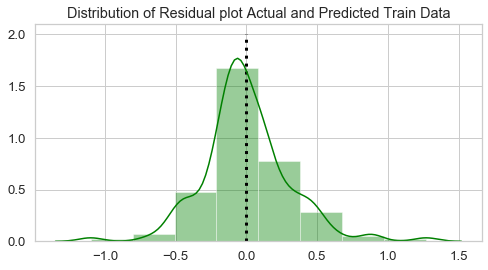

In [241]:
# Calculate the Residuals and check if they are normally distributed or not
res_m3 = my3_train - my3_train_pred
plt.figure(1,figsize=(8,4))
sns.set(style="whitegrid",font_scale=1.2)
sns.distplot(round(res_m3,2),bins=8,color="green")
plt.vlines(round(res_m3,2).mean(),ymin=0,ymax=2,linewidth=3.0,color="black",linestyles='dotted')
plt.title('Distribution of Residual plot Actual and Predicted Train Data')
plt.show()

In [242]:
# Mean of Residuals
round(res_m3,2).mean()

-0.00013986013986013222

* The mean of residuals is observed to be very close 0

#### Error terms are independent of each other:

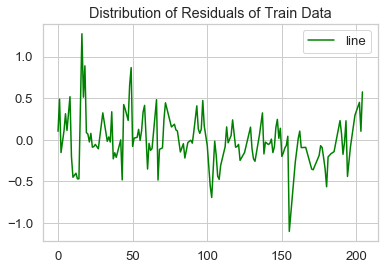

In [243]:
# check if the Residuals are normally distributed or not
plt.figure(1,figsize=(6,4))
sns.set(style="whitegrid",font_scale=1.2)
ax = sns.lineplot(data=res_m3, color="green", label="line")
plt.title('Distribution of Residuals of Train Data')
plt.show()

* There is no specific visible pattern

#### Error terms have constant variance (homoscedasticity):

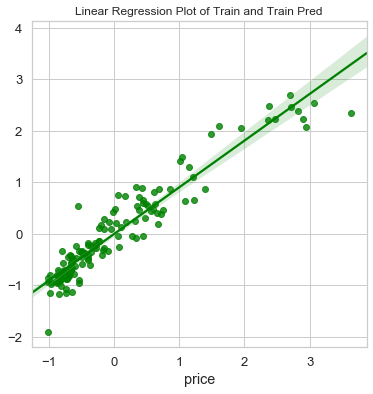

In [244]:
plt.figure(2,figsize=(6,6))
sns.set(style="whitegrid",font_scale=1.2)
ax1 = sns.regplot(x=my3_train,y=my3_train_pred,color='green')
plt.title('Linear Regression Plot of Train and Train Pred',fontsize=12)
plt.show()

* Error terms have constant variance but in the end couple of points are out of the variance

### __Observations on Training Set__
1. Probability of F-Test for Regression Model on training set is close to 0
2. p-value of T-test for all predictors in the final model are below 0.005
3. VIF of all the predictors is less than 5.
4. Residuals (Actual Train data and Predicted Train data) should be normally distributed with mean zero.
   - Here it is close to 0
5. Residuals (Actual Train data and Predicted Train data) are independent of each other.
6. Residuals (Actual Train data and Predicted Train data)  have constant variance.
7. Adjusted R-Square and R-Square are close to each other and Adjusted R-Square is below R-Square.

___Hence the basic checks are good on training data, this model can be used on test set for further evaluations___

### Prediction on the Test Set

* Make predictions on the test set (y_test_pred)
* evaluate the model, r-squared on the test set

### Preprocessing of Test Set Data based on Train Set

In [245]:
display(m3_test.head())

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
160         2         0           0           1               0       95.7   
186         4         0           0           1               0       97.3   
59          3         0           0           0               0       98.8   
165         3         0           0           0               0       94.5   
140         4         0           0           0               0       93.3   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
160      166.3      64.4       53.0        2094               2          98   
186      171.7      65.5       55.7        2275               2         109   
59       177.8      66.5       53.7        2385               2         122   
165      168.7      64.0       52.6        2265               2          98   
140      157.3      63.8       55.7        2240               2         108   

     boreratio  stroke  compressionratio  horsepower  peakrpm  citympg  \
160       3.19    3.03               9.0          70     4800       38   
186       3.19    3.40               9.0          85     5250       27   
59        3.39    3.39               8.6          84     4800       26   
165       3.24    3.08               9.4         112     6600       26   
140       3.62    2.64               8.7          73     4400       26   

     highwaympg   price  carbody_hardtop  carbody_hatchback  carbody_sedan  \
160          47  7738.0                0                  0              1   
186          34  8495.0                0                  0              1   
59           32  8845.0                0                  1              0   
165          29  9298.0                0                  0              1   
140          31  7603.0                0                  1              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
160              0               1               0                 0   
186              0               1               0                 0   
59               0               1               0                 0   
165              0               0               1                 0   
140              0               0               0                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
160             0               1                0                0   
186             0               1                0                0   
59              0               1                0                0   
165             0               0                0                0   
140             0               0                1                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
160                 0                1                0               0   
186                 0                0                0               0   
59                  0                1                0               0   
165                 0                0                0               0   
140                 0                1                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
160               0                0                0                0   
186               0                1                0                0   
59                0                0                0                0   
165               0                1                0                0   
140               0                0                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
160             0            0              0                  0   
186             0            0              0                  0   
59              0            0              0                  0   
165             0            0              0                  0   
140             0            0              0     

### Scaling of DF Test

In [246]:
# Preprocessing of Test Set based on Training set
# 1 transform on data
m3_test[scl_li] = m13_scaler.fit_transform(m3_test[scl_li])
display(m3_test.head())

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
160  -0.682207         0           0           1               0  -0.587157   
186   0.801892         0           0           1               0  -0.325847   
59    0.059843         0           0           0               0  -0.080869   
165   0.059843         0           0           0               0  -0.783139   
140   0.801892         0           0           0               0  -0.979122   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
160  -0.794680 -0.845273  -0.464750   -1.086333       -0.387657   -0.780488   
186  -0.328646 -0.286672   0.651450   -0.691974       -0.387657   -0.523466   
59    0.197800  0.221147  -0.175365   -0.452308       -0.387657   -0.219712   
165  -0.587554 -1.048400  -0.630112   -0.713761       -0.387657   -0.780488   
140  -1.571403 -1.149964   0.651450   -0.768231       -0.387657   -0.546831   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
160  -0.669882 -0.753102         -0.310803   -0.969994 -0.672020  2.145392   
186  -0.669882  0.418958         -0.310803   -0.584319  0.291957  0.354502   
59    0.030501  0.387280         -0.402893   -0.610031 -0.672020  0.191694   
165  -0.494786 -0.594715         -0.218714    0.109897  3.183891  0.191694   
140   0.835940 -1.988516         -0.379871   -0.892859 -1.528890  0.191694   

     highwaympg     price  carbody_hardtop  carbody_hatchback  carbody_sedan  \
160    2.477197 -0.722601                0                  0              1   
186    0.529274 -0.632141                0                  0              1   
59     0.229594 -0.590316                0                  1              0   
165   -0.219927 -0.536184                0                  0              1   
140    0.079754 -0.738733                0                  1              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
160              0               1               0                 0   
186              0               1               0                 0   
59               0               1               0                 0   
165              0               0               1                 0   
140              0               0               0                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
160             0               1                0                0   
186             0               1                0                0   
59              0               1                0                0   
165             0               0                0                0   
140             0               0                1                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
160                 0                1                0               0   
186                 0                0                0               0   
59                  0                1                0               0   
165                 0                0                0               0   
140                 0                1                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
160               0                0                0                0   
186               0                1                0                0   
59                0                0                0                0   
165               0                1                0                0   
140               0                0                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
160             0            0              0                  0   
186             0            0              0                  0   
59              0            0              0                  0   
165             0            0              0                  0   
140      

### Prediction and Evaluation of LR Model-III

In [247]:
# Create y_test and X_train
my3_test = m3_test.pop("price")
MX3_test = m3_test
display(my3_test.head())
display(MX3_test.head())


160   -0.722601
186   -0.632141
59    -0.590316
165   -0.536184
140   -0.738733
Name: price, dtype: float64

symboling  fueltype  aspiration  doornumber  enginelocation  wheelbase  \
160  -0.682207         0           0           1               0  -0.587157   
186   0.801892         0           0           1               0  -0.325847   
59    0.059843         0           0           0               0  -0.080869   
165   0.059843         0           0           0               0  -0.783139   
140   0.801892         0           0           0               0  -0.979122   

     carlength  carwidth  carheight  curbweight  cylindernumber  enginesize  \
160  -0.794680 -0.845273  -0.464750   -1.086333       -0.387657   -0.780488   
186  -0.328646 -0.286672   0.651450   -0.691974       -0.387657   -0.523466   
59    0.197800  0.221147  -0.175365   -0.452308       -0.387657   -0.219712   
165  -0.587554 -1.048400  -0.630112   -0.713761       -0.387657   -0.780488   
140  -1.571403 -1.149964   0.651450   -0.768231       -0.387657   -0.546831   

     boreratio    stroke  compressionratio  horsepower   peakrpm   citympg  \
160  -0.669882 -0.753102         -0.310803   -0.969994 -0.672020  2.145392   
186  -0.669882  0.418958         -0.310803   -0.584319  0.291957  0.354502   
59    0.030501  0.387280         -0.402893   -0.610031 -0.672020  0.191694   
165  -0.494786 -0.594715         -0.218714    0.109897  3.183891  0.191694   
140   0.835940 -1.988516         -0.379871   -0.892859 -1.528890  0.191694   

     highwaympg  carbody_hardtop  carbody_hatchback  carbody_sedan  \
160    2.477197                0                  0              1   
186    0.529274                0                  0              1   
59     0.229594                0                  1              0   
165   -0.219927                0                  0              1   
140    0.079754                0                  1              0   

     carbody_wagon  drivewheel_fwd  drivewheel_rwd  enginetype_dohcv  \
160              0               1               0                 0   
186              0               1               0                 0   
59               0               1               0                 0   
165              0               0               1                 0   
140              0               0               0                 0   

     enginetype_l  enginetype_ohc  enginetype_ohcf  enginetype_ohcv  \
160             0               1                0                0   
186             0               1                0                0   
59              0               1                0                0   
165             0               0                0                0   
140             0               0                1                0   

     enginetype_rotor  fuelsystem_2bbl  fuelsystem_4bbl  fuelsystem_idi  \
160                 0                1                0               0   
186                 0                0                0               0   
59                  0                1                0               0   
165                 0                0                0               0   
140                 0                1                0               0   

     fuelsystem_mfi  fuelsystem_mpfi  fuelsystem_spdi  fuelsystem_spfi  \
160               0                0                0                0   
186               0                1                0                0   
59                0                0                0                0   
165               0                1                0                0   
140               0                0                0                0   

     company_Audi  company_Bmw  company_Buick  company_Chevrolet  \
160             0            0              0                  0   
186             0            0              0                  0   
59              0            0              0                  0   
165             0            0              0                  0   
140             0            0              0                  0   



In [248]:
# drop the columns from test set
MX3_test = MX3_test[MX3_train_ref.columns]

In [249]:
# check to compare test and train columns
display(MX3_test.columns)
display(MX3_train_ref.columns)

Index(['enginelocation', 'curbweight', 'boreratio', 'carbody_wagon',
       'enginetype_l', 'company_Bmw', 'company_Buick', 'company_Mitsubishi',
       'company_Porsche'],
      dtype='object')

Index(['enginelocation', 'curbweight', 'boreratio', 'carbody_wagon',
       'enginetype_l', 'company_Bmw', 'company_Buick', 'company_Mitsubishi',
       'company_Porsche'],
      dtype='object')

In [250]:
# add cons for X_test set
MX3_test_sm = sm.add_constant(MX3_test)

# predict y_test_pred based on our model
my3_test_pred = m3_lr_sm_model.predict(MX3_test_sm)

In [251]:
# calculate the RSquared and RMSE for test data and Predicted data
m3_rsqr_test = r2_score(y_true=my3_test,y_pred=my3_test_pred)
m3_rmse = sqrt(mean_squared_error(my3_test, my3_test_pred))
print("RSquare of the test set is ",m3_rsqr_test)
print("RMSE of of the model is ",m3_rmse)

RSquare of the test set is  0.8890664454578333
RMSE of of the model is  0.3330668919934352


### Residual Analysis and validating the assumptions on Train Set

#### Error terms are normally distributed with mean zero

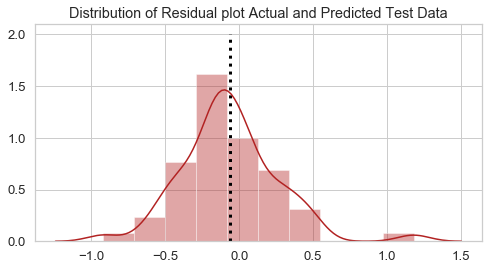

In [252]:
# Calculate the Residuals and check if they are normally distributed or not
res_test_m3 = my3_test - my3_test_pred
plt.figure(1,figsize=(8,4))
sns.set(style="whitegrid",font_scale=1.2)
sns.distplot(round(res_test_m3,2),bins=10,color="firebrick")
plt.vlines(round(res_test_m3,2).mean(),ymin=0,ymax=2,linewidth=3.0,color="black",linestyles='dotted')
plt.title('Distribution of Residual plot Actual and Predicted Test Data')
plt.show()

In [253]:
# Mean of Residuals
round(res_test_m3,2).mean()

-0.06387096774193549

* The mean of residuals is observed to be very close 0

#### Error terms are independent of each other:

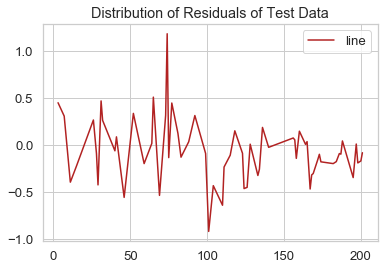

In [254]:
plt.figure(1,figsize=(6,4))
sns.set(style="whitegrid",font_scale=1.2)
ax = sns.lineplot(data=res_test_m3, color="firebrick", label="line")
plt.title('Distribution of Residuals of Test Data')
plt.show()

* There is no specific visible pattern

#### Error terms have constant variance (homoscedasticity):

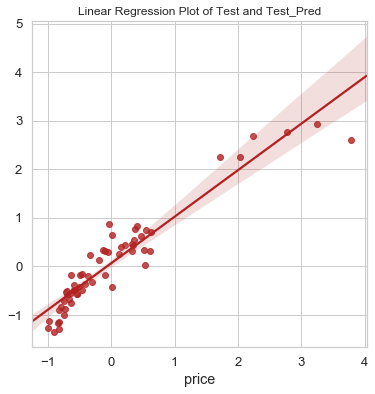

In [255]:
plt.figure(2,figsize=(6,6))
sns.set(style="whitegrid",font_scale=1.2)
ax1 = sns.regplot(x=my3_test,y=my3_test_pred,color="firebrick")
plt.title('Linear Regression Plot of Test and Test_Pred',fontsize=12)
plt.show()

* Error terms have constant variance but in the end couple of points are out of the variance

#### Distribution of Actual Test Data and Predicted Test Data

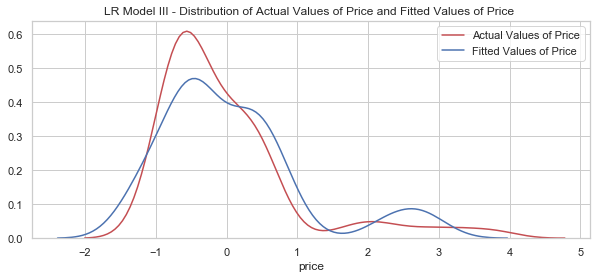

In [256]:
plt.figure(1,figsize=(10,4))
sns.set(style="whitegrid",font_scale=1)
ax1 = sns.distplot(my3_test, hist=False, color="r", label="Actual Values of Price")
sns.distplot(my3_test_pred, hist=False, color="b", label="Fitted Values of Price" , ax=ax1)
plt.title('LR Model III - Distribution of Actual Values of Price and Fitted Values of Price ',fontsize=12)
plt.show()

### __Summary and Observations of LR-M III__

In [257]:
# Print final summary of LR Model III
print('Linear Regression Model-III - VIF Values using RFE Train Set     :')
print(vif_calc(MX3_train_ref))
print('Linear Regression Model-III - p-values using RFE Train Set     :')
print(round(m1_lr_sm_model.pvalues,3))
print('Linear Regression Model-III - Adj-R-Squared using RFE Train Set: ', m3_lr_sm_model.rsquared_adj)
print('Linear Regression Model-III - R-Squared using RFE Train Set    : ', m3_lr_sm_model.rsquared)
print('Linear Regression Model-III - R-Squared using RFE Test Set     :  ', m3_rsqr_test)


Linear Regression Model-III - VIF Values using RFE Train Set     :


Features   VIF
0          curbweight  2.05
1           boreratio  1.86
2     company_Porsche  1.66
3      enginelocation  1.51
4       company_Buick  1.23
5        enginetype_l  1.13
6       carbody_wagon  1.07
7         company_Bmw  1.04
8  company_Mitsubishi  1.01

None
Linear Regression Model-III - p-values using RFE Train Set     :
const              0.322
enginelocation     0.001
curbweight         0.000
carbody_wagon      0.000
enginetype_l       0.001
company_Bmw        0.000
company_Buick      0.000
company_Porsche    0.000
dtype: float64
Linear Regression Model-III - Adj-R-Squared using RFE Train Set:  0.8998578871768157
Linear Regression Model-III - R-Squared using RFE Train Set    :  0.906204922496595
Linear Regression Model-III - R-Squared using RFE Test Set     :   0.8890664454578333


__Observations of LR Model:__
1. Probability of F-Test for Regression Model is close to 0.
2. p-value of T-test for all predictors in the final model is below 0.005.
3. There should not be any kind of collinearity among predictors. VIF of predictors is be less than 3.
4. Residuals (Actual Test data and Predicted Test data) should be normally distributed with mean zero both across Train and Test Data.
   * Mean of Residuals on Training data is -0.0001 and Test Data is -0.0638
5. Residuals (Actual Test data and Predicted Test data) are independent of each other.
6. Residuals (Actual Test data and Predicted Test data)  have constant variance.
7. Adjusted R-Square should be little less but comapritively closer to R-Square. 
   * (0.899 < 0.906)
8. R-Square should be comparitvely high suggesting a good fit. 
   * (0.906)
9. R-Square of Test and Train should be closer to each other suggesting that model has worked well with unseen data. 
   * R-Squared using RFE Train Set    :  0.906204922496595
   * R-Squared using RFE Test Set     :  0.8890664454578333
10. RMSE is of LR Model I is 0.333

Conclusions on the model:
* __This model explains 90% variance of predictor Price by the dependent variables both on Training and Test Data__
* __Price =const*-0.0142+enginelocation*1.3689+curbweight*0.8314+boreratio*-0.0727+carbody_wagon*-0.3820+enginetype_l*-0.3908+company_Bmw*1.1723+company_Buick*0.6851+company_Mitsubishi*-0.2684+company_Porsche*1.1303__	

## __Conclusions and Selction of the Model of the Model__

<table>
  <tr>
    <th>OLS Regression Results</th>
    <th>MLR Model I</th>
    <th>MLR Model II</th>
    <th>MLR Model III</th>
  </tr>
  <tr>
    <td>Probability of F-Statistic</td>
    <td>4.80e-64</td>
    <td>9.49e-63</td>
    <td>7.37e-64</td>
  </tr>
  <tr>
    <td>No of the Features</td>
    <td>7</td>
    <td>11</td>
    <td>8</td>
  </tr>
  <tr>
    <td>p-value of the Features</td>
    <td>Below 0.02</td>
    <td>Below 0.05</td>
    <td>Below 0.02</td>
  </tr>
  <tr>
    <td>VIF of the Features</td>
    <td>Below 2</td>
    <td>Below 5</td>
    <td>Below 3</td>
  </tr>
  <tr>
    <td>Residuals of Mean - Test Data</td>
    <td>-0.04758</td>
    <td>-0.00258</td>
    <td>-0.0638</td>
  </tr>
  <tr>
    <td>Residuals variance - Test Data</td>
    <td>Couple points are present out of the variance</td>
    <td>Variance is uniform compared to other models</td>
    <td>Couple points are present out of the variance</td>
  </tr>
  <tr>
    <td>Adjusted R-Square - Train Data</td>
    <td>0.894</td>
    <td>0.902</td>
    <td>0.899</td>
  </tr>
  <tr>
    <td>R-Sqaure - Train Data</td>
    <td>0.899</td>
    <td>0.909</td>
    <td>0.906</td>
  </tr>
  <tr>
    <td>R-Sqaure - Test Data</td>
    <td>0.886</td>
    <td>0.905</td>
    <td>0.889</td>
  </tr>
  <tr>
    <td>RMSE - Test Data</td>
    <td>0.361</td>
    <td>0.071</td>
    <td>0.333</td>
  </tr>
</table>

__Observations from the MLR Model comparisions__
* From Hypothesis Test and Model evaluation, perspective 3 models have decent perforamance and have fullfilled the criteria defined earlier.

___However, following observations are used to conclude the final model___
* ___MLR Model I and MLR Model III have closer R-Square, similar RMSE of 0.3 and similar results on Test R-Square. They both have similar performance on Test data and not as comparable with Model II.___
* ___On the test set, I clearly observe that Model I and Model III have couple of points present not in the variance range but outside of the variance. This deviates from the assumption that Residuals of Actual Test and Predicted Test should have uniform variance.___
* ___RMSE of Model I and Model III is higher comparitive to Model II.___

__Based on following conclusions, I choose Model II to be the best fit model__
1. Probability of F-Test for Regression Model is close to 0 and infact MLR Model II is very closer to 0 when compared with MLR Model I and MLR Model III.
2. p-value of T-test for all predictors in the final model is below 0.005.
3. There should not be any kind of collinearity among predictors. VIF of predictors is be less than 5.
4. Residuals (Actual Test data and Predicted Test data) should be normally distributed with mean zero both across Train and Test Data.
   * Mean of Residuals on Training data is 0.0004 and Test Data is -0.002
5. Residuals (Actual Test data and Predicted Test data) are independent of each other.
6. Residuals (Actual Test data and Predicted Test data)  have constant variance.
7. Adjusted R-Square should be little less but comapritively closer to R-Square. 
   * (0.902 < 0.909)
8. R-Square should be comparitvely high suggesting a good fit. 
   * (0.909)
9. R-Square of Test and Train should be closer to each other suggesting that model has worked well with unseen data. 
   * R-Squared using RFE Train Set    :  0.9096120276988167 is higher wrt Model I and Model III.
   * R-Squared using RFE Test Set     :  0.9056280122359854 is higher wrt Model I and Model III. Also on the unseen data the performance is very good.
10. __RMSE is of LR Model II is 0.0710__ is comparitively lower wrt Model I and Model III suggesting that its best fit line and most of the predicted values are very close in the range of +/- 0.07 which is very good metric.

Conclusions on the model:
* __This model explains 90% variance of predictor Price by the dependent variables both on Training and Test Data__
* __Price = const*-0.0600 + aspiration*0.0784 + enginesize*0.9523	+ peakrpm*0.1174 + carbody_hatchback*-0.0260 + drivewheel_fwd*-0.0452 + fuelsystem_4bbl*0.1592 + company_Audi*0.1017 + company_Bmw*0.2351 + company_Buick*0.1971 + company_Mitsubishi*-0.0702 + company_Porsche*0.2290__


### MLR Model II - Actual vs Predicted along with RMSE

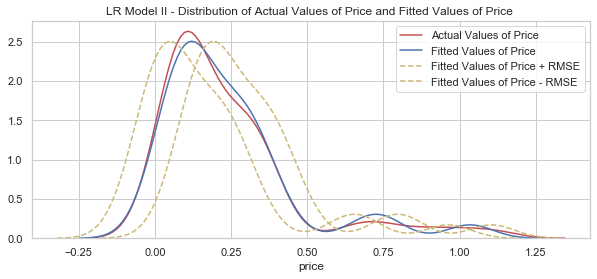

In [258]:
# Plot the Actual values of Price vs Predicted values of Price
plt.figure(1,figsize=(10,4))
sns.set(style="whitegrid",font_scale=1)
ax1 = sns.distplot(my2_test, hist=False, color="r", label="Actual Values of Price")
sns.distplot(my2_test_pred, hist=False, color="b", label="Predicated Values of Price" , ax=ax1)
sns.distplot((my2_test_pred+m2_rmse), hist=False, color="y", label="Predicated Values of Price + RMSE" , ax=ax1, kde_kws={'linestyle':'--'})
sns.distplot((my2_test_pred-m2_rmse), hist=False, color="y", label="Predicated Values of Price - RMSE" , ax=ax1, kde_kws={'linestyle':'--'})
plt.title('LR Model II - Distribution of Actual Values of Price and Predicated Values of Price ',fontsize=12)
plt.show()

### Business Conclusions based on MLR - Model II and EDA

__EDA - Numerical Correlations of Price__
1. Target variable "Price", has very strong +ve correlations with carlength, carwidth, curbweight, enginesize, horsepower. Increase or decrease in the dimensions of these variables increases or decreases the Price of the Car respectively.
2. Target variable "Price", has very strong -ve correlations with citympg and higwaympg. Increase in the dimension of these variables results in decrease of the Price of the Car or vice versa.

__EDA - Categorical Correlations of Price__
1. Symboling - To secure good rating or risk free car, security features needs to be added and adding or reducing these features increases or decreases the price of the car. 
2. Aspiration - Cars with Turbo aspiration increases the price while cars with STD costs very less. 
3. Cars with Rear wheel drive costs much higher and cars with either front wheel drive or 4 wheel drive costs very less in comparision.
4. The rear engine cars are much costlier than front engine cars.
5. There is a clear linear correlation between price and cars having four cylinders till Twelve cylinders. The median price increases linearly across cars having four, give, six, eight and twelve.
6.  Based on the median of the price, I segment the cars into following categories
   *  __High Premium Cars__ Jaguar, Buick and Porsche fall under this category
   *  __Premium Cars__ BMW falls under this category. BMW offers cars price range starting from 17000 till 42000.
   *  __Mid Range Cars__ Audi, Alfa-Romero, Mercury,Pegeot, Saab and Volvo offers Mid range cars
   *  __Low Economical Cars__ Chevrolet, Dodge, Honda, Isuzu, Mazda, Mitsubishi, Nissan, Plymouth, Renault, Subaru, Toyota and Volkswagen offers low economical range of cars. The low segment is crowded and probably due to the high number of sales.


__Charactersistics of Price based on Multiple Linear Regression Model - II which explains the 90% of dependendent features__

1. Aspiration                          (+ve correlation)
2. Enginesize                          (+ve correlation)
3. Peakrpm                             (+ve correlation)
4. Carbody_hatchback                   (-ve correlation)
5. Drivewheel_fwd                      (-ve correlation)  
6. Fuelsystem_4bbl                     (+ve correlation) 
7. Company_Audi - (Mid Priced Cars)    (+ve correlation)
8. Company_Bmw - (Premium Priced Cars) (+ve correlation)
9. Company_Buick - (High Premium Cars) (+ve correlation)
10. Company_Mitsubishi - (Low Economical Cars) (-ve correlation) 
11. Company_Porsche - (High Premium Cars) (+ve correlation)


* Due to multicollinearity, LR model has one car from each of the segments Lower Economical Cars, Mid range, Premium and Higher Premium ranges. Here it should be considered as range it represents and not brand
* It is also clear that lower economical cars represented by Company Mitsubushi dragging down the price, while other segmented cars increases the price.
* Also brand value of the respective cars would contribute in the price increase or decrease. 

__Final Features that Geely Auto should look for pricing the cars -  This is based on EDA and LR Modelling__

1. Aspiration (Type Turbo increases the price while STD decreases the price)
2. Enginesize has positive correlation with the price.
3. Peakrpm has positive correlation with the price.
4. Carbody with hatchback has -ve correlation wrt price.
5. Drivewheel fwd has -ve correlation while rwd has +ve correlation.
6. Lower economical cars are dragging down the price, while other segmented cars (mid range cars, premium and higher premium ranges cars) increases the price.
7. Increase in the Citympg and Higwaympg drags down the price of Car and decrease in Citympg and Highwaympg increases the Car price.